In [174]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt

In [175]:
data = pd.read_csv('../traffic/data/5.csv')
data

service_name             datetime  volumn   packets    unknown
0      S201709282113260015  2018-07-25 00:00:00   92408  26971036  177711644
1      S201709282113260015  2018-07-25 00:01:00   92150  26948190  220370286
2      S201709282113260015  2018-07-25 00:02:00   94896  26238222  188035073
3      S201709282113260015  2018-07-25 00:03:00   92694  26087970  191997884
4      S201709282113260015  2018-07-25 00:04:00   93674  25314568  169497214
...                    ...                  ...     ...       ...        ...
38875  S201709282113260015  2018-08-20 23:55:00   81521  23637112  138239574
38876  S201709282113260015  2018-08-20 23:56:00   83092  24617816  164460450
38877  S201709282113260015  2018-08-20 23:57:00   84873  25101336  173568370
38878  S201709282113260015  2018-08-20 23:58:00   81736  24181689  157334718
38879  S201709282113260015  2018-08-20 23:59:00   81236  23841156  167331442

[38880 rows x 5 columns]

In [176]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime'].dtypes

dtype('<M8[ns]')

In [177]:
scaler = MinMaxScaler()
data[['volumn']] = scaler.fit_transform(data[['volumn']])
data

service_name            datetime    volumn   packets    unknown
0      S201709282113260015 2018-07-25 00:00:00  0.148677  26971036  177711644
1      S201709282113260015 2018-07-25 00:01:00  0.148146  26948190  220370286
2      S201709282113260015 2018-07-25 00:02:00  0.153802  26238222  188035073
3      S201709282113260015 2018-07-25 00:03:00  0.149266  26087970  191997884
4      S201709282113260015 2018-07-25 00:04:00  0.151285  25314568  169497214
...                    ...                 ...       ...       ...        ...
38875  S201709282113260015 2018-08-20 23:55:00  0.126251  23637112  138239574
38876  S201709282113260015 2018-08-20 23:56:00  0.129487  24617816  164460450
38877  S201709282113260015 2018-08-20 23:57:00  0.133156  25101336  173568370
38878  S201709282113260015 2018-08-20 23:58:00  0.126694  24181689  157334718
38879  S201709282113260015 2018-08-20 23:59:00  0.125664  23841156  167331442

[38880 rows x 5 columns]

In [178]:
data.drop(columns=['unknown','service_name','packets'],inplace = True)

In [179]:
device = torch.device("cuda:0")

In [244]:
def seq_data(x,sequence_length):
    x_seq = []
    target = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length])
        target.append(x[i+sequence_length])

    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(target).to(device).view(-1,1)

In [245]:
class VanillaRNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layers,device,sequence_length):
        super(VanillaRNN,self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first = True)
        # input_size는 feature 개수를 의미함
        # hidden_state는 hidden_state의 feature 개수를 의미함
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,1))
   
    def forward(self,x):
        h0 = torch.zeros(self.num_layers,x.size()[0],self.hidden_size).to(self.device)
        out,h_n = self.rnn(x,h0) # 64x60x10
        out = out.reshape(out.shape[0],-1)
        out = self.fc(out) # 64x1
        return out

In [246]:
split = 1440
sequence_length = 60
X = data[['volumn']].values[:-split]
x_seq, target = seq_data(X,sequence_length)

In [247]:
batch_size = 128
train = TensorDataset(x_seq,target)
train_loader = DataLoader(dataset = train,batch_size = batch_size)
# shuffle 제거

In [248]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 10

In [249]:
model = VanillaRNN(input_size = input_size, hidden_size = hidden_size,sequence_length=sequence_length,
                  num_layers = num_layers, device=device).to(device) # GPU 연산을 위한 to(device)
criterion = nn.MSELoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(),lr=1e-3)

<font color = blue><font size =6> 기본 모델 training </font></font>

In [250]:
import time
count = 0

loss_graph = []
n = len(train_loader)
begin = time.time()
for epoch in range(num_epochs):

    running_loss = 0.0
    for dt in train_loader:
        seq,target = dt
        out = model(seq)
        #print(seq)
        #print('out1',out) #size는 64x1
  
        loss = criterion(out,target)# 손실함수 계산
        
        optimizer.zero_grad() # optimizer 초기화
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
        count+=1
        
    loss_graph.append(running_loss/n)
    #print('out2',out)
    print('mae',running_loss/n) # mae가 아닌 MSE이다

end = time.time()
#시간차
result = end - begin
print(count) # 64크기를 갖는 배치가 585개 있는데(마지막은 < 64) 이걸 50번 돌았음

mae 0.021010850665172734
mae 0.008711760160228144
mae 0.004009310083875066
mae 0.0027904598833821733
mae 0.0017512450386479926
mae 0.0015970511052869633
mae 0.0008597496039933984
mae 0.00311385856250294
mae 0.000563114437824876
mae 0.0017658030340377895
mae 0.000508273001440959
mae 0.006537617973219263
mae 0.005343328493457755
mae 0.0010696149151069498
mae 0.0004222351012266926
mae 0.0001912430872009418
mae 0.00039624929323157937
mae 0.0004977680986510044
mae 0.0009675352333253905
mae 0.00014500308934222797
mae 0.007840020973640636
mae 0.01298105738685295
mae 0.0002069053062526826
mae 0.00013119416752125
mae 0.0001144263344307323
mae 0.00011306743774538589
mae 0.00015001234629821413
mae 0.0006085099821513487
mae 0.00013046549949972312
mae 0.001068531470504389
mae 0.00010910272171263495
mae 0.00010653437510363833
mae 0.005263911719159339
mae 0.0002742696487333229
mae 0.00010463329835560148
mae 0.000129138535735194
mae 0.00021577148783216506
mae 0.00028813300417227503
mae 0.0005556491287

In [251]:
out

tensor([[0.0980],
        [0.0985],
        [0.0979],
        [0.0984]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [252]:
Y = data[['volumn']].values[-2*split:-split]
len(Y)

1440

In [253]:
[[1,2]]+[[3,4]]

[[1, 2], [3, 4]]

<font color = blue><font size =6> One Step Training and forecasting</font></font>

In [257]:
out_list = []
Y = data[['volumn']].values[-2*split:-split]

# for num in range(split)
#     new_tr = torch.FloatTensor(new_train).unsqueeze(0).to(device)
#     out = model(new_tr)
#     target = torch.FloatTensor(Y[num]).to(device)
for num in range(split):
    if num==0:
        new_train=X[-60:].tolist()
    else:
        new_train = new_train[1:]+out.cpu().tolist()
    #print(type(new_train))
    new_tr = torch.FloatTensor(new_train).unsqueeze(0).to(device)
##############################################################################################
# target을 Y[num] 말고 다른걸로도 시도해볼만 한가
    target = torch.FloatTensor(Y[num]).unsqueeze(0).to(device)
##############################################################################################

    train_loader = DataLoader(dataset = new_tr, batch_size = 64,shuffle = False)
    #print(next(iter(train_loader)))
    for epoch in range(num_epochs):
        running_loss = 0.0
        for dt in train_loader:

            out = model(dt)
            #print(out)
            loss = criterion(out,target)# 손실함수 계산

            optimizer.zero_grad() # optimizer 초기화

            loss.backward()

            optimizer.step() # optimizer 최적화

            running_loss = running_loss + loss.item()
   
        print('mae',running_loss/n)  # mae가 아닌 MSE이다
    out_list.append(out)
    loss_graph.append(running_loss/n)

mae 1.0340565135352848e-05
mae 8.211172354302715e-06
mae 5.175193069254783e-06
mae 2.3579645310703396e-06
mae 5.459677449462509e-07
mae 1.1572768136283519e-09
mae 5.14274617218422e-07
mae 1.5911413753983714e-06
mae 2.6761518422603202e-06
mae 3.342889805575483e-06
mae 3.4023609501865944e-06
mae 2.9086952221678388e-06
mae 2.0820552518165354e-06
mae 1.1974526688443822e-06
mae 4.874292638712267e-07
mae 8.482436791345248e-08
mae 8.795204103887382e-09
mae 1.845519953771294e-07
mae 4.835194175420869e-07
mae 7.701885716436564e-07
mae 9.425098685159923e-07
mae 9.552466185642693e-07
mae 8.217114402909378e-07
mae 5.972281328017852e-07
mae 3.531815880693419e-07
mae 1.5221050036149323e-07
mae 3.202334880243205e-08
mae 5.174297819940587e-10
mae 4.05682905395547e-08
mae 1.2041661427864876e-07
mae 2.053047771924795e-07
mae 2.670365096858159e-07
mae 2.8962512983727576e-07
mae 2.706809698066868e-07
mae 2.1923560376593736e-07
mae 1.5124814942838312e-07
mae 8.428468058639088e-08
mae 3.27786236227436e-08
m

mae 2.173673421765152e-10
mae 3.1383503759347394e-10
mae 3.53573825507927e-10
mae 3.2777360651218736e-10
mae 2.5141041467099424e-10
mae 1.5410319967390204e-10
mae 6.72472316739575e-11
mae 1.3514959345052795e-11
mae 5.321825649862583e-13
mae 2.1480713302148444e-11
mae 5.977180070574695e-11
mae 9.659629637694971e-11
mae 1.1735257134649195e-10
mae 1.1584854880479088e-10
mae 9.46553991804801e-11
mae 6.275601956942609e-11
mae 3.1157286837777736e-11
mae 8.827651541115928e-12
mae 1.2369021241448435e-13
mae 4.142491431412365e-12
mae 1.5993907752995147e-11
mae 2.922508651463959e-11
mae 3.833152528796301e-11
mae 4.0163852524432696e-11
mae 3.477466778697913e-11
mae 2.4647866607029154e-11
mae 1.3495764990945145e-11
mae 4.7592085752046895e-12
mae 4.0606426071450503e-13
mae 6.526322902653862e-13
mae 4.135407223334415e-12
mae 8.724495528752805e-12
mae 1.23812708284587e-11
mae 1.3701216119182673e-11
mae 1.2485637097593378e-11
mae 9.363177658310137e-12
mae 5.5327786341811884e-12
mae 2.2812430746090524e

mae 5.723110649782613e-09
mae 6.413866831653246e-09
mae 5.651289669068931e-09
mae 3.891582325254464e-09
mae 1.9272289732989612e-09
mae 4.995667376170497e-10
mae 1.8419016785810216e-13
mae 3.7520764500673826e-10
mae 1.2273682411708937e-09
mae 2.0433480497313555e-09
mae 2.4283590019371046e-09
mae 2.246407874279879e-09
mae 1.628979702739688e-09
mae 8.693153288610933e-10
mae 2.6787643017695645e-10
mae 7.414913582644361e-12
mae 9.733350871590613e-11
mae 4.0358155649406434e-10
mae 7.305800894097457e-10
mae 9.1433890568844e-10
mae 8.834378143705236e-10
mae 6.713144715887605e-10
mae 3.82527593218965e-10
mae 1.3528527558727122e-10
mae 1.0074092489295555e-11
mae 2.3041254910864222e-11
mae 1.308667910480826e-10
mae 2.599569827507118e-10
mae 3.427559942355193e-10
mae 3.446604185215936e-10
mae 2.723977130320798e-10
mae 1.6324775130480528e-10
mae 6.351690049917097e-11
mae 7.481436024351934e-12
mae 5.217954244642636e-12
mae 4.286706749901216e-11
mae 9.291871633137689e-11
mae 1.2840868906673506e-10
ma

mae 1.427420942159017e-13
mae 6.63082118602123e-11
mae 1.9677925728014237e-10
mae 3.0352676003996696e-10
mae 3.2824659031827153e-10
mae 2.652328474408492e-10
mae 1.5436266902548105e-10
mae 5.269877821949952e-11
mae 2.6217935672308474e-12
mae 1.354698226937263e-11
mae 6.317047453957995e-11
mae 1.1476419511338662e-10
mae 1.3786934733793296e-10
mae 1.2242319103853696e-10
mae 7.99773808044698e-11
mae 3.3796010358844843e-11
mae 4.820174596969225e-12
mae 1.8348129235145755e-12
mae 1.9105263446369304e-11
mae 4.208412458108101e-11
mae 5.6336338703649526e-11
mae 5.4676045261291864e-11
mae 3.9504539192402736e-11
mae 1.956460022431183e-11
mae 4.560030017598439e-12
mae 4.511825119050056e-14
mae 5.289787568914424e-12
mae 1.4905955878027112e-11
mae 2.2443453239218412e-11
mae 2.3765593209723487e-11
mae 1.8764342374185025e-11
mae 1.0504095886614076e-11
mae 3.2913042787962008e-12
mae 7.7601937011342e-14
mae 1.3025007693561596e-12
mae 5.122940373014374e-12
mae 8.739930281205051e-12
mae 1.142016101707807

mae 7.745954048825185e-13
mae 6.03226427292394e-08
mae 4.247867019228008e-08
mae 1.882402912801793e-08
mae 2.7819277833191257e-09
mae 1.0314234472196764e-09
mae 1.070191163295338e-08
mae 2.2723897400096776e-08
mae 2.837080876787953e-08
mae 2.4485036111639418e-08
mae 1.4357984883698027e-08
mae 4.498902844498927e-09
mae 7.441016327941417e-11
mae 2.054460065096852e-09
mae 7.467472986572457e-09
mae 1.193736551094875e-08
mae 1.2540003529313949e-08
mae 9.244101820761932e-09
mae 4.3745853174261276e-09
mae 7.982443223674151e-10
mae 1.1152335634425311e-10
mae 1.918982991472136e-09
mae 4.4252846029240624e-09
mae 5.7702293819068444e-09
mae 5.165120129857519e-09
mae 3.166371465365322e-09
mae 1.0825906723977898e-09
mae 4.136436661530081e-11
mae 3.4024639609378315e-10
mae 1.427684061226696e-09
mae 2.396121217254168e-09
mae 2.5931339108610826e-09
mae 1.9613148481118234e-09
mae 9.606071205830273e-10
mae 1.9272169449987247e-10
mae 1.4704978986470395e-11
mae 3.6719063739530716e-10
mae 8.869083669985134e

mae 6.211769058930867e-12
mae 1.4292344024245507e-10
mae 3.2834124043082003e-10
mae 4.040713702202378e-10
mae 3.2100038819681084e-10
mae 1.5410319967390204e-10
mae 2.5081952442186352e-11
mae 7.00818318811508e-12
mae 8.130633822639435e-11
mae 1.6826874213307102e-10
mae 1.9521926434137187e-10
mae 1.4652596466457472e-10
mae 6.451989340973991e-11
mae 7.711768273643723e-12
mae 6.285756897918702e-12
mae 4.5787816465927875e-11
mae 8.580991813963696e-11
mae 9.359124624330409e-11
mae 6.589770367607362e-11
mae 2.6050279112456002e-11
mae 1.9038430293781117e-12
mae 5.048340206242309e-12
mae 2.5696038395301885e-11
mae 4.353077625325565e-11
mae 4.446621304006542e-11
mae 2.9121642526338336e-11
mae 1.0101741968512926e-11
mae 3.0365471229626575e-13
mae 3.718091439584682e-12
mae 1.4241337726084272e-11
mae 2.194312990696611e-11
mae 2.0879771177114207e-11
mae 1.2596619992822254e-11
mae 3.694628221109993e-12
mae 5.0956584420338246e-15
mae 2.590874803284307e-12
mae 7.842864772488012e-12
mae 1.09373268879338

mae 1.170463043893043e-13
mae 3.247231834959954e-14
mae 9.169760135129279e-17
mae 3.247231834959954e-14
mae 8.403516790283889e-14
mae 1.020715556066469e-13
mae 7.096030248041035e-14
mae 2.5379016294656564e-14
mae 4.0089281913085857e-16
mae 1.1841115876974792e-14
mae 4.043864219592012e-14
mae 1.471967121570112e-09
mae 8.508318084964681e-10
mae 1.9279420380976744e-10
mae 1.0318708345118494e-11
mae 3.1779545244884776e-10
mae 7.128532849334023e-10
mae 7.998684339066414e-10
mae 5.249021695113021e-10
mae 1.5784311590043975e-10
mae 4.966523968725888e-14
mae 1.1989353764620443e-10
mae 3.374260991967378e-10
mae 4.250199888658443e-10
mae 3.1192564193330984e-10
mae 1.1510017512473775e-10
mae 3.5949127633760825e-12
mae 4.2400970864837785e-11
mae 1.564462810342356e-10
mae 2.2157157261773654e-10
mae 1.8019442593343417e-10
mae 7.853588844857615e-11
mae 6.77508864331151e-12
mae 1.3393621441353966e-11
mae 7.083467221957058e-11
mae 1.1353648396865655e-10
mae 1.0158736195825544e-10
mae 5.063395739853925e

mae 5.1529892980614846e-11
mae 2.0862679350487458e-10
mae 2.8292853839057204e-10
mae 1.9893438432397392e-10
mae 5.7624288351984645e-11
mae 2.1610017529693594e-13
mae 5.759785519219016e-11
mae 1.3938629545226747e-10
mae 1.485349575607718e-10
mae 8.099265664663132e-11
mae 1.2369021241448433e-11
mae 5.915962448780006e-12
mae 5.021360649996793e-11
mae 8.505356601043485e-11
mae 7.174609484446613e-11
mae 2.8421236543600345e-11
mae 9.203135030695485e-13
mae 1.0622929157482607e-11
mae 3.726116419582611e-11
mae 4.756004767109873e-11
mae 3.135195857195228e-11
mae 7.81850428161663e-12
mae 2.8943400577265413e-13
mae 1.1467580771966096e-11
mae 2.4621942709946306e-11
mae 2.432908330617276e-11
mae 1.2028494241600538e-11
mae 1.2925845452761457e-12
mae 1.6869812335079689e-12
mae 9.680141405936414e-12
mae 1.4658281414608686e-11
mae 1.1279687081977385e-11
mae 3.788926699881431e-12
mae 1.2031331562422515e-14
mae 2.4882212331500752e-12
mae 6.939216740090498e-12
mae 7.90637938130498e-12
mae 4.61596934357980

mae 1.04308673947052e-13
mae 3.470564753292401e-14
mae 3.3917578643294177e-13
mae 3.1645914709351246e-08
mae 1.379613599546473e-08
mae 5.251016549906319e-10
mae 4.9430784835063364e-09
mae 1.6957440248348054e-08
mae 1.9376483525756632e-08
mae 9.830297540713168e-09
mae 8.375780766718797e-10
mae 1.9426995014567e-09
mae 8.952159453628413e-09
mae 1.1609416621061337e-08
mae 6.847638378965544e-09
mae 1.0162149226017723e-09
mae 6.232180520606071e-10
mae 4.571126967275383e-09
mae 6.830936114062594e-09
mae 4.566419633776275e-09
mae 9.377567452179314e-10
mae 1.7382456793627943e-10
mae 2.307887814872272e-09
mae 3.951657864791794e-09
mae 2.9782098546890786e-09
mae 8.008042647657875e-10
mae 2.6604144749920468e-11
mae 1.1240543573671625e-09
mae 2.2518574703065004e-09
mae 1.89359357773045e-09
mae 6.180132416440458e-10
mae 3.0750449589018784e-13
mae 5.397244789889428e-10
mae 1.2666543187853068e-09
mae 1.1825861033700736e-09
mae 4.5737965709109945e-10
mae 5.056167089108062e-12
mae 2.488495992508306e-10


mae 7.731120256685927e-12
mae 1.8583772367001757e-11
mae 1.5209979654223033e-11
mae 3.654578346430545e-12
mae 4.5165539870866846e-13
mae 7.40543462729145e-12
mae 1.1788170742918539e-11
mae 6.994362616579183e-12
mae 7.013305370656678e-13
mae 1.3005144932144923e-12
mae 5.992433701318487e-12
mae 6.784155338374046e-12
mae 2.7473025750440353e-12
mae 1.2807350932535935e-14
mae 1.7508937038184038e-12
mae 4.263850554390844e-12
mae 3.4965614021912e-12
mae 8.355091362793414e-13
mae 1.0943085648865024e-13
mae 1.7142267885805447e-12
mae 2.718520137859555e-12
mae 1.5801815676961094e-12
mae 1.4538541019535054e-13
mae 3.221571663209915e-13
mae 1.401684987267365e-12
mae 1.5410319967390203e-12
mae 5.948946303335491e-13
mae 5.9413983024308715e-16
mae 4.308392853705089e-13
mae 9.88336450981053e-13
mae 7.73063827590527e-13
mae 1.6456763900034162e-13
mae 3.60151802199904e-14
mae 4.1498848347080936e-13
mae 6.193119585611413e-13
mae 3.381625658295808e-13
mae 2.3474585945930954e-14
mae 9.072454581298652e-14
m

mae 8.97360959904256e-10
mae 1.2994575305817925e-09
mae 5.755718207695409e-10
mae 2.1824097326435136e-12
mae 3.8041926984339343e-10
mae 8.360670699558475e-10
mae 5.4475172647338e-10
mae 4.863467990109693e-11
mae 1.2472635590252031e-10
mae 4.868842530512862e-10
mae 4.453950079439103e-10
mae 9.878172455212365e-11
mae 2.4647866607029154e-11
mae 2.5465073205211344e-10
mae 3.2632523910968663e-10
mae 1.2418249970240004e-10
mae 2.866307873644026e-13
mae 1.1646778801153607e-10
mae 2.1734168503609083e-10
mae 1.2278948430653316e-10
mae 5.495982129771172e-12
mae 4.431541065090759e-11
mae 1.3246502719143652e-10
mae 1.0464590892722824e-10
mae 1.649209703197964e-11
mae 1.219208352024266e-11
mae 7.360136315356479e-11
mae 7.98839856607464e-11
mae 2.3655380271213395e-11
mae 1.4411232919939983e-12
mae 3.684783081616811e-11
mae 5.5697826328329405e-11
mae 2.5414391865161345e-11
mae 1.3947205165531635e-13
mae 1.6126476718280968e-11
mae 3.5756880960117885e-11
mae 2.303289754600718e-11
mae 1.8560996501621496

mae 1.9790433986317495e-12
mae 4.5071981035557547e-11
mae 1.0609353668626685e-10
mae 6.094860982991864e-11
mae 1.5152051020774332e-12
mae 2.888722708137646e-11
mae 6.949297110455245e-11
mae 4.05620595890248e-11
mae 1.1242610937774817e-12
mae 1.8628833023004632e-11
mae 4.563478908373231e-11
mae 2.6811093353036262e-11
mae 7.73063827590527e-13
mae 1.214956538864089e-11
mae 2.990669827825765e-11
mae 1.7650102843054398e-11
mae 5.145493435958296e-13
mae 7.96523560040702e-12
mae 1.9649404591102038e-11
mae 1.1550272304768144e-11
mae 3.2612214029016477e-13
mae 5.2977993626457126e-12
mae 1.2913738338057422e-11
mae 7.538691703503115e-12
mae 1.9556900657123986e-13
mae 3.5422889498402665e-12
mae 8.494611157827945e-12
mae 4.889225164280997e-12
mae 1.1174678929633248e-13
mae 2.390333664791862e-12
mae 5.614988186202579e-12
mae 3.1661711553654116e-12
mae 5.856824316391167e-14
mae 1.637597907107509e-12
mae 3.708026680547107e-12
mae 2.023376536475143e-12
mae 2.735771412216256e-14
mae 1.1168889097614042e-

mae 1.8068312287073163e-07
mae 6.941785048947705e-08
mae 2.5195436059835417e-09
mae 8.903026252821304e-08
mae 1.1194825634112385e-07
mae 2.527428040385831e-08
mae 1.0053718949504412e-08
mae 7.348027464309103e-08
mae 6.275546966269993e-08
mae 5.127275605225513e-09
mae 1.791069623444042e-08
mae 5.4764078062666586e-08
mae 3.1749755413304864e-08
mae 2.6099665470182126e-10
mae 1.978994354207558e-08
mae 3.705747337052726e-08
mae 1.3491292306303075e-08
mae 6.815936726664935e-10
mae 1.883143545688629e-08
mae 2.2819794769777913e-08
mae 4.736333342969144e-09
mae 2.3877762929576534e-09
mae 1.5400812129566365e-08
mae 1.2718837969175956e-08
mae 9.507573977254416e-10
mae 3.878342658780958e-09
mae 1.1377778719179332e-08
mae 6.318154930601567e-09
mae 2.315840655382037e-11
mae 4.307707192090383e-09
mae 7.629021594965188e-09
mae 2.6230092985765514e-09
mae 1.9115382011437425e-10
mae 4.034943755679532e-09
mae 4.6317139035776185e-09
mae 8.44596589860028e-10
mae 6.024868885928697e-10
mae 3.2767507145266722e

mae 8.662892928598723e-12
mae 3.809474540898282e-13
mae 1.1297236184080623e-11
mae 1.097190218846323e-11
mae 6.01627962465832e-13
mae 4.346939948686357e-12
mae 9.588271776853661e-12
mae 2.8140773746131793e-12
mae 7.352669857112236e-13
mae 6.246532301651416e-12
mae 4.390609226209224e-12
mae 2.2159748438951675e-14
mae 2.9321171959890253e-12
mae 4.4125257107635996e-12
mae 7.412508225729575e-13
mae 8.149484121284163e-13
mae 3.2755300178695297e-12
mae 1.5823709426572986e-12
mae 3.568552355397543e-14
mae 1.823040012465052e-12
mae 1.8894563577743687e-12
mae 1.2430329803013058e-13
mae 6.911611972926679e-13
mae 1.613181336711333e-12
mae 4.910937034353018e-13
mae 1.1824064670111949e-13
mae 1.0498458378709512e-12
mae 7.412508225729575e-13
mae 3.0078328906056287e-15
mae 5.033705723765493e-13
mae 7.412508225729575e-13
mae 1.1349965336183282e-13
mae 1.5006956617842774e-13
mae 5.539937109737919e-13
mae 2.488180310253604e-13
mae 1.0373954255354108e-14
mae 3.2116971198577883e-13
mae 3.055765727675623e-

mae 8.303052619361453e-09
mae 2.2039066514126647e-09
mae 1.686653423525549e-08
mae 8.381131808285415e-09
mae 5.24842319017382e-10
mae 1.1268563305068309e-08
mae 7.660152388016659e-09
mae 3.8932115779220165e-11
mae 7.220325561559365e-09
mae 6.662830141992404e-09
mae 5.305960903864827e-11
mae 4.382822763039881e-09
mae 5.487513497074289e-09
mae 2.517003791587582e-10
mae 2.538762889713456e-09
mae 4.3328265510912696e-09
mae 4.863657751096291e-10
mae 1.354858426435981e-09
mae 3.2943648021895066e-09
mae 6.374461247055836e-10
mae 6.71607709908242e-10
mae 2.414522576567982e-09
mae 7.213153396535934e-10
mae 2.852321276401484e-10
mae 1.7134948083096853e-09
mae 7.205206473173866e-10
mae 9.955326968555626e-11
mae 1.1761584319298453e-09
mae 6.725104629417371e-10
mae 2.030696581689791e-11
mae 7.809986984017527e-10
mae 5.896709771966572e-10
mae 2.9650173101730283e-13
mae 5.016118396645624e-10
mae 4.94927257311616e-10
mae 5.754047219736107e-12
mae 3.099760872707424e-10
mae 3.993082360782976e-10
mae 1.9

mae 5.074551927697005e-11
mae 3.074079481677733e-11
mae 1.5823709426572986e-12
mae 3.799809159017006e-11
mae 2.1087132040520373e-11
mae 1.6711887846273112e-12
mae 2.843051846278506e-11
mae 1.4254481554165568e-11
mae 1.6937721608278774e-12
mae 2.1215247988405037e-11
mae 9.566719051379027e-12
mae 1.6577115107229195e-12
mae 1.583415992180137e-11
mae 6.298859045272111e-12
mae 1.5823709426572986e-12
mae 1.1722506924205436e-11
mae 4.117723227239106e-12
mae 1.4747588815673516e-12
mae 8.67314487199608e-12
mae 2.6246134579302537e-12
mae 1.3425445813842778e-12
mae 6.386555296746256e-12
mae 1.6398266893023367e-12
mae 1.2127007778708472e-12
mae 4.664725943399132e-12
mae 9.866063218580365e-13
mae 1.067760972548179e-12
mae 3.39636472150805e-12
mae 5.696535393566275e-13
mae 9.253311048757213e-13
mae 2.436313570302498e-12
mae 3.191993503038502e-13
mae 7.899945392582067e-13
mae 1.739393612078686e-12
mae 1.6669335612257616e-13
mae 1.3809125007681689e-08
mae 8.305385200209684e-12
mae 1.056555183729516e-0

mae 7.298744026151941e-08
mae 8.156401254816789e-09
mae 2.541009155382186e-08
mae 5.1931666339224735e-08
mae 4.723162354209894e-09
mae 2.0368715860732313e-08
mae 3.7018604112317014e-08
mae 2.1866534127569328e-09
mae 1.6751073417253792e-08
mae 2.6211733531497687e-08
mae 1.173920392066438e-09
mae 1.3148893935744152e-08
mae 1.8518324057355448e-08
mae 4.600271926758733e-10
mae 1.0465303327005798e-08
mae 1.3030970032261716e-08
mae 1.954626070404157e-10
mae 8.133460570197495e-09
mae 9.109173780841572e-09
mae 4.165601955145988e-11
mae 6.357797104104441e-09
mae 6.346418332080468e-09
mae 4.050869613202684e-12
mae 4.9065454316098216e-09
mae 4.374470078549666e-09
mae 5.313841138062275e-12
mae 3.788441202763004e-09
mae 3.0032512237432686e-09
mae 2.3309466605659674e-11
mae 2.902401104437226e-09
mae 2.030774983896778e-09
mae 5.1105834770755835e-11
mae 2.2168807252567483e-09
mae 1.3647134844267362e-09
mae 7.071749329468345e-11
mae 1.6837517318968206e-09
mae 8.990829468865377e-10
mae 8.98728160530764e

mae 6.152083014428168e-13
mae 6.070419101026389e-13
mae 1.7949396235550855e-12
mae 1.555138270718797e-13
mae 7.838166975539444e-13
mae 1.1633629213553549e-12
mae 6.83942853054064e-15
mae 8.212475068592588e-13
mae 6.596839115924422e-13
mae 2.268113645324663e-14
mae 7.38255872816426e-13
mae 3.172350512732506e-13
mae 9.985868787155786e-14
mae 5.855316231873076e-13
mae 1.1349965336183282e-13
mae 1.7098571326351601e-13
mae 4.1611083179809254e-13
mae 2.1644423075985732e-14
mae 2.1529156917592908e-13
mae 2.5757856219578144e-13
mae 1.2807350932535936e-16
mae 2.1691029708077504e-13
mae 1.3177854711880125e-13
mae 1.593340552405728e-14
mae 1.8269875563116544e-13
mae 5.3218711197475504e-14
mae 3.974143729308385e-14
mae 1.3431879802565692e-13
mae 1.3005144932144922e-14
mae 8.641902687911694e-07
mae 1.2282223474901248e-09
mae 7.936787400585393e-07
mae 4.3265138508008204e-07
mae 5.350024050018995e-08
mae 6.109767624434504e-07
mae 2.774329343095498e-07
mae 4.1938905263281466e-08
mae 4.5093022955982045

mae 2.9892417703052163e-11
mae 1.0704515953959481e-09
mae 1.1374320582861264e-09
mae 5.182221735540861e-14
mae 9.121028058734581e-10
mae 7.106469648617486e-10
mae 1.4775166300906355e-11
mae 7.483102889708333e-10
mae 4.219208585088751e-10
mae 4.393952929983457e-11
mae 5.908553767602928e-10
mae 2.3278929637180578e-10
mae 7.319117628994656e-11
mae 4.495383208645778e-10
mae 1.1745632756133666e-10
mae 9.284321207172539e-11
mae 3.2990474970736137e-10
mae 5.088825227720896e-11
mae 1.0270474497410015e-10
mae 2.3260339123145297e-10
mae 1.7268175512943518e-11
mae 1.0240500749239384e-10
mae 1.571111841307909e-10
mae 3.130644208035261e-12
mae 9.505388512703333e-11
mae 1.0112286586403191e-10
mae 2.960278969243698e-15
mae 8.286006844634199e-11
mae 6.13638832580019e-11
mae 2.012247213755765e-12
mae 6.858880547329772e-11
mae 3.4666946598165265e-11
mae 5.633568696863166e-12
mae 5.404064302610353e-11
mae 1.7683033649410752e-11
mae 8.975696181750466e-12
mae 4.057869550427161e-11
mae 7.786892101924333e-12

mae 7.181985381836629e-13
mae 4.0995667232558417e-13
mae 5.877910975544884e-14
mae 6.036553509618242e-13
mae 1.6776133004575225e-13
mae 1.3591876960295373e-13
mae 4.4640533211559886e-13
mae 4.567468890779136e-14
mae 1.92883441490342e-13
mae 2.9178044129483545e-13
mae 1.932659568976318e-15
mae 2.0927533502115572e-13
mae 1.6000871465877932e-13
mae 7.654286760730538e-15
mae 1.823268498637014e-13
mae 7.02663183610926e-14
mae 2.8374913340458204e-14
mae 1.4110233648925823e-13
mae 2.1772686043165122e-14
mae 4.679779506649066e-14
mae 9.309977892898064e-14
mae 2.960278969243698e-15
mae 1.33341109409205e-09
mae 1.0779554723241943e-11
mae 1.2591368251421757e-09
mae 6.584078144274553e-10
mae 1.277289324744237e-10
mae 1.0368263850816698e-09
mae 2.4369930419501973e-10
mae 2.710918179358108e-10
mae 7.432702856679997e-10
mae 4.9813438167670894e-11
mae 3.5739812171566185e-10
mae 4.6071828642616996e-10
mae 1.4536911681990382e-14
mae 3.6931225010259194e-10
mae 2.3955856183851577e-10
mae 2.438493548154127

mae 2.1283492829355182e-10
mae 1.5030910274496722e-09
mae 1.3676415995150167e-09
mae 1.4816385054762037e-10
mae 1.6615709642457113e-09
mae 2.032426256113958e-10
mae 7.81728738624187e-10
mae 8.986392578116754e-10
mae 4.653898199691801e-11
mae 9.704261906754938e-10
mae 1.6934322582811166e-10
mae 4.0345913943842896e-10
mae 5.752585999512789e-10
mae 1.1971197639552887e-11
mae 5.615194680106846e-10
mae 1.2926834877458352e-10
mae 2.0760955336368248e-10
mae 3.6099485024311097e-10
mae 2.089538439886495e-12
mae 3.229216666535798e-10
mae 9.274257812231513e-11
mae 1.0694708524157566e-10
mae 2.2303824922725092e-10
mae 8.683402878044767e-14
mae 1.8538469811210856e-10
mae 6.350996482605057e-11
mae 5.5522549015756366e-11
mae 1.3614729972913798e-10
mae 8.941823390943866e-14
mae 1.0653335778958128e-10
mae 4.195433534142954e-11
mae 2.9276876713617666e-11
mae 8.240110149013053e-11
mae 3.003060447262573e-13
mae 6.141845318261434e-11
mae 2.6851676741032664e-11
mae 1.574076932506645e-11
mae 4.93965156984261

mae 5.842086011010341e-12
mae 3.427339943895092e-13
mae 3.540650518318601e-12
mae 2.16828621799902e-12
mae 9.078291777781365e-13
mae 3.248800545991336e-12
mae 2.2509487637494e-15
mae 2.558746729855483e-12
mae 7.064430572567104e-13
mae 1.027665059610202e-12
mae 1.5988395666189952e-12
mae 7.833116029150961e-14
mae 1.6320325826453308e-12
mae 1.5176047752565973e-13
mae 9.278450211408667e-13
mae 1.952849485609067e-08
mae 3.4370301432395833e-09
mae 2.3659812457344588e-08
mae 3.292883720720435e-10
mae 1.6722017699998005e-08
mae 6.197093580805764e-09
mae 6.223986532077044e-09
mae 1.1681941839353397e-08
mae 4.1726668233661984e-10
mae 1.1383907720164488e-08
mae 1.1016353517694284e-09
mae 6.474244630735236e-09
mae 4.5838490288290225e-09
mae 1.6370004449443376e-09
mae 6.422235812550234e-09
mae 4.5229265914648916e-12
mae 5.0868380118682724e-09
mae 1.2519496247434488e-09
mae 2.2485539558479275e-09
mae 2.962079128052216e-09
mae 2.798619038447263e-10
mae 3.247415630297645e-09
mae 1.3520429069081828e-1

mae 2.677864943820814e-09
mae 3.624684140245351e-10
mae 3.131687279618103e-09
mae 9.872981613144466e-11
mae 2.0678186565388267e-09
mae 9.757215528523052e-10
mae 6.611134059613558e-10
mae 1.6492097516991746e-09
mae 1.2590441393286576e-11
mae 1.4624970661893541e-09
mae 2.383877668644625e-10
mae 7.281820440524632e-10
mae 7.23491346468602e-10
mae 1.290605817135383e-10
mae 8.808005125411931e-10
mae 1.6983574955942918e-11
mae 6.131319343024005e-10
mae 2.420577079693607e-10
mae 2.2045856683615138e-10
mae 4.4609342537701244e-10
mae 1.0509739457169969e-11
mae 4.2329882640414334e-10
mae 4.705708708551831e-11
mae 2.3282914011634004e-10
mae 1.805685642722501e-10
mae 5.4008644352389005e-11
mae 2.429252976251475e-10
mae 5.501128562918087e-13
mae 1.870835257663134e-10
mae 5.0931727549889296e-11
mae 8.024229441694228e-11
mae 1.1305464869163207e-10
mae 9.486112312802742e-12
mae 1.2127007475575906e-10
mae 5.739439261358854e-12
mae 7.736762766277838e-11
mae 3.9220531259569545e-11
mae 2.5020953075839504e-

mae 2.027093131197681e-12
mae 1.2216412940025983e-13
mae 1.3658442977309376e-12
mae 5.00287145802185e-13
mae 6.575644465793908e-13
mae 8.283629754831236e-13
mae 1.823268498637014e-13
mae 9.17809817528521e-13
mae 4.0939947677687724e-15
mae 1.7993347729493087e-09
mae 5.418298680412712e-10
mae 2.108313481324613e-09
mae 3.538306394182239e-11
mae 1.870932648094083e-09
mae 8.144769500478158e-11
mae 1.2970736960792252e-09
mae 3.9377832204686936e-10
mae 6.727587891401734e-10
mae 6.958952246455775e-10
mae 2.1667481764050492e-10
mae 8.144604596362009e-10
mae 1.637916196302282e-11
mae 7.285109307617594e-10
mae 2.6353290425879978e-11
mae 5.136742362523948e-10
mae 1.4097355819671586e-10
mae 2.755099872171303e-10
mae 2.5654351604763605e-10
mae 9.627144739343863e-11
mae 3.0791042070992175e-10
mae 1.0731020925858961e-11
mae 2.833680078601094e-10
mae 5.768674123898762e-12
mae 2.0754684129833518e-10
mae 4.4733642652839425e-11
mae 1.182028460700831e-10
mae 8.909873066873693e-11
mae 4.668756848701508e-11


mae 1.1458708081746089e-10
mae 1.4393189196428066e-09
mae 2.6913172108041363e-12
mae 1.1312163371363605e-09
mae 1.35092968287115e-10
mae 7.203337236516106e-10
mae 3.3856243406063706e-10
mae 3.5029128782295254e-10
mae 4.895964407498325e-10
mae 1.0570831582082149e-10
mae 5.271583488274856e-10
mae 6.485938066488487e-12
mae 4.583669477347263e-10
mae 1.603222674072016e-11
mae 3.2826237746233227e-10
mae 7.838937841655928e-11
mae 1.8898153576728159e-10
mae 1.429754820414633e-10
mae 7.950319053077121e-11
mae 1.7773716059797004e-10
mae 1.7748987717556234e-11
mae 1.7447939490632593e-10
mae 8.355091362793413e-17
mae 1.416669315039122e-10
mae 1.127091745682997e-11
mae 9.53256737861129e-11
mae 3.348800645205143e-11
mae 5.133635496223883e-11
mae 5.206243627335518e-11
mae 1.967642582807544e-11
mae 5.977853024872215e-11
mae 3.3755402720243128e-12
mae 5.5769317112801106e-11
mae 1.720673281521824e-13
mae 4.369750219612912e-11
mae 4.833562446766513e-12
mae 2.864909826247556e-11
mae 1.1815085883493683e-11

mae 1.9888527684820894e-14
mae 1.7508937038184037e-14
mae 1.1536743959088956e-08
mae 9.927551392253262e-09
mae 8.542488739893726e-09
mae 8.681440440248125e-09
mae 6.516059270464742e-09
mae 7.376127746516406e-09
mae 4.8473328256120575e-09
mae 6.310822323573365e-09
mae 3.712631482486939e-09
mae 5.318650906118239e-09
mae 2.7616699916671575e-09
mae 4.499136426329332e-09
mae 2.109592749256245e-09
mae 3.776555690090347e-09
mae 1.5612549402711494e-09
mae 3.175783610300585e-09
mae 1.182107105413871e-09
mae 2.6619414143557717e-09
mae 8.642918644710853e-10
mae 2.229934147081426e-09
mae 6.444324815910827e-10
mae 1.8665673451323528e-09
mae 4.625325712122845e-10
mae 1.5597418965042709e-09
mae 3.369785057744196e-10
mae 1.3041060806136144e-09
mae 2.351995640341674e-10
mae 1.08780998467633e-09
mae 1.6530073479904565e-10
mae 9.077175204129472e-10
mae 1.102034565234141e-10
mae 7.543951053531033e-10
mae 7.33625674430177e-11
mae 6.273104387101109e-10
mae 4.559951051564879e-11
mae 5.194515549592573e-10
mae

mae 1.1778677843467574e-10
mae 1.0586053687039029e-10
mae 7.631455118958048e-11
mae 1.0294307992314624e-10
mae 4.692580037098857e-11
mae 9.627144739343863e-11
mae 2.7200145814121563e-11
mae 8.726759171192774e-11
mae 1.4359850434263781e-11
mae 7.695469441810811e-11
mae 6.6892574149524514e-12
mae 6.629403738140507e-11
mae 2.463565188026403e-12
mae 5.5931959860004484e-11
mae 5.514049588563041e-13
mae 4.62129235144668e-11
mae 3.820228168693115e-15
mae 3.750600436974822e-11
mae 2.2674998018776005e-13
mae 2.991621967216986e-11
mae 8.149484121284163e-13
mae 2.3503201660203888e-11
mae 1.4959781612188905e-12
mae 1.8232684228538726e-11
mae 2.1059293861280387e-12
mae 1.394070297198127e-11
mae 2.5573544040862047e-12
mae 1.0436491261644274e-11
mae 2.8846102601748946e-12
mae 7.706934067040254e-12
mae 3.0404264619818087e-12
mae 5.602618103997148e-12
mae 3.052582077896476e-12
mae 3.998476938248787e-12
mae 2.956016167527987e-12
mae 2.808239041383342e-12
mae 2.784946334977281e-12
mae 1.9473304273611085e

mae 8.16387199329287e-09
mae 2.235487147689115e-09
mae 7.387122388952174e-09
mae 1.2071707850249517e-09
mae 6.506856844764252e-09
mae 5.210996745977463e-10
mae 5.624555413758838e-09
mae 1.8711924690794393e-10
mae 4.7231026007183956e-09
mae 2.7050528673298562e-11
mae 3.908163143125992e-09
mae 1.077678901748879e-12
mae 3.145684535001681e-09
mae 4.35595010952525e-11
mae 2.4953504261008858e-09
mae 1.0986558496484831e-10
mae 1.930325678595399e-09
mae 1.8835975024697822e-10
mae 1.4678619791022121e-09
mae 2.4905563239359567e-10
mae 1.0904818193676305e-09
mae 2.997319283176911e-10
mae 7.933083056601769e-10
mae 3.261208307574777e-10
mae 5.644525302224495e-10
mae 3.3859446911025954e-10
mae 3.9086429656027753e-10
mae 3.3345610535226414e-10
mae 2.6414232197039196e-10
mae 3.183388600127697e-10
mae 1.7179901187665151e-10
mae 2.9442039098713385e-10
mae 1.0828362097766147e-10
mae 2.65956412751664e-10
mae 6.459683451775638e-11
mae 2.348659242062293e-10
mae 3.6473598506256585e-11
mae 2.0371449388963537e

mae 2.1901327926052577e-14
mae 4.8892251642809966e-14
mae 6.696198392892753e-15
mae 4.8892251642809966e-14
mae 4.3651089568879873e-16
mae 4.1495817021416433e-14
mae 6.82048274513748e-16
mae 3.3420365451173655e-14
mae 4.850121063208875e-15
mae 2.2944103954642483e-14
mae 1.0552044638143808e-14
mae 1.2031331562422515e-14
mae 1.4016849872673649e-14
mae 4.377234259546009e-15
mae 1.485349575607718e-14
mae 6.82048274513748e-16
mae 1.36076209079654e-14
mae 7.578314161263868e-17
mae 1.0552044638143808e-14
mae 9.821495152997972e-16
mae 8.514993791596082e-15
mae 3.3011136486465405e-15
mae 4.149884834708093e-15
mae 3.928598061199189e-15
mae 1.746043582755195e-15
mae 3.713373939019295e-15
mae 7.7601937011342e-16
mae 4.149884834708093e-15
mae 7.578314161263868e-17
mae 3.713373939019295e-15
mae 7.578314161263868e-17
mae 2.728193098054992e-15
mae 4.3651089568879873e-16
mae 1.8945785403159668e-15
mae 8.760531170421031e-16
mae 1.0943085648865023e-15
mae 1.3368146180469461e-15
mae 1.94004842528355e-16
ma

mae 2.328968846673025e-08
mae 5.5751435443959214e-08
mae 2.5051814274911675e-08
mae 3.896759228074427e-08
mae 2.4854618440733415e-08
mae 2.6291989454754815e-08
mae 2.5737103012310175e-08
mae 1.5760149450936123e-08
mae 2.510778700003922e-08
mae 8.985054138708151e-09
mae 2.3895934975166476e-08
mae 3.9666113700441945e-09
mae 2.186359611823408e-08
mae 1.4532235377140776e-09
mae 1.90178958390984e-08
mae 1.7632407782620414e-10
mae 1.601383328710368e-08
mae 2.388031524515953e-11
mae 1.2724434620873214e-08
mae 4.788309665343022e-10
mae 9.729486416380474e-09
mae 1.1148793833518902e-09
mae 7.0084218322593435e-09
mae 1.8458266754273314e-09
mae 4.761709952391223e-09
mae 2.357711750520719e-09
mae 3.02375249147261e-09
mae 2.708268412717645e-09
mae 1.7326465783543995e-09
mae 2.803227186970629e-09
mae 8.906715759314571e-10
mae 2.710080805956545e-09
mae 3.6099485024311097e-10
mae 2.4699324936473484e-09
mae 1.0079048706757021e-10
mae 2.129752762467579e-09
mae 4.674131389104676e-12
mae 1.7575207152343299

mae 7.162079802944945e-11
mae 5.784256805043436e-11
mae 6.27905039301855e-11
mae 4.2895571054235503e-11
mae 5.451523949744117e-11
mae 3.16304131161681e-11
mae 4.6872145906726823e-11
mae 2.325486030513927e-11
mae 4.0114214566676416e-11
mae 1.701587827788672e-11
mae 3.408509273084042e-11
mae 1.2464113927543972e-11
mae 2.87703755396611e-11
mae 9.085569611786134e-12
mae 2.4213286665788647e-11
mae 6.682504379203349e-12
mae 2.022075339933654e-11
mae 4.868074089456909e-12
mae 1.685824176501827e-11
mae 3.5537670644689165e-12
mae 1.4022080425107753e-11
mae 2.5894737624537433e-12
mae 1.1648111371915724e-11
mae 1.9098535797972643e-12
mae 9.634151648617368e-12
mae 1.4151154650818108e-12
mae 7.928424697200096e-12
mae 1.050737994905586e-12
mae 6.521459140625163e-12
mae 7.861305463252323e-13
mae 5.339960555650488e-12
mae 5.942233811567151e-13
mae 4.34875495492798e-12
mae 4.522406340197721e-13
mae 3.5439273813619316e-12
mae 3.499061109117293e-13
mae 2.897932368096834e-12
mae 6.7713486907090645e-09
mae

mae 2.0263249008188625e-09
mae 2.3316200392490808e-08
mae 6.628492642898782e-10
mae 1.9530867923324476e-08
mae 3.294364705187085e-11
mae 1.6128109899546583e-08
mae 6.740795256068959e-11
mae 1.276182711422213e-08
mae 4.742037085339477e-10
mae 9.881157850230402e-09
mae 9.402242928100496e-10
mae 7.333982910544917e-09
mae 1.4801780855228609e-09
mae 5.256394364141204e-09
mae 1.8482773445981497e-09
mae 3.6108332615154603e-09
mae 2.1342748213420723e-09
mae 2.344183598846374e-09
mae 2.235713551340346e-09
mae 1.4452864115965574e-09
mae 2.226297526308232e-09
mae 8.077292676198371e-10
mae 2.103220272193716e-09
mae 4.1179880135359e-10
mae 1.9069323806784875e-09
mae 1.6840991703191835e-10
mae 1.6705786090843028e-09
mae 4.9730528379421e-11
mae 1.4123807652432168e-09
mae 3.6188856234781166e-12
mae 1.1624503407640555e-09
mae 4.282745944004831e-12
mae 9.263684669566744e-10
mae 2.8744697179957074e-11
mae 7.200884045282334e-10
mae 5.982902000899017e-11
mae 5.425494320022088e-10
mae 9.131037981090886e-11


mae 1.7995561809758443e-11
mae 1.6954886489854036e-13
mae 1.5000211918239248e-11
mae 2.4281676404105557e-14
mae 1.1998321183767467e-11
mae 3.8525799918475507e-13
mae 9.172367833032171e-12
mae 9.55723175988054e-13
mae 6.71630290253117e-12
mae 1.5561984768699578e-12
mae 4.657208255751158e-12
mae 2.065697631908721e-12
mae 3.0041051178697033e-12
mae 2.4038116965276697e-12
mae 1.771689355708328e-12
mae 2.5517888901661725e-12
mae 9.11981146649239e-13
mae 2.5074830342537594e-12
mae 3.788012755193583e-13
mae 2.302328975931353e-12
mae 9.985868787155786e-14
mae 1.976594845326245e-12
mae 4.729625868044779e-15
mae 1.6220388703030182e-12
mae 1.9158736031091183e-14
mae 1.2630632224609424e-12
mae 9.336558829818697e-14
mae 9.219845213421072e-13
mae 1.8269875563116544e-13
mae 6.344754073664141e-13
mae 2.629076327139822e-13
mae 4.0939947677687726e-13
mae 3.2911178522678335e-13
mae 2.6854864240595405e-08
mae 3.0811898755593026e-08
mae 1.2965910896329518e-08
mae 3.13162244319973e-08
mae 5.828667908582921e

mae 1.9749862723623753e-11
mae 2.5863115365687305e-09
mae 1.514215374247972e-13
mae 2.093310892847053e-09
mae 6.581621103257189e-12
mae 1.687397276892771e-09
mae 2.8005084031074366e-11
mae 1.338024432244953e-09
mae 5.2169272315075014e-11
mae 1.052950418551465e-09
mae 7.954200362457954e-11
mae 8.153551129675204e-10
mae 1.0121918320569592e-10
mae 6.236528169127131e-10
mae 1.2075295484799972e-10
mae 4.682416487157877e-10
mae 1.325451875673087e-10
mae 3.455984319352182e-10
mae 1.4043660129380802e-10
mae 2.496742410846027e-10
mae 1.421335737767062e-10
mae 1.7548123591314235e-10
mae 1.3998304222258203e-10
mae 1.1998887890100447e-10
mae 1.3391173342747313e-10
mae 7.861305387469181e-11
mae 1.2507659526979726e-10
mae 4.929255638476191e-11
mae 1.1422394012815578e-10
mae 2.8747031300718742e-11
mae 1.020969035518535e-10
mae 1.535290665930447e-11
mae 8.949359114979543e-11
mae 6.9713586439426666e-12
mae 7.677152353350469e-11
mae 2.4092135188618186e-12
mae 6.460383081739005e-11
mae 3.7666115960021734

mae 5.131810789740133e-12
mae 2.6834681613694612e-12
mae 1.9491530119168923e-12
mae 4.1221406265637066e-12
mae 2.0511469845323133e-13
mae 4.035990351178459e-12
mae 1.5226959814390613e-13
mae 2.7422546599812175e-12
mae 1.0369520941569768e-12
mae 1.1610166752910276e-12
mae 1.825979640528206e-12
mae 1.7770999878326895e-13
mae 1.924921352386251e-12
mae 3.414035266095723e-14
mae 1.373485322441886e-12
mae 4.102354121933282e-13
mae 6.327430521136127e-13
mae 8.200645320186856e-13
mae 1.1306015850494302e-13
mae 8.933718383948394e-13
mae 7.0205976034583545e-15
mae 6.756886006340789e-13
mae 1.8325732474931408e-13
mae 3.062988334715942e-13
mae 3.801419266589494e-13
mae 5.5348264841254165e-14
mae 4.237263270632101e-13
mae 1.621967149380302e-07
mae 2.433157455630651e-07
mae 6.09030307202247e-08
mae 2.362549874324466e-07
mae 1.699872913495431e-08
mae 1.966970710087021e-07
mae 7.217588541240975e-09
mae 1.8374584162283576e-07
mae 5.771816341518727e-09
mae 1.0788187759279976e-07
mae 7.077536911031377e-0

mae 7.600307035224987e-11
mae 1.726672926746898e-10
mae 2.5034018089453524e-11
mae 1.668826381597192e-10
mae 2.912770707224589e-12
mae 1.442063942660951e-10
mae 1.0347371423854935e-12
mae 1.1215858882520424e-10
mae 1.011558072800281e-11
mae 7.875977609950521e-11
mae 2.226646625897059e-11
mae 4.8883909434581247e-11
mae 3.268682707892262e-11
mae 2.602806858931217e-11
mae 3.8574446632739496e-11
mae 1.0986324478143531e-11
mae 3.936786884349284e-11
mae 2.871318844425308e-12
mae 3.593930916993349e-11
mae 9.363177658310137e-14
mae 2.988289934046562e-11
mae 6.746156534422345e-13
mae 2.2579755282060073e-11
mae 2.8772223511569323e-12
mae 1.5616677462001418e-11
mae 5.311834400472373e-12
mae 9.628748310620386e-12
mae 7.2007670967381984e-12
mae 5.160445449798469e-12
mae 8.140629619018143e-12
mae 2.206912885278982e-12
mae 8.195364750879288e-12
mae 6.296307805809722e-13
mae 7.431516153308857e-12
mae 3.6845952909918956e-14
mae 6.218279588626809e-12
mae 8.78631638435473e-14
mae 4.7953601650795825e-12
m

mae 6.925464373382053e-12
mae 4.4350189050256466e-13
mae 5.024895933553023e-12
mae 1.085827673508632e-12
mae 3.31979343522264e-12
mae 1.644288800680489e-12
mae 1.9231101353017093e-12
mae 2.015953577754185e-12
mae 9.489269438482325e-13
mae 2.1567647175217966e-12
mae 3.6605151977444795e-13
mae 2.0606959445622867e-12
mae 7.424398600648599e-14
mae 1.8277446298963647e-12
mae 9.964492242328771e-09
mae 5.321349513477808e-09
mae 1.0734942897442258e-08
mae 2.0576772474004995e-09
mae 1.0397685655210336e-08
mae 4.965844951777039e-10
mae 9.178140174302292e-09
mae 1.3119562319351685e-12
mae 7.518677072670651e-09
mae 2.209176550453894e-10
mae 5.638895475699164e-09
mae 7.869338885492228e-10
mae 3.888297435260773e-09
mae 1.352888501264948e-09
mae 2.42092182629878e-09
mae 1.809041029225845e-09
mae 1.3090621283208436e-09
mae 2.028872766415787e-09
mae 5.884772168993696e-10
mae 2.03236427156677e-09
mae 1.766999622086028e-10
mae 1.8576080074995509e-09
mae 1.7085974652552748e-11
mae 1.5620290195928377e-09
m

mae 8.809497386410054e-11
mae 2.010580462074079e-10
mae 9.949682033903183e-11
mae 1.370069715622891e-10
mae 1.0419667858905117e-10
mae 9.000904382843928e-11
mae 1.0353127835508689e-10
mae 5.615027593436218e-11
mae 9.855257451984102e-11
mae 3.321401705053943e-11
mae 9.040591104708768e-11
mae 1.800110307307316e-11
mae 8.058187564318285e-11
mae 8.741217078949633e-12
mae 7.00492375519432e-11
mae 3.482738557161055e-12
mae 5.948610432451864e-11
mae 9.341446842452713e-13
mae 4.9430172507279135e-11
mae 4.879605441742542e-14
mae 4.0315712846247425e-11
mae 1.3866046157310848e-13
mae 3.233688781288643e-11
mae 7.016951013412881e-13
mae 2.5526426630395805e-11
mae 1.392938097062434e-12
mae 1.9728591911435915e-11
mae 2.0738382569807506e-12
mae 1.5032260608827234e-11
mae 2.6154543074349504e-12
mae 1.1281148938779093e-11
mae 3.00184223326115e-12
mae 8.351863000960715e-12
mae 3.2026774103430518e-12
mae 6.070468360068437e-12
mae 3.2605795196921884e-12
mae 4.349662836964499e-12
mae 3.177799320614455e-12
m

mae 1.133691198711042e-08
mae 1.5653830141114363e-08
mae 8.52724849548407e-09
mae 1.3042051588866937e-08
mae 6.7962643446252955e-09
mae 1.0672258380782607e-08
mae 5.257783050804022e-09
mae 8.761559784096116e-09
mae 4.264137584555365e-09
mae 7.116952797285926e-09
mae 3.3588077787418355e-09
mae 5.802378700381588e-09
mae 2.7447463672388817e-09
mae 4.70024611420076e-09
mae 2.1827674957610897e-09
mae 3.823645709497884e-09
mae 1.783766854360621e-09
mae 3.0973152476625116e-09
mae 1.4230992417856446e-09
mae 2.519521683436336e-09
mae 1.1589210046687797e-09
mae 2.044784655590278e-09
mae 9.234826449240651e-10
mae 1.6663471694639168e-09
mae 7.474651553755691e-10
mae 1.3574070680522758e-09
mae 5.928779742460721e-10
mae 1.1095520103760616e-09
mae 4.757594333661826e-10
mae 9.07363461575333e-10
mae 3.746429696619542e-10
mae 7.444218014108268e-10
mae 2.973328644349855e-10
mae 6.111611846107868e-10
mae 2.31933371257176e-10
mae 5.031825998720932e-10
mae 1.818752353878892e-10
mae 4.1482517989461113e-10
ma

mae 1.2996212221676757e-10
mae 3.075439220696118e-12
mae 1.0924598199902338e-10
mae 2.173159263462567e-13
mae 8.943595352361052e-11
mae 3.3968296510818435e-13
mae 7.14293819390386e-11
mae 1.9851714129204013e-12
mae 5.567834096695797e-11
mae 4.176224023406983e-12
mae 4.240663944383041e-11
mae 6.253061019301345e-12
mae 3.142511658553946e-11
mae 7.923523043600591e-12
mae 2.2662563520900204e-11
mae 9.085569611786134e-12
mae 1.596258961189231e-11
mae 9.644962871599827e-12
mae 1.0853994987585206e-11
mae 9.737103046498137e-12
mae 7.1494664568549384e-12
mae 9.376501092437054e-12
mae 4.521075209315295e-12
mae 8.691100171738363e-12
mae 2.688461702028172e-12
mae 7.87458986906131e-12
mae 1.4906591319669535e-12
mae 6.941509937955697e-12
mae 7.36013639113962e-13
mae 6.024441469010001e-12
mae 3.1283754502332324e-13
mae 5.085571705885182e-12
mae 9.151287994361199e-14
mae 4.2405138937626485e-12
mae 9.304440586069605e-08
mae 6.16249646443187e-08
mae 8.363200483904077e-08
mae 3.836444829774976e-08
mae 7.

mae 1.3505681063458875e-09
mae 4.960123748970877e-10
mae 9.653346305857584e-10
mae 5.184798332042434e-10
mae 6.745889823233753e-10
mae 5.208214716535606e-10
mae 4.560959755493e-10
mae 5.007932847327246e-10
mae 3.00576504149033e-10
mae 4.681851448054013e-10
mae 1.892449094663165e-10
mae 4.255406008607691e-10
mae 1.1471757332466652e-10
mae 3.783336935356083e-10
mae 6.46528231027798e-11
mae 3.298415041286971e-10
mae 3.393278983547866e-11
mae 2.823870223738648e-10
mae 1.5376793505540772e-11
mae 2.383474381078219e-10
mae 5.654249916209255e-12
mae 1.9823513024498843e-10
mae 1.177489846241221e-12
mae 1.6283646103864518e-10
mae 4.55172494310911e-15
mae 1.3199452907239728e-10
mae 5.808779699187294e-13
mae 1.0603077611970892e-10
mae 1.917078744518613e-12
mae 8.42446264436049e-11
mae 3.4754315466467644e-12
mae 6.634366624518434e-11
mae 4.829735398115075e-12
mae 5.1648696696058146e-11
mae 5.956260892163942e-12
mae 3.997099049167986e-11
mae 6.642058916524684e-12
mae 3.055284656292666e-11
mae 7.0659

mae 1.9885500906144885e-11
mae 3.777074216533214e-12
mae 1.3904972736373742e-11
mae 5.2239214092132154e-12
mae 9.180278835185113e-12
mae 6.209599387586497e-12
mae 5.670822173617107e-12
mae 6.628604377562776e-12
mae 3.1925588452749323e-12
mae 6.5883226064699945e-12
mae 1.579087448589077e-12
mae 6.187925409085282e-12
mae 6.449192715699059e-13
mae 5.4776297263668394e-12
mae 1.656287924407726e-13
mae 1.8810942337360334e-09
mae 1.2260419270649485e-09
mae 1.8858166996128586e-09
mae 6.838568846582186e-10
mae 1.796732197986791e-09
mae 3.2661622212287386e-10
mae 1.6361023965282739e-09
mae 1.2775352258821416e-10
mae 1.4287204350954825e-09
mae 2.8349348655466596e-11
mae 1.2061275239842554e-09
mae 3.12107611276203e-13
mae 9.800635752329323e-10
mae 1.1930570297334351e-11
mae 7.723497685169962e-10
mae 4.16363583731999e-11
mae 5.860933338955917e-10
mae 7.754767628194735e-11
mae 4.2999679509122417e-10
mae 1.0807989164240139e-10
mae 3.0342818132935727e-10
mae 1.313602059891455e-10
mae 2.051271886517162

mae 1.3612698378453447e-12
mae 4.6347853882445273e-10
mae 1.041821918837005e-11
mae 3.633888457493056e-10
mae 2.4365595623801727e-11
mae 2.768771635930329e-10
mae 3.8458289264601303e-11
mae 2.049651218563891e-10
mae 5.128335526432061e-11
mae 1.4625737708539688e-10
mae 6.026750126636088e-11
mae 1.0056774525774235e-10
mae 6.608510629130469e-11
mae 6.5717624743648e-11
mae 6.790201620544468e-11
mae 4.0271507024081946e-11
mae 6.656720832498764e-11
mae 2.2677071445530527e-11
mae 6.253208947993773e-11
mae 1.1173223893314285e-11
mae 5.657508591298598e-11
mae 4.417098465528506e-12
mae 4.9350636584493836e-11
mae 1.0511841681518304e-12
mae 4.161389018737459e-11
mae 1.4906591319669535e-14
mae 3.399620819970578e-11
mae 4.085643939207695e-13
mae 2.6687278856269533e-11
mae 1.5404916629393221e-12
mae 2.019140561991563e-11
mae 2.935844968724951e-12
mae 1.456676872412293e-11
mae 4.1913594324498585e-12
mae 9.99549930879192e-12
mae 5.139702088276257e-12
mae 6.462680220327568e-12
mae 5.7300580662586255e-12

mae 1.6167510575821477e-07
mae 8.196087506219885e-08
mae 1.3246043490280903e-07
mae 2.2460240162984522e-08
mae 1.4738280315400315e-07
mae 6.104769935527873e-08
mae 1.530793502727371e-08
mae 8.118514126721363e-08
mae 2.2429022067753914e-09
mae 7.496658764674675e-08
mae 5.577386628385235e-09
mae 5.0055760570997276e-08
mae 1.0222977310339221e-08
mae 3.5461403291240184e-08
mae 1.1472037135950788e-08
mae 2.4464471598331413e-08
mae 1.1673380793662306e-08
mae 1.9732550701500733e-08
mae 8.706359198241838e-09
mae 1.5479668113879808e-08
mae 7.048562210197831e-09
mae 1.3135620900437732e-08
mae 4.653363679974728e-09
mae 1.1505254645088493e-08
mae 2.6803431616792712e-09
mae 1.0085779413761279e-08
mae 1.3308692426452435e-09
mae 8.952736036020408e-09
mae 3.277893694056428e-10
mae 7.654515383312155e-09
mae 2.1323648194167753e-11
mae 6.2519701785730186e-09
mae 1.0746986766567629e-10
mae 4.823663458804228e-09
mae 4.09496691390938e-10
mae 3.4574235442764786e-09
mae 8.604827733928836e-10
mae 2.26116194255

mae 2.5099394690059915e-11
mae 1.0470266292198195e-11
mae 2.99543234357727e-11
mae 1.6711887846273112e-12
mae 2.8171176426883953e-11
mae 1.624555628435974e-13
mae 2.1731591876794253e-11
mae 2.9980727797973373e-12
mae 1.3604716897978803e-11
mae 6.952982747764434e-12
mae 6.537030302732312e-12
mae 9.685559142730302e-12
mae 1.9570609827441714e-12
mae 1.0279595907900795e-11
mae 1.1585802472881814e-13
mae 8.910612861902116e-12
mae 2.960278969243698e-13
mae 6.412982393889416e-12
mae 1.4621000655923766e-12
mae 3.765240678970401e-12
mae 2.6642510723193285e-12
mae 1.6398266893023367e-12
mae 3.357969950641423e-12
mae 4.1386765080635846e-13
mae 3.3261410311641144e-12
mae 5.220700625694678e-15
mae 2.7501891549080607e-12
mae 1.541436678715232e-13
mae 1.9086507118820177e-12
mae 5.436750784118149e-13
mae 1.0930967924521163e-12
mae 8.987281908440206e-13
mae 4.622476084118669e-13
mae 1.0785828051704637e-12
mae 1.0657004289277313e-13
mae 8.104096870254195e-10
mae 2.9675894960957597e-10
mae 9.212816599855

mae 9.349862560328795e-13
mae 2.2940808297380034e-10
mae 5.57586305530866e-14
mae 1.863519577557443e-10
mae 9.138125409952354e-14
mae 1.5059502223176444e-10
mae 5.484998594870471e-13
mae 1.2152425747537918e-10
mae 1.1008467554291327e-12
mae 9.784519648807466e-11
mae 1.6392693042957759e-12
mae 7.858604476302107e-11
mae 2.0463498169393062e-12
mae 6.301489478117486e-11
mae 2.3441252731092636e-12
mae 5.0525611756638493e-11
mae 2.4697176423782253e-12
mae 4.041526764372112e-11
mae 2.5012835943541374e-12
mae 3.2267618990126815e-11
mae 2.4478769409654628e-12
mae 2.581753695926093e-11
mae 2.3175443361886307e-12
mae 2.0612129371543683e-11
mae 2.142087417569969e-12
mae 1.6462061141632887e-11
mae 1.951584514015534e-12
mae 1.3173115234203671e-11
mae 1.7216433057344658e-12
mae 1.0502685562348665e-11
mae 1.521104440736269e-12
mae 8.450268168176142e-12
mae 1.3069753849526778e-12
mae 6.769425369138798e-12
mae 1.121954633862501e-12
mae 5.431883611848078e-12
mae 9.527467931012175e-13
mae 4.38240456438253

mae 4.121892436774925e-17
mae 2.97213192623655e-15
mae 1.355689356754844e-16
mae 1.847510104704992e-15
mae 4.595418660695148e-16
mae 1.016547956922409e-15
mae 1.1749347228928238e-15
mae 1.355689356754844e-16
mae 9.085569801243989e-16
mae 1.4327750211139498e-18
mae 4.1407198110193153e-16
mae 3.3261694498422195e-17
mae 2.094574987478071e-16
mae 6.660627680798321e-17
mae 9.805628057722826e-17
mae 5.765005064303367e-08
mae 7.963749169254415e-08
mae 2.2591483662935583e-08
mae 8.228705773199987e-08
mae 4.6973818267056716e-09
mae 7.243989961843225e-08
mae 4.4351383998833416e-10
mae 6.122193743241156e-08
mae 5.264090536244305e-10
mae 4.759047119524616e-08
mae 1.9829058410416464e-09
mae 3.6826654169080725e-08
mae 4.209965612376172e-09
mae 2.725407033312411e-08
mae 5.335329114420716e-09
mae 2.0007606111121213e-08
mae 6.483599156232268e-09
mae 1.4381934393498468e-08
mae 6.708777472877449e-09
mae 1.011425622056696e-08
mae 6.8416963986485856e-09
mae 7.060004615810153e-09
mae 6.515391893806445e-09
m

mae 2.487854661000118e-09
mae 5.592219292871345e-11
mae 1.9462885910434747e-09
mae 1.1924148737046662e-10
mae 1.5023316924960163e-09
mae 1.752794830022155e-10
mae 1.1308796417321526e-09
mae 2.2869661871503823e-10
mae 8.347209673559646e-10
mae 2.6280698663926927e-10
mae 5.997442421340463e-10
mae 2.8573959580699197e-10
mae 4.190200981033911e-10
mae 2.9178987932729187e-10
mae 2.842112499081589e-10
mae 2.872130140847842e-10
mae 1.8523656328953548e-10
mae 2.7191660527321476e-10
mae 1.1580638912744894e-10
mae 2.505209024680017e-10
mae 6.788049985587803e-11
mae 2.2498613059805155e-10
mae 3.7194769069796437e-11
mae 1.972619170777476e-10
mae 1.799002357776939e-11
mae 1.696095581009951e-10
mae 7.309801607396215e-12
mae 1.429806837963036e-10
mae 1.9649848680311887e-12
mae 1.1860543036893476e-10
mae 1.272361529750032e-13
mae 9.666048166656994e-11
mae 2.5296038491037077e-13
mae 7.783157811838229e-11
mae 1.3329792332499305e-12
mae 6.159938088622602e-11
mae 2.7755113338465077e-12
mae 4.8116996166764e

mae 3.272446678294212e-08
mae 6.365313239713675e-09
mae 2.8640031615914238e-08
mae 3.6168124907621842e-09
mae 2.473690095840343e-08
mae 1.6517649894801155e-09
mae 2.0704516514606533e-08
mae 8.232727415983664e-10
mae 1.7368714994120764e-08
mae 2.6711115382499805e-10
mae 1.4212501428305384e-08
mae 8.117883460629393e-11
mae 1.170022563173264e-08
mae 1.5197627002140172e-12
mae 9.443510862183757e-09
mae 1.0703235036986687e-11
mae 7.666191370754881e-09
mae 6.596662389638182e-11
mae 6.120152036278388e-09
mae 1.174681254808229e-10
mae 4.901927728347962e-09
mae 1.8908626200633893e-10
mae 3.872476340352586e-09
mae 2.338963365044832e-10
mae 3.0586657969388552e-09
mae 2.860965404666388e-10
mae 2.386064394227183e-09
mae 3.111919156188676e-10
mae 1.8547856250504483e-09
mae 3.3751805749209626e-10
mae 1.4249141570874974e-09
mae 3.4363088332350626e-10
mae 1.0853493242561218e-09
mae 3.4776636329865664e-10
mae 8.172888562354218e-10
mae 3.388067346585909e-10
mae 6.070307730121475e-10
mae 3.272340305439054

mae 2.5515430686005665e-13
mae 8.137699842763398e-13
mae 3.12107611276203e-13
mae 5.680121238737612e-13
mae 3.610650364207998e-13
mae 3.6948302779113174e-13
mae 3.904082688532135e-13
mae 2.1428294292552835e-13
mae 3.8229189438649994e-13
mae 1.142340393685228e-13
mae 3.542968440433751e-13
mae 5.432898158656417e-14
mae 3.224042667271122e-13
mae 1.8501743557773114e-14
mae 2.78073402377967e-13
mae 3.0798742396011434e-15
mae 2.395695037874175e-13
mae 6.707281677353602e-16
mae 1.862507588430133e-13
mae 5.9020384332558075e-15
mae 1.4555142263994573e-13
mae 1.4379898485461695e-14
mae 1.0928691588404973e-13
mae 2.462199007440981e-14
mae 7.675548668399233e-14
mae 3.270805128447836e-14
mae 4.879605441742542e-14
mae 3.676244936075453e-14
mae 2.800949650449476e-14
mae 3.7940119381414933e-14
mae 1.4379898485461695e-14
mae 3.743313016402638e-14
mae 5.9020384332558075e-15
mae 3.527558412231456e-14
mae 1.450536694929412e-15
mae 5.777373416228108e-09
mae 6.189420689283767e-09
mae 3.4478583295204606e-09


mae 9.916322779977407e-10
mae 2.2829674442133065e-11
mae 6.940420903897466e-10
mae 2.421491327514022e-10
mae 2.922994087955873e-10
mae 4.533531835868447e-10
mae 3.9031309848939785e-11
mae 4.774175927552726e-10
mae 1.3899292032078459e-11
mae 3.268168473806535e-10
mae 1.253566533852896e-10
mae 1.308344164899857e-10
mae 2.2635599879114427e-10
mae 1.3899292032078459e-11
mae 2.299522908076977e-10
mae 1.0581119598254913e-11
mae 1.496111266728819e-10
mae 6.9309854783811e-11
mae 5.3872786398757197e-11
mae 1.1529872695576287e-10
mae 3.3695454466070454e-12
mae 1.0980855966644763e-10
mae 9.033819577873112e-12
mae 6.549727768109509e-11
mae 4.011283531349907e-11
mae 1.9783728693947606e-11
mae 5.933681153554174e-11
mae 2.7704147281152036e-13
mae 5.1497094036924896e-11
mae 7.743832878691448e-12
mae 2.694310152307415e-11
mae 2.3743317513077867e-11
mae 5.981251140942126e-12
mae 3.0275592423673986e-11
mae 1.056484370029523e-13
mae 2.3069468974486607e-11
mae 6.2797563887658136e-12
mae 1.0011331164906215e

mae 8.384600607670422e-14
mae 6.539256243059329e-16
mae 5.999894598974715e-14
mae 2.8118872891850378e-14
mae 1.4145977241312059e-14
mae 4.865193619608676e-14
mae 5.372195862224694e-16
mae 3.4261096519554744e-14
mae 1.782714334514598e-14
mae 6.607449229394827e-15
mae 2.6963179982257636e-14
mae 4.879605441742542e-16
mae 1.8295104244604025e-14
mae 8.941948906772161e-15
mae 4.684830926682184e-15
mae 1.4721171286151985e-14
mae 8.555206221114288e-17
mae 4.5348572963530855e-08
mae 9.88751919141497e-08
mae 3.4263207364235434e-11
mae 8.054422997351443e-08
mae 1.6638594065672073e-08
mae 3.721247858359119e-08
mae 4.282926022330992e-08
mae 6.926093937284011e-09
mae 4.9655151435447405e-08
mae 6.763310973080693e-10
mae 3.532268827679367e-08
mae 1.0517733523708771e-08
mae 1.5048927698227173e-08
mae 2.1677734822975695e-08
mae 2.406359240804074e-09
mae 2.316139849650184e-08
mae 2.1297463603077756e-10
mae 1.7224429712635577e-08
mae 3.4375403759754327e-09
mae 9.336567632788426e-09
mae 7.929684867780042e-

mae 8.768907481063476e-12
mae 3.2819725488681654e-09
mae 1.7546394750504626e-12
mae 2.6128203582518047e-09
mae 1.262985620523931e-11
mae 2.111462567928533e-09
mae 3.009384626213289e-11
mae 1.6755905301861805e-09
mae 4.05662185678365e-11
mae 1.3447437899659226e-09
mae 5.097678517456651e-11
mae 1.0673848638476811e-09
mae 5.403904248615267e-11
mae 8.537480892893543e-10
mae 5.7039297062597034e-11
mae 6.77945120595484e-10
mae 5.5585812782374596e-11
mae 5.403465555165099e-10
mae 5.4439741300441e-11
mae 4.2874764641139475e-10
mae 5.0986103469659195e-11
mae 3.409331974869389e-10
mae 4.818193322514904e-11
mae 2.6994995393389953e-10
mae 4.423866051640798e-11
mae 2.1374713906312016e-10
mae 4.084670106892187e-11
mae 1.6868964776423894e-10
mae 3.709529005546436e-11
mae 1.327331782597187e-10
mae 3.375174391016607e-11
mae 1.0415890827127143e-10
mae 3.0349884153059686e-11
mae 8.153217198840002e-11
mae 2.7442448768462485e-11
mae 6.347007864295702e-11
mae 2.455611292615307e-11
mae 4.9211607864216953e-11

mae 7.545923597767439e-10
mae 2.139757786201609e-09
mae 2.6107753047055027e-10
mae 2.002559501613981e-09
mae 3.451974239257121e-11
mae 1.7115043186253445e-09
mae 6.1258241558593894e-12
mae 1.3556676206341666e-09
mae 8.90966754299364e-11
mae 9.797978856010897e-10
mae 2.100153831652713e-10
mae 6.431127636497837e-10
mae 3.259439953435131e-10
mae 3.7264471978391215e-10
mae 4.021880439607885e-10
mae 1.7863484525495405e-10
mae 4.29297601638752e-10
mae 6.274050524467515e-11
mae 4.101884156569728e-10
mae 9.046907326429615e-12
mae 3.549788813293333e-10
mae 1.2244727416311004e-12
mae 2.804483804836896e-10
mae 1.9966134168820733e-11
mae 2.0033351087238044e-10
mae 4.834522164471896e-11
mae 1.2758385322812045e-10
mae 7.476916924051289e-11
mae 6.970903187261574e-11
mae 9.128334644863279e-11
mae 2.9974575722537256e-11
mae 9.548510332811191e-11
mae 8.08793456932921e-12
mae 8.873959132930898e-11
mae 2.5592440567223156e-13
mae 7.374894021221558e-11
mae 2.0212100859142916e-12
mae 5.497416401509333e-11
ma

mae 2.1097126700151955e-13
mae 3.259606009455033e-11
mae 2.4112407652644203e-14
mae 2.653795575403599e-11
mae 1.1349010942243598e-14
mae 2.1435346482253455e-11
mae 1.0353692921977016e-13
mae 1.725461336192052e-11
mae 2.5001360481322683e-13
mae 1.3781083972128234e-11
mae 4.1232896884484085e-13
mae 1.099859149527637e-11
mae 5.900366467693979e-13
mae 8.649446725782392e-12
mae 7.421879758479248e-13
mae 6.755276656599718e-12
mae 8.714971292972782e-13
mae 5.211493352904451e-12
mae 9.67032767855543e-13
mae 3.952047638708388e-12
mae 1.0063759647394525e-12
mae 2.9901646195122044e-12
mae 1.0438336770600395e-12
mae 2.2046503795861366e-12
mae 1.0380605173319887e-12
mae 1.6162234614735183e-12
mae 1.0155665652385253e-12
mae 1.1532910576482541e-12
mae 9.648937886835263e-13
mae 8.045688688663683e-13
mae 9.063782148030355e-13
mae 5.393509870803249e-13
mae 8.297500911614158e-13
mae 3.508078355679927e-13
mae 7.512148847611143e-13
mae 2.125737015309188e-13
mae 6.55977073949387e-13
mae 1.2762460078134736e-

mae 8.82932225625592e-11
mae 8.885748685958319e-10
mae 4.7946556849951514e-11
mae 7.418647690850924e-10
mae 2.1771177958647032e-11
mae 6.137410610067289e-10
mae 8.034793914767596e-12
mae 5.055335020526412e-10
mae 1.4096838978645789e-12
mae 4.1213011312341784e-10
mae 1.525402150061585e-14
mae 3.3432699309037397e-10
mae 1.628975680170531e-12
mae 2.683646433631791e-10
mae 4.7739381655242296e-12
mae 2.134290681237949e-10
mae 8.709717058306924e-12
mae 1.675721556206703e-10
mae 1.2380505418728412e-11
mae 1.304065994363027e-10
mae 1.5841956491410478e-11
mae 9.994669331824978e-11
mae 1.8433030604357225e-11
mae 7.550867932432302e-11
mae 2.0382551922342356e-11
mae 5.602477298920032e-11
mae 2.1463569639852833e-11
mae 4.0693843440963515e-11
mae 2.182198146112131e-11
mae 2.8813581024357297e-11
mae 2.1382983362724784e-11
mae 1.9880649269418842e-11
mae 2.052428610077481e-11
mae 1.3216595053872507e-11
mae 1.9188114123768738e-11
mae 8.402886274545672e-12
mae 1.753417434000388e-11
mae 5.084099618359357e

mae 3.035115958333303e-12
mae 7.883142754423713e-12
mae 4.5963517406262525e-12
mae 4.353294744026285e-12
mae 5.611894339446243e-12
mae 1.9044436107753922e-12
mae 5.902207429661604e-12
mae 5.179895666737988e-13
mae 5.4643945795999e-12
mae 2.2224590389493988e-14
mae 4.55910053736656e-12
mae 1.0785271992903054e-13
mae 3.4164483907825232e-12
mae 4.956797676144541e-13
mae 2.249143230400479e-12
mae 9.22402465368101e-13
mae 1.299025733397512e-12
mae 1.2586643900060367e-12
mae 5.985932739244174e-13
mae 1.4042627508293187e-12
mae 1.0561972835960197e-08
mae 1.308319303179287e-08
mae 4.7685602633808996e-09
mae 1.3751283627910915e-08
mae 1.3526163124708806e-09
mae 1.2730327711969855e-08
mae 1.283988311956741e-10
mae 1.0849841877419991e-08
mae 1.3173462320992257e-10
mae 8.33068046097623e-09
mae 7.628590516205091e-10
mae 5.907858357244885e-09
mae 1.6309127669906405e-09
mae 3.757481133972959e-09
mae 2.3092681593268614e-09
mae 2.0853923911944154e-09
mae 2.7351543798145946e-09
mae 9.649019027844988e-10

mae 1.4213181803288132e-09
mae 6.809403856098846e-11
mae 1.2281536697758698e-09
mae 6.751883087518304e-12
mae 1.020444422173733e-09
mae 4.823520043755715e-12
mae 8.072159793077177e-10
mae 3.394927418444225e-11
mae 6.142155968515532e-10
mae 7.54330477489936e-11
mae 4.4539040032890027e-10
mae 1.1314954131023374e-10
mae 3.0803647535635454e-10
mae 1.4325406087003137e-10
mae 2.0107348171769157e-10
mae 1.6037141125887458e-10
mae 1.219444719642956e-10
mae 1.6605988787316176e-10
mae 6.754560505911478e-11
mae 1.6143149009435747e-10
mae 3.216755796126715e-11
mae 1.4914829174512254e-10
mae 1.1901271019124072e-11
mae 1.3142756204541083e-10
mae 2.3132392853714708e-12
mae 1.1064025842636669e-10
mae 4.744604879629152e-15
mae 8.956154740854231e-11
mae 1.9276398831337506e-12
mae 6.93026038528215e-11
mae 5.811091842837896e-12
mae 5.1294261974061506e-11
mae 1.021202311185047e-11
mae 3.590148125696613e-11
mae 1.3954521270022918e-11
mae 2.3554929717005843e-11
mae 1.653366408515417e-11
mae 1.429312792506234

mae 9.941238821903324e-09
mae 1.2766425028990051e-08
mae 3.7135995666511556e-09
mae 1.351554446365786e-08
mae 7.968122756222922e-10
mae 1.2449337306206748e-08
mae 2.6838247210507486e-12
mae 9.954436583330843e-09
mae 5.517278496034359e-10
mae 7.163719604625812e-09
mae 1.6761783648590413e-09
mae 4.477076911704802e-09
mae 2.6566553644114016e-09
mae 2.353708266590304e-09
mae 3.2893078719641626e-09
mae 9.669243062654356e-10
mae 3.428983598390877e-09
mae 2.153729481447184e-10
mae 3.1266107549036632e-09
mae 1.0442784293723787e-12
mae 2.5657330549120625e-09
mae 1.125345944606295e-10
mae 1.8645275782180097e-09
mae 3.6373327709660936e-10
mae 1.1974285408501266e-09
mae 6.27959287905947e-10
mae 6.513847421255076e-10
mae 8.015496798719921e-10
mae 2.716259860191073e-10
mae 8.558606080196456e-10
mae 6.735971204406465e-11
mae 7.975127786074514e-10
mae 6.612757364820158e-13
mae 6.553009723779957e-10
mae 2.6632217856899454e-11
mae 4.775222098666059e-10
mae 9.591090758155367e-11
mae 3.019779708808525e-10

mae 1.2401036890586676e-10
mae 9.14668037935115e-12
mae 1.1528471010589019e-10
mae 2.9075729783636955e-14
mae 9.425141440917144e-11
mae 4.67554322903292e-12
mae 6.764580856028068e-11
mae 1.5497359936857985e-11
mae 4.165742305524255e-11
mae 2.620045401720127e-11
mae 2.0712046412434283e-11
mae 3.271296316880198e-11
mae 7.2551824237417375e-12
mae 3.3794746296042746e-11
mae 9.777631870632576e-13
mae 3.0117730077043534e-11
mae 2.308096830839491e-13
mae 2.3258009852504692e-11
mae 2.7188789710350907e-12
mae 1.5401553373568453e-11
mae 6.129056306849168e-12
mae 8.433194984202231e-12
mae 8.812785920057193e-12
mae 3.4386088970528914e-12
mae 9.89734877293231e-12
mae 7.455666724877973e-13
mae 9.369172104811696e-12
mae 3.62634173732353e-16
mae 7.57638472247841e-12
mae 5.502742743834436e-13
mae 5.2343726622730144e-12
mae 1.6417781051988623e-12
mae 2.952649501461846e-12
mae 2.6108807948386276e-12
mae 1.2379960537940217e-12
mae 3.073531190648166e-12
mae 2.8187350064966923e-13
mae 2.983394343098385e-12


mae 5.637653456697298e-09
mae 4.7374886418064e-10
mae 5.036331179174126e-09
mae 7.595375068368838e-11
mae 4.276994285469719e-09
mae 8.521273182710104e-12
mae 3.4004074611058206e-09
mae 1.353207178469406e-10
mae 2.5723185492916877e-09
mae 3.5361476052970045e-10
mae 1.8160828229950967e-09
mae 5.592217231569893e-10
mae 1.1932524896122824e-09
mae 7.281467836723337e-10
mae 7.150514083004592e-10
mae 8.198231414933696e-10
mae 3.729766863200835e-10
mae 8.394056022884967e-10
mae 1.6002158415188798e-10
mae 7.956761347632354e-10
mae 4.350493420196574e-11
mae 7.017058636841443e-10
mae 2.308276815800821e-12
mae 5.822639208101352e-10
mae 7.87336900264993e-12
mae 4.5078504448387565e-10
mae 3.7909601131371814e-11
mae 3.259400667454519e-10
mae 7.607518558980846e-11
mae 2.1693759719970958e-10
mae 1.091049889797159e-10
mae 1.299869305860059e-10
mae 1.310710175207517e-10
mae 6.760822012204081e-11
mae 1.391551508076976e-10
mae 2.750747070396613e-11
mae 1.3395706993411147e-10
mae 6.789825433029504e-12
mae 1

mae 4.4815194407191616e-13
mae 6.82048274513748e-18
mae 3.6605151977444795e-13
mae 1.0885566244381032e-13
mae 1.2926254681726164e-13
mae 2.3343102195233026e-13
mae 4.9721319212052235e-15
mae 2.2674998018776005e-13
mae 3.836521544139833e-14
mae 1.0318708345118494e-13
mae 1.218600495445391e-13
mae 1.0022320478271464e-14
mae 1.3947205165531635e-13
mae 1.5066446384008693e-14
mae 6.866028413246677e-14
mae 6.242181591491435e-14
mae 9.676749352517832e-15
mae 8.00459433283496e-14
mae 5.475331981513144e-15
mae 4.3288088320555334e-14
mae 1.169947211692426e-08
mae 2.5056602314425277e-08
mae 1.343730041911896e-10
mae 2.2328566748302418e-08
mae 5.188028221663267e-09
mae 9.242574614641549e-09
mae 1.3179683280272771e-08
mae 6.426271695289352e-10
mae 1.350138055811455e-08
mae 1.2780270766591614e-09
mae 7.474113384322518e-09
mae 5.885447305845694e-09
mae 1.5485453920298532e-09
mae 7.909871541222306e-09
mae 1.0039540226841254e-10
mae 5.606990603326006e-09
mae 2.1124027153954255e-09
mae 1.967574996370528

mae 3.739945403047226e-13
mae 3.9225984614439994e-11
mae 2.954124771879619e-11
mae 1.9534091826077124e-12
mae 3.57933296199079e-11
mae 1.1749347039470384e-11
mae 7.2616315690929725e-12
mae 2.7050528673298562e-11
mae 2.7863992872598493e-12
mae 1.1358765274587341e-11
mae 1.7391389807228675e-11
mae 7.639414319189057e-14
mae 1.2464113927543972e-11
mae 9.317948005901465e-12
mae 5.559392536768423e-13
mae 1.1136879814259695e-11
mae 3.968938943142429e-12
mae 1.980268243658064e-12
mae 8.522543308163532e-12
mae 1.1549276893203061e-12
mae 3.1121879817269186e-12
mae 5.704039440248759e-12
mae 1.1556190210296673e-13
mae 3.5047050585888945e-12
mae 3.3023686174716457e-12
mae 4.7175195111721606e-14
mae 3.2992054291407343e-12
mae 1.6498749655066106e-12
mae 3.417154689662353e-13
mae 2.645810949928579e-12
mae 6.351690125700238e-13
mae 6.660627680798321e-13
mae 1.917078744518613e-12
mae 1.5861885184160354e-13
mae 8.410884806227178e-13
mae 1.238722624664233e-12
mae 9.762573760394145e-15
mae 8.44285013535939

mae 1.079972126956635e-07
mae 3.077259989305949e-07
mae 1.3514482869159545e-08
mae 1.8144518630849293e-07
mae 9.54741659656059e-08
mae 4.2628935479031364e-08
mae 1.3209894645574532e-07
mae 7.464670780626977e-09
mae 2.5289609890495533e-08
mae 3.524180098417701e-07
mae 7.396108755339637e-07
mae 3.2398513814874645e-08
mae 3.8234208656455875e-07
mae 3.08385031828625e-07
mae 4.4643683528882026e-08
mae 2.987972318048592e-07
mae 3.1895926421859425e-08
mae 2.589211101904384e-07
mae 3.3823723829346995e-09
mae 2.02852096579454e-07
mae 3.899691727672149e-09
mae 1.634038658375588e-07
mae 8.67695892838572e-09
mae 1.1520033623584555e-07
mae 1.9783729178959715e-08
mae 7.349791201133497e-08
mae 3.657820070346773e-08
mae 3.375624351298004e-08
mae 5.2539938258216954e-08
mae 6.8209208080719096e-09
mae 5.548162282120322e-08
mae 7.840286781576632e-11
mae 4.269195446003953e-08
mae 8.110022457161959e-09
mae 2.2756026154058214e-08
mae 1.9410033947204116e-08
mae 6.545554214684013e-09
mae 2.4763333730188235e-08

mae 7.488023701286038e-11
mae 9.197431591457719e-12
mae 8.002020737345794e-11
mae 4.774633949493161e-13
mae 6.084331370163637e-11
mae 1.2815383945546875e-11
mae 3.211450369948697e-11
mae 2.8866177555962132e-11
mae 9.423208516107172e-12
mae 3.602024556517579e-11
mae 2.617929100653238e-13
mae 3.1310541569398145e-11
mae 2.6720718925337525e-12
mae 1.9620473618959995e-11
mae 9.692333397759055e-12
mae 7.944365681038315e-12
mae 1.4870687919583423e-11
mae 1.2227875140194894e-12
mae 1.5116758811725326e-11
mae 1.8964735925009178e-13
mae 1.1149956953176373e-11
mae 2.638028589658523e-12
mae 5.815814269307487e-12
mae 5.501085366527367e-12
mae 1.7319388244382508e-12
mae 6.6926350695741266e-12
mae 5.867362909521675e-14
mae 5.824214830555249e-12
mae 4.3570991524641666e-13
mae 3.761018800151161e-12
mae 1.6638817741130204e-12
mae 1.6426147510822658e-12
mae 2.628140405340906e-12
mae 3.2986132786179584e-13
mae 2.7755113338465077e-12
mae 5.835349268636686e-15
mae 2.175342196856719e-12
mae 3.527440474717321

mae 7.840366202309043e-10
mae 2.8672636885176157e-12
mae 6.507294907698682e-10
mae 1.0325001377198008e-11
mae 5.015874920568251e-10
mae 4.810039056477384e-11
mae 3.5708960551483117e-10
mae 9.376186743965645e-11
mae 2.3333086088972365e-10
mae 1.307846421225745e-10
mae 1.3727968174437066e-10
mae 1.5347974086183186e-10
mae 6.991269451871122e-11
mae 1.5922144755478774e-10
mae 2.8431679460514565e-11
mae 1.509878699125817e-10
mae 7.07228056929105e-12
mae 1.3298402652110784e-10
mae 1.8279179127861084e-13
mae 1.0929375569149599e-10
mae 1.9573654415156e-12
mae 8.42026850217108e-11
mae 7.842255476029445e-12
mae 6.071945373498468e-11
mae 1.465244914403018e-11
mae 4.074939551509124e-11
mae 2.0231520668096865e-11
mae 2.510048596729914e-11
mae 2.3724233802356975e-11
mae 1.3849032652560958e-11
mae 2.488940263597696e-11
mae 6.537586550991749e-12
mae 2.3996380157864953e-11
mae 2.3231801389725086e-12
mae 2.161710022210871e-11
mae 4.2075652783680135e-13
mae 1.8263364275589186e-11
mae 8.059359493765968e-1

mae 5.073931888978116e-13
mae 1.9020416641019794e-12
mae 6.107780663486055e-13
mae 1.3521440319323507e-12
mae 6.871864188795485e-13
mae 9.10734513969711e-13
mae 7.156187379497783e-13
mae 5.892010902686551e-13
mae 7.193055877892331e-13
mae 3.527440474717321e-13
mae 6.807069602716678e-13
mae 2.000213135054459e-13
mae 6.334357100279522e-13
mae 9.617946371072776e-14
mae 5.601662952226048e-13
mae 3.8621409824512555e-14
mae 4.877441359404866e-13
mae 2.2110014861058634e-08
mae 2.3332886360986984e-08
mae 1.2616156638161288e-08
mae 2.29124685549956e-08
mae 7.182575323280828e-09
mae 2.1205584461695065e-08
mae 3.4487783004837303e-09
mae 1.875124316721751e-08
mae 1.626521079370326e-09
mae 1.6274538546532025e-08
mae 5.120576424008166e-10
mae 1.3603965662727324e-08
mae 1.13388118765333e-10
mae 1.1302873449479135e-08
mae 8.579379148710179e-13
mae 9.096548721709197e-09
mae 7.227798337086294e-11
mae 7.283263836553044e-09
mae 2.455919426869104e-10
mae 5.6763166817647735e-09
mae 4.072624831231708e-10
mae

mae 1.4004999814385964e-10
mae 7.500616191855474e-10
mae 1.7619117238376956e-10
mae 5.476305643316584e-10
mae 1.996779200082665e-10
mae 3.8872449589900573e-10
mae 2.1505686575502906e-10
mae 2.665316856109712e-10
mae 2.1896819738524325e-10
mae 1.7468068705575174e-10
mae 2.1505686575502906e-10
mae 1.0868711467421248e-10
mae 2.0353438464395312e-10
mae 6.242887284106132e-11
mae 1.8698232799032954e-10
mae 3.2312140070161405e-11
mae 1.6676457408773803e-10
mae 1.384498431713601e-11
mae 1.4452542310433032e-10
mae 4.205629398015518e-12
mae 1.2200456496426875e-10
mae 3.779980215827278e-13
mae 1.0014914343407944e-10
mae 3.1846202770042274e-13
mae 8.005914778294418e-11
mae 2.378907082699508e-12
mae 6.195517364212036e-11
mae 5.290788664215127e-12
mae 4.6536014329092464e-11
mae 8.382080013015923e-12
mae 3.353084211501656e-11
mae 1.0933008764524792e-11
mae 2.3126997472947595e-11
mae 1.2762460030770274e-11
mae 1.509983946752889e-11
mae 1.3702827268773357e-11
mae 9.200071876111503e-12
mae 1.38287924910

mae 4.13934697667406e-10
mae 1.4925540424374297e-09
mae 2.4013490172445686e-10
mae 1.287177509061854e-09
mae 1.3383367072896078e-10
mae 1.0937974591288615e-09
mae 6.552898534754582e-11
mae 9.208721157630037e-10
mae 2.8729531457657553e-11
mae 7.64669456309773e-10
mae 8.909963400378496e-12
mae 6.301863664957512e-10
mae 1.3468348544888232e-12
mae 5.132057145576888e-10
mae 1.4880759925383914e-13
mae 4.156278749305722e-10
mae 2.3338072089208486e-12
mae 3.3341238151087935e-10
mae 6.00576016677107e-12
mae 2.658250957238776e-10
mae 9.598382763607618e-12
mae 2.1026775921479535e-10
mae 1.2908263763907325e-11
mae 1.6552186394362e-10
mae 1.520234222921131e-11
mae 1.2955802225508368e-10
mae 1.673426357666566e-11
mae 1.0083200410387128e-10
mae 1.737959340340525e-11
mae 7.821413141724288e-11
mae 1.743952574311819e-11
mae 6.044503388522831e-11
mae 1.6889531108527298e-11
mae 4.657016524402878e-11
mae 1.5987816304072324e-11
mae 3.573476137674399e-11
mae 1.477098458715217e-11
mae 2.731035572130599e-11
ma

mae 6.923015516943981e-11
mae 1.2900445975018565e-11
mae 5.276357583690399e-11
mae 1.3663380627901147e-11
mae 3.9788198522784505e-11
mae 1.3790781182928986e-11
mae 2.969877965092921e-11
mae 1.3509360486550453e-11
mae 2.196658478929522e-11
mae 1.2875445116600556e-11
mae 1.6190340687380772e-11
mae 1.192080033471765e-11
mae 1.1763525307434692e-11
mae 1.0850410444986928e-11
mae 8.454696934971986e-12
mae 9.767687606790166e-12
mae 6.043152326674162e-12
mae 8.626420018203392e-12
mae 4.257112296354356e-12
mae 7.568000075690387e-12
mae 2.9886593768619233e-12
mae 6.523127127572057e-12
mae 2.06350863586324e-12
mae 5.582545802193917e-12
mae 1.397308131923527e-12
mae 4.7739381655242296e-12
mae 9.440571191682043e-13
mae 4.037302157359774e-12
mae 6.301489478117486e-13
mae 3.386345053439735e-12
mae 4.1512868228279277e-13
mae 2.8349256957865244e-12
mae 2.6727766757507503e-13
mae 2.3792428020168524e-12
mae 1.7469530988657054e-13
mae 1.163877700352183e-07
mae 8.430850127697589e-08
mae 9.657248170051483e-

mae 2.6970219762468818e-11
mae 4.3652452452898635e-10
mae 9.904795982258584e-11
mae 2.6544911433905765e-10
mae 1.7123181446891456e-10
mae 1.2914713212391128e-10
mae 2.140017461683333e-10
mae 4.3331415058278115e-11
mae 2.1941605756421994e-10
mae 4.9602207059222566e-12
mae 1.9304510057236722e-10
mae 2.0094697616156617e-12
mae 1.4784877455805165e-10
mae 1.8267085227842366e-11
mae 9.81834742442795e-11
mae 3.909387944198084e-11
mae 5.474848788202222e-11
mae 5.5135648795892866e-11
mae 2.3667026624416427e-11
mae 6.174465413737178e-11
mae 6.223164948850867e-12
mae 5.889505644645334e-11
mae 1.6767220196654627e-13
mae 4.918718447333803e-11
mae 1.656310848808064e-12
mae 3.6160141244592724e-11
mae 6.611246248976401e-12
mae 2.3161548522871627e-11
mae 1.1790412408247441e-11
mae 1.2477179698989407e-11
mae 1.5316260963346262e-11
mae 5.1956069329281935e-12
mae 1.637475896249513e-11
mae 1.2721292544209893e-12
mae 1.5207433340664848e-11
mae 1.5796344607781297e-14
mae 1.2543379304513712e-11
mae 4.73411696

mae 1.8501743557773112e-16
mae 1.1959823063641465e-14
mae 2.032053895647644e-16
mae 1.0981083789714237e-14
mae 5.783319405473258e-16
mae 7.826610520088152e-15
mae 5.271783199587948e-16
mae 6.749732077772556e-15
mae 9.617946371072776e-16
mae 5.049158379984944e-15
mae 1.0027175335781024e-15
mae 3.969627527712906e-15
mae 7.579379861692795e-16
mae 3.465669635988859e-15
mae 7.94313894143346e-16
mae 2.9484496944826004e-15
mae 1.1899018933613199e-15
mae 1.86626643225412e-15
mae 1.0027175335781024e-15
mae 1.0027175335781024e-15
mae 5.783319405473258e-16
mae 4.2297650024141654e-16
mae 1.5659875747299162e-16
mae 2.558746729855483e-16
mae 3.930235280190588e-11
mae 3.8250722271049955e-11
mae 2.6384582800714667e-11
mae 3.609604386341675e-11
mae 1.6894003829545276e-11
mae 3.3296848024322044e-11
mae 1.0209936801961874e-11
mae 3.005446327909964e-11
mae 5.654249916209255e-12
mae 2.654580688750706e-11
mae 2.7951249581851286e-12
mae 2.3087243152520437e-11
mae 1.0867349871715893e-12
mae 1.9576154122082092

mae 4.925390674003341e-09
mae 4.489871531069547e-09
mae 2.2157025338480736e-09
mae 5.143042766787477e-09
mae 6.002827025744838e-10
mae 4.9603072775519094e-09
mae 2.9014867111131796e-11
mae 4.2034866266550954e-09
mae 1.2602520619794498e-10
mae 3.087379289652422e-09
mae 5.440763956165389e-10
mae 1.9688302077016865e-09
mae 1.0198048852103383e-09
mae 1.0377867090521852e-09
mae 1.3365838492867587e-09
mae 3.9833033041892813e-10
mae 1.4302920683248047e-09
mae 7.708648433269814e-11
mae 1.3143984255194287e-09
mae 1.3926812869412942e-12
mae 1.0448658487536235e-09
mae 8.137504019125472e-11
mae 7.218239718494921e-10
mae 2.2231405340069788e-10
mae 4.182141534863177e-10
mae 3.445432638473118e-10
mae 1.8728302337094586e-10
mae 4.0767105732153553e-10
mae 5.1976104118430063e-11
mae 4.013941033933465e-10
mae 1.7059734360853663e-12
mae 3.37254235156863e-10
mae 1.2580404674011398e-11
mae 2.441853833279745e-10
mae 5.3315149792166084e-11
mae 1.476794689570377e-10
mae 9.527255889781943e-11
mae 6.984719969640

mae 4.731711088550715e-14
mae 1.0871210075491788e-15
mae 4.297170554543845e-14
mae 1.9098535797972643e-16
mae 3.466511539327712e-14
mae 2.9248621916556664e-15
mae 2.3507942369356392e-14
mae 6.67840119572966e-15
mae 1.3179457998969868e-14
mae 8.859818927049464e-15
mae 7.597271787782904e-15
mae 1.0890049290852054e-14
mae 3.914968936824791e-15
mae 1.283199229467592e-14
mae 7.820938625583081e-16
mae 1.0529700452483958e-14
mae 1.068660707896975e-16
mae 9.527468404656811e-15
mae 1.4589438872020641e-16
mae 7.633489914498301e-09
mae 9.529784039636747e-09
mae 3.445162438228687e-09
mae 1.0006182330949375e-08
mae 9.804792306080493e-10
mae 9.273189354811893e-09
mae 8.696898794601996e-11
mae 7.888092557600072e-09
mae 1.0428333812714805e-10
mae 6.0425916163033465e-09
mae 5.892007579595791e-10
mae 4.251597887553702e-09
mae 1.2420893286219451e-09
mae 2.668019586072185e-09
mae 1.753135041764134e-09
mae 1.4442688561974963e-09
mae 2.0596423224504693e-09
mae 6.37012087371637e-10
mae 2.110422507967739e-09


mae 3.2000893129919076e-09
mae 8.040223928430425e-11
mae 2.8148771777644567e-09
mae 1.8510665885950876e-11
mae 2.183580958065811e-09
mae 2.0786675528366445e-10
mae 1.5040530004613491e-09
mae 4.855501787516399e-10
mae 8.902429222318908e-10
mae 7.125627626817161e-10
mae 4.2486745255840637e-10
mae 8.325091181462989e-10
mae 1.4104075662404662e-10
mae 8.280692203226161e-10
mae 1.4776839592673165e-11
mae 7.182674750762623e-10
mae 8.042815560307295e-12
mae 5.511401119329963e-10
mae 6.747944334516129e-11
mae 3.671989796035359e-10
mae 1.436059250278645e-10
mae 2.0596339802422408e-10
mae 2.0418071177683632e-10
mae 8.934953042891546e-11
mae 2.304905572432926e-10
mae 2.262321085112359e-11
mae 2.201032469670607e-10
mae 3.8877817347712565e-13
mae 1.8248622938882694e-10
mae 7.946819539163732e-12
mae 1.3129037637113795e-10
mae 2.927923205365899e-11
mae 8.014484942213108e-11
mae 5.1158749591555445e-11
mae 3.889681902318266e-11
mae 6.458634006830586e-11
mae 1.253952573176271e-11
mae 6.648200382320972e-1

mae 2.7509754050022917e-13
mae 2.3836088582630104e-12
mae 5.46337719092375e-14
mae 1.6565908675163225e-12
mae 6.519292121690749e-13
mae 6.158912970066007e-13
mae 1.2040882132844249e-12
mae 3.6180576926559985e-14
mae 1.1718288455627568e-12
mae 1.1914038204991554e-13
mae 6.589770443390503e-13
mae 4.844060306458404e-13
mae 1.6140464012728413e-13
mae 6.674844598164852e-13
mae 6.59502789883988e-16
mae 5.264823465320097e-13
mae 1.352776442249108e-13
mae 2.363844804388288e-13
mae 3.276152576377878e-13
mae 2.6077168486763e-14
mae 3.509367616376612e-13
mae 1.927942068410931e-14
mae 2.1894223256526392e-13
mae 1.2646103352969643e-13
mae 6.133906427912378e-14
mae 1.9827313852183285e-13
mae 1.70512068628437e-18
mae 1.6070591956161559e-13
mae 7.147242385340194e-09
mae 1.4116329347767228e-08
mae 2.359143748764631e-10
mae 1.305726777667612e-08
mae 1.7045156821829454e-09
mae 6.843424593785828e-09
mae 6.084297613321037e-09
mae 1.3693644595190897e-09
mae 7.776285238792871e-09
mae 9.908044957105802e-11
ma

mae 6.139605134644517e-08
mae 1.4447178998060124e-08
mae 2.37871572359802e-08
mae 3.190012623869048e-08
mae 2.583401463930805e-09
mae 3.226678918291411e-08
mae 5.066400086720017e-10
mae 2.3630663617764386e-08
mae 5.012712641635039e-09
mae 1.3109369717185535e-08
mae 1.0014674310916527e-08
mae 5.557851116761999e-09
mae 1.2293977452290671e-08
mae 1.0982213515530355e-09
mae 1.1912483225865433e-08
mae 1.3773138867561564e-12
mae 9.662346772517e-09
mae 6.287557747869471e-10
mae 6.713894544603977e-09
mae 1.7299210043217185e-09
mae 4.097100579167507e-09
mae 2.647330715660119e-09
mae 2.1668431902766773e-09
mae 3.1011559615300454e-09
mae 9.411120589694593e-10
mae 3.1279980835325837e-09
mae 2.914293698286636e-10
mae 2.8551215422985387e-09
mae 3.065277421345708e-11
mae 2.4017599680022544e-09
mae 1.2589669163073544e-11
mae 1.890630347765672e-09
mae 1.1694034743202717e-10
mae 1.388104260280695e-09
mae 2.5573196954073463e-10
mae 9.488189983413196e-10
mae 3.862525831979307e-10
mae 5.966091238787881e-10

mae 5.43867658531281e-11
mae 3.46894299406189e-12
mae 4.8580058443948206e-11
mae 1.898369591975139e-13
mae 4.0357181381337867e-11
mae 5.559392536768423e-13
mae 3.120103492976788e-11
mae 2.8389579272938787e-12
mae 2.235693011077643e-11
mae 5.71652092367236e-12
mae 1.4555142074536718e-11
mae 8.240284450238763e-12
mae 8.360670517678935e-12
mae 9.758846745489636e-12
mae 4.052621719436769e-12
mae 1.0193253901167268e-11
mae 1.4547409541682272e-12
mae 9.650370756585305e-12
mae 2.34694516380867e-13
mae 8.330492155025951e-12
mae 1.4120104403120869e-14
mae 6.660019521086879e-12
mae 3.771956202064405e-13
mae 4.8565565675946204e-12
mae 9.788394971320111e-13
mae 3.2050145624303857e-12
mae 1.5747147613180278e-12
mae 1.8478068904333325e-12
mae 1.9851714129204013e-12
mae 8.782146416987495e-13
mae 2.1376304215538754e-12
mae 2.9840085654611557e-13
mae 2.0644466416985505e-12
mae 3.552126359453003e-14
mae 1.7728482694014393e-12
mae 1.1746576407813025e-14
mae 1.3780802437757141e-12
mae 1.17344321593696e-13

mae 1.5506443304211675e-09
mae 1.9346884594941764e-09
mae 2.456625119483801e-09
mae 5.760104657184974e-10
mae 2.7327875207357488e-09
mae 2.2332239963239033e-11
mae 2.3523042535449263e-09
mae 1.2032287036271967e-10
mae 1.6175806572096706e-09
mae 5.214574195273686e-10
mae 8.368978956939753e-10
mae 8.847578233190866e-10
mae 2.707192801369457e-10
mae 1.0278200012745547e-09
mae 2.1091130359071858e-11
mae 9.221208279319374e-10
mae 3.308620423522122e-11
mae 6.482613126620118e-10
mae 1.790393938528363e-10
mae 3.4487055001665713e-10
mae 3.2835702757488077e-10
mae 1.1730542816975758e-10
mae 3.947981812534356e-10
mae 1.0165479379766235e-11
mae 3.586170056400569e-10
mae 1.1306015661036447e-11
mae 2.541924926140615e-10
mae 6.974719626273187e-11
mae 1.3392179742867928e-10
mae 1.2950600470668076e-10
mae 4.350206353656145e-11
mae 1.5547870613273072e-10
mae 3.0358743581229913e-12
mae 1.3976683595088686e-10
mae 6.067251365706981e-12
mae 9.607509630484596e-11
mae 3.096806542714797e-11
mae 4.7758372152699

mae 3.0229575081291394e-10
mae 4.874857893161506e-11
mae 2.7651151296607763e-10
mae 1.5535080237764258e-11
mae 2.407153399626964e-10
mae 1.9312676221227475e-12
mae 2.0084517439394366e-10
mae 5.95398304038492e-13
mae 1.5991422672215384e-10
mae 6.214481337569183e-12
mae 1.2153144777985537e-10
mae 1.4740888070292126e-11
mae 8.784390128461221e-11
mae 2.322233721208479e-11
mae 5.983407019754722e-11
mae 3.0101012316003784e-11
mae 3.786271561731891e-11
mae 3.4300162255411424e-11
mae 2.172043356702321e-11
mae 3.57087465398912e-11
mae 1.085327807906555e-11
mae 3.4627236231960244e-11
mae 4.248136162146048e-12
mae 3.157046561982683e-11
mae 9.648937886835263e-13
mae 2.7169508205630404e-11
mae 3.465669635988859e-15
mae 2.2085065668555252e-11
mae 4.821366097413229e-13
mae 1.695219770398962e-11
mae 1.656310848808064e-12
mae 1.2236960023211417e-11
mae 2.993929147071812e-12
mae 8.161134263644274e-12
mae 4.094350190702936e-12
mae 5.006861440427755e-12
mae 4.834041017305797e-12
mae 2.700250527537434e-12


mae 1.309455861148755e-09
mae 1.1498812520287497e-10
mae 1.3575192998536784e-09
mae 2.5581433065903923e-11
mae 9.693146399302275e-10
mae 2.8351455426803425e-10
mae 4.546655293441278e-10
mae 5.619114547950131e-10
mae 9.526618705127265e-11
mae 6.383035776083483e-10
mae 2.008544259998717e-12
mae 4.913894820056902e-10
mae 1.0370407604326637e-10
mae 2.5063803289167824e-10
mae 2.4341399582347645e-10
mae 6.289401763897703e-11
mae 2.9860262612933355e-10
mae 3.10407748045368e-15
mae 2.427082547075689e-10
mae 4.009767565385087e-11
mae 1.304090851233476e-10
mae 1.087279526935647e-10
mae 3.5704845223760985e-11
mae 1.4091154939892276e-10
mae 1.8344370391321767e-13
mae 1.180703771385442e-10
mae 1.725732488272742e-11
mae 6.461782341665742e-11
mae 5.0807552325368494e-11
mae 1.7899674916338805e-11
mae 6.727578676171715e-11
mae 1.0828198406180264e-13
mae 5.6650408293097617e-11
mae 8.443942549345736e-12
mae 3.067325991229781e-11
mae 2.488180310253604e-11
mae 8.143113790400205e-12
mae 3.279142903362771e-1

mae 6.595071474146308e-13
mae 6.454436909098653e-13
mae 1.4288701052845047e-12
mae 1.2816942236396285e-15
mae 1.2048047428883722e-12
mae 3.598890241563622e-13
mae 4.140076601604878e-13
mae 8.305432564673192e-13
mae 2.4514070144307066e-15
mae 7.088230268190554e-13
mae 1.962432989148542e-13
mae 2.469759323106112e-13
mae 4.719154532452453e-13
mae 2.1388015552785717e-15
mae 4.182193082556102e-13
mae 1.1474951866599514e-13
mae 1.4613321218632913e-13
mae 2.791072265229539e-13
mae 1.0304731091937313e-15
mae 2.403157309099845e-13
mae 6.769425037587553e-14
mae 8.296606907365447e-14
mae 1.710757175852969e-13
mae 3.84717854842911e-17
mae 1.3809375760835236e-13
mae 4.553525976833998e-14
mae 4.406127766397416e-14
mae 1.0200203641533318e-13
mae 5.802146779717648e-19
mae 8.818601186793302e-14
mae 3.6971385850403746e-14
mae 1.9128624073416036e-14
mae 6.511459223538131e-14
mae 1.0304731091937313e-15
mae 4.61877526176248e-14
mae 2.6536047250343404e-14
mae 9.358282541006595e-15
mae 4.54424254198645e-14
m

mae 5.524591023561359e-14
mae 1.0713917428628404e-13
mae 1.8344370391321767e-13
mae 4.850121063208875e-17
mae 1.4939585404949137e-13
mae 7.750858188111736e-09
mae 1.9375757171626206e-08
mae 2.653462917725176e-10
mae 1.3009116550779953e-08
mae 7.841250476381286e-09
mae 1.9460006878571626e-09
mae 1.1718665404005274e-08
mae 8.409574470238811e-10
mae 6.240342692340925e-09
mae 5.935256885135794e-09
mae 5.104829050940139e-10
mae 7.021764709309074e-09
mae 1.1063211507310156e-09
mae 2.966155169793737e-09
mae 4.089317104885269e-09
mae 7.230759335995383e-11
mae 3.943890686916329e-09
mae 9.788783996499266e-10
mae 1.3641989835843511e-09
mae 2.638726600893986e-09
mae 1.8300992121062693e-12
mae 2.225414416265043e-09
mae 8.13814617515424e-10
mae 6.076260768714458e-10
mae 1.6891858075360399e-09
mae 1.3908219286160428e-11
mae 1.1995909188249475e-09
mae 6.25088452747423e-10
mae 2.378504219518696e-10
mae 1.038705321981557e-09
mae 4.011972854806015e-11
mae 6.269180639160973e-10
mae 4.6564566991791575e-10


mae 1.7147966778054717e-12
mae 8.776844552617133e-11
mae 5.823717390013704e-11
mae 1.5286293277826959e-12
mae 6.464232259067794e-11
mae 4.208694977660033e-11
mae 1.1921771874593123e-12
mae 4.731721423476652e-11
mae 3.073355601109049e-11
mae 8.519010298101551e-13
mae 3.4526135458397653e-11
mae 2.2826555208024287e-11
mae 5.148616175037371e-13
mae 2.482755298278122e-11
mae 1.7028449185417424e-11
mae 2.712301846903457e-13
mae 1.773615460035555e-11
mae 1.285280869220086e-11
mae 1.0614418900137361e-13
mae 1.2502560988778312e-11
mae 9.746613072939108e-12
mae 2.6288461358471737e-14
mae 8.831531637966495e-12
mae 7.520775810994472e-12
mae 2.960278969243698e-17
mae 6.111288949298085e-12
mae 5.773902402838618e-12
mae 1.3965364700840562e-14
mae 4.205629398015518e-12
mae 4.483209404777124e-12
mae 5.5143650358900036e-14
mae 2.7929422142488307e-12
mae 3.4390124422819785e-12
mae 1.0586076005174234e-13
mae 1.8107191893016692e-12
mae 2.633788522885296e-12
mae 1.5465676710470426e-13
mae 1.1572676832754503

mae 4.9036725097624934e-14
mae 1.9309651052943227e-14
mae 1.8828807019411034e-14
mae 4.0220114402410553e-14
mae 3.1460660773534326e-16
mae 3.523472043142312e-14
mae 6.466682043849351e-15
mae 1.5796344607781297e-14
mae 1.6966057398572375e-14
mae 2.3448369715379335e-15
mae 1.806036596345888e-14
mae 2.9187166525155166e-16
mae 1.5435455186286965e-08
mae 2.9421355854441752e-08
mae 1.259646572865919e-09
mae 2.907253825165325e-08
mae 1.955516819388021e-09
mae 1.796893648816743e-08
mae 8.503470485964424e-09
mae 7.003721482934567e-09
mae 1.3402005069616566e-08
mae 9.897896200034062e-10
mae 1.3630021289098251e-08
mae 3.081166721081347e-10
mae 9.631885684181939e-09
mae 2.71259646674961e-09
mae 4.705738391292737e-09
mae 5.341371589246104e-09
mae 1.2054926431370814e-09
mae 6.2194887238078665e-09
mae 1.2227875140194894e-12
mae 5.073528891661143e-09
mae 6.225771085621041e-10
mae 3.016456745364489e-09
mae 1.851909309255123e-09
mae 1.1331056532953228e-09
mae 2.611096431221098e-09
mae 1.2615471655563532

mae 1.0860879976940484e-09
mae 1.1914639589690135e-09
mae 9.412789031340336e-10
mae 9.107624264164298e-10
mae 8.175439726033466e-10
mae 6.901201854956147e-10
mae 7.002192530770601e-10
mae 5.263791283774704e-10
mae 5.992860026959944e-10
mae 3.982825567264555e-10
mae 5.083216426470374e-10
mae 3.0395158214389346e-10
mae 4.3016834387322987e-10
mae 2.3047072024814409e-10
mae 3.614415706436378e-10
mae 1.7608141414410913e-10
mae 3.029810244179347e-10
mae 1.3375060028045066e-10
mae 2.5282032061346376e-10
mae 1.0262536061759808e-10
mae 2.1041612441811893e-10
mae 7.855131789620849e-11
mae 1.7432993842576313e-10
mae 6.063638328647456e-11
mae 1.4409143427159437e-10
mae 4.675897439436817e-11
mae 1.1858173752754098e-10
mae 3.63212895482435e-11
mae 9.747097327214012e-11
mae 2.8245152898400546e-11
mae 7.994624302724401e-11
mae 2.2254143920144376e-11
mae 6.538987781280166e-11
mae 1.7555140503962432e-11
mae 5.335806123827283e-11
mae 1.3992756896292158e-11
mae 4.343892708562113e-11
mae 1.1168859542188813

mae 9.37513244889953e-13
mae 8.157344727647934e-15
mae 7.57452547782787e-13
mae 1.9949959393990638e-14
mae 5.925469159708531e-13
mae 2.963504489208586e-14
mae 4.678874371751431e-13
mae 4.087747395032081e-14
mae 3.589756952065394e-13
mae 4.879605441742542e-14
mae 2.7624020818235723e-13
mae 5.5348264841254165e-14
mae 2.0511469845323133e-13
mae 5.67911758575588e-14
mae 1.5193008966948153e-13
mae 5.952012678702993e-14
mae 1.0728169395697932e-13
mae 3.982269733690469e-08
mae 3.7383966448076334e-08
mae 2.6067611214080223e-08
mae 3.4162874558842e-08
mae 1.86764550764422e-08
mae 2.9380233035980703e-08
mae 1.29428747613277e-08
mae 2.4915180544415805e-08
mae 9.940913669787246e-09
mae 2.0651972243056153e-08
mae 7.345207254714237e-09
mae 1.6983523811416306e-08
mae 5.948140746728102e-09
mae 1.381475114811501e-08
mae 4.621765723262449e-09
mae 1.1193558704888737e-08
mae 3.848042594465195e-09
mae 9.02131519581544e-09
mae 3.0839337636491184e-09
mae 7.258916228815735e-09
mae 2.601297052620148e-09
mae 5.

mae 5.729745324389819e-10
mae 1.6072511603765121e-09
mae 5.933443618875103e-10
mae 1.1871557904334076e-09
mae 5.847031921964549e-10
mae 8.60802008361264e-10
mae 5.688352936200076e-10
mae 6.142209804859335e-10
mae 5.376938788034092e-10
mae 4.2554957358473607e-10
mae 5.012901796356504e-10
mae 2.880250213531866e-10
mae 4.578172835146328e-10
mae 1.8634007495913945e-10
mae 4.1195783682325265e-10
mae 1.1613449981737502e-10
mae 3.65150021709778e-10
mae 6.702967343101594e-11
mae 3.1857964427295267e-10
mae 3.571784961086171e-11
mae 2.7411737195625113e-10
mae 1.6082808956420933e-11
mae 2.3195990141939174e-10
mae 5.587174636483616e-12
mae 1.9368365538624666e-10
mae 8.623784280538105e-13
mae 1.589661493073231e-10
mae 6.318537843112519e-14
mae 1.2836429833370404e-10
mae 1.5394113742556342e-12
mae 1.018200101403549e-10
mae 4.102721575441176e-12
mae 7.925887174486339e-11
mae 7.04626042761835e-12
mae 6.039597491067396e-11
mae 9.781976518141229e-12
mae 4.487057369575647e-11
mae 1.2084414621796504e-11
m

mae 4.338776209756136e-12
mae 2.3490543033686767e-13
mae 3.957674158057418e-12
mae 1.5176047752565973e-15
mae 3.1746963798811255e-12
mae 2.1549357861279025e-13
mae 2.22960254733566e-12
mae 6.148669457543154e-13
mae 1.3179457525325233e-12
mae 9.698169457494644e-13
mae 6.210258416731746e-13
mae 1.1628934447930645e-12
mae 1.9460774478434705e-13
mae 1.1600788589135712e-12
mae 1.7798097087899763e-14
mae 1.0140318618919424e-12
mae 1.8265679071649742e-14
mae 7.597271787782903e-13
mae 1.1570991605142892e-13
mae 4.956797676144541e-13
mae 2.3871808019139953e-13
mae 2.6492010140396936e-13
mae 1.0352441397874613e-08
mae 1.369904200391488e-08
mae 3.5374132928896596e-09
mae 1.454964149161242e-08
mae 5.715532529626192e-10
mae 1.3212333519250923e-08
mae 6.976355935866887e-11
mae 1.0216838221102254e-08
mae 9.786264843619035e-10
mae 6.980301218344544e-09
mae 2.3866384545562244e-09
mae 4.035676705974604e-09
mae 3.463453602791945e-09
mae 1.841406663100008e-09
mae 3.997498105003764e-09
mae 5.72886017729578

mae 3.157657252851055e-10
mae 2.0653649439170415e-11
mae 1.4873661346927737e-10
mae 2.0431132553706854e-10
mae 9.668187752094144e-13
mae 1.4542160422378474e-10
mae 1.1978871440472583e-10
mae 3.011654066063592e-12
mae 1.2766990650108443e-10
mae 6.181478688794578e-11
mae 1.3130494795360724e-11
mae 1.0198258619839366e-10
mae 2.6348822251850495e-11
mae 2.3322076920424017e-11
mae 7.447776184173265e-11
mae 8.002131380732549e-12
mae 2.9437245966572666e-11
mae 4.967835926473486e-11
mae 9.045144231639996e-13
mae 3.088092693959609e-11
mae 2.978780059171875e-11
mae 2.3978259650873953e-13
mae 2.824052709543651e-11
mae 1.5609797868405825e-11
mae 2.3142324234423043e-12
mae 2.3204511501514666e-11
mae 6.745663565086155e-12
mae 4.822085847800695e-12
mae 1.7159820777065767e-11
mae 2.0594464700149484e-12
mae 6.521459140625163e-12
mae 1.1452845497910935e-11
mae 2.389307939970135e-13
mae 7.00587862277864e-12
mae 6.840959350001215e-12
mae 6.005226653454116e-14
mae 6.521459140625163e-12
mae 3.501446383499550

mae 1.1000756619632242e-13
mae 2.9413634970971833e-13
mae 2.819890699406285e-15
mae 2.1047176136936527e-13
mae 1.1467580771966097e-13
mae 3.836521544139833e-14
mae 1.8719118026596265e-13
mae 9.676749352517832e-15
mae 1.1116553260016354e-13
mae 8.606615609805761e-14
mae 1.2611072595759201e-14
mae 1.1116553260016354e-13
mae 1.2223062910702491e-14
mae 5.162423389794559e-14
mae 6.069396028614619e-14
mae 2.4621942709946304e-15
mae 6.417392214899855e-14
mae 1.3405279919859655e-14
mae 2.4281676404105557e-14
mae 4.1141909750085406e-14
mae 1.2807350932535936e-16
mae 2.9634295472598455e-10
mae 2.0250123913699935e-11
mae 3.3596451521433987e-10
mae 5.635267754898121e-11
mae 1.388267248599024e-10
mae 2.0033041892020265e-10
mae 3.010898697599568e-12
mae 1.9123206469242645e-10
mae 5.0575125430042526e-11
mae 6.398607696022048e-11
mae 1.299869305860059e-10
mae 7.46506572901648e-15
mae 1.0647496233198026e-10
mae 4.050940546223234e-11
mae 2.8372526171497404e-11
mae 8.185280742923743e-11
mae 6.70688807866

mae 2.351523190048907e-09
mae 2.0545192365738233e-09
mae 5.137721989976295e-09
mae 1.0451964663498741e-11
mae 3.8937819521590506e-09
mae 1.7416994263213002e-09
mae 9.197563939136231e-10
mae 3.1717376393096564e-09
mae 5.2657709819396796e-11
mae 2.129732585963956e-09
mae 1.2333684229406106e-09
mae 3.9477223310574746e-10
mae 1.9242300464431582e-09
mae 8.055061661293047e-11
mae 1.1522034899938142e-09
mae 8.405662362589227e-10
mae 1.6210965827202066e-10
mae 1.1507560198637101e-09
mae 8.556413825475884e-11
mae 6.183270444768354e-10
mae 5.5550182580514e-10
mae 6.338861479704909e-11
mae 6.813096010758214e-10
mae 7.562786498680004e-11
mae 3.310362587008027e-10
mae 3.5811438759427653e-10
mae 2.3627867959482342e-11
mae 4.0011755152950995e-10
mae 5.980882531741323e-11
mae 1.775457263196052e-10
mae 2.2603196220291128e-10
mae 8.331748639513888e-12
mae 2.3383311517642426e-10
mae 4.374642779235424e-11
mae 9.554253482415162e-11
mae 1.4046239181256163e-10
mae 2.746581119535883e-12
mae 1.3639628069391782

mae 6.973657146627778e-12
mae 1.3827173763194207e-11
mae 2.2633563586099294e-13
mae 1.2904354869462945e-11
mae 1.975371137047055e-12
mae 6.362378201077576e-12
mae 6.485938066488487e-12
mae 9.685314742098601e-13
mae 7.743227371389962e-12
mae 2.7876241322861636e-13
mae 4.995667133664444e-12
mae 2.5810754747002306e-12
mae 1.4359027808261575e-12
mae 4.229764812956312e-12
mae 2.3343102195233026e-15
mae 3.5210211689780954e-12
mae 8.000852540217836e-13
mae 1.5334766069780943e-12
mae 2.039506409793831e-12
mae 1.6280662824711795e-13
mae 2.2095001217336377e-12
mae 1.4241338483915688e-13
mae 1.3214459863857571e-12
mae 1.9570792567878073e-08
mae 3.215373596500819e-09
mae 2.3720978304096925e-08
mae 5.17083289345303e-10
mae 1.6121366291220297e-08
mae 7.030046388026924e-09
mae 5.295344716375622e-09
mae 1.2365387530747878e-08
mae 1.3062291483572182e-10
mae 1.1116831341707514e-08
mae 1.809078084150768e-09
mae 5.478585394221134e-09
mae 5.556439537527763e-09
mae 9.058169519731182e-10
mae 6.70229072696267

mae 2.2365163380739082e-13
mae 6.661143385076995e-12
mae 2.0005328451831372e-12
mae 3.132955025480884e-12
mae 3.833964242026114e-12
mae 7.05345954188477e-13
mae 4.36783752890175e-12
mae 1.3849842774344797e-15
mae 3.468132493362343e-12
mae 5.595149391204441e-13
mae 1.9418675995979615e-12
mae 1.4531663699433707e-12
mae 6.375996147438587e-13
mae 1.933385192557259e-12
mae 3.9654712960400884e-14
mae 1.7572348581928414e-12
mae 1.0082383354445831e-13
mae 1.1563313825608262e-12
mae 4.672921605977758e-13
mae 5.005950621794498e-13
mae 7.803523185995861e-13
mae 9.889818391608117e-14
mae 8.184886215888507e-13
mae 3.6342279204975956e-15
mae 6.424747442437997e-13
mae 1.192906694926261e-13
mae 3.537788662704527e-13
mae 2.831459469618089e-13
mae 1.2049637927568318e-13
mae 3.615883190136351e-13
mae 8.717003228457272e-15
mae 3.2537686045686796e-13
mae 1.6431727044623887e-14
mae 2.183316572661836e-13
mae 8.390903633651736e-14
mae 1.022106650359696e-13
mae 1.42249172244175e-13
mae 2.3675079719959893e-14
m

mae 2.2710247789265705e-11
mae 3.414035266095723e-14
mae 1.8089855741541385e-11
mae 1.2881345592006517e-12
mae 1.2778015278417683e-11
mae 3.342832268104298e-12
mae 7.866042288518821e-12
mae 5.193126929618919e-12
mae 4.0798308986013706e-12
mae 6.243269079573576e-12
mae 1.575260968311201e-12
mae 6.398660895787459e-12
mae 3.2438448021745043e-13
mae 5.773902402838618e-12
mae 1.137220768824659e-16
mae 4.660026630787732e-12
mae 2.290356471032607e-13
mae 3.400376681025023e-12
mae 6.843028703411876e-13
mae 2.204973405227261e-12
mae 1.131194493403622e-12
mae 1.2459998902954406e-12
mae 1.4187422567815376e-12
mae 5.759125163868788e-13
mae 1.0828226633884852e-08
mae 5.249390789325931e-09
mae 1.1694505592955534e-08
mae 1.9345161831940115e-09
mae 1.1269256290365821e-08
mae 2.8468105688494665e-10
mae 9.869133430090495e-09
mae 2.066354217047653e-11
mae 7.788957635106823e-09
mae 5.293091835141762e-10
mae 5.599936587251675e-09
mae 1.2824890910348923e-09
mae 3.586758424586747e-09
mae 2.0173219120964916e-

mae 8.954301085210386e-13
mae 5.77565299340987e-13
mae 5.488222693901454e-13
mae 6.344754073664141e-13
mae 3.0943848166414236e-13
mae 6.400348586351173e-13
mae 1.514215374247972e-13
mae 5.989300826244221e-13
mae 5.6480417612483475e-14
mae 5.385521380388006e-13
mae 1.2611072595759201e-14
mae 4.646181050815103e-13
mae 1.2807350932535936e-16
mae 3.809474540898282e-13
mae 5.220700625694678e-15
mae 3.0365471229626575e-13
mae 1.7279314119097742e-14
mae 2.300783757673871e-13
mae 3.001088191002104e-14
mae 1.6386209795192796e-13
mae 4.3288088320555334e-14
mae 1.1467580771966097e-13
mae 5.005400720373172e-14
mae 7.329821239916026e-14
mae 5.6480417612483475e-14
mae 4.623453686645473e-14
mae 5.983912644875562e-14
mae 2.9410679428448945e-14
mae 5.4837439102321466e-14
mae 1.5066446384008693e-14
mae 5.2418441222046045e-14
mae 7.427505709454716e-15
mae 4.774413704737849e-14
mae 2.819890699406285e-15
mae 4.2566632812403016e-14
mae 5.524591023561359e-16
mae 3.701324419502885e-14
mae 6.82048274513748e-18

mae 3.684783081616811e-11
mae 7.321351716009396e-11
mae 3.29411492395233e-11
mae 5.666351574527094e-11
mae 2.92156742484513e-11
mae 4.385301223404392e-11
mae 2.5502239682918717e-11
mae 3.3887165352902195e-11
mae 2.213930517867025e-11
mae 2.61926544162665e-11
mae 1.9014050857124334e-11
mae 2.027951413168015e-11
mae 1.626661490375106e-11
mae 1.5751131911850562e-11
mae 1.3785123213576187e-11
mae 1.2252952539585931e-11
mae 1.1639200032293495e-11
mae 9.555951782618702e-12
mae 9.750690205957868e-12
mae 7.438637495126196e-12
mae 8.167974450006231e-12
mae 5.818963816672909e-12
mae 6.8159365144721385e-12
mae 4.612229445541225e-12
mae 5.602618103997148e-12
mae 3.6114372774047185e-12
mae 4.634691568715211e-12
mae 2.8492346896701146e-12
mae 3.826297640504872e-12
mae 2.2654923064562816e-12
mae 3.1321846898463915e-12
mae 1.8089625360790883e-12
mae 2.568503619880256e-12
mae 1.4663136082660392e-12
mae 2.085765007807748e-12
mae 1.1860069240692113e-12
mae 1.6892433602851063e-12
mae 9.591303860349581e-13

mae 1.921903099313674e-12
mae 2.3648297957713986e-12
mae 2.3889879456546756e-12
mae 1.1680624234246086e-12
mae 2.5726908279122086e-12
mae 4.2684873459104133e-13
mae 2.4649317475275328e-12
mae 7.930876281831266e-14
mae 2.1914212954705265e-12
mae 2.866307873644026e-15
mae 1.7405419161319714e-12
mae 9.9583784525358e-14
mae 1.269921028403324e-12
mae 2.723648004136774e-13
mae 8.188825044673824e-13
mae 4.3370104625565615e-13
mae 4.687810625081466e-13
mae 5.572381767240829e-13
mae 2.0768540471012256e-13
mae 5.928820195501714e-13
mae 5.877910975544884e-14
mae 5.520515785121139e-13
mae 3.4528693897258493e-15
mae 4.687810625081466e-13
mae 9.762573760394145e-15
mae 3.581937552784875e-13
mae 5.064000034625145e-14
mae 6.500573415924444e-09
mae 8.347970948561728e-09
mae 2.5461152852355954e-09
mae 8.816239660953048e-09
mae 6.046577057783407e-10
mae 8.161630073332612e-09
mae 7.031543057330395e-13
mae 6.611660200746495e-09
mae 2.857837319086672e-10
mae 4.837912338468566e-09
mae 9.739141067368898e-10
ma

mae 2.7091984325254922e-12
mae 3.2433111941286245e-12
mae 5.636668606270831e-12
mae 1.9499196531232314e-13
mae 5.568670666796058e-12
mae 6.182847654410454e-13
mae 2.9867784392870977e-12
mae 2.4847893935821468e-12
mae 5.798831740916731e-13
mae 3.24487914732859e-12
mae 5.073799742124929e-14
mae 2.2805856558555627e-12
mae 9.391997987065423e-13
mae 7.597271787782903e-13
mae 1.7388195547809702e-12
mae 1.2955554338852152e-14
mae 1.5698026875365506e-12
mae 2.9768797400585816e-13
mae 7.200440945042482e-13
mae 8.664252478159254e-13
mae 7.918623095121772e-14
mae 9.723905412386295e-13
mae 6.969060330715409e-14
mae 5.543177312686494e-13
mae 3.8715148834241037e-13
mae 1.192906694926261e-13
mae 5.491447740221707e-13
mae 5.969106513582993e-15
mae 3.9586654962786383e-13
mae 1.6122981789247647e-13
mae 1.2568828230756506e-13
mae 3.014998660289739e-13
mae 7.165769684110065e-16
mae 2.5957056943753315e-13
mae 6.318537843112519e-14
mae 1.0193254090625122e-13
mae 1.5568552325209583e-13
mae 5.252197993927431e

mae 1.0297187266683797e-09
mae 1.0133307617356271e-10
mae 7.158547338521584e-10
mae 2.1676454488017427e-10
mae 4.391885990265857e-10
mae 3.1443679211378625e-10
mae 2.2803227338240518e-10
mae 3.664736924997436e-10
mae 9.215666530992551e-11
mae 3.7045071901975897e-10
mae 2.1163154656860508e-11
mae 3.347927502160739e-10
mae 1.463829057968269e-13
mae 2.739084044902428e-10
mae 9.429890315703158e-12
mae 2.037393507600843e-10
mae 3.206272562581156e-11
mae 1.3696112579293912e-10
mae 5.588639903526697e-11
mae 8.162849539271535e-11
mae 7.28192690068197e-11
mae 4.133637838544043e-11
mae 8.042175495893233e-11
mae 1.6053147434793746e-11
mae 7.863621320276864e-11
mae 3.50796524934107e-12
mae 6.971811978695793e-11
mae 2.960278969243698e-15
mae 5.67356249201782e-11
mae 1.9558433371163104e-12
mae 4.2395302285845165e-11
mae 6.292306077016866e-12
mae 2.9004318097819314e-11
mae 1.075099205716814e-11
mae 1.791072561404876e-11
mae 1.4061225449076345e-11
mae 9.67201745315554e-12
mae 1.565109816492188e-11
mae

mae 6.793341467667763e-10
mae 6.357658487644455e-10
mae 5.522033554724729e-10
mae 5.101584319948853e-10
mae 4.5304277583879937e-10
mae 4.102986104075289e-10
mae 3.7052613840229184e-10
mae 3.275451173088996e-10
mae 3.058745096418239e-10
mae 2.614539241156606e-10
mae 2.519006649080634e-10
mae 2.0711438025373415e-10
mae 2.0878398592853319e-10
mae 1.6421127635522236e-10
mae 1.73107974674493e-10
mae 1.2901608185278337e-10
mae 1.443266408925547e-10
mae 1.0120604544026595e-10
mae 1.203849397870261e-10
mae 7.862463353873022e-11
mae 1.0075115864839891e-10
mae 6.089764718284697e-11
mae 8.431255845174648e-11
mae 4.6720291647563417e-11
mae 7.080903326710019e-11
mae 3.570744610118113e-11
mae 5.953983154059634e-11
mae 2.6953271620678565e-11
mae 5.011803789574307e-11
mae 2.0210968280091514e-11
mae 4.21717056421799e-11
mae 1.4951365136481405e-11
mae 3.552042240165813e-11
mae 1.0956048355237866e-11
mae 2.9942413357236856e-11
mae 7.82702609589097e-12
mae 2.5110299884137975e-11
mae 5.533802464424375e-12


mae 4.130448071549705e-09
mae 4.031239815225981e-09
mae 5.479133263896434e-09
mae 1.527217275661656e-09
mae 5.830894696165461e-09
mae 2.4593312445310185e-10
mae 5.2513777869231065e-09
mae 1.019881335243597e-11
mae 4.173977714087162e-09
mae 3.6584070319978423e-10
mae 2.8524824944256253e-09
mae 9.017213157425021e-10
mae 1.6564651448000501e-09
mae 1.3796439031028759e-09
mae 7.628590516205091e-10
mae 1.6161805242611435e-09
mae 2.1949021591527642e-10
mae 1.5860151963085158e-09
mae 1.3326800414068438e-11
mae 1.3549865666344708e-09
mae 3.590800163847048e-11
mae 9.997701021248564e-10
mae 1.740886449028685e-10
mae 6.334083989204622e-10
mae 3.3336072772155615e-10
mae 3.2665555660469646e-10
mae 4.4046660592674126e-10
mae 1.1906569473253062e-10
mae 4.697687093325389e-10
mae 1.8790748252048533e-11
mae 4.2611548571039126e-10
mae 2.1071928805565753e-12
mae 3.3139274259894853e-10
mae 3.5960185909784944e-11
mae 2.2010972187868007e-10
mae 8.639960798380455e-11
mae 1.1935083334983667e-10
mae 1.2612049895

mae 5.077032840403978e-13
mae 1.1003901620009167e-14
mae 4.417643725232409e-13
mae 1.6396429849044165e-09
mae 2.0030563480156967e-09
mae 7.965972697555601e-10
mae 2.07673511910143e-09
mae 2.773481345988758e-10
mae 1.9473449474110413e-09
mae 4.70750052515212e-11
mae 1.6877907187134185e-09
mae 3.158430854738951e-12
mae 1.3394577400215525e-09
mae 7.107666294736806e-11
mae 9.842513637637494e-10
mae 1.8754819161477413e-10
mae 6.557300140872471e-10
mae 2.9633546128894186e-10
mae 3.8845851525989934e-10
mae 3.750896173106651e-10
mae 1.9579136037138268e-10
mae 4.0720976230721373e-10
mae 7.371343126338156e-11
mae 3.944869004835989e-10
mae 1.4614984990142554e-11
mae 3.48241359904982e-10
mae 1.1497079359838817e-13
mae 2.797017285966139e-10
mae 1.3422309907442846e-11
mae 2.0503367831761756e-10
mae 3.899732565691501e-11
mae 1.347289545760185e-10
mae 6.403831276407123e-11
mae 7.728342349846975e-11
mae 8.17071643563606e-11
mae 3.638952772027719e-11
mae 8.846713577858322e-11
mae 1.1827058104205649e-11


mae 8.196704596822999e-13
mae 7.068229960371854e-12
mae 5.095658442033825e-13
mae 5.8315703422801715e-12
mae 3.10407748045368e-13
mae 4.858475396740252e-12
mae 1.6740495982231883e-13
mae 4.015903271662613e-12
mae 7.7601937011342e-14
mae 3.2849900274370354e-12
mae 2.9710022837818865e-14
mae 2.6898892669583003e-12
mae 6.1384344706237324e-15
mae 2.2004514251672347e-12
mae 4.850121063208875e-17
mae 1.7740075620102586e-12
mae 2.2920232628793584e-09
mae 1.988860625678212e-09
mae 1.6194368955429819e-09
mae 1.8220048208132748e-09
mae 1.1385773658739926e-09
mae 1.633198726050152e-09
mae 7.718054879312828e-10
mae 1.4519295254144134e-09
mae 5.191341630368809e-10
mae 1.2741010006609151e-09
mae 3.3093331488123604e-10
mae 1.1059157776125527e-09
mae 2.0719583803699075e-10
mae 9.526373046495414e-10
mae 1.189612231248291e-10
mae 8.107876569598754e-10
mae 6.482793066111563e-11
mae 6.854627597422471e-10
mae 2.976404712381168e-11
mae 5.720684813231638e-10
mae 1.1250468891728633e-11
mae 4.742890221634496e-

mae 7.845876015619989e-13
mae 4.2476875259477004e-12
mae 1.831277071584784e-12
mae 2.2224590389493986e-12
mae 2.6656721956824193e-12
mae 8.000852540217836e-13
mae 2.9785095512478885e-12
mae 1.0402770794952313e-13
mae 2.705617489626441e-12
mae 2.986026291606592e-14
mae 2.0444823308721167e-12
mae 3.0798742396011433e-13
mae 1.2836923408971727e-12
mae 6.789125575716711e-13
mae 6.172584248812928e-13
mae 9.430001338005621e-13
mae 1.8010337248878658e-13
mae 9.857418256700903e-13
mae 9.253311048757213e-15
mae 8.47487609100489e-13
mae 3.231563670431541e-14
mae 6.036553509618242e-13
mae 1.5176047752565973e-13
mae 3.437540354756153e-13
mae 2.7876241322861636e-13
mae 1.352776442249108e-13
mae 3.3968296510818435e-13
mae 2.441751768544621e-14
mae 3.266194671569977e-13
mae 1.3683991884250899e-08
mae 2.053466760303107e-08
mae 3.20898424101699e-09
mae 2.1360397221955215e-08
mae 7.298279083846578e-11
mae 1.8145518143798e-08
mae 1.1035142886693153e-09
mae 1.2396432185649264e-08
mae 3.577406227147825e-09


mae 3.072081474305744e-10
mae 3.071184262535564e-11
mae 3.514163946565904e-10
mae 2.4743041138917637e-11
mae 2.0228812178615628e-10
mae 1.4545309363478762e-10
mae 4.085087520436189e-11
mae 2.0313093944861275e-10
mae 3.197227086798271e-12
mae 1.411182979345447e-10
mae 6.256306962822898e-11
mae 4.2469021094680276e-11
mae 1.1157851434604444e-10
mae 9.712670561642223e-14
mae 9.354072010712812e-11
mae 2.3141652416872647e-11
mae 3.822380713047481e-11
mae 5.7333887353325015e-11
mae 2.576881446185533e-12
mae 5.860646211788976e-11
mae 6.550391628430036e-12
mae 3.0866415983640104e-11
mae 2.708223027709796e-11
mae 5.305817219028329e-12
mae 3.452869389725849e-11
mae 9.642525685765563e-13
mae 2.2874410746289836e-11
mae 1.1267995258889387e-11
mae 6.59502789883988e-12
mae 1.891548427181727e-11
mae 4.610646335712937e-15
mae 1.562011801663063e-11
mae 3.863851976331015e-12
mae 6.470428288726044e-12
mae 9.486112312802742e-12
mae 5.145493435958296e-13
mae 9.854260752105612e-12
mae 9.136445866076363e-13
ma

mae 2.6509937210918965e-11
mae 1.5213374738967278e-11
mae 8.624501946889177e-12
mae 2.2920232265034502e-11
mae 3.108929496095429e-13
mae 2.0716998082907252e-11
mae 2.170850719511192e-12
mae 1.1977222399311092e-11
mae 7.972607784423098e-12
mae 3.5965633202004057e-12
mae 1.127091745682997e-11
mae 6.888858084657484e-14
mae 9.85152801201906e-12
mae 1.2174987980241974e-12
mae 5.5266371683849e-12
mae 3.9897777914230716e-12
mae 1.596638824186564e-12
mae 5.465411968276049e-12
mae 2.0507107578234055e-14
mae 4.700517563351365e-12
mae 6.199972276191735e-13
mae 2.614750471507223e-12
mae 1.9485454205790133e-12
mae 7.585894370003671e-13
mae 2.628846135847174e-12
mae 1.0822022080138834e-14
mae 2.2563295562617517e-12
mae 2.852342935223357e-13
mae 1.269921028403324e-12
mae 9.078291777781365e-13
mae 3.8579852244230725e-13
mae 1.2367856075646139e-12
mae 8.921380888493857e-15
mae 1.0921868263792025e-12
mae 1.1674866610062067e-13
mae 6.351690125700238e-13
mae 4.077301636250049e-13
mae 2.100725736709207e-13

mae 6.871276122984041e-10
mae 4.878644140169501e-10
mae 8.896325829972965e-10
mae 1.3123552150191306e-10
mae 9.044943239591812e-10
mae 3.9863008608858844e-12
mae 7.620418062213583e-10
mae 3.531578063737302e-11
mae 5.395829039551078e-10
mae 1.3745057576003283e-10
mae 3.125563274257642e-10
mae 2.383474381078219e-10
mae 1.3606606020132922e-10
mae 2.92065050945813e-10
mae 3.43907170469872e-11
mae 2.882392997017592e-10
mae 4.2344304020696935e-13
mae 2.393430224584668e-10
mae 1.2729826294329038e-11
mae 1.6814454265794489e-10
mae 4.4914321787746615e-11
mae 9.761713773303125e-11
mae 7.504982755848681e-11
mae 4.3479101244652825e-11
mae 9.130622083209715e-11
mae 1.1642169973613294e-11
mae 9.022803891974582e-11
mae 3.437540354756153e-13
mae 7.565436483575915e-11
mae 3.075439220696118e-12
mae 5.445098751865632e-11
mae 1.2182966050475244e-11
mae 3.300613479911897e-11
mae 2.1404122312246215e-11
mae 1.587922512479274e-11
mae 2.688777679837126e-11
mae 5.124910734696303e-12
mae 2.756000357773201e-11
ma

mae 5.60673994906946e-12
mae 2.6309514688199773e-09
mae 4.21971475584821e-11
mae 2.0719375733505463e-09
mae 1.0244905871695044e-10
mae 1.6102714277649936e-09
mae 1.567513051479008e-10
mae 1.2245030806540136e-09
mae 2.0890351716213596e-10
mae 9.160770920750728e-10
mae 2.4154330412939676e-10
mae 6.712242593369848e-10
mae 2.644395131385401e-10
mae 4.817116959397951e-10
mae 2.70447212595905e-10
mae 3.3883479260894155e-10
mae 2.672783374980469e-10
mae 2.317146792984359e-10
mae 2.5390112159118923e-10
mae 1.5486059457913274e-10
mae 2.3543993603406007e-10
mae 9.968359850117601e-11
mae 2.1284763561073744e-10
mae 6.221926273401209e-11
mae 1.8868247730252414e-10
mae 3.6657839448819566e-11
mae 1.644065543545298e-10
mae 2.049964293878521e-11
mae 1.4080822969497374e-10
mae 1.0290763311648834e-11
mae 1.1903720027128427e-10
mae 4.548883075298636e-12
mae 9.930153627707305e-11
mae 1.5130627126640439e-12
mae 8.204587862346111e-11
mae 2.638011159535952e-13
mae 6.70332382699974e-11
mae 5.220700625694678e-1

mae 3.865905638842204e-10
mae 4.674507879752208e-10
mae 2.849528576693289e-10
mae 4.0557769656944393e-10
mae 2.0539532759469572e-10
mae 3.5138375334183504e-10
mae 1.4713778318609322e-10
mae 3.0295071116128965e-10
mae 1.0243142852688567e-10
mae 2.6035013356409554e-10
mae 7.036653853454965e-11
mae 2.2271336386783187e-10
mae 4.646181050815103e-11
mae 1.8959236001398212e-10
mae 2.9944795979209156e-11
mae 1.6089825565936564e-10
mae 1.8076898339988457e-11
mae 1.3546759163803725e-10
mae 1.0374712086770235e-11
mae 1.1361070294622631e-10
mae 5.2817818378344645e-12
mae 9.455378914420587e-11
mae 2.315556923299839e-12
mae 7.825840089724732e-11
mae 7.057115604822945e-13
mae 6.42544523466018e-11
mae 7.377034137140699e-14
mae 5.235807540276308e-11
mae 4.812532624969006e-14
mae 4.217453083769922e-11
mae 3.7027718775076866e-13
mae 3.377577019738294e-11
mae 8.822984057424006e-13
mae 2.670302053044531e-11
mae 1.4265297324136523e-12
mae 2.0935499068130476e-11
mae 1.974147807683573e-12
mae 1.61474595545306

mae 9.491475485734669e-12
mae 3.649988919374484e-13
mae 8.596403073642043e-12
mae 4.3651089568879874e-14
mae 6.7027733382590655e-12
mae 7.159869966535521e-13
mae 4.467555639045617e-12
mae 1.6869812335079689e-12
mae 2.474508273675268e-12
mae 1.9211067236823256e-08
mae 7.964918475241302e-09
mae 2.2039393994300834e-08
mae 1.370830651116498e-09
mae 2.0914516668391664e-08
mae 3.713373939019295e-11
mae 1.6315877098377966e-08
mae 1.928069790286479e-09
mae 1.0508272295548349e-08
mae 4.7010520103166225e-09
mae 5.2188136860950364e-09
mae 6.9266736237534855e-09
mae 1.5863965128265053e-09
mae 7.538202496042074e-09
mae 1.1476419511338662e-10
mae 6.577197956539128e-09
mae 2.3052358656773307e-10
mae 4.712279846573108e-09
mae 1.1405169292871697e-09
mae 2.6673339729586896e-09
mae 2.121605141095916e-09
mae 1.0584943009315554e-09
mae 2.621137151846153e-09
mae 2.0073107529593167e-10
mae 2.5259273353269373e-09
mae 6.417392214899855e-12
mae 1.98746320879748e-09
mae 2.372064228770967e-10
mae 1.26040367676388

mae 1.267959760698389e-12
mae 2.2745523326023557e-11
mae 1.587228793600952e-11
mae 3.2802581280747423e-12
mae 2.2225406952844865e-11
mae 1.6949053082528404e-12
mae 1.1827058104205649e-11
mae 1.0899931696705123e-11
mae 1.097652306552306e-12
mae 1.3117879933607884e-11
mae 1.6858507384929624e-12
mae 6.054392482238148e-12
mae 7.224146195925697e-12
mae 3.157658056152356e-13
mae 7.65144943990856e-12
mae 1.425490177168581e-12
mae 3.0846059495055825e-12
mae 4.629070733101801e-12
mae 6.888858084657484e-14
mae 4.39243332642784e-12
mae 1.101303538315203e-12
mae 1.563809567239969e-12
mae 2.9008970045967208e-12
mae 2.3116365471638662e-07
mae 1.446164865523526e-08
mae 2.560953070479525e-07
mae 6.811846503169425e-08
mae 7.64297566487082e-08
mae 1.721554522207102e-07
mae 1.5246668880017782e-09
mae 1.0181195341025196e-07
mae 5.6609172757823056e-08
mae 4.727508140284466e-08
mae 6.277814805277213e-08
mae 1.8807788594640195e-08
mae 6.96722172226903e-08
mae 1.3611140155808864e-09
mae 4.829352922418152e-08


mae 5.404527792304455e-12
mae 1.086099856240048e-10
mae 1.0547574039053796e-10
mae 1.7751672335347862e-12
mae 1.0586948534375191e-10
mae 4.720649809619612e-11
mae 1.5111681341237278e-11
mae 8.50937189501869e-11
mae 1.3756049769127914e-11
mae 2.924862172709881e-11
mae 5.7182381696613023e-11
mae 1.0704613153416914e-12
mae 3.6033307547464144e-11
mae 3.1434877454179166e-11
mae 1.0849207387613828e-12
mae 3.4288691719096934e-11
mae 1.3105271134506373e-11
mae 6.045827471573088e-12
mae 2.674352207264877e-11
mae 3.2237436080485334e-12
mae 1.065416242146684e-11
mae 1.717424837156598e-11
mae 7.495729482691495e-14
mae 1.2378207673874718e-11
mae 8.830238019739168e-12
mae 7.616253096533695e-13
mae 1.1241710634052459e-11
mae 3.2299987485572406e-12
mae 2.6543138184175172e-12
mae 8.270299121305865e-12
mae 5.520515785121139e-13
mae 4.052621719436769e-12
mae 4.925866313250707e-12
mae 1.2319496958404573e-14
mae 4.334243998971992e-12
mae 2.235455847735966e-12
mae 5.395809192855687e-08
mae 9.205881896759634

mae 7.316882935714782e-11
mae 2.727138924241904e-10
mae 1.2851247559483641e-11
mae 1.545141261809824e-10
mae 1.3656408275740217e-10
mae 1.0577580525541604e-11
mae 1.6202653932229992e-10
mae 3.2821345186610716e-11
mae 5.738663241988741e-11
mae 1.0595011860642777e-10
mae 1.9888527684820894e-14
mae 8.399711264044669e-11
mae 4.009767565385087e-11
mae 1.5758043334365636e-11
mae 7.030813095164597e-11
mae 4.292660273506305e-12
mae 3.779445016335424e-11
mae 3.613266227744398e-11
mae 2.2315528264850616e-12
mae 4.111838363160318e-11
mae 8.76053117042103e-12
mae 1.4326881736336618e-11
mae 2.706411204360121e-11
mae 6.5544839180771185e-15
mae 2.1424263955624023e-11
mae 1.0063043307248431e-11
mae 4.220817855257523e-12
mae 1.7855505470081294e-11
mae 9.370918906225867e-13
mae 9.980367688906123e-12
mae 8.853535273133725e-12
mae 7.563165111255501e-13
mae 1.0600242716209446e-11
mae 1.9014414616204074e-12
mae 4.0859875210259814e-12
mae 6.630846042891678e-12
mae 1.36076209079654e-14
mae 5.714439918603677e-

mae 2.8407316696148935e-11
mae 2.974505359502931e-13
mae 1.9445416077497632e-11
mae 1.3111574776225713e-11
mae 1.9778189325211433e-12
mae 1.811022473434403e-11
mae 3.026780381129475e-12
mae 6.745663565086155e-12
mae 1.1594693351055808e-11
mae 3.766611596002173e-15
mae 9.127601973450168e-12
mae 4.761107700733502e-12
mae 1.3965364700840561e-12
mae 7.835552457153807e-12
mae 8.110237926821518e-13
mae 3.563620388541392e-12
mae 4.550739762268146e-12
mae 4.131867392789689e-14
mae 4.254867220784082e-12
mae 1.5944395974169654e-12
mae 9.5827801514967e-13
mae 3.2992054291407343e-12
mae 1.5243949447450898e-13
mae 1.8715497487005723e-12
mae 1.6949053082528404e-12
mae 1.0459001886028891e-13
mae 1.9509765437619465e-12
mae 4.652116765381913e-13
mae 6.18627068418817e-13
mae 1.3435534444569961e-12
mae 8.921380888493857e-15
mae 9.56574410126218e-13
mae 5.769039019725626e-13
mae 1.233842379802233e-13
mae 8.635915266931747e-13
mae 1.0515384543388695e-13
mae 3.761270779097023e-13
mae 5.052251753096645e-13
m

mae 8.795612290076063e-09
mae 6.56654088252936e-09
mae 2.274279725485347e-10
mae 7.301626006888667e-09
mae 3.644363506459321e-09
mae 6.215892359039497e-10
mae 5.7737346614016465e-09
mae 1.774495362936191e-09
mae 1.0344731063418008e-09
mae 4.291096497473105e-09
mae 7.822642889919865e-10
mae 1.2191779387338742e-09
mae 3.047350076488704e-09
mae 2.494404409987507e-10
mae 1.290279161481776e-09
mae 2.0533160185404623e-09
mae 4.999793374158969e-11
mae 1.2076547301046386e-09
mae 1.3187652805198994e-09
mae 1.5689004892356522e-15
mae 1.0603360859040984e-09
mae 8.031462912247898e-10
mae 2.1873861084206492e-11
mae 8.764911799765321e-10
mae 4.5710043562149055e-10
mae 6.600375157312069e-11
mae 6.89685760151983e-10
mae 2.4115112334022574e-10
mae 1.0342943793806216e-10
mae 5.200271188258283e-10
mae 1.1197427209949963e-10
mae 1.288727486500629e-10
mae 3.7485361041972934e-10
mae 4.346762161436134e-11
mae 1.3736894822253904e-10
mae 2.588493363529015e-10
mae 1.127091745682997e-11
mae 1.3382108466480174e-1

mae 1.0577580525541604e-11
mae 8.259877423671294e-13
mae 4.687315382251027e-12
mae 6.948392562876957e-12
mae 7.235850144316353e-14
mae 4.630944092362466e-12
mae 4.188686561045181e-12
mae 4.966523968725888e-14
mae 4.128329077907795e-12
mae 2.2550221076110797e-12
mae 3.331191977552597e-13
mae 3.3643539224908713e-12
mae 1.0232573226361568e-12
mae 6.498222513743896e-13
mae 2.504726801393308e-12
mae 3.524855795943695e-13
mae 8.59551337955951e-13
mae 1.7051206862843701e-12
mae 6.505906924303417e-14
mae 9.270066701367768e-13
mae 1.065962638597711e-12
mae 1.0912772392219968e-16
mae 8.80663763377816e-13
mae 5.908728190081664e-13
mae 4.220817855257523e-14
mae 7.50272047750526e-13
mae 2.829143820997188e-13
mae 1.1526615839282342e-13
mae 5.788892308249598e-13
mae 1.048717426892339e-13
mae 1.7606242592014667e-13
mae 4.0606426071450503e-13
mae 2.1644423075985732e-14
mae 2.0177716153214721e-13
mae 2.593488563838527e-13
mae 9.169760135129279e-17
mae 2.0177716153214721e-13
mae 1.440607208799616e-13
mae

mae 1.9556900657123986e-13
mae 2.0757191945555763e-12
mae 2.754400917344787e-07
mae 1.994377347380348e-09
mae 2.494341554358576e-07
mae 1.6159705683404624e-07
mae 6.8223044506088216e-09
mae 1.938182129739202e-07
mae 8.835775172576283e-08
mae 1.7589431975407164e-08
mae 1.3738298030179184e-07
mae 2.321203531244048e-08
mae 8.31939015516045e-08
mae 2.0211977020395546e-08
mae 4.057109662559703e-08
mae 3.722154869798908e-08
mae 7.129700467478779e-09
mae 5.280101600694295e-08
mae 6.6540929399042964e-09
mae 1.943105165582427e-08
mae 2.731654920465068e-08
mae 5.2850556695521307e-11
mae 2.402300349090633e-08
mae 1.1860448799041217e-08
mae 2.9464646483013213e-09
mae 2.0021338549894742e-08
mae 5.201847574606247e-09
mae 4.787033404486449e-09
mae 1.4164621033169386e-08
mae 6.507239131306454e-10
mae 7.246164678526032e-09
mae 8.692799035768477e-09
mae 4.054374583502269e-12
mae 6.866813817601047e-09
mae 4.7572055479574e-09
mae 2.9356958275022576e-10
mae 5.6771035654060686e-09
mae 2.396888312401525e-09


mae 1.927942068410931e-12
mae 8.039833493684837e-15
mae 1.354675946693629e-12
mae 1.3668618758649413e-12
mae 1.971119513344732e-15
mae 1.0250192806786508e-12
mae 9.659629940827538e-13
mae 6.138434470623733e-17
mae 7.776631064549981e-13
mae 6.810661249984483e-13
mae 5.524591023561359e-16
mae 5.855316231873076e-13
mae 4.765615281996622e-13
mae 2.0491761492057498e-15
mae 4.4118595769488243e-13
mae 3.3111246016535704e-13
mae 5.914311191113189e-08
mae 8.967485836188153e-11
mae 4.5091257356711166e-08
mae 4.0788813515998574e-08
mae 2.803273275246032e-11
mae 3.421921356511223e-08
mae 2.8928664260434222e-08
mae 2.535298933250112e-11
mae 2.5256292274859083e-08
mae 2.051907737388549e-08
mae 8.158917303619539e-11
mae 1.8672173001557914e-08
mae 1.4862620967850344e-08
mae 4.764413361370645e-11
mae 1.3656612368834558e-08
mae 1.0689486786818493e-08
mae 6.235667272638413e-11
mae 1.0028596098416361e-08
mae 7.792914557875033e-09
mae 3.736751825676528e-11
mae 7.3223946132910126e-09
mae 5.628408349931452e-

mae 1.3051751564236695e-11
mae 2.808239041383342e-12
mae 3.0556247710322232e-12
mae 9.464674777703359e-12
mae 1.3934519067625678e-12
mae 2.9410679428448943e-12
mae 6.738882489574655e-12
mae 6.00278264713711e-13
mae 2.701323427364815e-12
mae 4.6835466866186305e-12
mae 2.0491761492057497e-13
mae 2.3957203304976883e-12
mae 3.1723702163493256e-12
mae 3.939510833591409e-14
mae 2.0357784476000513e-12
mae 2.10845675390082e-12
mae 1.2125302658022188e-17
mae 1.7051206862843701e-12
mae 1.3526502633183232e-12
mae 2.1389033888751138e-14
mae 1.3770584975689218e-12
mae 8.32329275657275e-13
mae 6.198757851347393e-14
mae 1.0840141829298416e-12
mae 4.874401981781564e-13
mae 1.020715556066469e-13
mae 8.307416188404902e-13
mae 2.6829126709414404e-13
mae 1.3368146180469462e-13
mae 6.179425571922009e-13
mae 8.982478530418744e-10
mae 4.1851239955579707e-14
mae 7.363326724991858e-10
mae 5.664604803426179e-10
mae 1.1686767594620914e-11
mae 5.98604221178139e-10
mae 3.3954021846697996e-10
mae 3.392771842764195e

mae 1.0654234263885088e-10
mae 1.5933405524057282e-10
mae 5.604921153670756e-13
mae 1.1581106949427494e-10
mae 8.560038078440367e-11
mae 5.4471110974080134e-12
mae 1.0377500906381579e-10
mae 3.574647138778597e-11
mae 1.960312534218203e-11
mae 7.912329873584404e-11
mae 9.41118703635316e-12
mae 3.114756840769733e-11
mae 5.1529892980614846e-11
mae 4.1611083179809254e-13
mae 3.538306394182239e-11
mae 2.789462858651111e-11
mae 1.3996244436469172e-12
mae 3.238393095587389e-11
mae 1.1680816344510075e-11
mae 5.911728444658108e-12
mae 2.4933938872639874e-11
mae 3.0252660445022004e-12
mae 9.805132814892386e-12
mae 1.61964700278744e-11
mae 1.1232956165533367e-13
mae 1.1279687081977385e-11
mae 8.601508583892486e-12
mae 5.258508835045224e-13
mae 1.0279595907900795e-11
mae 3.460841018392083e-12
mae 2.0707053819064843e-12
mae 7.81363673043085e-12
mae 7.915427888413529e-13
mae 3.3261410311641144e-12
mae 4.943270669553466e-12
mae 8.355091362793414e-15
mae 3.741628925538151e-12
mae 2.518523122323889e-12

mae 2.3309466605659674e-11
mae 2.1310170920263362e-10
mae 2.1437440522022496e-10
mae 7.999669186461554e-12
mae 2.3007441685606928e-10
mae 6.654945081924498e-11
mae 6.263194740997787e-11
mae 1.6666902670279283e-10
mae 3.738261880556302e-12
mae 1.0535954361516613e-10
mae 8.005524949813963e-11
mae 8.770840709006014e-12
mae 1.0273121450980261e-10
mae 1.9510730535927902e-11
mae 3.6436804275340815e-11
mae 6.71615906612839e-11
mae 8.760531170421031e-14
mae 5.156739654173611e-11
mae 2.770185749352821e-11
mae 7.833116029150962e-12
mae 4.469871571853299e-11
mae 4.548883075298636e-12
mae 2.0594347615195695e-11
mae 2.5704865615636925e-11
mae 3.3011136486465403e-13
mae 2.4604667184984288e-11
mae 8.530169365704012e-12
mae 6.0009608204127415e-12
mae 1.8658903773596528e-11
mae 6.043319049585709e-13
mae 1.1256309498452717e-11
mae 9.07245458129865e-12
mae 8.954301085210386e-13
mae 1.1320656206164593e-11
mae 2.1211163277072115e-12
mae 4.114190975008541e-12
mae 7.301566253397169e-12
mae 7.7601937011342e-1

mae 2.280451650041912e-09
mae 5.2913862900698843e-11
mae 1.4864980842754858e-09
mae 9.191888327468063e-10
mae 2.551232550966966e-10
mae 1.3815523287388274e-09
mae 7.654286457597972e-11
mae 7.893167045263666e-10
mae 6.33649401436093e-10
mae 9.577667441847804e-11
mae 8.233289060002784e-10
mae 8.014874770693564e-11
mae 4.135761282172029e-10
mae 4.222606579905635e-10
mae 3.25426511676674e-11
mae 4.835859767234616e-10
mae 7.073213459764301e-11
mae 2.1460388869833067e-10
mae 2.7337559444084396e-10
mae 9.523686352245705e-12
mae 2.8105736168438606e-10
mae 5.616658446643722e-11
mae 1.1067918064789894e-10
mae 1.7318243615811588e-10
mae 2.1567647175217966e-12
mae 1.6220388399897617e-10
mae 4.144278701024157e-11
mae 5.7083681732976726e-11
mae 1.077498166534447e-10
mae 2.7009793719018936e-13
mae 9.328830768169607e-11
mae 2.8971507028826707e-11
mae 2.9650172343898864e-11
mae 6.612403457548826e-11
mae 2.728193098054992e-17
mae 5.361272290734794e-11
mae 1.9418553985121617e-11
mae 1.5544516754557866e-1

mae 2.8106527223184017e-09
mae 1.2744376960651232e-10
mae 3.2758536361348213e-09
mae 1.4594358637790994e-09
mae 3.7133928544914413e-10
mae 2.5651929454304637e-09
mae 6.386995414919486e-10
mae 5.867784619969807e-10
mae 1.8665673451323528e-09
mae 2.1945153619979732e-10
mae 6.943803863339055e-10
mae 1.2673980363491393e-09
mae 4.076189973345733e-11
mae 7.072859764685767e-10
mae 8.029243011837267e-10
mae 2.455373788249493e-14
mae 6.440347716638996e-10
mae 4.688446157663658e-10
mae 1.9974887121676992e-11
mae 5.413436434046845e-10
mae 2.492617382881768e-10
mae 5.6467097967513637e-11
mae 4.243024134545425e-10
mae 1.1476419511338662e-10
mae 8.898372823567692e-11
mae 3.1192564193330984e-10
mae 4.2730385024799605e-11
mae 1.0710017931293585e-10
mae 2.1521645898861395e-10
mae 9.745254281209992e-12
mae 1.1133956100656281e-10
mae 1.3850381592481662e-10
mae 2.4277584114458476e-13
mae 1.0366862165829431e-10
mae 8.220365912429863e-11
mae 2.2263541029704343e-12
mae 8.880315822849366e-11
mae 4.40723498651

mae 4.25359885349954e-09
mae 2.5060771090481527e-08
mae 4.147305540326679e-09
mae 8.254972787247335e-09
mae 1.7019619576397762e-08
mae 5.746532563413798e-10
mae 9.723906061089988e-09
mae 9.986968867364737e-09
mae 8.08047387060373e-11
mae 9.36737948187878e-09
mae 4.997700546920195e-09
mae 8.825064941239663e-10
mae 7.71120903043453e-09
mae 1.8993559095632277e-09
mae 1.914714302921985e-09
mae 5.571342213511421e-09
mae 4.6271983438653496e-10
mae 2.4906995480109536e-09
mae 3.5524052111008807e-09
mae 9.225173526107857e-12
mae 2.608139215406438e-09
mae 1.958308743076846e-09
mae 1.0083418665834973e-10
mae 2.3085569375741524e-09
mae 8.765169826205883e-10
mae 3.745334539283469e-10
mae 1.7865071727613339e-09
mae 2.844240732204125e-10
mae 5.984338364251886e-10
mae 1.2181143071847123e-09
mae 3.627932993839542e-11
mae 7.038174608914335e-10
mae 7.210114310677727e-10
mae 4.881528628418817e-12
mae 6.751996125652333e-10
mae 3.5577068784350744e-10
mae 6.809224401619507e-11
mae 5.568465218699147e-10
mae 1

mae 1.1884009135127546e-13
mae 3.608035372177727e-15
mae 1.3241133635126679e-13
mae 7.235850144316353e-14
mae 7.884478053378928e-15
mae 1.0151606517862626e-13
mae 4.292660273506305e-14
mae 1.1095409763506428e-14
mae 7.857499254964827e-14
mae 2.3361023892124053e-07
mae 5.3855210772554396e-11
mae 1.91236849724865e-07
mae 1.3393112198042814e-07
mae 7.4713849002172e-09
mae 1.568948761035558e-07
mae 3.1613092194072926e-08
mae 4.4830989772207565e-08
mae 3.9828604396349995e-08
mae 6.050109614359069e-08
mae 1.8621531529503052e-08
mae 5.313440013649864e-08
mae 2.0240947375520618e-08
mae 3.272600330129495e-08
mae 1.544340628075315e-08
mae 1.5849124727835845e-08
mae 2.5725791753971404e-08
mae 1.9942582284070355e-10
mae 2.266671718882934e-08
mae 4.828924870133597e-09
mae 6.863063315985289e-09
mae 1.3932259105215065e-08
mae 3.076660716107573e-10
mae 8.413918626672706e-09
mae 8.595029131347256e-09
mae 6.185760284729409e-12
mae 7.086398586626451e-09
mae 4.465449425472708e-09
mae 4.1138377649421125e-1

mae 2.866307873644026e-13
mae 1.4182266282860051e-11
mae 1.70913719278984e-11
mae 3.6710566327427973e-13
mae 9.832410956715856e-12
mae 1.2795134690107978e-11
mae 4.0163852524432696e-13
mae 6.797766748439092e-12
mae 9.518314085336785e-12
mae 4.027426856176231e-13
mae 4.691085593546256e-12
mae 7.0960302480410345e-12
mae 3.7987360697317713e-13
mae 3.2535097104111454e-12
mae 5.269784608685768e-12
mae 3.3917578643294177e-13
mae 2.260254175708016e-12
mae 3.9015897073598605e-12
mae 2.922508651463959e-13
mae 1.575807364762228e-12
mae 2.8727941527346517e-12
mae 2.4621942709946306e-13
mae 1.1095409763506429e-12
mae 1.82256995691956e-08
mae 3.548670496629184e-11
mae 1.3573522422837773e-08
mae 1.2843434087202627e-08
mae 4.741607182733738e-13
mae 1.016487906815694e-08
mae 9.22218548171119e-09
mae 1.555138270718797e-13
mae 7.460703769606957e-09
mae 6.599808832926123e-09
mae 2.0782283743743707e-12
mae 5.507974799806069e-09
mae 4.793902339941008e-09
mae 9.33724087809321e-13
mae 4.023892075820061e-09
m

mae 7.41017334713649e-12
mae 1.4932855861973936e-11
mae 3.363425882138683e-11
mae 2.3876426054331973e-12
mae 1.510153094724968e-11
mae 2.2559077094039648e-11
mae 3.7027718775076866e-13
mae 1.4090620214045056e-11
mae 1.4359850434263781e-11
mae 1.2223062910702491e-14
mae 1.2277342585882543e-11
mae 8.540342494634093e-12
mae 4.0939947677687726e-13
mae 1.01128123698397e-11
mae 4.664725943399132e-12
mae 1.010966054898003e-12
mae 7.886809142814933e-12
mae 2.2707364998558764e-12
mae 1.5302442665304611e-12
mae 5.839982270999174e-12
mae 9.136445866076363e-13
mae 1.8348129235145755e-12
mae 4.0754362342192536e-12
mae 2.5757856219578144e-13
mae 1.9062461127986486e-12
mae 2.6898892669583003e-12
mae 2.4827315023716555e-14
mae 1.8066215948346738e-12
mae 1.6577115107229195e-12
mae 1.2807350932535935e-14
mae 1.5714392244796755e-12
mae 9.370918906225867e-13
mae 9.336558829818697e-14
mae 1.278765489403081e-12
mae 4.705708708551831e-13
mae 1.8870078044688643e-13
mae 4.4575148602191094e-08
mae 8.97903094311

mae 2.290192730187682e-10
mae 1.3102120071478119e-11
mae 1.112844515059821e-10
mae 1.4991741181802354e-10
mae 8.547156156896485e-13
mae 1.0464590892722824e-10
mae 9.118148784365408e-11
mae 1.1577360230906165e-12
mae 9.065025408360081e-11
mae 5.062156837054842e-11
mae 6.4350466555699356e-12
mae 7.319862122577859e-11
mae 2.4803700996790056e-11
mae 1.2125302658022187e-11
mae 5.524397018718831e-11
mae 9.963873488134133e-12
mae 1.6182459240653055e-11
mae 3.90245105854743e-11
mae 2.7501891549080607e-12
mae 1.7848148442693537e-11
mae 2.5599048099340363e-11
mae 2.0967376488818418e-13
mae 1.7344226926877465e-11
mae 1.5400698539731064e-11
mae 1.963397211214404e-13
mae 1.5284762458366385e-11
mae 8.333005124001826e-12
mae 1.1974107712190813e-12
mae 1.2369021241448433e-11
mae 3.887845676796993e-12
mae 2.2996879334461525e-12
mae 9.272828239048132e-12
mae 1.401684987267365e-12
mae 3.0647619444164592e-12
mae 6.404167298857034e-12
mae 2.9037144323440246e-13
mae 3.3388544110010508e-12
mae 4.050869613202

mae 4.108266721884068e-09
mae 3.832505910656154e-09
mae 6.713305982412956e-11
mae 2.1984745158218706e-09
mae 3.2411678983488615e-09
mae 3.2894093364968047e-10
mae 1.011281282453855e-09
mae 2.5371402332105487e-09
mae 6.529020054977113e-10
mae 3.2071968744027767e-10
mae 1.7774669351091977e-09
mae 8.314921447617652e-10
mae 5.0114955037542264e-11
mae 1.122012262394709e-09
mae 8.827651995814778e-10
mae 3.4738090295848375e-12
mae 6.134768749124159e-10
mae 7.965235479153993e-10
mae 6.326737995842286e-11
mae 2.8292853839057204e-10
mae 6.380836731193424e-10
mae 1.4656812434191668e-10
mae 9.42662012157629e-11
mae 4.555569815955456e-10
mae 2.0105187442835497e-10
mae 1.57096997526681e-11
mae 2.8931920340708797e-10
mae 2.1826670012526603e-10
mae 3.713373939019295e-13
mae 1.6010418171359442e-10
mae 2.0023802411394852e-10
mae 1.4598349074895747e-11
mae 7.424504697046856e-11
mae 1.6171642258151834e-10
mae 3.531060616446371e-11
mae 2.5537421248580968e-11
mae 1.1635507119802711e-10
mae 4.956184723149393

mae 1.355284000308672e-10
mae 2.7197422471144572e-09
mae 5.076908844027671e-09
mae 1.3205678765142516e-09
mae 4.798411012481368e-10
mae 3.3969312823373974e-09
mae 2.2806179121919586e-09
mae 8.449002589711211e-12
mae 1.5600856730852312e-09
mae 2.363082968590959e-09
mae 4.469027650788301e-10
mae 3.696971314595629e-10
mae 1.7138911602029706e-09
mae 9.388767351738475e-10
mae 2.9740040540211632e-12
mae 8.721924206757888e-10
mae 1.07595570678332e-09
mae 1.3425445510710213e-10
mae 2.5939584799430386e-10
mae 8.485479834902242e-10
mae 3.699314893093371e-10
mae 1.541436678715232e-11
mae 4.771750867021121e-10
mae 4.767948372107565e-10
mae 3.2354214870384747e-11
mae 1.7112646983942165e-10
mae 4.111719232061703e-10
mae 1.3650305610912436e-10
mae 2.227879162912247e-11
mae 2.5540143379027694e-10
mae 2.0370207757971357e-10
mae 4.601018845402467e-12
mae 1.0767753772430023e-10
mae 1.9410185707492184e-10
mae 4.559951051564879e-11
mae 2.2393991098350676e-11
mae 1.3332808198402922e-10
mae 8.27412465429447e

mae 8.04639197289014e-09
mae 2.7180173500595376e-09
mae 2.2140054570875724e-08
mae 1.0371117080035763e-08
mae 4.908878824853331e-10
mae 1.1911699446301618e-08
mae 1.2565557847171784e-08
mae 1.8518530478507897e-09
mae 2.2510313976870147e-09
mae 9.557742465503193e-09
mae 6.095404778565471e-09
mae 1.4434233103419417e-10
mae 2.6954625410720334e-09
mae 5.872514943042754e-09
mae 2.8085301153362988e-09
mae 1.0373954255354108e-14
mae 2.37155419003996e-09
mae 4.100570161771283e-09
mae 1.5746986998389944e-09
mae 3.4939135392232544e-11
mae 1.8748507698937858e-09
mae 2.6061832585840672e-09
mae 7.447187258223165e-10
mae 1.2090606104466258e-10
mae 1.5244628919098597e-09
mae 1.601201701376793e-09
mae 2.506104842040392e-10
mae 2.458375770681566e-10
mae 1.1762480621670935e-09
mae 9.008065829099809e-10
mae 5.876651611297566e-11
mae 3.0019931023394724e-10
mae 8.432309897734709e-10
mae 4.5381205354063493e-10
mae 1.0285477437521352e-12
mae 3.1658614751355257e-10
mae 5.612925793473476e-10
mae 2.074715916700

mae 1.0731650683765763e-14
mae 4.120550332493594e-10
mae 7.605620342849733e-11
mae 4.653304362994125e-11
mae 2.83162871989741e-10
mae 2.5415087857533917e-10
mae 3.324161423938909e-11
mae 4.585853123102946e-11
mae 1.982719062879502e-10
mae 1.5405997296992618e-10
mae 1.3171534397869632e-11
mae 4.1207747112192805e-11
mae 1.3668618455516846e-10
mae 9.111499874652881e-11
mae 3.953345803924212e-12
mae 3.576729356377546e-11
mae 9.285159671851342e-11
mae 5.264823389536955e-11
mae 7.101062248644114e-13
mae 2.951759428463605e-11
mae 6.208200430792327e-11
mae 2.938531329528836e-11
mae 1.894578540315967e-17
mae 2.374013613679297e-11
mae 4.076189973345733e-11
mae 1.5806459667879116e-11
mae 2.960278969243698e-13
mae 1.84489177821649e-11
mae 2.6290763271398222e-11
mae 8.039112796008101e-12
mae 8.244061482016736e-13
mae 1.397322606503575e-11
mae 1.656996572564946e-11
mae 3.83311206059868e-12
mae 1.2319496958404573e-12
mae 1.0324301898800922e-11
mae 1.0212718801090473e-11
mae 1.6331448897063504e-12
mae

mae 1.334487317768022e-12
mae 3.93951841190557e-13
mae 4.8892251642809966e-14
mae 7.263367003035903e-13
mae 8.402902946836828e-13
mae 1.8719118026596265e-13
mae 6.684755138509244e-14
mae 5.309131973642466e-13
mae 5.183028825999035e-13
mae 8.103415549497841e-14
mae 7.615372117512447e-14
mae 3.8202281686931156e-13
mae 3.10407748045368e-13
mae 3.001088191002104e-14
mae 3.854525460283123e-09
mae 6.517014065297245e-10
mae 5.179051423594638e-10
mae 2.7708272142393385e-09
mae 2.2816991011793695e-09
mae 2.1272063519069732e-10
mae 5.750289467189359e-10
mae 1.9613148481118234e-09
mae 1.3046091351702903e-09
mae 5.114318070294255e-11
mae 5.416677769953387e-10
mae 1.344911410149867e-09
mae 7.077027473715383e-10
mae 2.286505455962634e-12
mae 4.816734769858171e-10
mae 8.931413545792643e-10
mae 3.654245628125609e-10
mae 4.314331220681855e-12
mae 3.9717144249208497e-10
mae 5.749871871765816e-10
mae 1.725643488551232e-10
mae 2.063387307053518e-11
mae 3.135575136662371e-10
mae 3.571512990547552e-10
mae 7

mae 2.227879162912247e-11
mae 1.5006956617842773e-11
mae 6.056861496991888e-13
mae 6.138219246501552e-12
mae 1.534608617655933e-11
mae 8.088553717596187e-12
mae 2.565714042437495e-14
mae 5.540972307452347e-12
mae 1.0212718801090473e-11
mae 4.093029290544627e-12
mae 6.59502789883988e-14
mae 4.645943091750439e-12
mae 6.541482562302054e-12
mae 1.877509145499136e-12
mae 2.801429926109446e-13
mae 3.684595290991895e-12
mae 4.029871620324655e-12
mae 7.517808901000336e-13
mae 4.669946644024827e-13
mae 2.7791383150040886e-12
mae 2.3634912760326655e-12
mae 2.3596142105077626e-13
mae 5.696535393566275e-13
mae 1.998686388937745e-12
mae 1.3124548850069795e-12
mae 4.220817855257523e-14
mae 5.815416407814022e-13
mae 1.3729753018988329e-12
mae 2.8776910956540747e-09
mae 4.033367466333989e-10
mae 4.92586637387722e-10
mae 2.1713739793690846e-09
mae 1.6410887089909377e-09
mae 1.1374064981481233e-10
mae 5.165192687668625e-10
mae 1.5214053755916128e-09
mae 8.925691372962269e-10
mae 1.2888723838673922e-11
m

mae 3.889518889749332e-09
mae 6.734363510527037e-10
mae 4.814060413103917e-10
mae 2.7155670688984042e-09
mae 2.3971440107839775e-09
mae 3.120486410034728e-10
mae 4.368019514538019e-10
mae 1.884966376388057e-09
mae 1.4538540534522947e-09
mae 1.2052348349519665e-10
mae 3.926045199977569e-10
mae 1.2909984344354498e-09
mae 8.727581387966015e-10
mae 4.347335991384425e-11
mae 3.2215559003164597e-10
mae 8.73478381774488e-10
mae 5.141083705887626e-10
mae 1.0329896968146184e-11
mae 2.6091228684592677e-10
mae 5.835775761001054e-10
mae 2.989637661437001e-10
mae 1.0391695088805626e-12
mae 2.0278368290578964e-10
mae 3.859746227597982e-10
mae 1.6896959675200735e-10
mae 3.545559750232268e-13
mae 1.555981282386096e-10
mae 2.52018110589609e-10
mae 9.33387610660561e-11
mae 2.526819102836224e-12
mae 1.1652415854359323e-10
mae 1.6258106578875925e-10
mae 4.930478172116686e-11
mae 5.067918780877934e-12
mae 8.605201193250703e-11
mae 1.0324360554952531e-10
mae 2.501224407720538e-11
mae 6.69376120705849e-12
ma

mae 3.6601993457355407e-09
mae 7.0728595524929705e-12
mae 3.292416605560837e-09
mae 4.06807939477369e-09
mae 6.143828290258127e-10
mae 5.963912079394181e-10
mae 2.5878170141467503e-09
mae 1.8042122486953143e-09
mae 8.226681376319294e-11
mae 7.064064555149744e-10
mae 1.84691155050675e-09
mae 1.058154501449867e-09
mae 2.0531186913650056e-11
mae 5.198087663755627e-10
mae 1.1586395036422711e-09
mae 6.07154111590785e-10
mae 4.390609226209224e-12
mae 3.8014763881324843e-10
mae 7.808770573654875e-10
mae 3.8950582615168335e-10
mae 1.5216413642945945e-12
mae 2.574925392360741e-10
mae 5.05812481016197e-10
mae 2.424641966156683e-10
mae 2.691938443107506e-13
mae 1.7846908024231622e-10
mae 3.350954462716288e-10
mae 1.5341234842965858e-10
mae 2.728193098054992e-15
mae 1.2238466895199242e-10
mae 2.1906481179682234e-10
mae 9.582780075713558e-11
mae 7.377034137140699e-14
mae 8.436452143628743e-11
mae 1.4400784243506997e-10
mae 5.955662508477769e-11
mae 2.6469611485604045e-13
mae 5.8167441284550745e-11


mae 4.119657061446777e-11
mae 8.016433478350252e-11
mae 5.35489983792287e-11
mae 6.975956407144306e-12
mae 7.44338682461106e-12
mae 4.0528799883833844e-11
mae 4.686618632047041e-11
mae 1.8195532301194544e-11
mae 4.9721319212052235e-15
mae 1.3960212583958027e-11
mae 3.0519171566119666e-11
mae 2.2114736284159432e-11
mae 3.6081293432733268e-12
mae 2.138903388875114e-12
mae 1.47852060515072e-11
mae 1.84489177821649e-11
mae 7.8819203723495e-12
mae 5.2418441222046045e-14
mae 4.804896715620117e-12
mae 1.1585802472881813e-11
mae 8.96787384587321e-12
mae 1.7051206862843701e-12
mae 6.28940206703027e-13
mae 5.44304836318616e-12
mae 7.217128677012367e-12
mae 3.2976245928066945e-12
mae 5.202057972857969e-14
mae 1.6892433602851063e-12
mae 4.419843330917716e-12
mae 3.585016242912888e-12
mae 7.487647210638506e-13
mae 1.9711195133447318e-13
mae 3.2032763469430264e-07
mae 1.0439529085258473e-07
mae 3.902277424213367e-10
mae 9.737646260057217e-08
mae 1.8674851510015795e-07
mae 1.1192146194431257e-07
mae 

mae 3.892309940416366e-10
mae 8.04920271504869e-11
mae 2.5660747701915712e-11
mae 2.3325439873116217e-10
mae 2.897635957495045e-10
mae 1.0620116087265946e-10
mae 5.033705723765493e-13
mae 1.0494890811534955e-10
mae 1.9327800338582252e-10
mae 1.112109964224798e-10
mae 6.103759136347453e-12
mae 3.600718358288744e-11
mae 1.1532443259739787e-10
mae 9.630561649632893e-11
mae 1.8010336491047245e-11
mae 7.867263154930201e-12
mae 6.070418797893823e-11
mae 7.301997914171794e-11
mae 2.6415893363503346e-11
mae 1.555138270718797e-13
mae 2.69736118158874e-11
mae 4.9182604140258964e-11
mae 2.7793570251507827e-11
mae 1.3587318604327374e-12
mae 9.523686352245705e-12
mae 2.9470317729572426e-11
mae 2.4372040222164467e-11
mae 4.511825119050056e-12
mae 2.0532047810138774e-12
mae 1.5565117643773842e-11
mae 1.853126980649252e-11
mae 6.523682618000078e-12
mae 6.417392214899855e-14
mae 7.058975323118119e-12
mae 1.2565742151772185e-11
mae 6.939216740090498e-12
mae 2.988765852175889e-13
mae 2.5517888901661725e-

mae 4.9207027531137887e-11
mae 1.9626257388327873e-11
mae 2.11351603643488e-14
mae 1.426105649953188e-11
mae 3.179218587290576e-11
mae 2.3242268178328914e-11
mae 3.809288114369915e-12
mae 2.2367576126510175e-12
mae 1.5489649760030314e-11
mae 1.9273053384551016e-11
mae 8.15305350725412e-12
mae 4.2566632812403016e-14
mae 5.146611995128498e-12
mae 1.2186004954453912e-11
mae 9.251633210001909e-12
mae 1.6509933352189591e-12
mae 7.517808901000336e-13
mae 5.856824316391167e-12
mae 7.514808646423892e-12
mae 3.2849900274370354e-12
mae 2.7646447891706715e-14
mae 1.9352013355460056e-12
mae 4.709959384964884e-12
mae 3.621370173775887e-12
mae 6.639330723426629e-13
mae 2.7922222744035105e-13
mae 2.2628724832507327e-12
mae 2.9172295978192226e-12
mae 1.2728657718285372e-12
mae 1.0373954255354108e-14
mae 7.50272047750526e-13
mae 1.8277446298963647e-12
mae 1.401684987267365e-12
mae 2.496872636596574e-13
mae 1.1526615839282342e-13
mae 8.872114268131479e-13
mae 1.1261079289385817e-12
mae 4.801741105603366

mae 1.6992146938657007e-10
mae 5.992433701318487e-12
mae 6.341980713813685e-11
mae 2.0943230161105233e-10
mae 2.2870319062907888e-10
mae 1.0532381034823294e-10
mae 4.7820253634814225e-12
mae 3.445711520434252e-11
mae 1.212317345487544e-10
mae 1.359949816771479e-10
mae 6.46458207404948e-11
mae 3.5161225467042544e-12
mae 1.896852640829479e-11
mae 7.035193360749807e-11
mae 8.083604623750031e-11
mae 3.941704300842245e-11
mae 2.444473141159931e-12
mae 1.0549286889620525e-11
mae 4.0984520290258616e-11
mae 4.793299469892851e-11
mae 2.380804995698055e-11
mae 1.615393446615006e-12
mae 5.949889045617152e-12
mae 2.396973480527395e-11
mae 2.8393396848697526e-11
mae 1.4300533453660736e-11
mae 1.0303142487831257e-12
mae 3.4156439527343053e-12
mae 1.4057960711335673e-11
mae 1.679753340593522e-11
mae 8.52508507473322e-12
mae 6.275601956942609e-13
mae 1.991308900101755e-12
mae 8.297860692078964e-12
mae 9.930926009486622e-12
mae 5.040519386027884e-12
mae 3.692184972624401e-13
mae 1.1841115876974793e-12


mae 1.64875697470997e-12
mae 1.3304564124656457e-13
mae 2.9500323306662533e-12
mae 5.36614438890907e-12
mae 4.061389071089935e-12
mae 1.0373954255354108e-12
mae 6.198757851347393e-14
mae 1.6892433602851063e-12
mae 3.1507000270051915e-12
mae 2.4308814347117045e-12
mae 6.414285106093737e-13
mae 3.001088191002104e-14
mae 9.762573760394145e-13
mae 1.8489904336474677e-12
mae 1.447400409613773e-12
mae 3.8959279488499803e-13
mae 1.5496894628368483e-14
mae 5.670284113311657e-13
mae 1.0894592016547096e-12
mae 8.563260074489171e-13
mae 2.3511643902179536e-13
mae 8.039833493684837e-15
mae 3.331191977552597e-13
mae 6.442203615463833e-13
mae 5.108094455572459e-13
mae 1.3947205165531635e-13
mae 4.729625868044779e-15
mae 1.9556900657123986e-13
mae 3.8309969531162716e-13
mae 3.017389144762983e-13
mae 8.202843031293622e-14
mae 3.0078328906056287e-15
mae 1.170463043893043e-13
mae 2.2509487637494002e-13
mae 1.7679373323670863e-13
mae 4.774413704737849e-14
mae 1.971119513344732e-15
mae 7.003574815273615e-

mae 1.8945785403159668e-15
mae 1.443214148871091e-14
mae 5.0444290383036804e-14
mae 3.3167374406298766e-09
mae 1.3053009564387465e-09
mae 1.1373439922129213e-11
mae 7.483341030652536e-10
mae 2.009958458298328e-09
mae 1.9259299168733915e-09
mae 7.140624201144602e-10
mae 1.825391563349292e-12
mae 4.830118193919989e-10
mae 1.2120452536958979e-09
mae 1.1183993102123034e-09
mae 3.9215615055606853e-10
mae 3.153791221351571e-14
mae 3.0787986494722354e-10
mae 7.281820440524632e-10
mae 6.481948175022352e-10
mae 2.1424696828928914e-10
mae 2.838412099216414e-13
mae 1.9565738790231417e-10
mae 4.3723870485554387e-10
mae 3.7598371287806235e-10
mae 1.1735257134649195e-10
mae 7.946438349961421e-13
mae 1.23581763707511e-10
mae 2.621793567230847e-10
mae 2.1741868070796925e-10
mae 6.339207657095795e-11
mae 1.2184595388019915e-12
mae 7.835084420471208e-11
mae 1.5723123675240796e-10
mae 1.2536883931446091e-10
mae 3.3937861243315385e-11
mae 1.3811477558903398e-12
mae 4.959862630578137e-11
mae 9.418169998153

mae 1.0684807002007025e-10
mae 7.810445805470107e-11
mae 1.510153094724968e-11
mae 4.6534516854214194e-12
mae 4.5165539870866846e-11
mae 6.53195025561745e-11
mae 3.6059440606017845e-11
mae 2.828699731787338e-12
mae 8.413614136072358e-12
mae 3.410034029893288e-11
mae 3.715496170117015e-11
mae 1.4684957080456336e-11
mae 4.966523968725888e-14
mae 9.712670561642223e-12
mae 2.3494762449553903e-11
mae 1.9495352620831865e-11
mae 4.904636423959343e-12
mae 4.610646335712937e-13
mae 9.020088430444319e-12
mae 1.4926129350324397e-11
mae 9.283434847548238e-12
mae 1.1242610937774817e-12
mae 1.356703145731767e-12
mae 7.235850144316353e-12
mae 8.729638930574054e-12
mae 3.898151426224895e-12
mae 7.7601937011342e-14
mae 1.8727408702288687e-12
mae 5.202057972857969e-12
mae 4.6835466866186305e-12
mae 1.3526502633183232e-12
mae 4.812532624969006e-14
mae 1.8822834834207325e-12
mae 3.4059975166384323e-12
mae 2.2628724832507327e-12
mae 3.3011136486465403e-13
mae 2.496872636596574e-13
mae 1.58456183328132e-12


mae 1.6599539338832374e-12
mae 3.6679040540517115e-14
mae 7.578314161263867e-13
mae 2.2524083470568594e-12
mae 2.2628724832507327e-12
mae 8.872114268131479e-13
mae 6.98417433102078e-15
mae 5.220700625694678e-13
mae 1.3852430768630868e-12
mae 1.304488561160659e-12
mae 4.634320989152726e-13
mae 7.578314161263868e-17
mae 3.587149538349284e-13
mae 2.0057816116406293e-08
mae 7.652458931981354e-09
mae 2.9243914078341835e-11
mae 4.994747017197543e-09
mae 1.2477301940228154e-08
mae 1.1070482032788749e-08
mae 3.5632058486941193e-09
mae 6.875155734822502e-12
mae 3.2229553057468273e-09
mae 7.019430443043773e-09
mae 5.83588139663781e-09
mae 1.6482201329974375e-09
mae 5.938208135301547e-11
mae 2.3986785890883766e-09
mae 4.529902878286533e-09
mae 3.263011291578814e-09
mae 6.470428167473018e-10
mae 1.6233695919564795e-10
mae 1.7604781250538322e-09
mae 2.7216493147165107e-09
mae 1.7293508240895278e-09
mae 2.661409841087244e-10
mae 1.600380988141082e-10
mae 1.1510070621299418e-09
mae 1.609572816327049e

mae 4.948691528612787e-10
mae 1.2701172082220168e-10
mae 1.072531824445261e-11
mae 2.2518857465122988e-10
mae 3.747693395662561e-10
mae 2.33148035576246e-10
mae 2.7720187919821475e-11
mae 3.518656431827215e-11
mae 1.83717202239972e-10
mae 2.1854972893990957e-10
mae 9.496054454717188e-11
mae 1.3405279919859654e-12
mae 4.974587598126039e-11
mae 1.325652306926024e-10
mae 1.1543664014819521e-10
mae 3.117672672926421e-11
mae 1.925525344024904e-12
mae 5.023828452220267e-11
mae 8.589057565291813e-11
mae 5.418792907749052e-11
mae 6.612924845563121e-12
mae 7.925973870400344e-12
mae 4.210671705125857e-11
mae 5.021360649996793e-11
mae 2.1755948578508554e-11
mae 2.838412099216414e-13
mae 1.1633260907485312e-11
mae 3.0634701449845304e-11
mae 2.6308620810887822e-11
mae 6.8113917994696285e-12
mae 5.631020867642149e-13
mae 1.19681860175052e-11
mae 1.9788569721033822e-11
mae 1.2064751927873689e-11
mae 1.2925845452761457e-12
mae 2.088280250277871e-12
mae 1.0007888336782753e-11
mae 1.1432232483392296e-11

mae 2.6559262942131797e-13
mae 2.504726801393308e-12
mae 3.621370173775887e-12
mae 2.013482289506197e-12
mae 1.6598326808566573e-13
mae 4.4466213040065415e-13
mae 1.858472420326041e-12
mae 2.0682007490761863e-12
mae 8.514993791596081e-13
mae 6.696198392892753e-15
mae 5.021360649996793e-13
mae 1.2767974012154008e-12
mae 2.4049073706441413e-07
mae 8.892432036380516e-08
mae 8.132187316415982e-10
mae 4.475360822469733e-08
mae 1.1759017790435677e-07
mae 1.0709700539371209e-07
mae 2.8640658639565288e-08
mae 7.740438576029223e-09
mae 8.374269003383879e-08
mae 5.368080468722794e-08
mae 8.62705874883416e-10
mae 1.8772706310956106e-08
mae 3.79096047204614e-08
mae 1.817637267395371e-08
mae 3.721866501000974e-11
mae 2.2006580791254956e-08
mae 3.1279338679297064e-08
mae 5.45936843854933e-09
mae 3.170585638554723e-09
mae 1.7751672793078037e-08
mae 1.7625703120766265e-08
mae 4.360202574420445e-09
mae 9.818221321280305e-10
mae 1.0999153436365403e-08
mae 1.165617489218815e-08
mae 2.314835322288055e-09


mae 1.2283443886613778e-11
mae 9.656207877284876e-11
mae 2.625741808282353e-10
mae 1.6483098844877122e-10
mae 6.577155202721956e-12
mae 6.693348946768118e-11
mae 1.7398528882301152e-10
mae 1.0232573226361569e-10
mae 2.4608332057712674e-12
mae 4.8671113404258624e-11
mae 1.1480150466966535e-10
mae 6.492609711143497e-11
mae 1.2532985646641538e-12
mae 3.339235903335929e-11
mae 7.578314161263867e-11
mae 4.053988544178894e-11
mae 4.082862224265876e-13
mae 2.364691377863243e-11
mae 4.991794311995472e-11
mae 2.5651929575557665e-11
mae 1.6035712765234342e-13
mae 1.6273638485315718e-11
mae 3.289120511787491e-11
mae 1.5938252613794825e-11
mae 2.4011130588548436e-14
mae 1.1432232483392296e-11
mae 2.1593833281970797e-11
mae 9.974868106319294e-12
mae 6.82048274513748e-16
mae 7.90637938130498e-12
mae 1.4182266282860051e-11
mae 6.1295951249860345e-12
mae 9.169760135129279e-15
mae 5.540972307452347e-12
mae 9.294047518699671e-12
mae 3.768619849254908e-12
mae 2.565714042437495e-14
mae 3.857010274306225e-

mae 2.0777263868443287e-10
mae 8.024309953703877e-10
mae 1.012499632864933e-09
mae 6.187492475153878e-10
mae 1.1450322222427801e-10
mae 3.049993780477838e-11
mae 3.380980592194401e-10
mae 5.769510496962855e-10
mae 4.5340415835921904e-10
mae 1.429858855511439e-10
mae 6.461573786460023e-14
mae 1.236591958902851e-10
mae 3.0071235604001344e-10
mae 3.045285767961781e-10
mae 1.447400409613773e-10
mae 1.10933454307289e-11
mae 3.10407748045368e-11
mae 1.3959192846004488e-10
mae 1.8651242401112055e-10
mae 1.1974107409058246e-10
mae 2.505580119567866e-11
mae 3.681254012278194e-12
mae 5.6702838101790906e-11
mae 1.0388145709585056e-10
mae 8.773990256371435e-11
mae 3.203808397948479e-11
mae 2.764690259055639e-13
mae 1.8210388828276286e-11
mae 5.220700625694678e-11
mae 5.757143415769833e-11
mae 3.019302214389852e-11
mae 3.4640807476960233e-12
mae 3.994996218554518e-12
mae 2.3376762035411695e-11
mae 3.4263207364235434e-11
mae 2.414051969321219e-11
mae 6.303229459048912e-12
mae 2.0808231891431875e-13


mae 7.945592610101023e-12
mae 5.6231842845342694e-11
mae 8.79683675163968e-11
mae 6.659206519543659e-11
mae 2.050752741683859e-11
mae 2.4011130588548436e-14
mae 1.8764342374185025e-11
mae 4.5399861344733127e-11
mae 4.613011072863818e-11
mae 2.216388922980939e-11
mae 1.8489904336474677e-12
mae 4.314331220681855e-12
mae 2.0428758419446413e-11
mae 2.818041893883503e-11
mae 1.9036834300818758e-11
mae 4.623453686645473e-12
mae 2.6559262942131797e-13
mae 7.596165638102141e-12
mae 1.527795713224957e-11
mae 1.3843364073568331e-11
mae 5.68119233871538e-12
mae 1.8643865366974916e-13
mae 2.133813793084409e-12
mae 7.310978519585459e-12
mae 8.86389937558067e-12
mae 5.241844122204605e-12
mae 9.069999207510402e-13
mae 3.026960555548659e-13
mae 3.001088191002104e-12
mae 5.067918780877934e-12
mae 4.029871620324655e-12
mae 1.3405279919859654e-12
mae 7.7601937011342e-16
mae 9.987490546386296e-13
mae 2.5880731005388876e-12
mae 2.718520137859555e-12
mae 1.364827098512642e-12
mae 1.3368146180469462e-13
mae 

mae 1.3355417522751175e-09
mae 4.834370974073053e-09
mae 6.2018917085711745e-09
mae 4.186754485006395e-09
mae 1.1425169252087946e-09
mae 1.3921208516632835e-11
mae 1.338342794191542e-09
mae 3.0883830707076636e-09
mae 3.1851115571341913e-09
mae 1.6751895221766743e-09
mae 2.4119167035231413e-10
mae 1.2858631262537244e-10
mae 1.0314234472196764e-09
mae 1.7588713769480124e-09
mae 1.5565117158761738e-09
mae 7.092320390439786e-10
mae 6.286640832482472e-11
mae 1.2261591059898357e-10
mae 6.351404256533446e-10
mae 9.65523979312066e-10
mae 7.793209445235676e-10
mae 3.0794097647261995e-10
mae 1.2639912628131307e-11
mae 9.841866873993715e-11
mae 3.752413533481276e-10
mae 5.173505795170965e-10
mae 3.918803726724145e-10
mae 1.4236199022817802e-10
mae 2.893488255214815e-12
mae 6.350302309027886e-11
mae 2.122130700214325e-10
mae 2.768699126620434e-10
mae 1.984435520723772e-10
mae 6.498222513743896e-11
mae 2.6739020554036976e-13
mae 4.0917670465379275e-11
mae 1.194364379866023e-10
mae 1.473490544596066

mae 4.608491063165473e-12
mae 1.2553401624991983e-11
mae 1.585495178453421e-11
mae 1.1932073834863946e-11
mae 4.744027696276845e-12
mae 2.7464113652986707e-13
mae 1.1803254619425119e-12
mae 5.217954244642636e-12
mae 8.024310074956904e-12
mae 7.1145940864104664e-12
mae 3.6081293432733268e-12
mae 5.868646486482738e-13
mae 1.8643865366974916e-13
mae 1.9888527684820893e-12
mae 3.850174634932766e-12
mae 4.015903271662613e-12
mae 2.4717702287688035e-12
mae 6.696198392892753e-13
mae 2.728193098054992e-15
mae 6.781954595941614e-13
mae 1.7555043501541167e-12
mae 2.1542085521552025e-12
mae 1.567077146848452e-12
mae 5.895352465587033e-13
mae 2.2944103954642483e-14
mae 1.9403212445933556e-13
mae 6.799219736794435e-08
mae 3.9251481894874126e-08
mae 8.842947143594872e-09
mae 5.354051551748915e-10
mae 1.5204817573373037e-08
mae 3.266020617094177e-08
mae 3.3609696911050344e-08
mae 1.886250727246563e-08
mae 3.7140104689076306e-09
mae 5.644731917381788e-10
mae 8.698806977731895e-09
mae 1.594175816004628

mae 2.412457492021689e-10
mae 3.320427800744451e-10
mae 2.743263879234701e-10
mae 1.290605817135383e-10
mae 1.7112973154583665e-11
mae 1.0816743026494097e-11
mae 8.531067092799555e-11
mae 1.5688212503827818e-10
mae 1.6087616335792274e-10
mae 9.980531835190856e-11
mae 2.8384120992164138e-11
mae 4.149884834708093e-15
mae 2.4072132986220946e-11
mae 6.667734244903046e-11
mae 8.585831022254512e-11
mae 6.687652479579379e-11
mae 2.8719033976881368e-11
mae 2.6217935672308474e-12
mae 4.460198611657862e-12
mae 2.4968726365965738e-11
mae 4.185853332512851e-11
mae 4.020800075141055e-11
mae 2.3041254910864222e-11
mae 5.44304836318616e-12
mae 1.7315235328222134e-13
mae 7.81850428161663e-12
mae 1.8568764273636792e-11
mae 2.2098364094245436e-11
mae 1.5938252613794825e-11
mae 6.0180332465552364e-12
mae 2.6201566513720144e-13
mae 1.825391563349292e-12
mae 7.424398600648598e-12
mae 1.1174678929633248e-11
mae 9.887080915075214e-12
mae 5.083608922517415e-12
mae 8.872114268131479e-13
mae 2.0491761492057497e

mae 7.248536242222309e-13
mae 1.94004842528355e-14
mae 9.952721241014416e-13
mae 2.2996879334461525e-12
mae 2.5657140424374947e-12
mae 1.615393446615006e-12
mae 4.2628017157109254e-13
mae 5.0956584420338246e-15
mae 4.947608496579374e-13
mae 1.1993167172306392e-12
mae 1.3688981688800728e-12
mae 8.80663763377816e-13
mae 2.4449460279635937e-13
mae 1.7877158229302856e-08
mae 9.836685732167942e-09
mae 1.7737986915466716e-09
mae 4.1772918988120743e-10
mae 5.107596530018807e-09
mae 9.690112745579659e-09
mae 9.314374254822553e-09
mae 4.79305841887601e-09
mae 7.053425329585489e-10
mae 3.47640551158277e-10
mae 2.951948777189913e-09
mae 5.219442649794513e-09
mae 4.843333221778493e-09
mae 2.416447880625234e-09
mae 3.232189548241492e-10
mae 2.1937415251823383e-10
mae 1.6408770497077392e-09
mae 2.815269843565734e-09
mae 2.546532589651874e-09
mae 1.2205461578858053e-09
mae 1.4103557911981166e-10
mae 1.4236199022817802e-10
mae 9.139703934900574e-10
mae 1.5100177763473046e-09
mae 1.336941982226066e-09


mae 6.399762024835091e-12
mae 6.543212236726222e-11
mae 1.2223062910702491e-10
mae 1.1974107409058246e-10
mae 6.540395528918763e-11
mae 1.2101064178008802e-11
mae 2.401113058854844e-12
mae 3.233441121981853e-11
mae 6.361406661202103e-11
mae 6.4310289365342e-11
mae 3.635277592792072e-11
mae 7.358130790296843e-12
mae 9.16976013512928e-13
mae 1.6133469986588982e-11
mae 3.31112460165357e-11
mae 3.444689660552748e-11
mae 2.0146444997659682e-11
mae 4.452847646921436e-12
mae 3.221571663209915e-13
mae 8.024310074956904e-12
mae 1.725732488272742e-11
mae 1.8419016785810218e-11
mae 1.104700252396994e-11
mae 2.5936780216925587e-12
mae 1.1526615839282342e-13
mae 4.043864219592012e-12
mae 9.009633388227438e-12
mae 9.821495152997972e-12
mae 6.035129923303048e-12
mae 1.4938494127709915e-12
mae 4.0789518141586636e-14
mae 2.0432377822289834e-12
mae 4.7213018477700474e-12
mae 5.233874767032619e-12
mae 3.2723797126726926e-12
mae 8.386950595527367e-13
mae 1.485349575607718e-14
mae 1.0516305308559287e-12
ma

mae 3.8829038678326744e-08
mae 6.714447070395498e-09
mae 1.861831492921393e-09
mae 2.0845080007192658e-08
mae 3.885786314181024e-08
mae 3.707356180410845e-08
mae 1.9120196920621715e-08
mae 2.879185708960913e-09
mae 1.337451244937703e-09
mae 1.1691540422942331e-08
mae 2.0533545479021885e-08
mae 1.8693114660279792e-08
mae 9.190779201783329e-09
mae 1.2664684621461646e-09
mae 7.278062081712753e-10
mae 5.701004185986192e-09
mae 9.540558292571401e-09
mae 7.756377237871982e-09
mae 2.404992864698147e-09
mae 7.554082956432076e-11
mae 3.880077838092532e-09
mae 6.541240323005552e-09
mae 3.0223643868243194e-09
mae 6.389209980196947e-11
mae 1.1107267096975707e-09
mae 3.136170731528933e-09
mae 3.317539456648889e-09
mae 1.7206733754929195e-09
mae 2.135848782629505e-10
mae 1.9677925728014237e-10
mae 1.2641150864038745e-09
mae 1.9294462546442178e-09
mae 1.458770815178912e-09
mae 4.954115418997774e-10
mae 5.648041761248348e-12
mae 2.380652823149697e-10
mae 7.200300090706325e-10
mae 8.871157581751762e-10

mae 5.46245612262059e-11
mae 2.7281930980549922e-11
mae 3.3484053603384914e-12
mae 3.0071235604001344e-12
mae 1.9912684319041337e-11
mae 3.229482210664009e-11
mae 2.7136621353496185e-11
mae 1.1128166268637075e-11
mae 5.27114188475205e-13
mae 3.3293171026291e-12
mae 1.3064334597070058e-11
mae 1.7840794446631447e-11
mae 1.2951305557017639e-11
mae 4.149581702141643e-12
mae 3.928598061199189e-15
mae 2.9950588842554024e-12
mae 8.21281912405551e-12
mae 9.539812246949458e-12
mae 5.907495956199042e-12
mae 1.3405279919859654e-12
mae 9.604452235419374e-14
mae 2.3849530617373645e-12
mae 4.958766806350419e-12
mae 4.920071934243005e-12
mae 2.532357334825276e-12
mae 3.381625658295808e-13
mae 2.410631421441391e-13
mae 1.7416905991009651e-12
mae 2.875745906100464e-12
mae 2.433596744675685e-12
mae 9.952721241014416e-13
mae 4.660966341743729e-14
mae 3.046148847004979e-13
mae 1.1803254619425119e-12
mae 1.5977390059449257e-12
mae 1.1390782136255848e-12
mae 3.4836297669064195e-13
mae 1.2125302658022188e-17

mae 2.9474013424820167e-08
mae 6.944653216539644e-09
mae 2.1546932490036543e-09
mae 1.3879083153897413e-08
mae 1.4176433600021254e-08
mae 4.70164876921224e-09
mae 4.1971253169963144e-11
mae 5.101377122777033e-09
mae 8.77725244779855e-09
mae 4.535060303020307e-09
mae 2.5981662024714257e-10
mae 1.027178233255471e-09
mae 3.6737998612161483e-09
mae 4.121221589248742e-09
mae 2.096737600380631e-09
mae 2.0288286788153226e-10
mae 3.5856755865581746e-10
mae 1.8517781619815737e-09
mae 2.625149754004167e-09
mae 1.8249044171897035e-09
mae 4.958766685097392e-10
mae 5.4349274417309495e-12
mae 5.421136001234688e-10
mae 1.2216413152218779e-09
mae 1.2294430259593132e-09
mae 6.216977331121337e-10
mae 7.475599509917495e-11
mae 7.186412254053932e-11
mae 4.6159693435798086e-10
mae 7.343969406816485e-10
mae 6.006080001941932e-10
mae 2.3554680845168786e-10
mae 8.555613555500456e-12
mae 8.027349282068137e-11
mae 2.9356958275022576e-10
mae 3.920182616142415e-10
mae 2.8369046815899685e-10
mae 9.317063161939996e

mae 1.6598326808566573e-13
mae 3.031325664505547e-16
mae 1.1408697270933076e-13
mae 3.3412484004445937e-13
mae 4.3772342595460094e-13
mae 3.40190522699135e-13
mae 1.4538541019535054e-13
mae 1.241630992181472e-14
mae 2.5102407827770435e-14
mae 1.3368146180469462e-13
mae 2.177219345274464e-13
mae 2.0334435690069659e-13
mae 1.0943085648865024e-13
mae 2.1901327926052577e-14
mae 2.728193098054992e-15
mae 4.812532624969006e-14
mae 1.0151606517862626e-13
mae 1.1291384967716712e-13
mae 7.377034137140699e-14
mae 2.3474585945930954e-14
mae 7.578314161263868e-17
mae 1.485349575607718e-14
mae 4.511825119050056e-14
mae 5.856824316391167e-14
mae 4.660966341743729e-14
mae 1.94004842528355e-14
mae 1.6035712765234343e-15
mae 3.5042124681684122e-15
mae 1.0597305618696957e-06
mae 6.633714050429623e-07
mae 1.723288708213882e-07
mae 4.7383410602835016e-08
mae 4.2690332889963745e-07
mae 1.9078638600090156e-07
mae 9.830664287467484e-08
mae 1.7291914219507126e-07
mae 2.2858260187507946e-07
mae 5.9734401422228

mae 3.6081292220203e-10
mae 7.038636340439552e-10
mae 3.6023901707686263e-09
mae 5.466832580860766e-09
mae 4.456843758667835e-09
mae 1.825499430041738e-09
mae 9.994451682642266e-11
mae 4.825527554333662e-10
mae 2.0249732690809674e-09
mae 2.9306088265263216e-09
mae 2.3520087841697554e-09
mae 9.658485494136159e-10
mae 5.678153131604147e-11
mae 2.407052032096743e-10
mae 1.041288108450137e-09
mae 1.5298379900769502e-09
mae 1.2481945640138913e-09
mae 5.281781837834465e-10
mae 3.702771877507687e-11
mae 1.1283261014935836e-10
mae 5.276981188006101e-10
mae 8.019378835618913e-10
mae 6.781434905469692e-10
mae 3.0580600168180606e-10
mae 2.943252316118737e-11
mae 4.596470644375443e-11
mae 2.5807957363895963e-10
mae 4.163069888818427e-10
mae 3.688606795810019e-10
mae 1.7772555668332631e-10
mae 2.231167544993103e-11
mae 1.7591634633637414e-11
mae 1.2482358870453497e-10
mae 2.1526755501401486e-10
mae 2.0085442599987173e-10
mae 1.0405898365206667e-10
mae 1.6740495982231883e-11
mae 5.890581158991101e-1

mae 7.808770694907902e-12
mae 1.964374813741207e-12
mae 1.0552044638143808e-14
mae 2.0782283743743707e-12
mae 5.69780400335687e-12
mae 7.886809142814933e-12
mae 7.207777037337367e-12
mae 4.3578368066188385e-12
mae 1.3811477558903398e-12
mae 1.9888527684820894e-14
mae 6.639330723426629e-13
mae 2.336800453556694e-12
mae 3.588313567404454e-12
mae 3.5554085273162463e-12
mae 1.0664507654517788e-07
mae 7.031155164502942e-08
mae 2.477741072156209e-08
mae 6.230007666369754e-10
mae 1.0781126914235188e-08
mae 3.917907928764254e-08
mae 5.4874142441968515e-08
mae 4.367146162938409e-08
mae 1.9074962751537802e-08
mae 2.1983928397831663e-09
mae 1.6818947175441392e-09
mae 1.1774143028774683e-08
mae 2.1295941053073594e-08
mae 2.2516245480925607e-08
mae 1.5104082498938614e-08
mae 5.035682426980711e-09
mae 2.715476383759825e-11
mae 3.4481648571716556e-09
mae 1.0561346588328515e-08
mae 1.2899729636388135e-08
mae 8.201118595000204e-09
mae 2.1010448958944457e-09
mae 1.6697781572293333e-11
mae 2.112392627143

mae 4.959542219455399e-10
mae 2.593117226444625e-10
mae 6.078560938628684e-11
mae 1.0840141829298416e-12
mae 7.810445805470107e-11
mae 2.0537037372182553e-10
mae 2.811741283489828e-10
mae 2.5707363427984475e-10
mae 1.5836852951521716e-10
mae 5.367648381137515e-11
mae 1.8727408702288687e-12
mae 1.7606242592014667e-11
mae 7.174609484446613e-11
mae 1.184869540366632e-10
mae 1.2626719086309112e-10
mae 9.367548072086938e-11
mae 4.439658045822606e-11
mae 8.014449172570267e-12
mae 1.2107842222194635e-12
mae 1.9881619293631486e-11
mae 4.530606000337067e-11
mae 5.836679338555129e-11
mae 5.128023299888617e-11
mae 3.048071010608842e-11
mae 9.712670561642223e-12
mae 1.8643865366974916e-13
mae 4.213666958014955e-12
mae 1.555138270718797e-11
mae 2.4847076235723468e-11
mae 2.5899431253413214e-11
mae 1.8779429282017267e-11
mae 8.586196600129652e-12
mae 1.3852430768630868e-12
mae 3.649988919374484e-13
mae 4.430831128620132e-12
mae 9.626047399453312e-12
mae 1.2101064178008802e-11
mae 1.0430867394705199e

mae 1.1645274924115539e-08
mae 7.444621544180727e-09
mae 2.5284656946865784e-09
mae 8.052327405543662e-11
mae 8.516953240505617e-10
mae 3.332799877562169e-09
mae 5.304565766540995e-09
mae 5.401376511020755e-09
mae 3.766184191208781e-09
mae 1.6078969054948678e-09
mae 2.0661981340891875e-10
mae 1.2054259297218569e-10
mae 1.0109490491610253e-09
mae 2.0361138031583157e-09
mae 2.45891243657721e-09
mae 2.0676601545824812e-09
mae 1.1875607755421855e-09
mae 3.668570945697903e-10
mae 6.25088452747423e-12
mae 1.6233695919564795e-10
mae 5.942247073616933e-10
mae 9.629288735359854e-10
mae 1.0397156021990233e-09
mae 8.082612773992605e-10
mae 4.290496149487901e-10
mae 1.1390782136255848e-10
mae 3.928598061199189e-15
mae 8.967485836188153e-11
mae 2.7605933617935463e-10
mae 4.225111182422676e-10
mae 4.4257020043427625e-10
mae 3.366909178459766e-10
mae 1.747669828347689e-10
mae 4.441978525618785e-11
mae 4.1495817021416433e-14
mae 4.0252173228993725e-11
mae 1.1947449931164585e-10
mae 1.809430906207511e-

mae 3.327173652251728e-11
mae 3.154723657125973e-11
mae 2.2114736284159432e-11
mae 1.0408387083577226e-11
mae 2.10845675390082e-12
mae 1.224685881716886e-13
mae 3.694628221109993e-12
mae 9.432563944939253e-12
mae 1.354698226937263e-11
mae 1.3804523697829022e-11
mae 1.0442116644246179e-11
mae 5.4919012075953315e-12
mae 1.485349575607718e-12
mae 1.0943085648865023e-15
mae 1.0731650683765762e-12
mae 3.438205351823804e-12
mae 5.44304836318616e-12
mae 5.941398302430872e-12
mae 4.804896715620117e-12
mae 2.7704376525155414e-12
mae 9.16976013512928e-13
mae 3.470564753292401e-14
mae 2.856994125539833e-13
mae 1.2300179835607513e-12
mae 2.1593223985512234e-12
mae 2.5212869334985016e-12
mae 2.169568279297252e-12
mae 1.3526502633183232e-12
mae 5.195570935935927e-13
mae 4.812532624969006e-14
mae 6.820482745137481e-14
mae 4.308392853705089e-13
mae 8.482892052808968e-13
mae 1.0623705176852719e-12
mae 9.642525685765563e-13
mae 6.414285106093737e-13
mae 2.764690259055639e-13
mae 4.0789518141586636e-14
m

mae 5.44304836318616e-12
mae 6.426216403909231e-12
mae 5.370178325537111e-12
mae 3.080020879980164e-12
mae 9.472316749703578e-13
mae 1.2807350932535935e-14
mae 4.610646335712937e-13
mae 1.6465221298638135e-12
mae 2.644395131385401e-12
mae 2.805322148262671e-12
mae 2.1185813816202686e-12
mae 1.0516305308559287e-12
mae 2.259216704499339e-13
mae 9.169760135129279e-15
mae 3.524855795943695e-13
mae 9.003795054997601e-13
mae 1.2455141203577036e-12
mae 1.1917020271614011e-12
mae 7.977509438022603e-13
mae 3.3011136486465403e-13
mae 3.802494913555758e-14
mae 3.153791221351571e-14
mae 2.3427297265564667e-13
mae 4.681852175572172e-13
mae 5.683402175124805e-13
mae 4.850121063208875e-13
mae 2.856994125539833e-13
mae 9.177641581856993e-14
mae 2.0491761492057498e-15
mae 3.734896351237284e-14
mae 1.427420942159017e-13
mae 2.3427297265564667e-13
mae 2.514302759167481e-13
mae 1.9097654818951395e-13
mae 9.496840174329428e-14
mae 2.0382633768135298e-14
mae 7.7601937011342e-16
mae 3.153791221351571e-14
mae

mae 1.6599539338832373e-14
mae 7.7601937011342e-16
mae 5.8686464864827385e-15
mae 1.8442585342851748e-14
mae 1.7972729864853387e-14
mae 5.8686464864827385e-15
mae 7.578314161263868e-17
mae 6.1384344706237324e-15
mae 1.241630992181472e-14
mae 8.839345637698174e-15
mae 1.6035712765234343e-15
mae 7.7601937011342e-16
mae 5.8686464864827385e-15
mae 7.578314161263867e-15
mae 3.713373939019295e-15
mae 1.0912772392219968e-16
mae 1.4671616216206846e-15
mae 4.149884834708093e-15
mae 4.149884834708093e-15
mae 1.2125302658022188e-15
mae 2.728193098054992e-17
mae 1.6035712765234343e-15
mae 3.10407748045368e-15
mae 2.0491761492057498e-15
mae 2.455373788249493e-16
mae 3.031325664505547e-16
mae 1.6035712765234343e-15
mae 1.746043582755195e-15
mae 5.9413983024308715e-16
mae 3.6293261911149485e-10
mae 1.1958870753738174e-10
mae 1.414080077909528e-12
mae 1.366047752731225e-10
mae 2.536792285525474e-10
mae 1.5696936659090266e-10
mae 1.4872365758338727e-11
mae 3.1235082779631607e-11
mae 1.3449664590239345e

mae 2.1834386555138168e-10
mae 5.82870088940615e-11
mae 1.1645140672764508e-13
mae 5.529574522953806e-11
mae 1.513491069293695e-10
mae 2.0129881834228824e-10
mae 1.6933190079542906e-10
mae 8.686144863674596e-11
mae 1.6811807918489375e-11
mae 2.0682007490761863e-12
mae 3.764474814541264e-11
mae 8.307415885272336e-11
mae 9.86260477912973e-11
mae 7.445522696674271e-11
mae 3.241366219799136e-11
mae 3.56197741003123e-12
mae 3.687938085368429e-12
mae 2.453562571164951e-11
mae 4.4559141359636495e-11
mae 4.7152682971674154e-11
mae 3.1782370440404093e-11
mae 1.1432232483392296e-11
mae 4.3312793624721054e-13
mae 3.728169839587747e-12
mae 1.4939585404949137e-11
mae 2.317516675341942e-11
mae 2.191867014017921e-11
mae 1.296384008864037e-11
mae 3.575133363415184e-12
mae 1.6035712765234343e-15
mae 3.116796922941945e-12
mae 8.76053117042103e-12
mae 1.174039705044593e-11
mae 9.887080915075214e-12
mae 5.04442903830368e-12
mae 9.506237283889396e-13
mae 1.362399006655373e-13
mae 2.273360870049922e-12
mae 

mae 4.789643084876325e-12
mae 7.808770694907902e-12
mae 7.1517945149652785e-12
mae 3.708026680547107e-12
mae 6.303217333746254e-13
mae 1.717064109402522e-13
mae 1.964374813741207e-12
mae 3.82970409272036e-12
mae 3.960272383067607e-12
mae 2.3957203304976883e-12
mae 6.056861496991888e-13
mae 1.0197379535396659e-14
mae 7.548031217875457e-13
mae 1.825391563349292e-12
mae 2.133813793084409e-12
mae 1.0398166632015932e-07
mae 6.01145764157246e-08
mae 1.5283065158500315e-08
mae 1.0666817902983583e-10
mae 1.588772548334403e-08
mae 3.5742775498533386e-08
mae 3.2005900782914416e-08
mae 1.1283261111938257e-08
mae 2.2098364094245436e-15
mae 1.031834621082931e-08
mae 2.2662261285606148e-08
mae 1.4199661411807488e-08
mae 1.0797283249511265e-09
mae 3.402717670770648e-09
mae 1.3667804120190333e-08
mae 1.5648983124128636e-08
mae 7.013888888721793e-09
mae 1.214618849185063e-10
mae 3.806036665960956e-09
mae 9.896176929119576e-09
mae 7.290397782622497e-09
mae 1.1603587745567573e-09
mae 5.745280262155277e-1

mae 2.049649133011834e-09
mae 1.1863611465984114e-09
mae 2.794251746935897e-10
mae 8.770840709006014e-12
mae 3.945041911651892e-10
mae 9.306790605528119e-10
mae 1.1041216208288504e-09
mae 8.005579756181977e-10
mae 3.0983814982770476e-10
mae 1.6883271421030093e-11
mae 7.968181442687787e-11
mae 3.479652425128535e-10
mae 5.399267290372786e-10
mae 4.916982892137847e-10
mae 2.6585703377107883e-10
mae 5.552903605267841e-11
mae 4.467555639045617e-12
mae 1.04592484843717e-10
mae 2.3410607998986165e-10
mae 2.743263879234701e-10
mae 1.9986863889377453e-10
mae 7.952647717452594e-11
mae 5.2977993626457126e-12
mae 1.7228406035888038e-11
mae 8.215630981741905e-11
mae 1.3280589369975885e-10
mae 1.2642375277101152e-10
mae 7.319862122577859e-11
mae 1.84489177821649e-11
mae 2.0808231891431875e-13
mae 2.1432324250565943e-11
mae 5.459883133396558e-11
mae 6.874029294205572e-11
mae 5.3778578859755696e-11
mae 2.4003843281650966e-11
mae 2.7588579884771304e-12
mae 2.5992890054975584e-12
mae 1.7767330269152158e

mae 1.6093074797840197e-07
mae 3.066835069250945e-08
mae 5.3993293719223955e-09
mae 5.5129750806173955e-08
mae 8.048494830179274e-08
mae 5.482602303286652e-08
mae 1.466144881041962e-08
mae 2.5312490821623325e-10
mae 1.9076406147566214e-08
mae 4.309847996726715e-08
mae 4.1432710932233965e-08
mae 1.93941798714727e-08
mae 2.2653446869590714e-09
mae 1.74080933210378e-09
mae 1.1468960219148289e-08
mae 1.7945663667257727e-08
mae 1.4192193001389515e-08
mae 5.261286778260084e-09
mae 1.1791907761197742e-10
mae 2.363167748707144e-09
mae 8.080787479431677e-09
mae 1.0334623993136808e-08
mae 6.879804381856745e-09
mae 1.9059631324852157e-09
mae 3.3995741375553454e-12
mae 1.6953452672814725e-09
mae 4.407003914622301e-09
mae 5.471467744558454e-09
mae 4.1485390231154745e-09
mae 1.7258771673840575e-09
mae 1.3360968001295912e-10
mae 3.338218044804301e-10
mae 1.6867535688252618e-09
mae 2.704056761591197e-09
mae 2.45891243657721e-09
mae 1.291498966929173e-09
mae 2.4570109466143793e-10
mae 3.295114352023917

mae 3.2632102556701296e-11
mae 5.0114955037542264e-11
mae 4.199381532688406e-11
mae 1.8225251418009357e-11
mae 1.356703145731767e-12
mae 3.761863024348726e-12
mae 1.7929151527100454e-11
mae 2.688326315445681e-11
mae 2.1804701389170798e-11
mae 8.853535273133725e-12
mae 4.56347890837323e-13
mae 2.4499204333790476e-12
mae 1.0052000187852638e-11
mae 1.4392858539424582e-11
mae 1.1361699597830582e-11
mae 4.4822878817751135e-12
mae 1.9097654818951395e-13
mae 1.4223737849276152e-12
mae 5.524591023561359e-12
mae 7.702101376099616e-12
mae 5.890581158991101e-12
mae 2.1901327926052574e-12
mae 5.689495139710461e-14
mae 8.773990256371435e-13
mae 3.0678107002035357e-12
mae 4.114190975008541e-12
mae 3.061714704292215e-12
mae 1.0876426797502546e-12
mae 1.7508937038184037e-14
mae 5.220700625694678e-13
mae 1.6960388345935115e-12
mae 2.2004514251672347e-12
mae 1.575807364762228e-12
mae 5.195570935935927e-13
mae 2.728193098054992e-15
mae 3.201837733133984e-13
mae 9.43845684203105e-13
mae 1.172771398386564e

mae 7.76795583488376e-10
mae 4.5893909711606874e-09
mae 6.349747455178254e-09
mae 3.3638297880955242e-09
mae 2.552901477624816e-10
mae 6.915387974053926e-10
mae 2.9362667837538184e-09
mae 3.746976159759734e-09
mae 2.2469856207009283e-09
mae 3.2913042787962004e-10
mae 2.603782157650515e-10
mae 1.7409546417308337e-09
mae 2.272642955130146e-09
mae 1.0878674101097184e-09
mae 4.6913875135824404e-11
mae 3.4111405850138594e-10
mae 1.1563293909798646e-09
mae 1.2966347601230049e-09
mae 6.438580332523563e-10
mae 4.4791886544157235e-11
mae 1.6639940847288906e-10
mae 6.69916763700765e-10
mae 7.600965196653265e-10
mae 3.400858328359856e-10
mae 1.1932073834863946e-11
mae 1.209252068975596e-10
mae 3.9699797791225933e-10
mae 4.430098154074455e-10
mae 2.2066542449949722e-10
mae 1.6754746244180725e-11
mae 5.090688280474301e-11
mae 2.1741868070796925e-10
mae 2.635342865433028e-10
mae 1.3587318301194808e-10
mae 1.1538441040699578e-11
mae 2.6451699382252483e-11
mae 1.2050436189290495e-10
mae 1.552291431534

mae 5.524591023561359e-14
mae 2.27861415742651e-12
mae 7.40543462729145e-12
mae 1.0007888336782753e-11
mae 7.896591230734291e-12
mae 3.31028340878167e-12
mae 2.4795031405389573e-13
mae 6.610987828463502e-13
mae 3.2472318349599545e-12
mae 5.107189604861603e-12
mae 4.548883075298636e-12
mae 2.2681136453246627e-12
mae 3.381625658295808e-13
mae 1.5074479397019633e-13
mae 1.3688981688800728e-12
mae 2.5379016294656566e-12
mae 2.5379016294656566e-12
mae 1.4642060790977918e-12
mae 3.321150711288922e-13
mae 1.7508937038184037e-14
mae 5.475331981513144e-13
mae 1.2300179835607513e-12
mae 1.3811477558903398e-12
mae 9.036866817997356e-13
mae 2.710035457324604e-13
mae 7.578314161263868e-17
mae 2.0649693559178235e-13
mae 5.842001133891735e-13
mae 7.307950225246617e-13
mae 5.9744881563821934e-09
mae 3.403530163051157e-09
mae 7.330763982197686e-10
mae 5.597102758516863e-11
mae 1.3422947698362659e-09
mae 2.9193094024829424e-09
mae 3.2255256759054852e-09
mae 2.095940434482682e-09
mae 6.234354344866602e-1

mae 5.731099963202773e-10
mae 2.8025359477167003e-09
mae 1.302660356527093e-09
mae 5.55809444733574e-11
mae 1.618386068313427e-09
mae 1.5491020889254882e-09
mae 8.127494581781274e-11
mae 6.530799564395204e-10
mae 1.3555955478351674e-09
mae 3.2215559003164597e-10
mae 1.6087616335792274e-10
mae 9.230462310307976e-10
mae 5.577096494143233e-10
mae 5.941398302430872e-14
mae 4.715250836731588e-10
mae 5.900727127243227e-10
mae 6.135706277525677e-11
mae 1.6420569871599966e-10
mae 4.695611726522442e-10
mae 1.8131800497893714e-10
mae 1.6669335612257615e-11
mae 2.842772843064345e-10
mae 2.382802396804911e-10
mae 5.524591023561359e-12
mae 1.2408550940643852e-10
mae 2.2159747226421408e-10
mae 5.060918237388325e-11
mae 2.7830297793258975e-11
mae 1.5514238661290518e-10
mae 8.839345637698174e-11
mae 2.4449460279635937e-13
mae 8.089867342572899e-11
mae 9.745378565562238e-11
mae 1.0509739457169969e-11
mae 2.70278937645617e-11
mae 7.847418278334949e-11
mae 2.911224844810404e-11
mae 3.2976245928066945e-12

mae 6.564636530995102e-09
mae 1.903227664205566e-09
mae 5.508233990275687e-12
mae 1.8014771684253495e-09
mae 4.385531846660947e-09
mae 4.783661212313621e-09
mae 2.7793570251507827e-09
mae 5.397649289986099e-10
mae 9.980531835190856e-11
mae 1.3845954886987272e-09
mae 2.6094729986988207e-09
mae 2.3843744180439184e-09
mae 1.0754988253791658e-09
mae 8.358274254741145e-11
mae 2.1165545160279537e-10
mae 1.004979229149164e-09
mae 1.4716999769019504e-09
mae 1.1453434787620114e-09
mae 4.1943900305962047e-10
mae 7.624984451194594e-12
mae 1.963398848130263e-10
mae 6.36281756141939e-10
mae 7.970150106827343e-10
mae 5.285784157735824e-10
mae 1.402509629101137e-10
mae 2.11351603643488e-12
mae 1.6842686820503427e-10
mae 3.902277424213367e-10
mae 4.1701777412365595e-10
mae 2.3758199200162627e-10
mae 4.4280647408187046e-11
mae 9.539812246949458e-12
mae 1.213851438779837e-10
mae 2.2775630149390861e-10
mae 2.1160479208829016e-10
mae 9.987490546386295e-11
mae 9.745254281209992e-12
mae 1.5387036354961137e-

mae 1.0267827543839768e-12
mae 1.2532985646641538e-12
mae 1.3368146180469461e-15
mae 1.0803917487607574e-12
mae 5.975834161979655e-13
mae 2.9223392071494827e-07
mae 2.2322811788653657e-08
mae 1.8792271311315407e-08
mae 5.22177288075909e-08
mae 1.1711881442671743e-08
mae 3.788926680480947e-08
mae 9.971129380797478e-08
mae 8.53525468732553e-10
mae 5.699798950302469e-08
mae 6.670537721580244e-08
mae 1.465828129335566e-09
mae 5.268585473241812e-08
mae 3.2275586138493716e-08
mae 4.827836114957328e-09
mae 4.3306928082312057e-08
mae 2.136968617381547e-08
mae 2.2469856207009283e-09
mae 3.304330830950188e-08
mae 1.0637348373398684e-08
mae 4.310678958268232e-09
mae 2.261196591819036e-08
mae 9.857763970298962e-09
mae 1.1095664637368299e-09
mae 1.5776438097514803e-08
mae 7.964452087599864e-09
mae 4.856940333423747e-10
mae 9.86260477912973e-09
mae 7.897469975668524e-09
mae 8.547156156896486e-11
mae 5.111081245000301e-09
mae 7.038406444701157e-09
mae 6.188358706775766e-10
mae 2.13678912410124e-09
ma

mae 1.1920048565952852e-11
mae 1.3005144932144923e-12
mae 2.560139434540469e-12
mae 9.876134798100684e-12
mae 7.40543462729145e-12
mae 6.029791758807853e-13
mae 2.033295034049405e-12
mae 6.675755132611328e-12
mae 4.548883075298636e-12
mae 2.410631421441391e-13
mae 1.6109707424704923e-12
mae 4.497044375109927e-12
mae 2.7588579884771304e-12
mae 8.252784121616351e-14
mae 1.2494033111852643e-12
mae 3.0131649924494943e-12
mae 1.6465221298638135e-12
mae 1.7051206862843703e-14
mae 9.676749352517832e-13
mae 1.993766547384253e-12
mae 9.676749352517832e-13
mae 5.1229403730143745e-16
mae 7.307950225246617e-13
mae 1.3164471409071334e-12
mae 5.526985770836319e-13
mae 2.9131039635898307e-15
mae 5.449596026621492e-13
mae 2.3410614633951782e-07
mae 5.4304637346629674e-08
mae 4.299027027425979e-09
mae 7.82269181794115e-08
mae 1.3325783515860782e-07
mae 1.0812048182056727e-07
mae 4.1894706304037286e-08
mae 1.3947205044278607e-09
mae 1.560893431647582e-08
mae 5.5490078328259977e-08
mae 7.027831939152369e

mae 1.6869812335079689e-10
mae 4.2782432886459166e-10
mae 2.939475284340763e-11
mae 1.931328028864927e-10
mae 2.808822480633989e-10
mae 3.8433450582106345e-12
mae 1.8235102013888734e-10
mae 1.72061548929803e-10
mae 1.2031331562422516e-12
mae 1.6021435221354522e-10
mae 9.897216455567055e-11
mae 8.014449172570267e-12
mae 1.3028982064640328e-10
mae 5.0411200432083065e-11
mae 1.7723324514480528e-11
mae 9.952721241014417e-11
mae 2.3393601049478025e-11
mae 2.3393601049478025e-11
mae 7.21892019048009e-11
mae 8.192873001183064e-12
mae 2.6847166128443877e-11
mae 4.937816102152755e-11
mae 1.9497607927126257e-12
mae 2.6451699382252483e-11
mae 3.186094240162808e-11
mae 3.153791221351571e-14
mae 2.4174749422615787e-11
mae 1.9219586862480467e-11
mae 4.3312793624721054e-13
mae 2.0428758419446413e-11
mae 1.0600242716209446e-11
mae 1.668938783152832e-12
mae 1.6231524277858743e-11
mae 5.2657885636285336e-12
mae 2.7820415671592687e-12
mae 1.2198163601694242e-11
mae 2.1491007684105107e-12
mae 3.5883135674

mae 3.0836885415281626e-10
mae 3.4557345381174267e-09
mae 5.8324234543245845e-09
mae 4.512810275640415e-09
mae 1.4567765424001418e-09
mae 2.8404248994576455e-12
mae 9.17975138451949e-10
mae 2.464268134260048e-09
mae 2.8147155717306305e-09
mae 1.7410999513578874e-09
mae 4.128328956654768e-10
mae 2.0115198092709958e-11
mae 6.602183646203513e-10
mae 1.4342702346232699e-09
mae 1.4893859433589417e-09
mae 8.361174142124837e-10
mae 1.6065541009773079e-10
mae 2.552862434150257e-11
mae 3.806569985273066e-10
mae 7.531044881381834e-10
mae 7.621138790203576e-10
mae 4.325911248479346e-10
mae 8.87211426813148e-11
mae 1.0374712086770235e-11
mae 1.905284697550894e-10
mae 3.929840662215583e-10
mae 4.0775452790503335e-10
mae 2.3709918670038915e-10
mae 5.1905522731657716e-11
mae 3.761863024348726e-12
mae 9.32378664226387e-11
mae 2.009531380888107e-10
mae 2.1675171630996209e-10
mae 1.3389158117445548e-10
mae 3.438561229456817e-11
mae 5.449596026621492e-13
mae 4.22650340967387e-11
mae 1.0148210220588114e-1

mae 2.111693976904701e-08
mae 4.765287595692288e-10
mae 9.151096675273209e-09
mae 3.0883376347735434e-08
mae 3.86987760668595e-08
mae 2.504506290639169e-08
mae 6.124256014717233e-09
mae 3.283727904683362e-10
mae 1.0160140693883027e-08
mae 1.9021138048026735e-08
mae 1.3319141721275855e-08
mae 2.5031404965477694e-09
mae 6.957574327061717e-10
mae 7.3562531144284315e-09
mae 1.2143118510721251e-08
mae 9.05209988422784e-09
mae 2.5528623856490464e-09
mae 2.6201566513720145e-11
mae 2.794798840591827e-09
mae 6.245845445694399e-09
mae 6.155907128756363e-09
mae 3.030026608079977e-09
mae 3.558035231631054e-10
mae 3.3064832176756193e-10
mae 2.092275489002479e-09
mae 3.2911179371449522e-09
mae 2.690493301035512e-09
mae 1.0922361081561933e-09
mae 6.029791758807853e-11
mae 2.756544965742086e-10
mae 1.1647517232085481e-09
mae 1.7167756242016824e-09
mae 1.4440455566237462e-09
mae 6.688356717157756e-10
mae 7.804292214371161e-11
mae 7.290100567203743e-11
mae 4.875375643585004e-10
mae 8.387373526084079e-10

mae 5.145493435958296e-13
mae 2.875636778376542e-13
mae 1.4671616216206846e-15
mae 1.8643865366974916e-13
mae 3.463107692157717e-13
mae 1.3368146180469462e-13
mae 3.5042124681684122e-15
mae 1.6598326808566573e-13
mae 2.2098364094245435e-13
mae 5.44304836318616e-14
mae 1.485349575607718e-14
mae 1.362399006655373e-13
mae 1.3114727354916799e-13
mae 1.6599539338832373e-14
mae 4.043131939583671e-07
mae 8.336222325705959e-08
mae 2.6545974386437977e-08
mae 1.9483976487273752e-07
mae 9.774844282951981e-08
mae 2.1891021418793257e-10
mae 8.494813989890809e-08
mae 1.3392601887705028e-07
mae 5.308063130638222e-08
mae 1.1924624048910856e-10
mae 3.104636835215658e-08
mae 7.482388699681534e-08
mae 7.277498478244724e-08
mae 3.5237009530178184e-08
mae 4.124352051387779e-09
mae 3.955270234959672e-09
mae 2.3738881070965443e-08
mae 3.1094242539137614e-08
mae 1.5557640988150066e-08
mae 6.766028010900303e-10
mae 6.07801806457808e-09
mae 2.0429391263242742e-08
mae 1.9599848285133857e-08
mae 6.028710181810758

mae 7.272272734705652e-11
mae 5.992433701318487e-12
mae 3.537270893335244e-11
mae 4.1096057918084095e-11
mae 6.753308568412037e-13
mae 4.020800075141055e-11
mae 1.4406072087996161e-11
mae 9.07245458129865e-12
mae 3.084707309457489e-11
mae 1.443214148871091e-12
mae 1.7112973154583665e-11
mae 1.6203478452810737e-11
mae 7.457546146789967e-13
mae 1.7988177500439707e-11
mae 4.873838155207966e-12
mae 5.091463087314149e-12
mae 1.2838767591722871e-11
mae 2.5846295145840093e-13
mae 8.232789497533273e-12
mae 6.1295951249860345e-12
mae 7.042497036805867e-13
mae 7.955411073928357e-12
mae 1.5280912674772462e-12
mae 2.805322148262671e-12
mae 5.217954244642636e-12
mae 8.839345637698174e-15
mae 3.953345803924212e-12
mae 2.2004514251672347e-12
mae 5.657181208126832e-13
mae 3.457602804750975e-12
mae 3.885068224656889e-13
mae 1.5367123576671e-12
mae 2.03826337681353e-12
mae 1.485349575607718e-14
mae 1.8727408702288687e-12
mae 1.4253694088509744e-07
mae 4.601018845402467e-12
mae 8.294851801861967e-08
mae 

mae 3.424015231376147e-10
mae 4.000566097583507e-10
mae 2.8674846948935005e-10
mae 1.0890957760207921e-10
mae 5.170338181104583e-12
mae 3.1118425242758776e-11
mae 1.3028982064640328e-10
mae 1.9996710847666034e-10
mae 1.8122424001348267e-10
mae 9.731633322469104e-11
mae 1.968028773697202e-11
mae 2.0682007490761863e-12
mae 4.1006815690521056e-11
mae 8.937833408537959e-11
mae 1.0204413423468578e-10
mae 7.130435794333173e-11
mae 2.5740186622279742e-11
mae 8.259877423671294e-13
mae 9.241044789455792e-12
mae 3.5124625240969304e-11
mae 5.1805222228070556e-11
mae 4.544679839132233e-11
mae 2.329265790484999e-11
mae 4.093029290544627e-12
mae 8.970783918511135e-13
mae 1.166891839127689e-11
mae 2.3731654487583683e-11
mae 2.5952621924848292e-11
mae 1.7315235328222133e-11
mae 5.689495139710461e-12
mae 6.461573786460023e-14
mae 2.9710022837818864e-12
mae 9.712670561642223e-12
mae 1.3470192727639377e-11
mae 1.1221288593050685e-11
mae 5.329907164084155e-12
mae 7.21892019048009e-13
mae 4.240097086483779

mae 1.880358179363481e-09
mae 2.9849596711703253e-09
mae 2.5226907525390366e-09
mae 1.0679751235810736e-09
mae 5.746579852094164e-11
mae 3.0983814982770476e-10
mae 1.2506562914607337e-09
mae 1.6584143114529324e-09
mae 1.1000756498379217e-09
mae 2.749611717682229e-10
mae 8.21281912405551e-12
mae 3.708026680547107e-10
mae 8.151064957618203e-10
mae 8.508825407627893e-10
mae 4.798792231996936e-10
mae 8.898372823567692e-11
mae 1.9711195133447317e-11
mae 2.4849265459118374e-10
mae 4.6474442042195024e-10
mae 4.2854486284974194e-10
mae 2.003612293142567e-10
mae 1.9433901586961008e-11
mae 2.9925744097407735e-11
mae 1.6438423167233638e-10
mae 2.560139313287443e-10
mae 2.1439989260641212e-10
mae 9.149764298515934e-11
mae 5.992433701318487e-12
mae 2.1416206692007768e-11
mae 9.547021951909918e-11
mae 1.3852430768630867e-10
mae 1.0803917487607575e-10
mae 4.0606426071450505e-11
mae 1.1427976502159331e-12
mae 1.5730409769608002e-11
mae 5.53216448760156e-11
mae 7.409510547779946e-11
mae 5.4856433388935

mae 6.224620229494679e-08
mae 1.1226371131915243e-08
mae 2.5374033037770173e-09
mae 3.1406950408596e-08
mae 5.792450696570042e-08
mae 5.085650391824251e-08
mae 1.8896478296411715e-08
mae 3.10407748045368e-15
mae 1.8596118447170578e-08
mae 3.7327431884924836e-08
mae 1.9762031677371343e-08
mae 1.355210933234855e-09
mae 3.066940297477532e-09
mae 1.182899362989304e-08
mae 1.3931230103530294e-08
mae 7.92782474934988e-09
mae 1.232986330403251e-09
mae 6.909894726937736e-10
mae 5.893213707701789e-09
mae 1.016645904359449e-08
mae 8.412481438799256e-09
mae 3.0415380794162396e-09
mae 3.487741457037755e-11
mae 1.568073046456966e-09
mae 4.737292114900919e-09
mae 5.708631292365351e-09
mae 3.64326000691502e-09
mae 8.762592471872894e-10
mae 4.4652166681628845e-11
mae 1.4116774006866302e-09
mae 2.953840906419092e-09
mae 2.842494931127423e-09
mae 1.3536730568481326e-09
mae 1.3413344458657505e-10
mae 1.9624231250253717e-10
mae 1.0803004452317426e-09
mae 1.6584143114529324e-09
mae 1.3500882353678937e-09
m

mae 3.928598061199189e-15
mae 1.6599539338832373e-14
mae 2.0382633768135298e-14
mae 1.241630992181472e-14
mae 2.3765593209723486e-15
mae 7.7601937011342e-16
mae 6.98417433102078e-15
mae 1.0912772392219969e-14
mae 8.839345637698174e-15
mae 3.10407748045368e-15
mae 0.0
mae 2.3765593209723486e-15
mae 5.8686464864827385e-15
mae 5.8686464864827385e-15
mae 2.728193098054992e-15
mae 1.94004842528355e-16
mae 7.7601937011342e-16
mae 2.728193098054992e-15
mae 3.10407748045368e-15
mae 2.3765593209723486e-15
mae 4.3651089568879873e-16
mae 7.791265516713541e-10
mae 3.586994334475261e-10
mae 2.259216704499339e-11
mae 9.136445866076363e-11
mae 3.747019228834775e-10
mae 4.806423412477788e-10
mae 2.9386796219803437e-10
mae 5.32690736420656e-11
mae 1.5400698539731064e-11
mae 1.6269208505989611e-10
mae 2.749611717682229e-10
mae 2.150121718894316e-10
mae 6.713305982412956e-11
mae 7.955411073928358e-14
mae 6.116628326323546e-11
mae 1.4583130607529664e-10
mae 1.4381986386796266e-10
mae 6.442203615463833e-11

mae 1.0057211036669923e-12
mae 2.935700677623321e-11
mae 9.46553991804801e-11
mae 1.201605853119447e-10
mae 8.266208044189048e-11
mae 2.444946027963594e-11
mae 1.4016849872673649e-14
mae 2.1480713302148444e-11
mae 5.542529196313637e-11
mae 6.358629966893415e-11
mae 3.972370403794649e-11
mae 9.647666814092565e-12
mae 3.713373939019295e-13
mae 1.437965105350433e-11
mae 3.174312083570008e-11
mae 3.329182511769596e-11
mae 1.8764342374185025e-11
mae 3.4835509524391425e-12
mae 7.21892019048009e-13
mae 9.41118703635316e-12
mae 1.7958652388467425e-11
mae 1.719951143965397e-11
mae 8.719353642594388e-12
mae 1.1577360230906165e-12
mae 8.133774276027863e-13
mae 5.958385851454761e-12
mae 1.0040963131108174e-11
mae 8.76053117042103e-12
mae 3.898151426224895e-12
mae 3.0653977649745893e-13
mae 7.70005219995041e-13
mae 3.708026680547107e-12
mae 5.508233990275687e-12
mae 4.379671445380272e-12
mae 1.6869812335079689e-12
mae 5.281781837834465e-14
mae 6.303217333746254e-13
mae 2.2524083470568594e-12
mae 2.

mae 1.8957912645866114e-09
mae 3.703619569541812e-09
mae 3.7074348687749743e-09
mae 2.057381002005959e-09
mae 3.90640584726237e-10
mae 6.995819471693544e-11
mae 9.963873366881105e-10
mae 1.965557928022761e-09
mae 1.972356439719482e-09
mae 1.091085562437579e-09
mae 2.0442333908302334e-10
mae 3.885068224656889e-11
mae 5.336340364662395e-10
mae 1.0469139578761955e-09
mae 1.0491684881512175e-09
mae 5.814764551543126e-10
mae 1.0956467132878418e-10
mae 2.0428758419446413e-11
mae 2.8415986287549423e-10
mae 5.580386331260408e-10
mae 5.573807627050271e-10
mae 3.0641522538855573e-10
mae 5.6101362463439716e-11
mae 1.195614256064012e-11
mae 1.541896652071564e-10
mae 2.9854246037754445e-10
mae 2.9590103594531027e-10
mae 1.6109707424704922e-10
mae 2.8681724420602634e-11
mae 6.9667623964038604e-12
mae 8.380573898859513e-11
mae 1.600380988141082e-10
mae 1.567077146848452e-10
mae 8.380573898859513e-11
mae 1.4064490186817017e-11
mae 4.365108956887988e-12
mae 4.624843852595215e-11
mae 8.605201193250703e-

mae 2.048218250295766e-12
mae 5.60673994906946e-12
mae 6.443882969881969e-12
mae 3.91191364474175e-12
mae 8.32329275657275e-13
mae 9.177641581856993e-14
mae 1.7233571414820356e-12
mae 3.4446651068148653e-12
mae 3.2913042787962008e-12
mae 1.5889481615178595e-12
mae 1.6315807256634655e-13
mae 2.3091426381937454e-13
mae 1.304488561160659e-12
mae 1.9888527684820893e-12
mae 1.5627211318685575e-12
mae 5.657181208126832e-13
mae 7.578314161263867e-15
mae 2.838412099216414e-13
mae 8.773990256371435e-13
mae 1.0767753772430024e-12
mae 6.926094131288853e-13
mae 1.6598326808566573e-13
mae 7.578314161263867e-15
mae 2.5846295145840093e-13
mae 1.5311458155214025e-07
mae 7.870584008571574e-08
mae 9.936053460472226e-09
mae 9.573578692789098e-09
mae 5.973865400837678e-08
mae 7.989036226041182e-08
mae 4.6651773332537125e-08
mae 7.461756827892202e-09
mae 4.0424676514824666e-09
mae 2.743956069112358e-08
mae 1.943250902020134e-08
mae 5.4959643965160346e-11
mae 2.5086963296261595e-08
mae 2.029820829280255e-08

mae 4.889225164280997e-12
mae 8.318938317882202e-10
mae 2.0640200417221216e-09
mae 2.413367665740411e-09
mae 1.6394668285074006e-09
mae 5.251415229857714e-10
mae 2.433596744675685e-12
mae 3.244722261068824e-10
mae 9.732214124466422e-10
mae 1.2526273806608217e-09
mae 9.296170780448118e-10
mae 3.4835509524391425e-10
mae 1.2491789930860908e-11
mae 1.184869540366632e-10
mae 4.5029537626133407e-10
mae 6.470428167473018e-10
mae 5.365337783463002e-10
mae 2.4346831717938437e-10
mae 2.5704865615636925e-11
mae 3.162551752521992e-11
mae 1.9352013355460057e-10
mae 3.2535097104111454e-10
mae 3.036177725617181e-10
mae 1.6109707424704922e-10
mae 2.916864019944083e-11
mae 5.975397651083966e-12
mae 7.952647717452594e-11
mae 1.5915828685324213e-10
mae 1.6743413330051403e-10
mae 1.0289009235053068e-10
mae 2.7172912384351645e-11
mae 2.2426959796277838e-13
mae 3.0040146327986174e-11
mae 7.529890552568789e-11
mae 8.997187977579244e-11
mae 6.297689408264461e-11
mae 2.1545316914710386e-11
mae 3.22157166320991

mae 3.2409600221600926e-12
mae 1.7786485216026166e-12
mae 3.2612214029016477e-13
mae 7.003574815273615e-14
mae 8.970783918511135e-13
mae 1.2486868086207417e-07
mae 6.947291061582533e-08
mae 1.6470582767965037e-08
mae 9.35744041979121e-11
mae 1.4993020158726722e-08
mae 3.7022623892654204e-08
mae 4.400391763977312e-08
mae 2.994456363415962e-08
mae 7.994935680496659e-09
mae 5.225911353258937e-10
mae 1.637330563584384e-08
mae 3.150329166135684e-08
mae 2.155742077983331e-08
mae 3.7636202232099265e-09
mae 1.0379198933765808e-09
mae 1.0224825788478831e-08
mae 1.7490511234260065e-08
mae 1.556111600288943e-08
mae 7.187003289806695e-09
mae 5.900727127243227e-10
mae 1.5340630275375328e-09
mae 7.248536193721098e-09
mae 9.672639117422815e-09
mae 6.008719534826951e-09
mae 1.2403334877946424e-09
mae 1.2509606850586607e-10
mae 2.294441145231789e-09
mae 4.551724930983808e-09
mae 4.6291072545134075e-09
mae 2.7071358124469644e-09
mae 6.230007666369754e-10
mae 3.265199714703745e-11
mae 1.028294537119379e-

mae 6.58835716358257e-11
mae 3.880728578835583e-11
mae 1.0736725122928144e-11
mae 1.4671616216206846e-15
mae 9.093443480199687e-12
mae 2.5917155414573577e-11
mae 3.516591189651987e-11
mae 3.02313017243899e-11
mae 1.6035712765234343e-11
mae 3.4446651068148653e-12
mae 2.0808231891431875e-13
mae 5.975397651083966e-12
mae 1.4012302884176891e-11
mae 1.725732488272742e-11
mae 1.3598296550221381e-11
mae 6.373362209622912e-12
mae 9.236570552774982e-13
mae 4.0606426071450503e-13
mae 3.788926699881431e-12
mae 7.471914630439723e-12
mae 8.353121001111484e-12
mae 5.958385851454761e-12
mae 2.401113058854844e-12
mae 1.8344370391321767e-13
mae 4.4234316626730743e-13
mae 2.3049715340793857e-12
mae 3.898151426224895e-12
mae 3.953345803924212e-12
mae 2.532357334825276e-12
mae 8.386950595527367e-13
mae 1.4016849872673649e-14
mae 3.885068224656889e-13
mae 1.3445626864454223e-12
mae 1.9888527684820893e-12
mae 1.825391563349292e-12
mae 1.0409451078885468e-12
mae 2.6559262942131797e-13
mae 2.0491761492057498e

mae 1.4690295002445478e-09
mae 2.1948023921624937e-09
mae 2.013394284059505e-09
mae 1.1479375175114581e-09
mae 2.9196089459598064e-10
mae 2.1185813816202686e-12
mae 3.1686500522408177e-10
mae 8.349095400629022e-10
mae 1.0933872358893352e-09
mae 9.110252059756345e-10
mae 4.6369407820450176e-10
mae 8.858999540776563e-11
mae 1.1645140672764509e-11
mae 2.0392576516314875e-10
mae 4.4837623185783294e-10
mae 5.328299348951701e-10
mae 4.0424638683880374e-10
mae 1.7823656543854598e-10
mae 2.0935499068130476e-11
mae 1.7988177500439707e-11
mae 1.2791592889201569e-10
mae 2.3699195052368156e-10
mae 2.551232550966966e-10
mae 1.7638187914397492e-10
mae 6.684805458515276e-11
mae 3.734896351237284e-12
mae 1.668355556094981e-11
mae 7.529890552568789e-11
mae 1.2215364556044913e-10
mae 1.1993167172306391e-10
mae 7.457546146789966e-11
mae 2.3057972671903972e-11
mae 1.414295302031708e-13
mae 1.352136150485623e-11
mae 4.3358639394071037e-11
mae 6.187640161340252e-11
mae 5.5218094791316086e-11
mae 3.061543131

mae 4.630944092362466e-12
mae 2.1963210620698058e-10
mae 3.483629766906419e-11
mae 1.3877031795193728e-10
mae 7.060041137221759e-11
mae 7.007474312608435e-11
mae 9.601537312660386e-11
mae 2.396973480527395e-11
mae 1.0267827543839768e-10
mae 3.0071235604001344e-12
mae 9.156427152326518e-11
mae 1.0338518058336037e-12
mae 6.972538890590142e-11
mae 9.73438697870274e-12
mae 4.460564189533001e-11
mae 2.1127127351337858e-11
mae 2.2891067880816296e-11
mae 2.928158739370031e-11
mae 8.333005124001826e-12
mae 3.166469437810799e-11
mae 1.2107842222194635e-12
mae 2.8719033976881368e-11
mae 1.6883271421030093e-13
mae 2.219668817349934e-11
mae 2.5880731005388876e-12
mae 1.456510755765878e-11
mae 5.975397651083966e-12
mae 7.83798964298807e-12
mae 8.61683420862081e-12
mae 3.129104105139838e-12
mae 9.561334659167448e-12
mae 6.303217333746254e-13
mae 8.926211305940246e-12
mae 3.10407748045368e-15
mae 7.1517945149652785e-12
mae 5.421784113212123e-08
mae 1.710854674009654e-08
mae 6.533825457924119e-08
mae 

mae 1.0807582966601096e-09
mae 1.8985615809861006e-10
mae 1.7638187914397492e-10
mae 7.822399413842491e-10
mae 4.537007917634449e-10
mae 2.0491761492057498e-15
mae 3.704004475149388e-10
mae 5.097750784260493e-10
mae 8.215630981741905e-11
mae 9.223189068761589e-11
mae 3.780797411967387e-10
mae 2.0782283743743709e-10
mae 2.2098364094245435e-13
mae 1.8461505665119325e-10
mae 2.4075923355831845e-10
mae 3.5207222802675755e-11
mae 4.835581612791641e-11
mae 1.828215425085319e-10
mae 9.458765511452972e-11
mae 4.850121063208875e-13
mae 9.223189068761589e-11
mae 1.132398505644307e-10
mae 1.461831338572218e-11
mae 2.5704865615636925e-11
mae 8.845894513663773e-11
mae 4.258255939744433e-11
mae 6.193119585611413e-13
mae 4.643807825952362e-11
mae 5.296453454050672e-11
mae 5.722766970204074e-12
mae 1.39862456087648e-11
mae 4.276453593973592e-11
mae 1.8704055369369336e-11
mae 6.526322902653862e-13
mae 2.3494762449553903e-11
mae 2.448390826448738e-11
mae 2.03826337681353e-12
mae 7.721441233839161e-12
ma

mae 4.336056731719366e-12
mae 6.268308587393808e-12
mae 5.154514661135864e-12
mae 2.273360870049922e-12
mae 1.9866095874903552e-13
mae 3.713373939019295e-13
mae 2.008544259998717e-12
mae 3.2159333974739346e-12
mae 2.887568076192036e-12
mae 1.4265297324136523e-12
mae 2.0491761492057497e-13
mae 1.1174678929633248e-13
mae 9.16976013512928e-13
mae 1.6420569871599967e-12
mae 1.5889481615178595e-12
mae 8.708877381097856e-13
mae 8.351510528112689e-08
mae 4.822315357954467e-08
mae 1.0141897254511031e-08
mae 1.3256343129768796e-09
mae 2.3425529105429866e-08
mae 4.587435091940254e-08
mae 4.176864661347858e-08
mae 1.828592177639388e-08
mae 1.3363053553353092e-09
mae 3.5050369887491575e-09
mae 1.6341240515470752e-08
mae 2.458102815568371e-08
mae 2.0831507428409372e-08
mae 9.52050207195082e-09
mae 9.200863961507638e-10
mae 1.5346085691547225e-09
mae 8.490590892478652e-09
mae 1.3158080453047555e-08
mae 1.06337569557538e-08
mae 4.188557178003169e-09
mae 1.8861073188669662e-10
mae 1.2040573953120567e-

mae 1.453271359907761e-10
mae 1.2052659969797977e-11
mae 2.7254139786857735e-10
mae 5.970291443628619e-10
mae 6.804123286791277e-10
mae 4.736446350789917e-10
mae 1.696945928485358e-10
mae 4.997613244741057e-12
mae 6.408708679401313e-11
mae 2.381727609977304e-10
mae 3.46797042353569e-10
mae 2.9830184587159865e-10
mae 1.476027764177257e-10
mae 2.329265790484999e-11
mae 7.955411073928357e-12
mae 8.184099132179719e-11
mae 1.595978897011087e-10
mae 1.7078499706596643e-10
mae 1.1176250368857727e-10
mae 3.587149538349284e-11
mae 2.838412099216414e-13
mae 2.024033121614075e-11
mae 6.453387994635593e-11
mae 8.885238695728523e-11
mae 7.35565601602434e-11
mae 3.475413661825344e-11
mae 4.7213018477700474e-12
mae 2.7357714122162562e-12
mae 2.236104665102883e-11
mae 4.1588624087960935e-11
mae 4.312965305337429e-11
mae 2.7281930980549922e-11
mae 8.13318013619762e-12
mae 6.98417433102078e-15
mae 5.890581158991101e-12
mae 1.717064109402522e-11
mae 2.279121601342748e-11
mae 1.8254994785429484e-11
mae 8.

mae 4.129885690312184e-08
mae 2.1793320735299853e-07
mae 1.5186901458971354e-07
mae 3.0953177738038395e-08
mae 1.1510017512473775e-10
mae 3.9220531138316525e-09
mae 2.4442573107726183e-09
mae 1.1472297878459146e-09
mae 1.870739962484484e-08
mae 2.692174158991178e-08
mae 5.6723818755486135e-09
mae 2.897338160061764e-09
mae 1.6842687160011902e-08
mae 1.177603185992154e-08
mae 1.559260570489958e-11
mae 1.0917138277196227e-08
mae 1.2161544314645225e-08
mae 1.72061548929803e-10
mae 6.886738114928709e-09
mae 9.680860266629798e-09
mae 8.057882491703409e-10
mae 4.0935491265201825e-09
mae 7.63662736081167e-09
mae 5.200469558209768e-10
mae 3.036163369258834e-09
mae 5.5939775345085745e-09
mae 6.711791532110969e-10
mae 1.9021645176685106e-09
mae 4.2011868932517645e-09
mae 4.0817653693874313e-10
mae 1.4655614696795107e-09
mae 3.0488400336793216e-09
mae 4.125499396026492e-10
mae 9.47110300690751e-10
mae 2.2585547114754217e-09
mae 2.644395131385401e-10
mae 7.228358526069094e-10
mae 1.639184939471207e

mae 2.90559112606292e-11
mae 2.90559112606292e-11
mae 7.395961734589871e-12
mae 1.0552044638143808e-12
mae 1.510153094724968e-11
mae 2.0681352724418332e-11
mae 8.37326112882646e-12
mae 5.9413983024308715e-16
mae 6.98515648053608e-12
mae 1.3598296550221381e-11
mae 7.81850428161663e-12
mae 3.713373939019295e-13
mae 2.7588579884771304e-12
mae 8.333005124001826e-12
mae 6.4970281714320804e-12
mae 9.71103364578339e-13
mae 8.32329275657275e-13
mae 4.706181595355493e-12
mae 4.920071934243005e-12
mae 1.3526502633183232e-12
mae 1.3882259013169603e-13
mae 2.455373788249493e-12
mae 3.4705647532924006e-12
mae 1.443214148871091e-12
mae 1.2125302658022188e-17
mae 1.1577360230906165e-12
mae 2.273360870049922e-12
mae 1.3124548850069795e-12
mae 5.941398302430872e-14
mae 4.705708708551831e-13
mae 1.401684987267365e-12
mae 1.0840141829298416e-12
mae 1.4939585404949137e-13
mae 1.548279896402853e-13
mae 8.133774276027863e-13
mae 8.196704596822999e-13
mae 2.0491761492057497e-13
mae 8.017012655557016e-08
mae 

mae 1.1960394661776235e-08
mae 1.857048652737573e-08
mae 1.149134604991795e-08
mae 1.7512855936003111e-09
mae 8.98874100673556e-10
mae 6.78424923671783e-09
mae 9.960365371318508e-09
mae 6.491487393129471e-09
mae 1.2896225520922387e-09
mae 2.5679455831386774e-10
mae 3.292716149037701e-09
mae 5.774065245653315e-09
mae 4.675183016604207e-09
mae 1.5985552813198636e-09
mae 4.797266868922557e-12
mae 1.0338851746665188e-09
mae 2.794430813405551e-09
mae 3.0384662067396453e-09
mae 1.625397791332087e-09
mae 2.1963210620698058e-10
mae 1.5688212503827818e-10
mae 1.1074796506481736e-09
mae 1.7498288112377658e-09
mae 1.3598296065209275e-09
mae 4.583110258388675e-10
mae 1.5540272898627556e-12
mae 2.9410678215918677e-10
mae 8.200848540259405e-10
mae 9.411186551341053e-10
mae 5.619940038555089e-10
mae 1.1301763014261713e-10
mae 1.763547669672316e-11
mae 2.668231051350541e-10
mae 5.069486703764643e-10
mae 4.6369407820450176e-10
mae 2.0802368095066457e-10
mae 1.518283110157172e-11
mae 4.432700244024866e-

mae 2.5545708892947725e-12
mae 4.050869613202684e-12
mae 2.008544259998717e-12
mae 4.220817855257523e-14
mae 9.71103364578339e-13
mae 2.5102407827770435e-12
mae 1.8632225076423213e-12
mae 2.6201566513720144e-13
mae 2.5493448838491647e-13
mae 1.3770584975689218e-12
mae 1.4768739890497605e-12
mae 4.5165539870866846e-13
mae 2.1389033888751138e-14
mae 6.526322902653862e-13
mae 1.0409451078885468e-12
mae 5.145493435958296e-13
mae 8.839345637698174e-15
mae 3.6626220782090345e-09
mae 9.554875267935466e-10
mae 9.95967025196773e-11
mae 1.7445889344459174e-09
mae 2.6344354077821016e-09
mae 1.3577758712579223e-09
mae 4.893870367729285e-11
mae 5.449549465459285e-10
mae 1.5877143877218005e-09
mae 1.2858737965200634e-09
mae 2.378504219518696e-10
mae 9.924949447806483e-11
mae 7.89072112921149e-10
mae 1.0023316450631794e-09
mae 4.2408726208417857e-10
mae 1.5453576984622697e-12
mae 2.8369046815899685e-10
mae 6.431513706134468e-10
mae 4.5044315945013005e-10
mae 5.906051832652472e-11
mae 6.33643581290817

mae 5.911405153775988e-11
mae 2.1416206692007768e-11
mae 7.475599509917495e-11
mae 8.32329275657275e-13
mae 6.610987828463502e-11
mae 4.8278226316207724e-12
mae 4.22650340967387e-11
mae 1.946461497859378e-11
mae 1.7811390587685745e-11
mae 3.061543131259604e-11
mae 3.092255310362108e-12
mae 3.174312083570008e-11
mae 2.5493448838491647e-13
mae 2.396973480527395e-11
mae 5.04442903830368e-12
mae 1.2838767591722871e-11
mae 1.1151410473832503e-11
mae 4.008928191308586e-12
mae 1.3960212583958027e-11
mae 1.9556900657123986e-13
mae 1.2393526478120296e-11
mae 7.946438349961421e-13
mae 8.113331015746438e-12
mae 3.354780238210947e-12
mae 3.6015180219990403e-12
mae 5.459308394050568e-12
mae 7.457546146789967e-13
mae 5.839982270999174e-12
mae 7.578314161263867e-15
mae 4.601018845402467e-12
mae 7.101062248644114e-13
mae 2.6557322893706517e-12
mae 1.7972729864853388e-12
mae 9.987490546386296e-13
mae 2.422744598796755e-12
mae 1.1884009135127546e-13
mae 2.336800453556694e-12
mae 5.122940373014374e-14
ma

mae 5.753445246960346e-09
mae 1.7622025409767422e-07
mae 3.357450908873192e-07
mae 3.0400403620319203e-07
mae 1.8128456892334434e-07
mae 5.947001472690839e-08
mae 5.7782996438475496e-11
mae 4.859243015700684e-08
mae 7.466395250871243e-08
mae 3.726541629696222e-09
mae 6.5805492737909e-08
mae 5.103727607847169e-08
mae 8.52335055018799e-09
mae 7.130206276904219e-08
mae 1.6213293545803932e-08
mae 2.7973958670158485e-08
mae 4.2208177776555865e-08
mae 2.0706697517046238e-09
mae 4.3036333232030984e-08
mae 1.2467579969559373e-08
mae 1.3712622342891865e-08
mae 2.83678754146605e-08
mae 2.533465587488219e-10
mae 2.4569018479911834e-08
mae 9.363504817163804e-09
mae 6.10791653886981e-09
mae 1.8435019930012512e-08
mae 3.73888072569071e-11
mae 1.3227672318120585e-08
mae 7.287722067834345e-09
mae 2.1056761794952826e-09
mae 1.1534686731738786e-08
mae 5.243438720757161e-10
mae 6.370297612127913e-09
mae 5.746052110421276e-09
mae 3.548845707252592e-10
mae 6.709312150223457e-09
mae 1.2144710902468724e-09
m

mae 3.212187648976818e-10
mae 3.5004691447318273e-10
mae 2.47834396160485e-10
mae 9.95967025196773e-11
mae 8.034177039994869e-12
mae 1.728626798017212e-11
mae 9.283482136228603e-11
mae 1.6056715001968304e-10
mae 1.6689387831528318e-10
mae 1.1249996459623819e-10
mae 4.1453996852548913e-11
mae 2.008544259998717e-12
mae 1.1455791946456834e-11
mae 4.9574105912481184e-11
mae 7.989954848670797e-11
mae 7.909233071285546e-11
mae 5.0312354964814866e-11
mae 1.6626712142089002e-11
mae 3.0653977649745893e-13
mae 7.433889681304164e-12
mae 2.648752965160694e-11
mae 3.972370403794649e-11
mae 3.7176190074798685e-11
mae 2.219668817349934e-11
mae 6.390956023779703e-12
mae 4.377234259546009e-15
mae 4.691085593546256e-12
mae 1.4038384410194295e-11
mae 1.958771105117802e-11
mae 1.7344226926877465e-11
mae 9.582881321990753e-12
mae 2.315556923299839e-12
mae 3.939510833591409e-14
mae 2.923180090098647e-12
mae 7.433889681304164e-12
mae 9.604452235419375e-12
mae 7.93578020892502e-12
mae 1.7300459123995322e-07
m

mae 1.828215497837135e-08
mae 2.0738132121681106e-08
mae 1.5274026084877234e-08
mae 6.609289461570798e-09
mae 7.717571322242826e-10
mae 6.46688563904845e-10
mae 4.629581014338862e-09
mae 8.606493265501942e-09
mae 9.315046287597071e-09
mae 6.506084317481304e-09
mae 2.5377542585371507e-09
mae 1.7233571414820354e-10
mae 5.318658278302254e-10
mae 2.61980026447629e-09
mae 4.4220423939957285e-09
mae 4.519830922881831e-09
mae 2.99219352973368e-09
mae 1.0700243967327006e-09
mae 4.299255225622003e-11
mae 3.325505877497631e-10
mae 1.3662575689684195e-09
mae 2.171049603272377e-09
mae 2.131962865633662e-09
mae 1.3544418980390725e-09
mae 4.497044375109927e-10
mae 9.283434847548238e-12
mae 1.9303603084597902e-10
mae 6.986997101479568e-10
mae 1.060704598102481e-09
mae 1.0071881682861918e-09
mae 6.157213654368371e-10
mae 1.892808367380922e-10
mae 1.304488561160659e-12
mae 1.08619055350393e-10
mae 3.5344287223922035e-10
mae 5.154514661135864e-10
mae 4.759208453951663e-10
mae 2.8216762714757055e-10
mae 

mae 3.139096567060314e-11
mae 7.260399638342917e-11
mae 1.1244629800667378e-11
mae 1.9219586862480467e-11
mae 5.362547266309285e-11
mae 1.0329896968146184e-11
mae 1.1812093965062816e-11
mae 3.919872693406476e-11
mae 9.368505970996921e-12
mae 6.9667623964038604e-12
mae 2.8569941255398327e-11
mae 8.073705526660022e-12
mae 4.121256995132503e-12
mae 2.0649693559178235e-11
mae 6.875155734822502e-12
mae 2.336800453556694e-12
mae 1.485894001697063e-11
mae 3.726541629696222e-09
mae 3.361406716113556e-11
mae 2.5132553270226702e-09
mae 2.716202240752842e-09
mae 1.2639912628131307e-11
mae 1.8502800565875698e-09
mae 2.0037186805480883e-09
mae 2.1545316914710386e-11
mae 1.3127340579753778e-09
mae 1.4647617817186088e-09
mae 1.1197971636039309e-11
mae 9.604452235419375e-10
mae 1.0791562046705104e-09
mae 1.4485480695103548e-11
mae 6.831399882638657e-10
mae 7.904421266178736e-10
mae 8.926211305940246e-12
mae 4.978948038841404e-10
mae 5.81140632771896e-10
mae 9.626047399453312e-12
mae 3.554095478291409e

mae 8.24878325675131e-10
mae 1.9219586862480467e-11
mae 3.4407884050490424e-10
mae 1.228344376536075e-09
mae 1.7632553043746257e-09
mae 1.5006956496589746e-09
mae 7.337364996964714e-10
mae 1.1124772396423095e-10
mae 4.4141727815634086e-11
mae 4.2408726208417857e-10
mae 8.161009645846207e-10
mae 8.659818406543498e-10
mae 5.621591019765005e-10
mae 1.7721528757156876e-10
mae 9.779784111854375e-13
mae 1.0688407004366192e-10
mae 3.326776124204085e-10
mae 4.528111825580311e-10
mae 3.709367739021084e-10
mae 1.7270160728121203e-10
mae 2.2131114536724754e-11
mae 1.5400698539731064e-11
mae 1.1690034605855835e-10
mae 2.1338136718313824e-10
mae 2.1870418104516746e-10
mae 1.3623873663648212e-10
mae 3.937333129234028e-11
mae 3.031325664505547e-16
mae 3.166469437810799e-11
mae 8.937833408537959e-11
mae 1.1644899379241615e-10
mae 9.176430264121457e-11
mae 4.029636995718222e-11
mae 4.093029290544627e-12
mae 5.410601053273293e-12
mae 3.2691804515663735e-11
mae 5.620573706871997e-11
mae 5.511464170903784

mae 1.045877684889927e-07
mae 1.895587947511642e-08
mae 2.389478103436312e-09
mae 4.333011864516852e-08
mae 1.0137632096849013e-07
mae 1.3503441044746074e-07
mae 1.259044121868222e-07
mae 8.419675448767955e-08
mae 3.59728993866243e-08
mae 5.199085333658328e-09
mae 1.9192119171863194e-09
mae 1.9959305113486614e-08
mae 4.296123938962385e-08
mae 5.500227876036164e-08
mae 4.96605835710382e-08
mae 3.186899854971649e-08
mae 1.2566533303520015e-08
mae 1.2888723353661816e-09
mae 1.4353254269617817e-09
mae 9.695941427068581e-09
mae 1.8964510362550818e-08
mae 2.29124685549956e-08
mae 1.954431323493106e-08
mae 1.1585604466689407e-08
mae 3.886370579164782e-09
mae 1.5462235663250792e-10
mae 1.1616639421348668e-09
mae 5.013960868791866e-09
mae 8.745310714505312e-09
mae 1.008866465377936e-08
mae 8.504072676995632e-09
mae 5.1175559626148425e-09
mae 1.814209900245328e-09
mae 1.0688407004366192e-10
mae 4.095847695894458e-10
mae 2.0108951136780545e-09
mae 3.6541976119270835e-09
mae 4.308849880612875e-09


mae 1.306875912000997e-10
mae 1.2077208857559407e-10
mae 7.93402689016067e-11
mae 3.205779669028107e-11
mae 3.4965614021912e-12
mae 3.354780238210947e-12
mae 2.3901590604335864e-11
mae 4.7392097072656804e-11
mae 5.804799492806657e-11
mae 5.051014290177252e-11
mae 3.0653977649745893e-11
mae 1.0713917428628405e-11
mae 5.398305996378058e-13
mae 2.7820415671592687e-12
mae 1.273914610508456e-11
mae 2.2393991098350676e-11
mae 2.552862434150257e-11
mae 2.0776475723770514e-11
mae 1.1645140672764509e-11
mae 3.418862462758594e-12
mae 2.565714042437495e-14
mae 1.9303603084597902e-12
mae 6.6039733408758365e-12
mae 1.048717426892339e-11
mae 1.1104946314046963e-11
mae 8.413614136072358e-12
mae 4.235137837696647e-12
mae 9.642525685765563e-13
mae 1.8442585342851748e-14
mae 1.2650207010087968e-12
mae 3.3675481819098442e-12
mae 4.8278226316207724e-12
mae 4.736446350789917e-12
mae 3.316621910746151e-12
mae 1.4768739890497605e-12
mae 2.3427297265564667e-13
mae 6.461573786460023e-14
mae 7.639061927580558e-

mae 1.2315632321314895e-10
mae 2.812325238065839e-10
mae 3.749715896145919e-10
mae 3.5344287223922035e-10
mae 2.395720209244662e-10
mae 1.0338518058336038e-10
mae 1.4966515702152605e-11
mae 5.656320311638112e-12
mae 5.847325354288872e-11
mae 1.2642375277101152e-10
mae 1.6393808116103446e-10
mae 1.5092102311902804e-10
mae 9.95967025196773e-11
mae 4.1096057918084095e-11
mae 5.013194258656615e-12
mae 3.4446651068148653e-12
mae 2.7720187919821475e-11
mae 5.6939075373477154e-11
mae 7.165764076157585e-11
mae 6.436615063468751e-11
mae 4.114071540777359e-11
mae 1.6035712765234343e-11
mae 1.5280912674772462e-12
mae 2.088280250277871e-12
mae 1.3291865901447844e-11
mae 2.5775531879527877e-11
mae 3.135195857195228e-11
mae 2.7318319013826645e-11
mae 1.685466783205982e-11
mae 6.1295951249860345e-12
mae 4.0606426071450503e-13
mae 1.2494033111852643e-12
mae 6.408574088541809e-12
mae 1.1692720360394588e-11
mae 1.3701216119182673e-11
mae 1.1550272304768144e-11
mae 6.802306916453105e-12
mae 2.25240834705

mae 1.717064109402522e-13
mae 3.381625658295808e-13
mae 2.514302759167481e-13
mae 5.772856595484364e-14
mae 8.196704596822999e-15
mae 1.286373358989574e-13
mae 2.0808231891431875e-13
mae 1.3114727354916799e-13
mae 1.94004842528355e-14
mae 1.3204454594586162e-14
mae 8.96787384587321e-14
mae 1.2369021241448435e-13
mae 6.461573786460023e-14
mae 5.3472584721877846e-15
mae 1.5714392244796755e-14
mae 6.285756897918702e-14
mae 6.820482745137481e-14
mae 3.031325664505547e-14
mae 5.9413983024308715e-16
mae 1.437146527138014e-07
mae 5.3090260154726586e-08
mae 3.729514656905548e-10
mae 6.456263873920023e-08
mae 9.327410759424962e-08
mae 2.480866412567404e-08
mae 1.7938000087968174e-09
mae 3.316368133011639e-08
mae 5.4055802079486585e-08
mae 4.077685971362135e-08
mae 1.2153864826958581e-08
mae 1.5705663239413245e-10
mae 1.5019466898860187e-08
mae 3.0244181608882935e-08
mae 2.2269775520822624e-08
mae 5.2368153954332424e-09
mae 2.4695807628678444e-10
mae 7.057115495695221e-09
mae 1.4028395488862197e

mae 1.3413344458657505e-10
mae 1.3495764990945145e-11
mae 1.8433964252661893e-11
mae 1.1036800900578611e-10
mae 1.8822834834207324e-10
mae 1.815994453789325e-10
mae 1.0409451078885468e-10
mae 2.4621942709946306e-11
mae 7.101062248644114e-13
mae 3.430398475707436e-11
mae 8.209319761708405e-11
mae 9.88336450981053e-11
mae 7.307950225246618e-11
mae 2.928158739370031e-11
mae 1.9303603084597902e-12
mae 6.479288853643394e-12
mae 3.053841139011228e-11
mae 4.879265440677697e-11
mae 4.525919570859741e-11
mae 2.4968726365965738e-11
mae 5.394413774224833e-12
mae 3.463107692157717e-13
mae 9.475390513927386e-12
mae 2.1480713302148444e-11
mae 2.510811884532236e-11
mae 1.8076898339988457e-11
mae 6.893428565928142e-12
mae 3.3412484004445937e-13
mae 1.9497607927126257e-12
mae 8.21281912405551e-12
mae 1.2615164885406283e-11
mae 1.1408697270933077e-11
mae 6.060820408309733e-12
mae 1.1955063408703556e-12
mae 1.440607208799616e-13
mae 2.633082224005466e-12
mae 5.672895600371629e-12
mae 6.426216403909231e-1

mae 3.962351489313894e-08
mae 2.8092129658208363e-07
mae 2.9308726886325477e-07
mae 7.421504897169261e-11
mae 1.561076075566532e-07
mae 2.2449393585044572e-07
mae 7.31813581898783e-08
mae 1.2289368673251567e-08
mae 1.6346766083793709e-07
mae 9.726131995051222e-08
mae 1.510153094724968e-11
mae 6.346490657085763e-08
mae 1.0513352739160607e-07
mae 5.316409994983162e-08
mae 7.411121272985037e-10
mae 3.263692869391585e-08
mae 6.821392162237316e-08
mae 2.9657228494026466e-08
mae 2.2628724832507327e-12
mae 1.996520906885444e-08
mae 3.959302354004844e-08
mae 2.6935455404220423e-08
mae 3.6609365641371483e-09
mae 4.086422940644431e-09
mae 2.1773712898671323e-08
mae 2.1973533230359307e-08
mae 5.66661372357056e-09
mae 5.257800899249535e-10
mae 9.557231844757658e-09
mae 1.5104082498938614e-08
mae 9.12845941422763e-09
mae 9.749602778502239e-10
mae 1.7023779428231254e-09
mae 7.938990116047072e-09
mae 8.38631251360029e-09
mae 2.7475064741335323e-09
mae 2.322548372812455e-11
mae 2.813237836845092e-09
m

mae 9.219886136317543e-12
mae 1.0402346864058132e-10
mae 2.0134822895061968e-10
mae 2.0902935355312092e-10
mae 1.2815233591793916e-10
mae 3.4263207364235434e-11
mae 2.0808231891431875e-13
mae 3.6584087295402144e-11
mae 9.310342106676654e-11
mae 1.1213093100984128e-10
mae 7.965073727616535e-11
mae 2.819890699406285e-11
mae 6.810661249984483e-13
mae 1.1502983624401856e-11
mae 4.0784134507206474e-11
mae 5.7677166796876276e-11
mae 4.79691644767574e-11
mae 2.219668817349934e-11
mae 2.6557322893706517e-12
mae 2.358140986234813e-12
mae 1.6175456878368048e-11
mae 2.834702969133325e-11
mae 2.753715647619863e-11
mae 1.559260570489958e-11
mae 3.4446651068148653e-12
mae 2.1448447871775447e-13
mae 5.924435004012299e-12
mae 1.3291865901447844e-11
mae 1.5074479397019633e-11
mae 1.0240557738161876e-11
mae 3.3803403762140575e-12
mae 3.53573825507927e-14
mae 1.8348129235145755e-12
mae 5.856824316391167e-12
mae 7.916173594526998e-12
mae 6.285756897918702e-12
mae 2.6898892669583003e-12
mae 2.3427297265564

mae 7.166353414367976e-09
mae 9.979267651135732e-10
mae 4.663973901815025e-10
mae 3.806896107413356e-09
mae 6.770488861246979e-09
mae 6.732149624266525e-09
mae 4.062417945459028e-09
mae 1.1003066126029516e-09
mae 3.816087377835401e-12
mae 1.1216622776587878e-09
mae 2.9739357340033366e-09
mae 3.731645121083773e-09
mae 2.8198906509050742e-09
mae 1.1645140672764508e-09
mae 9.669899769046315e-11
mae 1.9014414616204073e-10
mae 1.0133862349952876e-09
mae 1.701515979307772e-09
mae 1.6888994563884681e-09
mae 1.0527808583190954e-09
mae 3.223431199625549e-10
mae 1.3688981688800728e-12
mae 2.0194159276149267e-10
mae 6.303229459048912e-10
mae 8.799739549096011e-10
mae 7.60000487268275e-10
mae 3.982478056090376e-10
mae 8.158917303619539e-11
mae 6.7479249340318755e-12
mae 1.558371179539992e-10
mae 3.5396678231646817e-10
mae 4.2883325104816037e-10
mae 3.3293171026291e-10
mae 1.5280912674772463e-10
mae 2.096737648881842e-11
mae 1.1244629800667378e-11
mae 9.649365568994954e-11
mae 1.8660754701047275e-1

mae 4.0163852524432696e-13
mae 9.475390513927386e-12
mae 2.0840012309698554e-11
mae 2.3494762449553903e-11
mae 1.5785701149728584e-11
mae 5.07576082037201e-12
mae 3.6679040540517115e-14
mae 2.923180090098647e-12
mae 9.13549402981771e-12
mae 1.2271242800814143e-11
mae 9.777892564639724e-12
mae 4.2494820707410875e-12
mae 3.84178089416775e-13
mae 6.753308568412037e-13
mae 3.721449390589538e-12
mae 6.1468494306684e-12
mae 5.706118929654609e-12
mae 3.080020879980164e-12
mae 5.975834161979655e-13
mae 8.353121001111484e-14
mae 9.724177047054032e-08
mae 5.5766030816272305e-08
mae 1.1292880648050185e-08
mae 1.949842759758594e-09
mae 2.9209182846420303e-08
mae 5.3511514509598957e-08
mae 4.448586912569828e-08
mae 1.7431614468145938e-08
mae 9.93751101885414e-10
mae 3.5526127962823863e-09
mae 1.4630265248050982e-08
mae 2.007853428154958e-08
mae 1.4246172908774606e-08
mae 3.5447303795304593e-09
mae 4.750097016522319e-10
mae 8.912174279563949e-09
mae 1.4801765528846048e-08
mae 8.198596532047336e-09
m

mae 5.4290509137977394e-11
mae 7.761284978373422e-11
mae 7.060041137221759e-11
mae 4.1006815690521056e-11
mae 1.133823713718731e-11
mae 4.3651089568879873e-16
mae 9.368505970996921e-12
mae 2.7172912384351645e-11
mae 3.764474814541264e-11
mae 3.341248400444594e-11
mae 1.8854954760948424e-11
mae 4.858475396740252e-12
mae 2.2419684614683024e-14
mae 5.013194258656615e-12
mae 1.3598296550221381e-11
mae 1.8254994785429484e-11
mae 1.5758043334365636e-11
mae 8.555613555500456e-12
mae 1.9888527684820893e-12
mae 5.122940373014374e-14
mae 2.724264499993793e-12
mae 6.8386828244271715e-12
mae 8.84317723333811e-12
mae 7.377034137140699e-12
mae 3.82970409272036e-12
mae 7.946438349961421e-13
mae 5.772856595484364e-14
mae 1.468422653097119e-12
mae 3.4446651068148653e-12
mae 4.278243288645916e-12
mae 3.4446651068148653e-12
mae 1.6960388345935115e-12
mae 2.988765852175889e-13
mae 5.772856595484364e-14
mae 8.196704596822999e-13
mae 1.7508937038184038e-12
mae 2.0682007490761863e-12
mae 1.5889481615178595e-

mae 4.273634897616498e-08
mae 9.094555903966745e-09
mae 3.228690670906493e-09
mae 2.6357951101214456e-08
mae 2.7158796883016544e-08
mae 6.159732904251023e-09
mae 1.2035741292493185e-09
mae 1.333361293048973e-08
mae 1.786924438376644e-08
mae 8.473914236214915e-09
mae 2.8911193348345175e-10
mae 3.1637267913519756e-09
mae 9.55586993076311e-09
mae 8.957596245335427e-09
mae 3.0269605555486587e-09
mae 3.939510833591409e-14
mae 2.248636407906002e-09
mae 5.290373148280991e-09
mae 5.017906927288893e-09
mae 2.1326059916866435e-09
mae 9.023630837615859e-11
mae 6.851437187787092e-10
mae 2.4625399391228054e-09
mae 3.0028696162180152e-09
mae 1.7932100400706886e-09
mae 3.4059975166384326e-10
mae 6.577056381505293e-11
mae 8.557650606347003e-10
mae 1.574975059737176e-09
mae 1.4313704442419986e-09
mae 6.582514465243774e-10
mae 5.826043023063512e-11
mae 1.13388118765333e-10
mae 5.803015133267503e-10
mae 8.67622151597927e-10
mae 6.818663949738778e-10
mae 2.551232550966966e-10
mae 6.69376120705849e-12
mae 

mae 1.3469864131937345e-10
mae 4.469871571853299e-11
mae 1.6035712765234342e-13
mae 2.816193694625854e-11
mae 8.014874770693564e-11
mae 9.547021951909918e-11
mae 6.160279415892426e-11
mae 1.5785701149728584e-11
mae 3.7559337513489526e-13
mae 2.1031204082010244e-11
mae 4.744005264466928e-11
mae 4.9574105912481184e-11
mae 2.7318319013826645e-11
mae 4.645943091750439e-12
mae 1.4265297324136523e-12
mae 1.4966515702152605e-11
mae 2.7245567197878514e-11
mae 2.524789933436404e-11
mae 1.2125302658022187e-11
mae 1.3124548850069795e-12
mae 1.615393446615006e-12
mae 9.647666814092565e-12
mae 1.5264349511341604e-11
mae 1.2565742151772185e-11
mae 5.07576082037201e-12
mae 2.2098364094245435e-13
mae 1.5801815676961094e-12
mae 6.095159265437251e-12
mae 8.333005124001826e-12
mae 6.1295951249860345e-12
mae 2.0682007490761863e-12
mae 1.241630992181472e-14
mae 1.2571998807943724e-12
mae 3.708026680547107e-12
mae 4.4822878817751135e-12
mae 2.9112851681911273e-12
mae 7.639061927580558e-13
mae 1.485349575607

mae 2.346776473566766e-09
mae 1.7240885979398202e-08
mae 2.8627696012006913e-08
mae 1.7802278568241872e-08
mae 2.416447880625234e-09
mae 2.4140519208200084e-09
mae 1.3252514250196657e-08
mae 1.512634339058969e-08
mae 3.881162325162266e-09
mae 6.536140032697903e-10
mae 8.09675951010735e-09
mae 8.720579753199166e-09
mae 1.789083751074953e-09
mae 9.243161867299882e-10
mae 5.796843354214569e-09
mae 4.728189019679804e-09
mae 2.0313093944861275e-10
mae 1.9993566756686806e-09
mae 4.447550150691357e-09
mae 1.3882259013169603e-09
mae 2.5869527225732866e-10
mae 2.7060489973191207e-09
mae 1.9754506229529667e-09
mae 1.9219586862480467e-11
mae 1.2164134667302664e-09
mae 1.825499430041738e-09
mae 2.827528427550573e-10
mae 3.918803726724145e-10
mae 1.3590593102936686e-09
mae 5.315446528134198e-10
mae 6.565765299670143e-11
mae 8.744048518999822e-10
mae 6.259593404855328e-10
mae 6.285756897918702e-14
mae 4.958766685097392e-10
mae 5.89903540501638e-10
mae 3.3937861243315385e-11
mae 2.444473141159931e-10

mae 6.391993949687229e-11
mae 8.425261701805654e-11
mae 6.45898382181227e-11
mae 2.5704865615636925e-11
mae 1.3688981688800728e-12
mae 6.893428565928142e-12
mae 2.93192849596641e-11
mae 4.3634223272882564e-11
mae 3.687954454527017e-11
mae 1.6883271421030093e-11
mae 1.815994453789325e-12
mae 2.1593223985512234e-12
mae 1.3266487642984603e-11
mae 2.2262358812695187e-11
mae 2.058644798051399e-11
mae 1.0736725122928144e-11
mae 1.7972729864853388e-12
mae 5.296453454050671e-13
mae 5.8231644762124975e-12
mae 1.1174678929633248e-11
mae 1.021004261947817e-08
mae 5.770890550410181e-09
mae 1.159054382998018e-09
mae 1.6698386018630838e-10
mae 2.7321959999708796e-09
mae 5.45936843854933e-09
mae 5.379390330226701e-09
mae 2.809545148672407e-09
mae 4.275362801746477e-10
mae 1.8442585342851746e-10
mae 1.651897688792405e-09
mae 2.9727963435631675e-09
mae 2.8302551656123093e-09
mae 1.4834788839136383e-09
mae 2.3677757517268774e-10
mae 9.116486405370992e-11
mae 8.772902859229064e-10
mae 1.5932692313754935e

mae 1.1977918391683662e-10
mae 1.0746084644049872e-10
mae 7.095194814687897e-11
mae 3.0384662552408564e-11
mae 4.556312854502339e-12
mae 1.443214148871091e-12
mae 1.6315807256634654e-11
mae 3.645782651882416e-11
mae 4.913377554645511e-11
mae 4.7680194263811407e-11
mae 3.430398475707436e-11
mae 1.682608849369486e-11
mae 3.816087377835401e-12
mae 5.941398302430872e-14
mae 4.812532624969006e-12
mae 1.324113363512668e-11
mae 1.9742126780527933e-11
mae 2.0713036140263743e-11
mae 1.6147459554530674e-11
mae 8.884645768428546e-12
mae 2.6784793571571012e-12
mae 4.220817855257523e-14
mae 1.2494033111852643e-12
mae 4.630944092362466e-12
mae 7.7601937011342e-12
mae 8.822479341700866e-12
mae 7.414913582644361e-12
mae 4.511825119050056e-12
mae 1.6599539338832374e-12
mae 1.2615164885406285e-13
mae 2.838412099216414e-13
mae 1.5801815676961094e-12
mae 3.0071235604001344e-12
mae 3.708026680547107e-12
mae 3.354780238210947e-12
mae 2.2004514251672347e-12
mae 9.43845684203105e-13
mae 1.362399006655373e-13


mae 1.8734488288201264e-07
mae 1.1427052845104054e-07
mae 3.2506212887136465e-08
mae 1.414295302031708e-13
mae 2.589978150490579e-08
mae 7.21338748277893e-08
mae 9.118662169679949e-08
mae 6.897086333229171e-08
mae 2.9495540202147113e-08
mae 3.4598295923335155e-09
mae 2.4415036060377706e-09
mae 1.7998881523621368e-08
mae 3.426850941957931e-08
mae 3.979977062063406e-08
mae 3.266209655412737e-08
mae 1.8648389559902676e-08
mae 5.926407160239021e-09
mae 1.5836852951521716e-10
mae 2.174295692297562e-09
mae 8.495083268612239e-09
mae 1.3978947534598568e-08
mae 1.5044228124921768e-08
mae 1.1473435522855733e-08
mae 5.8388077656825074e-09
mae 1.3804523212816917e-09
mae 1.3470192727639377e-11
mae 1.5805075928339784e-09
mae 4.385531846660947e-09
mae 6.419305951418371e-09
mae 6.506084317481304e-09
mae 4.789201990616231e-09
mae 2.378257251354157e-09
mae 5.459308394050568e-10
mae 7.624984451194594e-12
mae 6.641610280326337e-10
mae 1.8222279263821824e-09
mae 2.677504482823396e-09
mae 2.752619471758367e

mae 4.766808108645605e-12
mae 6.138434470623733e-13
mae 1.1221288593050685e-11
mae 2.7172912384351645e-11
mae 3.83746549895176e-11
mae 3.898101712483997e-11
mae 2.9735558725216657e-11
mae 1.6091537658671877e-11
mae 4.766808108645605e-12
mae 5.6067399490694596e-14
mae 2.401113058854844e-12
mae 8.678273117189008e-12
mae 1.4511998732016643e-11
mae 1.6598326808566573e-11
mae 1.4169155799361066e-11
mae 8.86389937558067e-12
mae 3.4965614021912e-12
mae 3.885068224656889e-13
mae 3.422245422200182e-13
mae 2.5545708892947725e-12
mae 5.249819540027918e-12
mae 6.802306916453105e-12
mae 6.443882969881969e-12
mae 4.556312854502339e-12
mae 2.2107943083345274e-12
mae 4.898743526867544e-13
mae 1.0912772392219969e-14
mae 6.696198392892753e-13
mae 1.815994453789325e-12
mae 2.6898892669583003e-12
mae 2.828699731787338e-12
mae 2.2211614421071365e-12
mae 1.2494033111852643e-12
mae 3.9723704037946487e-13
mae 1.1652415854359323e-14
mae 1.440607208799616e-13
mae 5.922119071204616e-13
mae 1.0338518058336037e-12

mae 1.048276531487209e-08
mae 2.9016680377392487e-08
mae 1.0243848351298422e-08
mae 1.259044090827447e-09
mae 1.7171458630431633e-08
mae 1.516233982509177e-08
mae 8.137152870360495e-10
mae 6.063367206880023e-09
mae 1.3666990851890454e-08
mae 4.388299519744457e-09
mae 7.138763209692649e-10
mae 8.220682043320763e-09
mae 7.1316118031873685e-09
mae 3.8720699002074893e-10
mae 2.7977449981304625e-09
mae 6.483073403109016e-09
mae 2.2655105610994334e-09
mae 2.448830489923118e-10
mae 3.7495343076133126e-09
mae 3.543901202833493e-09
mae 2.739228093498005e-10
mae 1.1500621615444074e-09
mae 3.0754311134156283e-09
mae 1.2625061072423656e-09
mae 5.43418355441288e-11
mae 1.654162889333766e-09
mae 1.7908515232000715e-09
mae 2.070204334087398e-10
mae 4.360744817955312e-10
mae 1.4456338742695258e-09
mae 7.10159673198528e-10
mae 5.202057972857969e-12
mae 7.10530901464706e-10
mae 9.009633388227438e-10
mae 1.4768739890497604e-10
mae 1.5505565432299233e-10
mae 6.709987287075456e-10
mae 3.918803726724145e-10

mae 4.8259007711494756e-11
mae 4.3910680173485474e-11
mae 1.8523776369449864e-11
mae 7.884478053378927e-13
mae 6.060820408309733e-12
mae 2.23281264543123e-11
mae 2.8088069602465868e-11
mae 1.7547847134413633e-11
mae 3.575133363415184e-12
mae 5.815416407814022e-13
mae 8.474325526481074e-12
mae 1.562011801663063e-11
mae 1.3393621441353966e-11
mae 5.138715391772461e-12
mae 9.604452235419374e-14
mae 2.390333664791862e-12
mae 7.52913393368293e-12
mae 8.801805700668939e-12
mae 5.0287995231774895e-12
mae 8.196704596822999e-13
mae 2.3915893882958046e-07
mae 1.1711064759886636e-07
mae 1.314450321814805e-08
mae 1.3392382429427158e-08
mae 8.258586864657827e-08
mae 1.3421672194124973e-07
mae 1.2007489259698056e-07
mae 5.966548469400752e-08
mae 8.415036870585039e-09
mae 4.874401933280354e-09
mae 3.927632072287272e-08
mae 6.83777237910167e-08
mae 6.183681793235967e-08
mae 2.9558965817305223e-08
mae 3.5509528908497137e-09
mae 3.036930852415876e-09
mae 2.0601960898729822e-08
mae 3.515077825777118e-08


mae 1.382785156761279e-10
mae 7.159869966535521e-13
mae 8.310590289508206e-11
mae 2.7715968314496486e-10
mae 4.3273599796409263e-10
mae 4.5192244637440873e-10
mae 3.354780238210947e-10
mae 1.6322550137442782e-10
mae 3.341248400444594e-11
mae 2.0184263816650056e-12
mae 5.879321602942861e-11
mae 1.4608371850072868e-10
mae 2.0075573816153808e-10
mae 1.9100941988501985e-10
mae 1.2838896119931046e-10
mae 5.357448576541586e-11
mae 6.514791739826083e-12
mae 4.586092597830442e-12
mae 3.637377392079875e-11
mae 7.373585701064757e-11
mae 9.076632960594606e-11
mae 7.872115094788809e-11
mae 4.7392097072656804e-11
mae 1.6035712765234343e-11
mae 6.248047206652253e-13
mae 4.9820564814308146e-12
mae 2.119119745058285e-11
mae 3.612219814125011e-11
mae 4.007562882229293e-11
mae 3.1586364922937165e-11
mae 1.671201364628819e-11
mae 4.263850554390844e-12
mae 6.414285106093737e-15
mae 4.022884414667969e-12
mae 1.166891839127689e-11
mae 1.719951143965397e-11
mae 1.719951143965397e-11
mae 1.2173852369864908e-1

mae 5.249819540027918e-12
mae 4.210379696312065e-08
mae 2.6310483548383358e-08
mae 7.68295028507185e-09
mae 3.4059975166384323e-12
mae 7.164584866223488e-09
mae 1.914042464152309e-08
mae 2.2174264608787804e-08
mae 1.397977166716963e-08
mae 3.822811100665328e-09
mae 7.397525898632756e-13
mae 2.9390977024159923e-09
mae 7.910472180214774e-09
mae 1.0301021578391527e-08
mae 8.61489445120279e-09
mae 4.516553793081842e-09
mae 9.786605322117673e-10
mae 5.125530337662128e-11
mae 1.638620967393977e-09
mae 3.923797993385352e-09
mae 4.953488395346723e-09
mae 4.062861828538732e-09
mae 2.088454563628883e-09
mae 4.451378060239284e-10
mae 2.157765509689933e-11
mae 7.116451682777676e-10
mae 1.7199510954641863e-09
mae 2.230509759449208e-09
mae 1.9295991304601305e-09
mae 1.0963829616652368e-09
mae 3.0471089284694413e-10
mae 4.966523968725888e-14
mae 2.3570715345403754e-10
mae 7.094175076734357e-10
mae 1.0249473715712374e-09
mae 9.684475352865471e-10
mae 6.119254181867166e-10
mae 2.1287302599450332e-10
ma

mae 8.495725473142218e-11
mae 4.3389575891272713e-10
mae 5.365337783463002e-10
mae 2.626306119868057e-10
mae 1.3701216119182673e-11
mae 7.890663170264785e-11
mae 2.820506422275259e-10
mae 3.0983814982770476e-10
mae 1.3754244917827268e-10
mae 3.9810884964057664e-12
mae 5.720213381464294e-11
mae 1.7675204038351903e-10
mae 1.7740075620102588e-10
mae 6.736150052620671e-11
mae 2.2426959796277838e-13
mae 4.404923600695869e-11
mae 1.1051438565947377e-10
mae 1.0071184235453028e-10
mae 3.381625658295808e-11
mae 3.802494913555758e-14
mae 3.076976216482735e-11
mae 6.810661249984483e-11
mae 5.6310208676421486e-11
mae 1.5675215391908686e-11
mae 5.501128562918087e-13
mae 2.2000258270439378e-11
mae 4.1588624087960935e-11
mae 3.119617268340201e-11
mae 7.207777037337367e-12
mae 9.036866817997356e-13
mae 1.4966515702152605e-11
mae 2.5143027591674808e-11
mae 1.694055135078659e-11
mae 2.9830184587159866e-12
mae 1.1803254619425119e-12
mae 1.021828355717909e-11
mae 1.5020449048375488e-11
mae 9.0305495353125

mae 1.838588257750177e-10
mae 1.0557768363012923e-08
mae 2.6447348532651524e-08
mae 3.368570645631421e-08
mae 2.71519120391649e-08
mae 1.3109394549805379e-08
mae 2.114954073079516e-09
mae 6.690158052120633e-10
mae 7.456944731778128e-09
mae 1.5086969719788873e-08
mae 1.6496512679198006e-08
mae 1.1040459395397801e-08
mae 3.870756681428415e-09
mae 1.502373500539581e-10
mae 1.1396938637427433e-09
mae 4.634795088486654e-09
mae 7.479212607603532e-09
mae 7.726352272422924e-09
mae 5.470179940413751e-09
mae 2.3481261652562358e-09
mae 2.797162789598035e-10
mae 2.2986319408376656e-10
mae 1.7107211210760574e-09
mae 3.2883215513447485e-09
mae 3.7095553417038093e-09
mae 2.7661551896215704e-09
mae 1.2489328494421329e-09
mae 1.817871935652893e-10
mae 7.071749329468345e-11
mae 6.98515648053608e-10
mae 1.4369088944864982e-09
mae 1.7326828572599522e-09
mae 1.4274208936578064e-09
mae 7.721441233839161e-10
mae 1.9439304621825424e-10
mae 1.0197379535396659e-12
mae 2.0561996095173826e-10
mae 5.67289560037162

mae 4.1678496831262196e-11
mae 2.5388067833090777e-11
mae 5.868646486482738e-13
mae 1.2393526478120296e-11
mae 2.8051172306477507e-11
mae 1.437965105350433e-11
mae 3.939510833591409e-14
mae 9.952884932600301e-12
mae 1.8613806741685678e-11
mae 7.740805342184022e-12
mae 6.112365069908984e-14
mae 7.93578020892502e-12
mae 1.2028494241600538e-11
mae 4.022884414667969e-12
mae 2.4449460279635937e-13
mae 6.043687355653947e-12
mae 7.644227306512876e-12
mae 1.94004842528355e-12
mae 4.469871571853299e-13
mae 4.511825119050056e-12
mae 4.751615104415103e-12
mae 8.644007011877437e-13
mae 7.973492868465559e-08
mae 1.2874430628903067e-08
mae 1.8861073188669663e-08
mae 6.548431384100646e-08
mae 1.8820923498498734e-08
mae 3.401498932349885e-09
mae 3.311423958400773e-08
mae 3.6477917272306714e-08
mae 1.040874082715697e-08
mae 1.4020124674415527e-09
mae 2.1175678227209637e-08
mae 2.203138237032378e-08
mae 3.5405852720649984e-09
mae 2.2854430066304817e-09
mae 1.3105407362281735e-08
mae 1.4417921515768108e-

mae 1.1413401888364389e-09
mae 1.5879919116490373e-09
mae 2.410631421441391e-13
mae 1.2721752115915575e-09
mae 8.409574470238811e-10
mae 8.196704596822999e-11
mae 1.1209626961966306e-09
mae 3.639947956243376e-10
mae 2.1664918475068586e-10
mae 8.521018611980799e-10
mae 1.1510017512473775e-10
mae 3.065371574320848e-10
mae 5.772856595484364e-10
mae 1.679753340593522e-11
mae 3.3293171026291e-10
mae 3.506987222428674e-10
mae 7.761284978373422e-13
mae 3.0922553103621083e-10
mae 1.8956838829062722e-10
mae 1.9036834300818758e-11
mae 2.5679455831386774e-10
mae 8.81971356016457e-11
mae 4.326697210597639e-11
mae 1.9458729356683576e-10
mae 3.2731636134895335e-11
mae 6.029791758807853e-11
mae 1.361574607327654e-10
mae 7.7601937011342e-12
mae 6.673422224379924e-11
mae 8.81971356016457e-11
mae 2.988765852175889e-13
mae 6.391993949687229e-11
mae 5.266086846073921e-11
mae 1.127956279762514e-12
mae 5.5166356124874305e-11
mae 2.8569941255398327e-11
mae 4.645943091750439e-12
mae 4.418801009587976e-11
mae 

mae 1.2125302658022188e-15
mae 3.182164429571343e-13
mae 8.782601083705119e-08
mae 1.756535558643971e-09
mae 8.458114481839405e-08
mae 4.3846283273083245e-08
mae 3.974565568587857e-09
mae 5.824508987972672e-08
mae 2.920204036413778e-08
mae 1.1886409945053834e-09
mae 3.277168911365226e-08
mae 3.003501645194004e-08
mae 2.1807954365367893e-09
mae 8.979361260608999e-09
mae 2.3792562986912408e-08
mae 1.115123228038464e-08
mae 4.377234259546009e-15
mae 8.160804388722812e-09
mae 1.446562653052646e-08
mae 7.297237617350676e-09
mae 1.5375758004693776e-10
mae 3.403936409191411e-09
mae 8.438691493024837e-09
mae 5.802677079829397e-09
mae 6.889772059658589e-10
mae 8.55153945380736e-10
mae 4.2419112257662615e-09
mae 4.813329984871798e-09
mae 1.975760254681642e-09
mae 1.4169155799361066e-11
mae 1.1761883086755947e-09
mae 2.911976407445056e-09
mae 2.386075064493522e-09
mae 5.806370932031136e-10
mae 5.709683768636068e-11
mae 1.0657004168024287e-09
mae 1.7943899775229462e-09
mae 1.2144710902468724e-09
m

mae 6.1468494306684e-12
mae 5.975834161979655e-13
mae 8.259877423671294e-13
mae 5.07576082037201e-12
mae 9.177641581856993e-12
mae 9.930926009486622e-12
mae 7.077490660276919e-12
mae 2.923180090098647e-12
mae 2.838412099216414e-13
mae 4.0163852524432696e-13
mae 2.444473141159931e-12
mae 4.40886917418079e-12
mae 4.766808108645605e-12
mae 3.3803403762140575e-12
mae 1.3770584975689218e-12
mae 1.2369021241448435e-13
mae 2.0808231891431875e-13
mae 1.1955063408703556e-12
mae 2.128730259945033e-12
mae 2.2838735074544273e-12
mae 1.6065541009773078e-12
mae 6.414285106093737e-13
mae 5.281781837834465e-14
mae 1.0713917428628404e-13
mae 5.922119071204616e-13
mae 1.0409451078885468e-12
mae 1.1058761036222555e-12
mae 7.578314161263867e-13
mae 2.9508136548562796e-13
mae 2.0382633768135298e-14
mae 5.941398302430872e-14
mae 3.026960555548659e-13
mae 5.145493435958296e-13
mae 5.296453454050671e-13
mae 3.587149538349284e-13
mae 1.3368146180469462e-13
mae 6.414285106093737e-15
mae 3.53573825507927e-14
mae

mae 1.1465222521852137e-09
mae 3.859499356435864e-09
mae 5.773536000442898e-09
mae 5.487191061026007e-09
mae 3.4043426553316657e-09
mae 1.1093345309475873e-09
mae 2.2262358812695187e-11
mae 4.718275857238711e-10
mae 1.717929953014726e-09
mae 2.6670641122227327e-09
mae 2.651621132752633e-09
mae 1.7696947131078268e-09
mae 6.740690493453993e-10
mae 4.511874832790954e-11
mae 1.4124242465785485e-10
mae 7.018326943499471e-10
mae 1.2088953910726076e-09
mae 1.2818811768608297e-09
mae 9.072454096286545e-10
mae 3.790282308718598e-10
mae 4.020800075141055e-11
mae 4.368023879646976e-11
mae 2.901786691100939e-10
mae 5.434927320477923e-10
mae 6.119254181867166e-10
mae 4.6384404394777616e-10
mae 2.1767547036766084e-10
mae 3.5580112235317906e-11
mae 9.262227693199356e-12
mae 1.1249996459623819e-10
mae 2.3967983911570133e-10
mae 2.901786691100939e-10
mae 2.3453250263373897e-10
mae 1.2023693834278227e-10
mae 2.552862434150257e-11
mae 1.409942318377478e-12
mae 4.340450941402633e-11
mae 1.0494890811534955

mae 2.0382633768135298e-14
mae 1.286373358989574e-13
mae 2.376559320972349e-13
mae 2.691938443107506e-13
mae 2.112712735133786e-13
mae 1.048717426892339e-13
mae 2.1389033888751138e-14
mae 1.746043582755195e-15
mae 4.220817855257523e-14
mae 9.821495152997972e-14
mae 1.2615164885406285e-13
mae 1.1174678929633248e-13
mae 6.461573786460023e-14
mae 1.8442585342851748e-14
mae 4.850121063208875e-17
mae 1.241630992181472e-14
mae 3.802494913555758e-14
mae 5.6067399490694596e-14
mae 5.6067399490694596e-14
mae 3.6679040540517115e-14
mae 1.4016849872673649e-14
mae 9.821495152997972e-16
mae 3.3739355003428265e-09
mae 2.285110094320703e-09
mae 9.078748583402377e-10
mae 7.903040679218093e-11
mae 1.3967422288918487e-10
mae 8.053929158024787e-10
mae 1.46263025051375e-09
mae 1.6248363413178097e-09
mae 1.2246858332156755e-09
mae 5.774529887251171e-10
mae 9.897216455567055e-11
mae 1.9649404591102038e-11
mae 2.7461482462309917e-10
mae 6.040263655195428e-10
mae 7.552082766505608e-10
mae 6.399761903582064e-1

mae 2.6602739427342403e-10
mae 6.776220540314636e-11
mae 1.172771398386564e-12
mae 8.508568593717595e-11
mae 2.0342882175901237e-10
mae 2.3187371476809852e-10
mae 1.5117780065341696e-10
mae 4.3864543396871697e-11
mae 5.3472584721877846e-15
mae 3.6584087295402144e-11
mae 9.876442174523066e-11
mae 1.219997512191135e-10
mae 8.826255160948573e-11
mae 3.2097240299827614e-11
mae 8.839345637698174e-13
mae 1.2590441393286576e-11
mae 4.544679839132233e-11
mae 6.353077790806307e-11
mae 5.100631028653879e-11
mae 2.1707250331708273e-11
mae 1.6869812335079689e-12
mae 4.093029290544627e-12
mae 2.0460247830449298e-11
mae 3.2374024583602285e-11
mae 2.8943400577265413e-11
mae 1.4511998732016643e-11
mae 2.2211614421071365e-12
mae 9.236570552774982e-13
mae 8.637289594204893e-12
mae 1.611948648129862e-11
mae 1.6091537658671877e-11
mae 9.219886136317543e-12
mae 2.03826337681353e-12
mae 1.3114727354916799e-13
mae 3.56197741003123e-12
mae 7.857499254964828e-12
mae 8.739930281205051e-12
mae 5.689495139710461e

mae 5.501128562918087e-13
mae 9.389834378372382e-14
mae 5.15999093670843e-07
mae 3.336057358551707e-07
mae 1.0084042061595469e-07
mae 1.903683381580665e-09
mae 1.5418468122275183e-07
mae 2.158186104428341e-07
mae 1.0046039461817771e-07
mae 3.129104105139838e-08
mae 1.4361113793798324e-08
mae 1.6028487636888903e-08
mae 2.199005313071028e-08
mae 1.6393808067602235e-08
mae 1.8601789596727365e-09
mae 4.195320962833077e-09
mae 1.3168466696297152e-08
mae 2.897713171422371e-09
mae 4.835097328203479e-09
mae 1.29408935838758e-08
mae 2.2618248571010795e-10
mae 9.144436101019526e-09
mae 4.980483781174858e-09
mae 2.7786227168218126e-09
mae 8.349999463195204e-09
mae 1.1022172935451974e-10
mae 7.57225267396391e-09
mae 5.985616371152041e-10
mae 5.126527522552724e-09
mae 2.032815526830491e-09
mae 2.532144026500916e-09
mae 3.233045109597042e-09
mae 7.471914630439722e-10
mae 3.580478875843789e-09
mae 5.847325354288872e-11
mae 3.1196172683402014e-09
mae 1.1309167936594967e-10
mae 2.246325422221804e-09
ma

mae 1.4644952675661855e-11
mae 1.2238466895199242e-10
mae 2.336800453556694e-10
mae 2.5290335468606586e-10
mae 1.7288469935134815e-10
mae 6.330893337063189e-11
mae 2.7820415671592687e-12
mae 1.8613806741685678e-11
mae 7.742889681710936e-11
mae 1.2215364556044913e-10
mae 1.177300926447495e-10
mae 7.18936476525116e-11
mae 2.1448447871775447e-11
mae 5.281781837834465e-14
mae 1.4406072087996161e-11
mae 4.409546978599373e-11
mae 6.154814541984455e-11
mae 5.367648381137515e-11
mae 2.875636778376542e-11
mae 6.25088452747423e-12
mae 3.3412484004445937e-13
mae 1.0442116644246179e-11
mae 2.45873977226736e-11
mae 3.0384662552408564e-11
mae 2.396973480527395e-11
mae 1.1244629800667378e-11
mae 1.6331448897063504e-12
mae 7.101062248644114e-13
mae 6.711791532110969e-12
mae 1.3190498371226778e-11
mae 1.4644952675661855e-11
mae 1.0397156021990234e-11
mae 4.093029290544627e-12
mae 2.838412099216414e-13
mae 8.514993791596081e-13
mae 4.163780431554187e-12
mae 6.930046979955369e-12
mae 6.911725647639098e-1

mae 9.243264932372475e-11
mae 3.2246815608356444e-10
mae 4.90772158596765e-10
mae 4.768328621598921e-10
mae 3.084911742060304e-10
mae 1.1161530251430889e-10
mae 5.958385851454761e-12
mae 2.7391167832196045e-11
mae 1.2494033111852643e-10
mae 2.1206092172367964e-10
mae 2.2786140361734835e-10
mae 1.687885902339284e-10
mae 7.865937253084546e-11
mae 1.324113363512668e-11
mae 2.8994144968889235e-12
mae 3.880728578835583e-11
mae 8.495725473142218e-11
mae 1.062370517685272e-10
mae 9.017016485015908e-11
mae 5.070831884841524e-11
mae 1.4169155799361066e-11
mae 1.0197379535396659e-14
mae 1.0240557738161876e-11
mae 3.1586364922937165e-11
mae 4.681852175572172e-11
mae 4.596470644375443e-11
mae 3.10407748045368e-11
mae 1.2491789930860908e-11
mae 1.2261591059898357e-12
mae 1.6331448897063504e-12
mae 1.0285178851943398e-11
mae 1.931129052648309e-11
mae 2.216388922980939e-11
mae 1.7518685781521088e-11
mae 8.988741491747667e-12
mae 2.008544259998717e-12
mae 6.285756897918702e-14
mae 2.9112851681911273e-

mae 1.7431347226475354e-11
mae 2.5952621924848292e-11
mae 1.0173807947029465e-11
mae 4.966523968725888e-14
mae 1.0063043307248431e-11
mae 1.7141794999001784e-11
mae 7.93578020892502e-12
mae 1.7508937038184037e-14
mae 5.590261662757208e-12
mae 1.1221288593050685e-11
mae 5.941398302430872e-12
mae 1.0040963131108174e-13
mae 3.104513991349369e-12
mae 7.2639778151573e-12
mae 4.394258184477873e-12
mae 1.9250130499876024e-13
mae 1.6599539338832374e-12
mae 4.630944092362466e-12
mae 3.153791221351571e-12
mae 2.376559320972349e-13
mae 8.773990256371435e-13
mae 2.9350992626114826e-12
mae 1.0769382016272396e-07
mae 2.176241095256499e-08
mae 1.9626181726439286e-08
mae 8.771459307996779e-08
mae 2.5253801252681017e-08
mae 4.662335239912609e-09
mae 4.2687413194685626e-08
mae 4.893692067578759e-08
mae 1.7513545041203773e-08
mae 3.576450171283845e-10
mae 2.3174648251227157e-08
mae 3.060618222873092e-08
mae 7.368204588747549e-09
mae 1.0991518957802227e-09
mae 1.3173262496004454e-08
mae 1.878177176923777e

mae 1.2205461578858053e-09
mae 3.382840710624563e-09
mae 1.8094668698551947e-09
mae 4.601018845402467e-12
mae 1.2376370144883407e-09
mae 2.2476458191800524e-09
mae 8.992917930995195e-10
mae 1.534608617655933e-11
mae 1.0392664809885703e-09
mae 1.4313704442419986e-09
mae 3.772676854271256e-10
mae 8.058577999063873e-11
mae 8.381323485069831e-10
mae 8.674169914769533e-10
mae 1.4726452897477752e-10
mae 1.1894223490086663e-10
mae 6.268308587393808e-10
mae 4.982056481430814e-10
mae 3.781586041652265e-11
mae 1.4667352959792286e-10
mae 4.4719726442978815e-10
mae 2.717371992950867e-10
mae 5.107189604861603e-12
mae 1.4315248720966512e-10
mae 3.0422481371398934e-10
mae 1.3534603547889055e-10
mae 5.296453454050671e-13
mae 1.2957536143788464e-10
mae 1.9692582793867255e-10
mae 6.204085709335327e-11
mae 6.198757851347393e-12
mae 1.0638066385320881e-10
mae 1.2130842708806637e-10
mae 2.3596142105077626e-11
mae 1.3368146180469462e-11
mae 8.234579192205597e-11
mae 7.0483426452173e-11
mae 7.003574815273615

mae 1.0552044638143808e-12
mae 3.393156821123587e-12
mae 7.514789991645753e-09
mae 1.2791398884359042e-09
mae 7.220870909171712e-10
mae 4.538109283125482e-09
mae 5.2196940800704305e-09
mae 1.968646679120655e-09
mae 3.4059975166384323e-12
mae 1.9000388066089274e-09
mae 3.452460124385233e-09
mae 1.7228406035888037e-09
mae 3.6668382399480716e-11
mae 7.373251527723502e-10
mae 1.9698828779772454e-09
mae 1.7205288418852359e-09
mae 4.832414241231312e-10
mae 2.4933938872639874e-11
mae 7.521492082935737e-10
mae 1.2486867542993858e-09
mae 7.01279295536635e-10
mae 5.165495335222969e-11
mae 1.595978897011087e-10
mae 6.268308587393808e-10
mae 6.996204571305964e-10
mae 3.124178322188043e-10
mae 8.43382701560328e-12
mae 1.3623873663648212e-10
mae 4.0592840882352455e-10
mae 3.809287993116888e-10
mae 1.2207668626447866e-10
mae 6.470182751347219e-13
mae 1.2077208857559407e-10
mae 2.5390112159118923e-10
mae 2.096339211436499e-10
mae 6.094860982991864e-11
mae 1.3526502633183232e-12
mae 7.828921129130136e-

mae 1.0532328896021864e-11
mae 1.0262856169749979e-11
mae 6.911725647639098e-12
mae 2.7820415671592687e-12
mae 2.7281930980549924e-13
mae 3.587149538349284e-13
mae 2.2838735074544273e-12
mae 4.292660273506305e-12
mae 4.966523968725888e-12
mae 3.967205024862332e-12
mae 2.0782283743743707e-12
mae 4.947608496579374e-13
mae 6.98417433102078e-15
mae 5.975834161979655e-13
mae 1.6065541009773078e-12
mae 2.2315528264850616e-12
mae 2.088280250277871e-12
mae 1.3445626864454223e-12
mae 4.947608496579374e-13
mae 2.911285168191127e-14
mae 1.1408697270933076e-13
mae 5.398305996378058e-13
mae 9.370918906225867e-13
mae 1.0267827543839768e-12
mae 7.822760262849595e-13
mae 3.7559337513489526e-13
mae 7.189091945941355e-14
mae 8.196704596822999e-15
mae 1.6035712765234342e-13
mae 3.6710566327427973e-13
mae 4.753603654051018e-13
mae 4.194869707569356e-13
mae 2.4795031405389573e-13
mae 7.567401388871647e-14
mae 9.821495152997972e-16
mae 3.802494913555758e-14
mae 1.3114727354916799e-13
mae 2.0491761492057497e

mae 2.7469561599972167e-08
mae 1.0666098339022645e-08
mae 8.009264102146433e-09
mae 2.0691023089799e-08
mae 8.514993791596082e-11
mae 1.7747497808866827e-08
mae 4.747843262266667e-09
mae 6.616651557335064e-09
mae 1.1247041959876954e-08
mae 2.103403412765063e-10
mae 1.0383887254790349e-08
mae 2.56942748912833e-09
mae 3.502563427006921e-09
mae 6.820435019946219e-09
mae 1.6598326808566573e-13
mae 5.248413392929273e-09
mae 2.6130318235301606e-09
mae 7.78349174267343e-10
mae 4.3464177543394355e-09
mae 5.4641910109249e-10
mae 1.6604001450210527e-09
mae 2.720559589516029e-09
mae 2.3663849795120024e-11
mae 1.8314553787073585e-09
mae 1.5012352741284672e-09
mae 4.22650340967387e-11
mae 1.5863271560953014e-09
mae 7.669279151828562e-10
mae 1.4541110371168287e-10
mae 1.235432925472376e-09
mae 3.8052114663632613e-10
mae 2.0772243993142866e-10
mae 9.043110863854131e-10
mae 1.8841949161317428e-10
mae 2.1675171630996209e-10
mae 6.498803315741215e-10
mae 9.451993529918467e-11
mae 1.9712133631873048e-10


mae 3.928598061199189e-15
mae 1.362399006655373e-13
mae 4.5165539870866846e-13
mae 6.193119585611413e-13
mae 4.898743526867544e-13
mae 2.112712735133786e-13
mae 1.7508937038184037e-14
mae 3.6679040540517115e-14
mae 1.9250130499876024e-13
mae 3.10407748045368e-13
mae 2.838412099216414e-13
mae 1.4939585404949137e-13
mae 2.678479357157101e-14
mae 6.98417433102078e-15
mae 7.955411073928358e-14
mae 1.548279896402853e-13
mae 1.6035712765234342e-13
mae 9.821495152997972e-14
mae 2.565714042437495e-14
mae 4.3651089568879873e-16
mae 3.153791221351571e-14
mae 7.377034137140699e-14
mae 2.267897860528488e-07
mae 1.33887789058801e-07
mae 3.570394348925291e-08
mae 1.0616528210209436e-10
mae 3.4713432365240144e-08
mae 8.188089540183748e-08
mae 8.203840250135066e-08
mae 4.848349255783032e-08
mae 1.7668724082606613e-08
mae 2.3779175488748897e-09
mae 4.969628531218448e-10
mae 4.919725732601513e-09
mae 6.615518569054698e-09
mae 2.1876304211439056e-09
mae 5.666262574805584e-10
mae 7.764966996279768e-09
mae

mae 2.875636778376542e-13
mae 1.3877031795193728e-10
mae 3.859746227597982e-10
mae 4.662469879273323e-10
mae 3.1661711553654115e-10
mae 9.574260231800899e-11
mae 1.2125302658022188e-17
mae 7.828921129130136e-11
mae 2.0983563767866876e-10
mae 2.4630185490693226e-10
mae 1.5889481615178596e-10
mae 4.2310322102166414e-11
mae 4.240097086483779e-13
mae 4.729625868044779e-11
mae 1.1427976502159331e-10
mae 1.2973396039665157e-10
mae 8.336004923879421e-11
mae 2.2658419698716824e-11
mae 1.6315807256634655e-13
mae 2.45873977226736e-11
mae 6.051442699234017e-11
mae 6.885582282578136e-11
mae 4.358823199990069e-11
mae 1.1361699597830582e-11
mae 1.5758043334365635e-13
mae 1.354698226937263e-11
mae 3.233441121981853e-11
mae 3.654197611927084e-11
mae 2.3259058691184612e-11
mae 6.2334847181599685e-12
mae 5.941398302430872e-14
mae 7.040484236564635e-12
mae 1.7112973154583665e-11
mae 1.9433901586961008e-11
mae 1.2320083519920655e-11
mae 3.2159333974739346e-12
mae 4.3651089568879874e-14
mae 3.8160873778354

mae 7.7601937011342e-14
mae 1.94004842528355e-16
mae 7.128848180924971e-07
mae 3.342335293174375e-07
mae 6.927832996692435e-09
mae 2.345764513267363e-07
mae 4.4903818258869465e-07
mae 1.552996782700407e-07
mae 1.1408697270933077e-11
mae 8.580075548492918e-08
mae 1.811807934050178e-07
mae 1.7985223582707372e-07
mae 9.830882193706611e-08
mae 1.1398959391867209e-08
mae 2.5806839216986047e-08
mae 1.0600243317624459e-07
mae 6.595743112242224e-08
mae 1.0282652423881573e-08
mae 1.44154134211639e-10
mae 3.3356148878272557e-09
mae 1.7399378623511427e-09
mae 5.839982270999174e-10
mae 1.0882238358064116e-08
mae 1.662646798699468e-08
mae 3.774736700686801e-09
mae 2.060541146885903e-09
mae 1.2107842222194635e-08
mae 7.407712510899393e-09
mae 8.127494581781274e-11
mae 8.869490886149601e-09
mae 6.631955435333071e-09
mae 6.554483918077118e-11
mae 6.296031394379004e-09
mae 5.274682036617297e-09
mae 1.4768739890497605e-12
mae 4.395222388545239e-09
mae 3.9128991893417945e-09
mae 3.182164429571343e-13
mae

mae 4.610646335712937e-13
mae 4.610646335712937e-13
mae 2.875636778376542e-13
mae 7.955411073928358e-14
mae 1.2125302658022188e-17
mae 6.820482745137481e-14
mae 1.8945785403159667e-13
mae 2.4795031405389573e-13
mae 1.9556900657123986e-13
mae 8.96787384587321e-14
mae 1.0197379535396659e-14
mae 9.506237283889394e-15
mae 6.639815735532949e-14
mae 1.1884009135127546e-13
mae 1.1884009135127546e-13
mae 7.377034137140699e-14
mae 2.1389033888751138e-14
mae 0.0
mae 1.8442585342851748e-14
mae 4.966523968725888e-14
mae 6.639815735532949e-14
mae 4.966523968725888e-14
mae 2.1389033888751138e-14
mae 2.0491761492057498e-15
mae 2.728193098054992e-15
mae 1.7508937038184037e-14
mae 3.031325664505547e-14
mae 3.031325664505547e-14
mae 1.8442585342851748e-14
mae 4.850121063208875e-15
mae 4.850121063208875e-17
mae 5.3472584721877846e-15
mae 1.3204454594586162e-14
mae 1.6599539338832373e-14
mae 1.3204454594586162e-14
mae 5.3472584721877846e-15
mae 3.031325664505547e-16
mae 1.2125302658022188e-15
mae 5.347258

mae 1.825499430041738e-09
mae 5.238831493756797e-09
mae 4.501589035548575e-09
mae 1.1477016076229437e-09
mae 9.16976013512928e-11
mae 1.941855386386859e-09
mae 3.2239437604195093e-09
mae 2.061173408667703e-09
mae 3.0495407791705344e-10
mae 1.9977019356149405e-10
mae 1.3575192998536784e-09
mae 1.8610803061711233e-09
mae 1.0643367567642968e-09
mae 1.2494033111852643e-10
mae 1.45495095683195e-10
mae 8.071726677266232e-10
mae 1.0702522554202503e-09
mae 6.139944798322815e-10
mae 7.779702100580692e-11
mae 7.367606714324087e-11
mae 4.466083627302933e-10
mae 6.230007666369754e-10
mae 3.8734405444199523e-10
mae 6.571409628057452e-11
mae 2.5881713154904177e-11
mae 2.299687812193126e-10
mae 3.600196364009316e-10
mae 2.515760705559081e-10
mae 5.8101067377800735e-11
mae 5.672895600371629e-12
mae 1.113211911730359e-10
mae 2.0442333908302334e-10
mae 1.6402726276208422e-10
mae 5.070831884841524e-11
mae 1.6035712765234342e-13
mae 4.937816102152755e-11
mae 1.1249996459623819e-10
mae 1.0480626605488058e-

mae 2.5212869334985016e-12
mae 1.911056826628219e-12
mae 8.773990256371435e-13
mae 1.3368146180469462e-13
mae 4.660966341743729e-14
mae 4.898743526867544e-13
mae 1.012717403300671e-12
mae 1.1955063408703556e-12
mae 9.43845684203105e-13
mae 4.658056269105803e-13
mae 8.96787384587321e-14
mae 1.0912772392219969e-14
mae 1.9866095874903552e-13
mae 4.56347890837323e-13
mae 5.657181208126832e-13
mae 4.705708708551831e-13
mae 2.4449460279635937e-13
mae 5.44304836318616e-14
mae 2.0491761492057498e-15
mae 8.153053507254119e-14
mae 2.0491761492057497e-13
mae 2.6559262942131797e-13
mae 8.664532530212095e-08
mae 5.7347688663817634e-08
mae 1.954820730013029e-08
mae 1.5986194241709246e-10
mae 1.2673717098920082e-08
mae 3.88304106805731e-08
mae 4.504136241529035e-08
mae 2.5914353596637782e-08
mae 5.3101468978508505e-09
mae 3.402142640417394e-10
mae 8.189770087731665e-09
mae 1.7842255982112637e-08
mae 2.1420619429153496e-08
mae 1.741506818313638e-08
mae 9.232555428554015e-09
mae 2.1542084309021757e-09


mae 3.1649319494337615e-10
mae 1.2331094507264407e-10
mae 1.461831338572218e-11
mae 9.996875530643604e-12
mae 8.266208044189048e-11
mae 1.7935403333150933e-10
mae 2.47834396160485e-10
mae 2.5824741207835194e-10
mae 2.1125036949159617e-10
mae 1.322847360662144e-10
mae 5.568483406653134e-11
mae 8.86389937558067e-12
mae 1.9692582793867256e-12
mae 2.6847166128443877e-11
mae 6.391993949687229e-11
mae 9.243264932372475e-11
mae 9.952721241014417e-11
mae 8.399711264044669e-11
mae 5.4650303243748885e-11
mae 2.448390826448738e-11
mae 4.7820253634814225e-12
mae 3.026960555548659e-13
mae 8.719353642594388e-12
mae 2.2857759674414707e-11
mae 3.4508235480348746e-11
mae 3.833152528796301e-11
mae 3.325165398998993e-11
mae 2.23281264543123e-11
mae 1.0554942585479076e-11
mae 2.390333664791862e-12
mae 2.678479357157101e-14
mae 2.8404248994576455e-12
mae 8.21281912405551e-12
mae 1.2938777088046238e-11
mae 1.4751752341473716e-11
mae 1.3114727354916798e-11
mae 9.05148993300293e-12
mae 4.4381639054025714e-12


mae 5.709683768636068e-13
mae 6.320726270784438e-12
mae 3.3537796543555096e-07
mae 2.6995317926440655e-09
mae 2.821999033452123e-07
mae 1.5132398824938558e-07
mae 9.399930390377558e-09
mae 1.6364790840907207e-07
mae 1.5544517258970454e-07
mae 1.913946237750415e-08
mae 4.060968030867908e-08
mae 1.2805351402225934e-07
mae 4.395572062873412e-08
mae 3.5277506877026923e-09
mae 6.062706581590246e-08
mae 7.629408363019253e-08
mae 2.6713035836435993e-08
mae 8.337026359375333e-10
mae 3.6676373361942036e-08
mae 4.775783374075978e-08
mae 1.1632126827927707e-08
mae 2.254584790382764e-09
mae 2.4238286784563196e-08
mae 3.077577039779803e-08
mae 1.2202283003518069e-08
mae 1.087408055143822e-11
mae 1.1407884390642883e-08
mae 2.047719871255795e-08
mae 9.506916300838243e-09
mae 4.409546978599373e-11
mae 5.734443636663749e-09
mae 1.2677637548777894e-08
mae 8.836072387995036e-09
mae 1.1267995258889387e-09
mae 1.440607208799616e-09
mae 7.113979091059652e-09
mae 6.938850919709306e-09
mae 1.637211716217851e-

mae 5.801337476391739e-10
mae 7.835084420471208e-11
mae 8.93125058172492e-11
mae 4.3128847933277794e-10
mae 4.0340668537913035e-10
mae 8.089867342572899e-11
mae 3.353336114664376e-11
mae 2.584712936666297e-10
mae 2.786689923186248e-10
mae 6.856717999600714e-11
mae 1.3190498371226778e-11
mae 1.5323987812465084e-10
mae 1.9014414616204073e-10
mae 6.23154345720442e-11
mae 2.433596744675685e-12
mae 8.618126765884155e-11
mae 1.2807350932535935e-10
mae 5.0807552325368494e-11
mae 1.520997965422303e-13
mae 4.8017411056033665e-11
mae 8.431655373897229e-11
mae 4.14091696086222e-11
mae 3.587149538349284e-13
mae 2.4899175629919325e-11
mae 5.4650303243748885e-11
mae 3.186094240162808e-11
mae 1.1955063408703556e-12
mae 1.273914610508456e-11
mae 3.4672072569863945e-11
mae 2.4003843281650966e-11
mae 2.0782283743743707e-12
mae 5.907495956199042e-12
mae 2.1545316914710386e-11
mae 1.746043582755195e-11
mae 2.422744598796755e-12
mae 2.633082224005466e-12
mae 1.3165217115184803e-11
mae 1.244260970327997e-11

mae 2.219668817349934e-11
mae 7.644227306512876e-10
mae 1.095691237399202e-09
mae 3.884413458313356e-10
mae 9.389834378372381e-12
mae 4.740994309310888e-10
mae 7.235850023063326e-10
mae 2.9362923923930323e-10
mae 8.386950595527367e-13
mae 2.805322148262671e-10
mae 4.777457519464093e-10
mae 2.0862679350487458e-10
mae 1.0197379535396659e-14
mae 1.7124036280728845e-10
mae 3.130336035889893e-10
mae 1.5203530205739229e-10
mae 6.810661249984483e-13
mae 1.0029293739830093e-10
mae 2.0502121350648512e-10
mae 1.0681208212178124e-10
mae 1.241630992181472e-12
mae 6.040612378899872e-11
mae 1.3340850911655987e-10
mae 7.572252722465122e-11
mae 1.998686388937745e-12
mae 3.5207222802675755e-11
mae 8.669926058839225e-11
mae 5.250936280402722e-11
mae 2.0283327539366096e-12
mae 2.1063154254514134e-11
mae 5.620573706871997e-11
mae 3.64157880945088e-11
mae 2.03826337681353e-12
mae 1.2271242800814143e-11
mae 3.637377392079875e-11
mae 2.4933938872639874e-11
mae 1.7325117449888422e-12
mae 7.320396848425077e-12

mae 4.299255225622003e-11
mae 2.6237227028837387e-11
mae 7.99474555575098e-12
mae 4.511825119050056e-14
mae 4.797266868922557e-12
mae 1.5400698539731064e-11
mae 2.2229511367794604e-11
mae 2.0209011559375078e-11
mae 1.1645140672764509e-11
mae 3.116796922941945e-12
mae 4.377234259546009e-15
mae 2.875745906100464e-12
mae 8.014449172570267e-12
mae 1.087408055143822e-11
mae 9.453965104130662e-12
mae 5.138715391772461e-12
mae 1.2031331562422516e-12
mae 2.911285168191127e-14
mae 1.6331448897063504e-12
mae 4.107131017535907e-12
mae 5.2817818378344645e-12
mae 4.379671445380272e-12
mae 3.6531453296612097e-07
mae 2.3974849005728806e-07
mae 9.964093057964786e-08
mae 1.5079271607637348e-08
mae 4.244633113706934e-09
mae 4.4718255886272446e-08
mae 6.950779423855067e-08
mae 4.35565642014451e-08
mae 5.115563144872391e-09
mae 1.1810064965417233e-08
mae 4.321567130846419e-08
mae 1.3213258534340099e-08
mae 4.119433640620001e-09
mae 3.375476597209935e-08
mae 2.7076225317958995e-08
mae 4.769849619564343e-10

mae 1.4993470249961387e-11
mae 1.7508937038184038e-12
mae 1.7051206862843701e-12
mae 1.1197971636039309e-11
mae 1.891548427181727e-11
mae 1.7373242776138112e-11
mae 8.801805700668939e-12
mae 1.2965464879196546e-12
mae 6.193119585611413e-13
mae 5.378250745781689e-12
mae 9.777892564639724e-12
mae 9.453965104130662e-12
mae 5.122940373014374e-12
mae 9.370918906225867e-13
mae 1.9250130499876024e-13
mae 2.5657140424374947e-12
mae 5.04442903830368e-12
mae 5.107189604861603e-12
mae 2.923180090098647e-12
mae 6.138434470623733e-13
mae 6.112365069908984e-14
mae 1.2338829237829958e-12
mae 2.5992890054975584e-12
mae 2.7473025750440353e-12
mae 1.6509933352189591e-12
mae 3.928598061199189e-13
mae 1.5714392244796755e-14
mae 5.922119071204616e-13
mae 1.3445626864454223e-12
mae 1.4768739890497605e-12
mae 9.236570552774982e-13
mae 2.376559320972349e-13
mae 3.5042124681684122e-15
mae 2.875636778376542e-13
mae 6.926094131288853e-13
mae 7.946438349961421e-13
mae 5.145493435958296e-13
mae 1.414295302031708e-

mae 8.259877423671294e-13
mae 5.501128562918087e-13
mae 4.443510255932096e-07
mae 2.784573047107194e-07
mae 1.0155157097488158e-07
mae 1.065675040969026e-08
mae 6.642168626263133e-09
mae 4.8021494081949513e-08
mae 9.23744590262447e-08
mae 1.1425169290888915e-07
mae 1.0855256940584643e-07
mae 8.118291253958266e-08
mae 4.16548604452776e-08
mae 7.0395751298725474e-09
mae 4.3166248186820414e-09
mae 3.8149990688702694e-08
mae 5.2701046087607464e-08
mae 2.6149192578421505e-08
mae 2.19186709889504e-09
mae 4.124352051387779e-09
mae 1.6687588824623554e-08
mae 1.3692240970155205e-08
mae 1.7141794513989678e-09
mae 2.655208476295825e-09
mae 1.4217924251663737e-08
mae 1.777626950303315e-08
mae 7.426905797980408e-09
mae 4.497044375109927e-12
mae 7.350281645375409e-09
mae 1.2324135117052017e-08
mae 4.1975764631323115e-09
mae 1.5488226249498262e-10
mae 5.216172892178541e-09
mae 7.788304226797189e-09
mae 3.588817979995028e-09
mae 3.751666857343595e-11
mae 2.0243464394347583e-09
mae 4.665188663136516e-0

mae 1.3934519067625678e-12
mae 1.2107842222194635e-12
mae 8.450850940535144e-13
mae 4.3772342595460094e-13
mae 1.3114727354916799e-13
mae 3.10407748045368e-15
mae 4.966523968725888e-14
mae 2.0808231891431875e-13
mae 3.84178089416775e-13
mae 4.898743526867544e-13
mae 4.947608496579374e-13
mae 4.0163852524432696e-13
mae 2.5846295145840093e-13
mae 1.1645140672764508e-13
mae 2.455373788249493e-14
mae 5.9413983024308715e-16
mae 3.53573825507927e-14
mae 9.821495152997972e-14
mae 1.548279896402853e-13
mae 1.8047300476200225e-13
mae 1.6883271421030093e-13
mae 1.2615164885406285e-13
mae 7.377034137140699e-14
mae 2.793669732408312e-14
mae 3.10407748045368e-15
mae 2.728193098054992e-15
mae 2.0382633768135298e-14
mae 4.3651089568879874e-14
mae 6.112365069908984e-14
mae 6.639815735532949e-14
mae 5.772856595484364e-14
mae 3.939510833591409e-14
mae 1.94004842528355e-14
mae 5.3472584721877846e-15
mae 4.850121063208875e-17
mae 2.728193098054992e-15
mae 1.0197379535396659e-14
mae 1.7508937038184037e-14


mae 4.0186948800935696e-10
mae 8.153053507254119e-10
mae 3.989067430566852e-09
mae 6.043319134462828e-09
mae 5.144494311019274e-09
mae 2.4130256352030335e-09
mae 2.876926910579356e-10
mae 2.6648194761946797e-10
mae 1.7884945583681945e-09
mae 2.9750751244435057e-09
mae 2.6226527176759843e-09
mae 1.2684519676561746e-09
mae 1.9741478076835728e-10
mae 5.311669496356224e-11
mae 5.786250689812521e-10
mae 1.1562109510235012e-09
mae 1.339362095634186e-09
mae 1.0595708338027454e-09
mae 5.490269141857562e-10
mae 1.283100618549147e-10
mae 2.0983563767866878e-12
mae 1.6039070261540349e-10
mae 4.20795048407683e-10
mae 5.722766970204073e-10
mae 5.197293698937579e-10
mae 3.212187648976818e-10
mae 1.1383350538256746e-10
mae 6.729846107768765e-12
mae 2.4037976008633297e-11
mae 1.1614857729376099e-10
mae 2.0742144141824593e-10
mae 2.4194935626480863e-10
mae 2.0682007490761865e-10
mae 1.2767974012154007e-10
mae 4.8065681885915254e-11
mae 4.050869613202684e-12
mae 7.339251694058302e-12
mae 4.3129653053374

mae 7.681729655103872e-11
mae 3.788926699881431e-12
mae 4.729625868044779e-11
mae 2.8421236543600345e-11
mae 1.1692720360394588e-11
mae 4.326697210597639e-11
mae 1.1884009135127546e-13
mae 3.297113511299659e-11
mae 1.0828198406180264e-11
mae 1.198023553702161e-11
mae 2.2658419698716824e-11
mae 4.240097086483779e-13
mae 2.1351797084288353e-11
mae 3.2409600221600926e-12
mae 1.0419624207815549e-11
mae 1.080529370945926e-11
mae 1.468422653097119e-12
mae 1.2838767591722871e-11
mae 5.657181208126832e-13
mae 8.093506145900571e-12
mae 4.5414593587462624e-12
mae 2.138903388875114e-12
mae 2.1885099614979922e-07
mae 8.536857943344185e-09
mae 2.3397979796975342e-07
mae 6.505018998090013e-08
mae 3.013648564069859e-08
mae 1.4375690541646536e-07
mae 6.534893881392891e-08
mae 1.2558336986932878e-09
mae 7.021279231591131e-08
mae 7.502023231376395e-08
mae 1.0276297601259714e-08
mae 1.1038995822865768e-08
mae 4.987809559232603e-08
mae 4.503692668857078e-08
mae 9.97844507060341e-09
mae 2.307135076083262e-

mae 2.502522785129159e-10
mae 3.920182616142415e-10
mae 2.1522695465059472e-09
mae 3.1033014610835666e-09
mae 2.1316413996095926e-09
mae 5.436551141009885e-10
mae 1.3675449851034377e-11
mae 6.922715536956222e-10
mae 1.521269572201843e-09
mae 1.5824462832253642e-09
mae 8.84731923672609e-10
mae 1.5575019165924384e-10
mae 4.596470644375443e-11
mae 5.003842740234643e-10
mae 8.947029965591963e-10
mae 7.744681073925633e-10
mae 3.1649319494337615e-10
mae 1.4012302884176891e-11
mae 9.553827884291867e-11
mae 3.65191611497895e-10
mae 4.964971929985661e-10
mae 3.6612380476624374e-10
mae 1.2346566393456042e-10
mae 6.303217333746254e-13
mae 7.71227935515076e-11
mae 2.2409256854397125e-10
mae 2.653462917725176e-10
mae 1.6500986091358237e-10
mae 3.768748983728217e-11
mae 2.455373788249493e-12
mae 6.436615063468751e-11
mae 1.3518404143537937e-10
mae 1.3721593902829744e-10
mae 7.427505709454717e-11
mae 1.2076849948600731e-11
mae 4.526630113595501e-12
mae 4.3634223272882564e-11
mae 7.742889681710936e-11

mae 4.107131017535907e-12
mae 2.1448447871775447e-13
mae 1.221349198250386e-07
mae 4.1747299872645506e-08
mae 1.39862456087648e-11
mae 2.7882015895187448e-08
mae 6.886116523413248e-08
mae 7.385927008714451e-08
mae 4.177576426314127e-08
mae 6.8838489948137766e-09
mae 3.166469437810799e-09
mae 2.7720606970281337e-08
mae 4.3011776875083115e-08
mae 2.8615912933891112e-08
mae 5.895352417085822e-09
mae 8.425738953718274e-10
mae 1.2636111976263755e-08
mae 2.3134379054073232e-08
mae 2.043835118289007e-08
mae 8.764207562186942e-09
mae 4.846202650401908e-10
mae 2.4287879466439347e-09
mae 9.681545491733608e-09
mae 1.23790889287466e-08
mae 7.618988440528991e-09
mae 1.4923438381905502e-09
mae 2.687605344949635e-10
mae 3.675699556634186e-09
mae 6.8359732557939995e-09
mae 6.204634161025155e-09
mae 2.768719739634953e-09
mae 1.8813281308243068e-10
mae 6.527240545559021e-10
mae 2.8569940770386223e-09
mae 3.909414862369985e-09
mae 2.691215775069088e-09
mae 7.258347794627128e-10
mae 9.996875530643604e-12


mae 4.937816102152755e-11
mae 5.672895600371629e-12
mae 2.033443569006966e-11
mae 3.1157286837777736e-11
mae 3.802494913555758e-14
mae 2.396973480527395e-11
mae 1.485894001697063e-11
mae 2.2524083470568594e-12
mae 2.1159150275657695e-11
mae 4.586092597830442e-12
mae 6.390956023779703e-12
mae 1.4698304007357153e-11
mae 3.545559750232268e-13
mae 8.988741491747667e-12
mae 7.83798964298807e-12
mae 3.5042124681684123e-13
mae 8.801805700668939e-12
mae 2.8521743177332692e-12
mae 1.9888527684820893e-12
mae 6.63981573553295e-12
mae 4.3772342595460094e-13
mae 3.3420365451173655e-12
mae 3.82970409272036e-12
mae 3.53573825507927e-14
mae 3.6147467271989424e-12
mae 1.5627211318685575e-12
mae 6.083991861689212e-13
mae 2.9112851681911273e-12
mae 3.182164429571343e-13
mae 1.2494033111852643e-12
mae 1.7972729864853388e-12
mae 1.94004842528355e-16
mae 1.4768739890497605e-12
mae 7.884478053378927e-13
mae 1.9250130499876024e-13
mae 1.2571998807943724e-12
mae 1.8945785403159667e-13
mae 4.705708708551831e-13

mae 3.3052168510660153e-10
mae 7.18464186286344e-09
mae 6.702468435398427e-09
mae 2.581355197854237e-10
mae 3.107570537643403e-09
mae 6.198053128756908e-09
mae 1.6493511812293777e-09
mae 6.210901099453349e-10
mae 4.253712540337261e-09
mae 2.528290508313775e-09
mae 1.998686388937745e-12
mae 2.1281058553593556e-09
mae 2.7289206162144737e-09
mae 4.0845798946404114e-10
mae 5.317052403218226e-10
mae 2.0419316203760557e-09
mae 1.0493941157830779e-09
mae 2.7820415671592687e-12
mae 9.377033938862362e-10
mae 1.281382584415532e-09
mae 2.8134931472178593e-10
mae 1.277584454610933e-10
mae 8.403516669030863e-10
mae 6.595027777586854e-10
mae 3.696417915782317e-11
mae 2.299687812193126e-10
mae 6.045399448389259e-10
mae 3.1810590869810377e-10
mae 7.101062248644114e-13
mae 2.2273933626612536e-10
mae 3.9491926452577865e-10
mae 1.469266695415144e-10
mae 4.497044375109927e-12
mae 1.83670010562027e-10
mae 2.4871226807292585e-10
mae 7.236682546343827e-11
mae 9.07245458129865e-12
mae 1.3437552625414247e-10
m

mae 8.57599618926859e-12
mae 6.7479249340318755e-12
mae 3.20345646103883e-12
mae 5.095658442033825e-13
mae 1.548279896402853e-13
mae 1.7325117449888422e-12
mae 3.5488457072525917e-12
mae 4.135407223334415e-12
mae 3.1414355379430463e-12
mae 1.4182239000929072e-12
mae 1.8643865366974916e-13
mae 1.1174678929633248e-13
mae 9.16976013512928e-13
mae 1.7786485216026166e-12
mae 1.9790433986317495e-12
mae 1.443214148871091e-12
mae 5.975834161979655e-13
mae 5.772856595484364e-14
mae 8.353121001111484e-14
mae 4.996715972344363e-13
mae 8.904943525078075e-13
mae 9.43845684203105e-13
mae 7.715337453483535e-09
mae 5.001147624962238e-09
mae 1.8272852446172114e-09
mae 1.3116571613451084e-10
mae 2.9339061328299334e-10
mae 1.5340630275375328e-09
mae 2.783029730824687e-09
mae 3.299113264715231e-09
mae 2.904089722586593e-09
mae 1.90641923787e-09
mae 8.343059909977964e-10
mae 1.4315248720966512e-10
mae 2.23281264543123e-11
mae 3.6452646589528653e-10
mae 8.733754622055267e-10
mae 1.2381270707205673e-09
mae 1

mae 2.5846295145840094e-11
mae 1.6911899260605686e-11
mae 1.3220464844215814e-10
mae 2.5212869334985017e-10
mae 2.8111573289138177e-10
mae 2.067199199076634e-10
mae 9.010404557476489e-11
mae 1.0828198406180264e-11
mae 8.596403073642043e-12
mae 6.353077790806307e-11
mae 1.201605853119447e-10
mae 1.3292631008045565e-10
mae 9.628853194488378e-11
mae 4.0784134507206474e-11
mae 4.423504414489022e-12
mae 4.5414593587462624e-12
mae 3.049993780477838e-11
mae 5.678153131604147e-11
mae 6.308747684288578e-11
mae 4.677088144157835e-11
mae 2.096737648881842e-11
mae 2.8639479866142085e-12
mae 1.502373500539581e-12
mae 1.3139960109748142e-11
mae 2.6059166959304332e-11
mae 3.0040146327986174e-11
mae 2.2957757045435417e-11
mae 1.0736725122928144e-11
mae 1.6960388345935115e-12
mae 5.095658442033825e-13
mae 5.706118929654609e-12
mae 1.195614256064012e-11
mae 1.427420942159017e-11
mae 1.1361699597830582e-11
mae 5.656320311638112e-12
mae 1.0985645461194683e-12
mae 1.2125302658022187e-13
mae 2.3688476284818

mae 1.443214148871091e-12
mae 1.1577360230906165e-12
mae 2.910924148459763e-07
mae 2.1300981764494102e-07
mae 1.0687035807239929e-07
mae 2.104918862191989e-08
mae 5.127524707443319e-09
mae 6.683134688811421e-08
mae 9.211852162982633e-08
mae 3.777006712548257e-08
mae 1.8075577894528997e-10
mae 2.3819425673428257e-08
mae 3.99193458933361e-08
mae 9.247282724160027e-09
mae 3.491444233462251e-09
mae 3.0252661948559535e-08
mae 3.9858142797653995e-08
mae 1.519923644206318e-08
mae 6.162398918797047e-10
mae 2.383232621943702e-08
mae 2.3382911673661975e-08
mae 1.4195382829010368e-09
mae 7.067650734663881e-09
mae 1.9273619054170618e-08
mae 1.2369792216692641e-08
mae 6.417392093646829e-10
mae 4.705708514546988e-09
mae 1.2260819696644464e-08
mae 6.076932025469606e-09
mae 2.5846295145840094e-11
mae 3.4446898424322875e-09
mae 7.346699539962965e-09
mae 5.158990352852993e-09
mae 7.92205291127982e-10
mae 5.89903540501638e-10
mae 3.6268844461668864e-09
mae 3.93951859378511e-09
mae 1.2310307615905652e-09


mae 4.4559141359636495e-11
mae 2.219668817349934e-11
mae 3.587149538349284e-13
mae 1.1597657987555694e-11
mae 2.8235901292472476e-11
mae 1.912810145392569e-11
mae 1.7972729864853388e-12
mae 4.220817855257523e-12
mae 1.671201364628819e-11
mae 1.5020449048375488e-11
mae 3.0678107002035357e-12
mae 1.0767753772430024e-12
mae 9.19875173378461e-12
mae 1.0943085648865025e-11
mae 3.6147467271989424e-12
mae 1.0040963131108174e-13
mae 4.660966341743729e-12
mae 7.471914630439723e-12
mae 3.5357382550792697e-12
mae 2.911285168191127e-14
mae 2.10845675390082e-12
mae 4.7820253634814225e-12
mae 3.0678107002035357e-12
mae 2.2757980558841845e-13
mae 8.259877423671294e-13
mae 2.8994144968889235e-12
mae 2.433596744675685e-12
mae 4.194869707569356e-13
mae 2.514302759167481e-13
mae 1.6509933352189591e-12
mae 1.7972729864853388e-12
mae 5.095658442033825e-13
mae 4.511825119050056e-14
mae 8.708877381097856e-13
mae 1.2494033111852643e-12
mae 5.145493435958296e-13
mae 1.0912772392219968e-16
mae 4.331279362472105

mae 1.4783131751730886e-08
mae 1.5941318933082802e-08
mae 9.251301728477845e-09
mae 2.1300338754844027e-09
mae 5.026296860708874e-11
mae 2.6258634978198287e-09
mae 6.334218531562915e-09
mae 8.061078915488906e-09
mae 6.830791774459752e-09
mae 3.770031695245804e-09
mae 9.656321370117756e-10
mae 4.691085593546256e-12
mae 1.0204930203867864e-09
mae 2.78927901481221e-09
mae 3.776448599417271e-09
mae 3.291916849086484e-09
mae 1.8344370391321767e-09
mae 4.80489659436709e-10
mae 3.9723704037946487e-13
mae 4.2165264681407965e-10
mae 1.1977825026853196e-09
mae 1.6909035264117859e-09
mae 1.5843861376458052e-09
mae 1.0063042822236325e-09
mae 3.581720312831128e-10
mae 1.656996572564946e-11
mae 1.01131620332551e-10
mae 4.420575426378951e-10
mae 7.386494783286594e-10
mae 7.77377986025646e-10
mae 5.554094795000965e-10
mae 2.414080342529439e-10
mae 3.1586364922937165e-11
mae 1.7958652388467425e-11
mae 1.5220709334545115e-10
mae 3.0580600168180606e-10
mae 3.6559097046623963e-10
mae 3.002294779869604e-10

mae 2.4725723175396315e-11
mae 1.8404075381609868e-11
mae 6.675755132611328e-12
mae 1.548279896402853e-13
mae 2.828699731787338e-12
mae 9.756127646368575e-12
mae 1.3139960109748142e-11
mae 9.887080915075214e-12
mae 3.641276889414695e-12
mae 9.389834378372382e-14
mae 1.4599955677497935e-12
mae 5.122940373014374e-12
mae 6.9667623964038604e-12
mae 5.313841138062275e-12
mae 2.008544259998717e-12
mae 6.639815735532949e-14
mae 7.337748156528707e-13
mae 2.6898892669583003e-12
mae 3.708026680547107e-12
mae 2.8404248994576455e-12
mae 1.0840141829298416e-12
mae 3.53573825507927e-14
mae 3.84178089416775e-13
mae 6.939950539156756e-08
mae 3.827796249098936e-08
mae 8.906257907886204e-09
mae 5.699163856049968e-11
mae 8.113060572995953e-09
mae 2.0722088697223382e-08
mae 2.779718766580161e-08
mae 2.588745366119217e-08
mae 1.758550686943313e-08
mae 8.055452775055583e-09
mae 1.6136267415165214e-09
mae 8.278876560406149e-11
mae 2.6865212458895864e-09
mae 6.849223010519316e-09
mae 9.680860266629798e-09
mae

mae 6.132979296957888e-11
mae 3.457602804750975e-10
mae 1.574145980042631e-09
mae 2.8965885253502342e-09
mae 3.646203060376175e-09
mae 3.5563497175591675e-09
mae 2.764324171917788e-09
mae 1.6623873366230705e-09
mae 6.787783713941432e-10
mae 1.0587844594241619e-10
mae 2.3091426381937455e-11
mae 3.172370095096299e-10
mae 7.665422335559099e-10
mae 1.1436942435956779e-09
mae 1.2978889044275295e-09
mae 1.1920048444699826e-09
mae 8.922049902068012e-10
mae 5.222727733793047e-10
mae 2.0732114091465876e-10
mae 2.9849597196715355e-11
mae 9.347201814226775e-12
mae 1.0847393972818178e-10
mae 2.573528557494537e-10
mae 3.8392501009969676e-10
mae 4.394258184477873e-10
mae 4.0972571410754267e-10
mae 3.141435537943046e-10
mae 1.9100941988501985e-10
mae 8.171503367778565e-11
mae 1.5264349511341604e-11
mae 1.1205719704437784e-12
mae 2.9470317729572426e-11
mae 7.853588844857615e-11
mae 1.239304025348371e-10
mae 1.4777204564283169e-10
mae 1.432358244148337e-10
mae 1.1450322222427801e-10
mae 7.3676067143240

mae 8.579379148710179e-13
mae 9.389834378372382e-14
mae 7.7601937011342e-14
mae 2.674262273895062e-09
mae 2.2039473924295955e-09
mae 1.4371729350771791e-09
mae 6.700970427006845e-10
mae 1.5229302536538856e-10
mae 1.485349575607718e-12
mae 1.7860866672651538e-10
mae 5.253011404699616e-10
mae 8.443942428092709e-10
mae 9.871757927600219e-10
mae 9.072454096286545e-10
mae 6.600394436543295e-10
mae 3.6028396799887647e-10
mae 1.2054259297218569e-10
mae 7.226486379338695e-12
mae 2.4899175629919325e-11
mae 1.2878382168036895e-10
mae 2.524605386329949e-10
mae 3.3739411264832597e-10
mae 3.518734700655872e-10
mae 2.9710022837818867e-10
mae 2.0026266272894962e-10
mae 9.918012562155829e-11
mae 2.6811093353036262e-11
mae 1.2125302658022187e-13
mae 1.6343950084103926e-11
mae 5.757143415769833e-11
mae 1.0015349641773368e-10
mae 1.2478469073360804e-10
mae 1.2253880579938122e-10
mae 9.71103364578339e-11
mae 6.013579016623812e-11
mae 2.5881713154904177e-11
mae 4.7213018477700474e-12
mae 4.3772342595460094

mae 3.031325664505547e-16
mae 6.98417433102078e-15
mae 1.94004842528355e-14
mae 3.153791221351571e-14
mae 3.802494913555758e-14
mae 3.6679040540517115e-14
mae 3.031325664505547e-14
mae 1.94004842528355e-14
mae 9.506237283889394e-15
mae 2.728193098054992e-15
mae 1.2125302658022188e-17
mae 1.4671616216206846e-15
mae 5.3472584721877846e-15
mae 9.506237283889394e-15
mae 1.241630992181472e-14
mae 1.241630992181472e-14
mae 1.0197379535396659e-14
mae 6.98417433102078e-15
mae 3.928598061199189e-15
mae 1.2125302658022188e-15
mae 4.850121063208875e-17
mae 3.031325664505547e-16
mae 1.2125302658022188e-15
mae 2.3765593209723486e-15
mae 3.5042124681684122e-15
mae 3.928598061199189e-15
mae 3.5042124681684122e-15
mae 2.728193098054992e-15
mae 1.4671616216206846e-15
mae 5.9413983024308715e-16
mae 1.0912772392219968e-16
mae 1.2125302658022188e-17
mae 3.031325664505547e-16
mae 7.7601937011342e-16
mae 9.821495152997972e-16
mae 1.4671616216206846e-15
mae 1.4671616216206846e-15
mae 9.821495152997972e-16
ma

mae 4.909961080867376e-09
mae 5.370710165562297e-09
mae 2.206447338830416e-08
mae 3.962281181958961e-09
mae 7.624460153107661e-09
mae 1.6359941030251745e-08
mae 2.223237778934296e-10
mae 1.223615547300415e-08
mae 7.002228421666469e-09
mae 2.3145002759250083e-09
mae 1.1228585115178176e-08
mae 5.639769273509912e-10
mae 6.790560602254962e-09
mae 4.835097328203479e-09
mae 1.0713917428628405e-09
mae 6.7515920135653465e-09
mae 5.014753572578437e-10
mae 3.6419989754385853e-09
mae 3.223548378550436e-09
mae 3.5567218188471367e-10
mae 3.9229253596036595e-09
mae 5.963486723776937e-10
mae 1.6220302552754797e-09
mae 2.3145002759250083e-09
mae 1.980406282650511e-11
mae 2.103120359699814e-09
mae 7.725312115459708e-10
mae 4.763767567751079e-10
mae 1.6060821841978575e-09
mae 6.662048690486699e-11
mae 9.003363151716922e-10
mae 8.363187912390281e-10
mae 3.4795205018356155e-11
mae 9.17975138451949e-10
mae 2.739228093498005e-10
mae 2.2618248571010795e-10
mae 6.735267088081113e-10
mae 3.516591189651987e-11


mae 2.881653838567559e-10
mae 2.1531865103941577e-10
mae 9.635688227596706e-11
mae 1.2788908347193084e-11
mae 7.414913582644361e-12
mae 6.198601434943105e-11
mae 1.211550662600477e-10
mae 1.3778758642210992e-10
mae 1.0310212751811151e-10
mae 4.6201089219072576e-11
mae 6.1468494306684e-12
mae 3.522655053511264e-12
mae 2.96217385091658e-11
mae 5.794192278041419e-11
mae 6.58835716358257e-11
mae 4.9329235425302425e-11
mae 2.2131114536724754e-11
mae 2.9470426857296346e-12
mae 1.6869812335079689e-12
mae 1.4195382829010367e-11
mae 2.7756866960361993e-11
mae 3.150813247018761e-11
mae 2.3562324635964403e-11
mae 1.2092586923009198e-07
mae 7.846375929117012e-08
mae 2.767888196078908e-08
mae 1.055494210046697e-09
mae 8.911516991157463e-09
mae 3.607997143523507e-08
mae 5.631833311421447e-08
mae 5.3717923245739204e-08
mae 3.292946937198373e-08
mae 1.0658907743539174e-08
mae 2.665956344571896e-10
mae 3.9054971285799675e-09
mae 1.46867579061565e-08
mae 2.343618850749774e-08
mae 2.4562468876428076e-08


mae 4.4308310073671057e-10
mae 1.3437552625414247e-10
mae 1.3866694004653552e-09
mae 2.25690023817834e-09
mae 1.6197871712861669e-09
mae 3.985258145483807e-10
mae 2.3057972671903972e-11
mae 6.376879032405845e-10
mae 1.2472105714525874e-09
mae 1.0867191924492144e-09
mae 4.0986670712685016e-10
mae 4.889225164280997e-12
mae 2.1901327926052577e-10
mae 6.378637686303365e-10
mae 6.913556568340459e-10
mae 3.438205230570777e-10
mae 3.073114307586154e-11
mae 6.176688587979526e-11
mae 3.0047086851227627e-10
mae 4.1368234586848724e-10
mae 2.7600147423507055e-10
mae 6.40313467776942e-11
mae 5.329907164084155e-12
mae 1.1818391847263394e-10
mae 2.2765119937046887e-10
mae 1.9663274724812548e-10
mae 7.337748156528707e-11
mae 8.773990256371435e-13
mae 3.8460987144442715e-11
mae 1.1346228924169212e-10
mae 1.2783717505125185e-10
mae 6.96091315040163e-11
mae 9.304666252502435e-12
mae 7.207777037337367e-12
mae 4.903619111066335e-11
mae 7.511771712806907e-11
mae 5.485643338893526e-11
mae 1.5373380232842538e

mae 9.236570552774982e-13
mae 4.2855669714513617e-13
mae 2.794484552746931e-08
mae 2.4899792080306457e-08
mae 1.9674994896858162e-08
mae 1.353784415627744e-08
mae 7.742890021219411e-09
mae 3.273163564988323e-09
mae 6.749734029188453e-10
mae 1.4644952675661855e-11
mae 9.330175949246487e-10
mae 2.7870725977381354e-09
mae 4.838487756831504e-09
mae 6.443880544821438e-09
mae 7.196452877676566e-09
mae 6.98301030196561e-09
mae 5.957543773435767e-09
mae 4.447550150691357e-09
mae 2.8317373626092257e-09
mae 1.4398143110082027e-09
mae 4.853871176814948e-10
mae 4.22650340967387e-11
mae 6.029791758807853e-11
mae 4.0298714990716277e-10
mae 8.953280801618227e-10
mae 1.3696060925504587e-09
mae 1.6980704533044685e-09
mae 1.8133201940374929e-09
mae 1.7098572175122787e-09
mae 1.4321610139753017e-09
mae 1.0559468233443156e-09
mae 6.655976338915562e-10
mae 3.340763388338273e-10
mae 1.0905498423155422e-10
mae 7.721441233839161e-12
mae 1.831455427208569e-11
mae 1.0796679894451001e-10
mae 2.3378650551300684e-

mae 4.67232653780403e-11
mae 6.515075471908281e-11
mae 7.469579297147787e-11
mae 7.34371501796672e-11
mae 6.281120182182275e-11
mae 4.6390631950222775e-11
mae 2.8607178059861114e-11
mae 1.352136150485623e-11
mae 3.708026680547107e-12
mae 4.966523968725888e-14
mae 1.7508937038184038e-12
mae 6.893428565928142e-12
mae 1.3139960109748142e-11
mae 1.831455427208569e-11
mae 2.0999278160111673e-11
mae 2.0744743806714473e-11
mae 1.7840794446631447e-11
mae 1.33172684105164e-11
mae 8.292846121598456e-12
mae 3.994996218554518e-12
mae 1.1427976502159331e-12
mae 2.678479357157101e-14
mae 4.469871571853299e-13
mae 1.8822834834207325e-12
mae 3.641276889414695e-12
mae 5.138715391772461e-12
mae 5.941398302430872e-12
mae 5.873690612388476e-12
mae 5.04442903830368e-12
mae 3.761863024348726e-12
mae 2.336800453556694e-12
mae 1.113211911730359e-12
mae 3.142999701985931e-13
mae 5.3472584721877846e-15
mae 1.3368146180469462e-13
mae 5.449596026621492e-13
mae 1.0552044638143808e-12
mae 1.468422653097119e-12
mae 

mae 2.000853112621039e-08
mae 1.4861135666775947e-08
mae 5.217179001291893e-09
mae 9.472316749703578e-11
mae 2.312825432119461e-09
mae 7.70005219995041e-09
mae 1.0381048575934475e-08
mae 8.177170637238504e-09
mae 3.5625823171302333e-09
mae 3.77538273681242e-10
mae 4.0817653693874313e-10
mae 2.5796750189155204e-09
mae 4.479654848052319e-09
mae 4.5011218718877665e-09
mae 2.864443862991711e-09
mae 9.66281471219718e-10
mae 3.084707309457489e-11
mae 3.1835438040017195e-10
mae 1.239597821431775e-09
mae 1.9674108682737492e-09
mae 2.009958458298328e-09
mae 1.4234768722116262e-09
mae 6.366331474129685e-10
mae 1.0148210220588114e-10
mae 2.4795031405389572e-11
mae 3.084911742060304e-10
mae 6.762405455478192e-10
mae 8.694693687060608e-10
mae 7.875078518758429e-10
mae 5.086749739664922e-10
mae 2.0402524114615517e-10
mae 2.3259058691184612e-11
mae 1.8523776369449864e-11
mae 1.3983888449928082e-10
mae 2.8369046815899685e-10
mae 3.586994334475261e-10
mae 3.2938316768822386e-10
mae 2.2201235161996097e-

mae 2.8719033976881368e-11
mae 3.915513647100917e-11
mae 2.913103963589831e-11
mae 1.0129429339301104e-11
mae 1.0943085648865024e-13
mae 5.410601053273293e-12
mae 1.679753340593522e-11
mae 2.0999278160111673e-11
mae 1.427420942159017e-11
mae 4.121256995132503e-12
mae 8.196704596822999e-15
mae 3.884413458313356e-12
mae 9.79968173351619e-12
mae 1.1128166268637075e-11
mae 6.875155734822502e-12
mae 1.615393446615006e-12
mae 8.353121001111484e-14
mae 2.6105291610615447e-12
mae 5.623242485987027e-12
mae 5.8231644762124975e-12
mae 3.2159333974739346e-12
mae 5.552903605267841e-13
mae 2.970025038709006e-07
mae 1.5950488377960062e-07
mae 1.6204426748481015e-08
mae 4.324173314299008e-08
mae 1.7699876914608194e-07
mae 1.3153343320404635e-07
mae 1.832738138726156e-08
mae 1.002092592296216e-08
mae 6.507327810919974e-08
mae 9.726349280474853e-08
mae 7.922837428062035e-08
mae 3.3283005172542516e-08
mae 1.6032923945622998e-09
mae 1.1431699649092294e-08
mae 4.294824882536815e-08
mae 4.969007541117999e-0

mae 9.228346687500204e-10
mae 1.922874728613255e-09
mae 2.2921066849616456e-09
mae 1.828178442912212e-09
mae 9.389834378372383e-10
mae 2.1716203655190958e-10
mae 2.7473025750440353e-12
mae 2.493716905326797e-10
mae 6.668559493001951e-10
mae 9.511869244467993e-10
mae 9.456106432580067e-10
mae 6.838682824427172e-10
mae 3.2938316768822386e-10
mae 6.753308568412037e-11
mae 4.008928191308586e-12
mae 1.1970297638963094e-10
mae 2.9986756195322376e-10
mae 4.142491310159338e-10
mae 3.9602722618145806e-10
mae 2.691031470468686e-10
mae 1.1562378206941913e-10
mae 1.6626712142089002e-11
mae 6.1468494306684e-12
mae 6.353077790806307e-11
mae 1.3737914560207443e-10
mae 1.7926077762876647e-10
mae 1.6797526130753624e-10
mae 1.1472689768241054e-10
mae 5.095658442033824e-11
mae 8.292846121598456e-12
mae 1.9303603084597902e-12
mae 2.5388067833090777e-11
mae 5.751860421401732e-11
mae 7.657333546155932e-11
mae 7.21892019048009e-11
mae 4.898743526867544e-11
mae 2.1351797084288353e-11
mae 3.2535097104111454e-1

mae 1.1174678929633248e-13
mae 6.414285106093737e-15
mae 2.678479357157101e-14
mae 3.340322609336049e-07
mae 2.5564529031114623e-07
mae 1.2885723417980832e-07
mae 1.7938201464994717e-08
mae 2.068000516678213e-08
mae 1.337807852998948e-07
mae 1.5455134727105296e-07
mae 6.172776548231637e-08
mae 3.641158546460753e-09
mae 7.516601220855598e-09
mae 3.037512711739587e-08
mae 4.507684202089194e-08
mae 4.5908663391871474e-08
mae 3.637822361586698e-08
mae 2.2351955972117637e-08
mae 9.358113810599626e-09
mae 1.440607208799616e-09
mae 4.470500147543091e-10
mae 5.527503715264658e-09
mae 1.3315925897006104e-08
mae 1.9436392221129388e-08
mae 2.0909984715270204e-08
mae 1.765391452894737e-08
mae 1.1838084696813919e-08
mae 6.053609927329902e-09
mae 1.9900256247575946e-09
mae 1.630475989338293e-10
mae 2.3282914011634004e-10
mae 1.4279472287955858e-09
mae 2.8853548689484724e-09
mae 3.9020159056856384e-09
mae 4.097114547516169e-09
mae 3.4663869560109738e-09
mae 2.311485828681803e-09
mae 1.090165591474309

mae 1.3804523697829022e-11
mae 5.347258472187785e-13
mae 7.52913393368293e-12
mae 8.596403073642043e-12
mae 2.728193098054992e-15
mae 7.189091945941355e-12
mae 4.7213018477700474e-12
mae 3.84178089416775e-13
mae 6.077977711570834e-12
mae 2.169568279297252e-12
mae 1.0197379535396659e-12
mae 4.645943091750439e-12
mae 7.517808901000336e-13
mae 1.5109218389134867e-12
mae 3.2159333974739346e-12
mae 1.286373358989574e-13
mae 1.7416905991009651e-12
mae 1.9790433986317495e-12
mae 1.4671616216206846e-15
mae 1.6869812335079689e-12
mae 1.0552044638143808e-12
mae 1.1174678929633248e-13
mae 1.4348598153397136e-12
mae 4.56347890837323e-13
mae 2.764690259055639e-13
mae 1.0767753772430024e-12
mae 1.362399006655373e-13
mae 3.9723704037946487e-13
mae 7.159869966535521e-13
mae 1.485349575607718e-14
mae 4.4234316626730743e-13
mae 4.1498848347080936e-13
mae 5.3472584721877846e-15
mae 4.0606426071450503e-13
mae 2.0491761492057497e-13
mae 4.220817855257523e-14
mae 3.3412484004445937e-13
mae 7.955411073928358

mae 3.2660836492675144e-12
mae 1.0197379535396659e-12
mae 1.7508937038184037e-14
mae 4.56347890837323e-13
mae 1.6869812335079689e-12
mae 2.7473025750440353e-12
mae 2.9470426857296346e-12
mae 2.2524083470568594e-12
mae 1.1502547113506168e-12
mae 2.691938443107506e-13
mae 3.5042124681684122e-15
mae 3.2612214029016477e-13
mae 8.904943525078075e-13
mae 1.2807350932535935e-12
mae 1.2571998807943724e-12
mae 8.773990256371435e-13
mae 3.84178089416775e-13
mae 5.6067399490694596e-14
mae 2.1389033888751138e-14
mae 2.177219345274464e-13
mae 4.658056269105803e-13
mae 5.922119071204616e-13
mae 5.195570935935927e-13
mae 3.2612214029016477e-13
mae 1.1645140672764508e-13
mae 6.414285106093737e-15
mae 2.911285168191127e-14
mae 1.3114727354916799e-13
mae 2.3091426381937454e-13
mae 2.6559262942131797e-13
mae 2.112712735133786e-13
mae 1.1408697270933076e-13
mae 3.031325664505547e-14
mae 0.0
mae 2.565714042437495e-14
mae 7.567401388871647e-14
mae 1.1408697270933076e-13
mae 1.1408697270933076e-13
mae 8.1530

mae 2.3057972671903972e-11
mae 9.219886136317543e-12
mae 1.127956279762514e-12
mae 7.101062248644114e-13
mae 6.009494002158324e-12
mae 1.2888723838673922e-11
mae 1.728626798017212e-11
mae 1.719951143965397e-11
mae 1.3064334597070058e-11
mae 7.189091945941355e-12
mae 2.2524083470568594e-12
mae 6.285756897918702e-14
mae 8.259877423671294e-13
mae 3.393156821123587e-12
mae 5.975397651083966e-12
mae 7.1704311051506586e-12
mae 6.4970281714320804e-12
mae 4.4381639054025714e-12
mae 2.0782283743743707e-12
mae 4.3772342595460094e-13
mae 1.6599539338832373e-14
mae 6.753308568412037e-13
mae 1.7972729864853388e-12
mae 5.5337618458730015e-08
mae 4.219673304288543e-08
mae 2.2671697681146728e-08
mae 5.9559312051846706e-09
mae 2.928158739370031e-11
mae 6.8423086779316055e-09
mae 1.8597068294879594e-08
mae 2.3190553544237e-08
mae 1.6924128840866565e-08
mae 6.823886754104483e-09
mae 6.959411552920461e-10
mae 6.536140032697903e-10
mae 4.212479527125655e-09
mae 7.558320798212264e-09
mae 8.1910311192081e-09

mae 3.295095618431311e-10
mae 1.533790256728938e-09
mae 1.3539293372451127e-09
mae 2.313437905407323e-10
mae 1.5280912674772463e-10
mae 9.249514555868474e-10
mae 8.884645768428546e-10
mae 1.729762817623242e-10
mae 7.024974761934759e-11
mae 5.355663246978219e-10
mae 6.197023933067296e-10
mae 2.0601961092734665e-10
mae 4.797266868922557e-12
mae 2.5679455831386774e-10
mae 4.1552582838340225e-10
mae 1.9702357000339887e-10
mae 2.138903388875114e-12
mae 1.0818399949102316e-10
mae 2.577999399090603e-10
mae 1.855625278008911e-10
mae 2.566956885959942e-11
mae 2.556382409511881e-11
mae 1.3868829027945578e-10
mae 1.4794141187035895e-10
mae 4.4652166681628845e-11
mae 1.8727408702288687e-12
mae 6.270086156763474e-11
mae 1.0267827543839768e-10
mae 5.59449824350592e-11
mae 2.701323427364815e-12
mae 1.92806983878769e-11
mae 6.051442699234017e-11
mae 5.155489535469569e-11
mae 1.0782413263343573e-11
mae 3.0071235604001344e-12
mae 2.9508136548562795e-11
mae 3.9242341647725665e-11
mae 1.725732488272742e-1

mae 6.358629966893416e-13
mae 4.240097086483779e-13
mae 3.802494913555758e-14
mae 9.604452235419374e-14
mae 8.86804671410182e-10
mae 2.2025180617522677e-10
mae 2.8868514708049467e-11
mae 4.304211321830443e-10
mae 6.396238775641749e-10
mae 3.354780238210947e-10
mae 1.4221634109264985e-11
mae 1.2767974012154007e-10
mae 3.8611144467499133e-10
mae 3.1229473614622005e-10
mae 5.526985770836318e-11
mae 2.6308620810887822e-11
mae 1.9478163791783853e-10
mae 2.437944393196746e-10
mae 1.0289009235053068e-10
mae 3.3011136486465403e-13
mae 7.054190678689264e-11
mae 1.5801815676961094e-10
mae 1.071722642372378e-10
mae 1.2173852369864908e-11
mae 1.8047300476200224e-11
mae 8.50214582089964e-11
mae 9.069999207510402e-11
mae 3.015476681401246e-11
mae 4.56347890837323e-13
mae 3.537270893335244e-11
mae 6.286640832482472e-11
mae 3.578812180241628e-11
mae 2.0682007490761863e-12
mae 1.0828198406180264e-11
mae 3.62898183251946e-11
mae 3.285127649622204e-11
mae 8.13318013619762e-12
mae 1.1205719704437784e-12
m

mae 1.1502983624401856e-11
mae 2.177219345274464e-11
mae 9.043488445778902e-11
mae 8.304242693566731e-11
mae 1.7518685781521088e-11
mae 5.772856595484364e-12
mae 5.0857205439753094e-11
mae 5.932842688875371e-11
mae 1.7870222556182467e-11
mae 1.1205719704437784e-12
mae 2.757371426371257e-11
mae 4.05620595890248e-11
mae 1.7373242776138112e-11
mae 4.377234259546009e-15
mae 1.352136150485623e-11
mae 2.6631093235077922e-11
mae 1.4698304007357153e-11
mae 4.4234316626730743e-13
mae 6.303229459048912e-12
mae 1.6740495982231883e-11
mae 1.1812093965062816e-11
mae 1.2107842222194635e-12
mae 2.466298685944371e-12
mae 1.0085147733994006e-11
mae 8.884645768428546e-12
mae 1.615393446615006e-12
mae 8.386950595527367e-13
mae 5.839982270999174e-12
mae 6.408574088541809e-12
mae 1.8066215948346738e-12
mae 1.746043582755195e-13
mae 3.20345646103883e-12
mae 4.423504414489022e-12
mae 1.6869812335079689e-12
mae 8.196704596822999e-15
mae 1.668938783152832e-12
mae 2.9350992626114826e-12
mae 1.468422653097119e-1

mae 7.01279295536635e-10
mae 8.036151039267595e-10
mae 3.004778041853967e-09
mae 1.535700040398787e-09
mae 1.6065541009773078e-12
mae 1.293126279548301e-09
mae 1.826094636898615e-09
mae 4.5384915696676847e-10
mae 1.113211911730359e-10
mae 1.0305289878931993e-09
mae 1.0487174268923389e-09
mae 2.0213957470329285e-10
mae 9.717897779618096e-11
mae 6.632639496407826e-10
mae 6.611134059613558e-10
mae 1.3942741235358082e-10
mae 4.525919570859741e-11
mae 3.8611144467499133e-10
mae 4.451378060239284e-10
mae 1.3795113250436131e-10
mae 6.164127986956081e-12
mae 1.9507333632388256e-10
mae 2.992648859099094e-10
mae 1.382785156761279e-10
mae 1.2031331562422516e-12
mae 8.002409959561117e-11
mae 1.86132174519765e-10
mae 1.2949609833440914e-10
mae 1.5813383215696847e-11
mae 2.058644798051399e-11
mae 1.0085167134478259e-10
mae 1.0537741631128406e-10
mae 3.2097240299827614e-11
mae 1.1879037761037758e-12
mae 4.404923600695869e-11
mae 7.325821708834276e-11
mae 4.038483616537515e-11
mae 2.1185813816202686e-

mae 2.7704376525155414e-12
mae 4.5414593587462624e-12
mae 5.154514661135864e-12
mae 4.379671445380272e-12
mae 2.724264499993793e-12
mae 1.0623705176852719e-12
mae 1.1174678929633248e-13
mae 1.1408697270933076e-13
mae 8.071086461285889e-13
mae 1.6331448897063504e-12
mae 2.10845675390082e-12
mae 1.9888527684820893e-12
mae 1.401684987267365e-12
mae 6.753308568412037e-13
mae 1.4671616216206846e-13
mae 3.5042124681684122e-15
mae 2.0808231891431875e-13
mae 5.552903605267841e-13
mae 8.259877423671294e-13
mae 8.773990256371435e-13
mae 6.868256437610088e-13
mae 3.885068224656889e-13
mae 1.2615164885406285e-13
mae 3.928598061199189e-15
mae 5.944454266710379e-08
mae 4.4096003202308265e-08
mae 2.2828211475866162e-08
mae 6.042777472942489e-09
mae 3.84178089416775e-13
mae 4.790648102712438e-09
mae 1.4557910754020348e-08
mae 2.1028985733638355e-08
mae 1.93781799040997e-08
mae 1.1341036530062573e-08
mae 2.950057035970419e-09
mae 5.150490273183666e-11
mae 4.067746094454226e-09
mae 9.606997190943661e-09

mae 3.447551413859581e-09
mae 4.0980061937724285e-09
mae 9.623886670519652e-10
mae 2.879289889561351e-10
mae 2.4951329466724116e-09
mae 2.4082385657136464e-09
mae 3.3880273330871373e-10
mae 4.249482070741088e-10
mae 1.8296676240834597e-09
mae 1.2881224096473883e-09
mae 4.4280647408187046e-11
mae 5.731099963202773e-10
mae 1.298892685482771e-09
mae 5.439799267085916e-10
mae 1.1081750610062166e-11
mae 6.297985023143264e-10
mae 7.861404087432818e-10
mae 1.485349575607718e-10
mae 1.0388145709585056e-10
mae 5.536055254718466e-10
mae 3.9436586571246647e-10
mae 1.0173807947029465e-11
mae 1.9507333632388256e-10
mae 4.0131123907498163e-10
mae 1.427361649429019e-10
mae 1.138518630907917e-11
mae 2.214938251770933e-10
mae 2.3007441685606928e-10
mae 2.710035457324604e-11
mae 5.296453454050672e-11
mae 1.847096946384391e-10
mae 1.0232573226361569e-10
mae 2.2419684614683024e-14
mae 7.958859510004299e-11
mae 1.2269303964919124e-10
mae 3.0653977649745893e-11
mae 1.0085147733994006e-11
mae 7.8906631702647

mae 1.2261591059898357e-12
mae 3.641276889414695e-12
mae 2.7588579884771304e-12
mae 3.545559750232268e-13
mae 7.053980067032214e-08
mae 1.7193367209288678e-08
mae 4.301081926718039e-09
mae 4.4151594125905704e-08
mae 4.4979305698301125e-08
mae 7.535330448353285e-09
mae 4.93879485658331e-09
mae 2.888396554471569e-08
mae 3.004346575084184e-08
mae 8.172762847216259e-09
mae 1.0343331318479167e-09
mae 1.619644926935625e-08
mae 2.027043611158493e-08
mae 5.9629204236415974e-09
mae 4.324463002329872e-10
mae 9.256660918247848e-09
mae 1.3523262752313009e-08
mae 6.169028064266241e-09
mae 3.471309246875603e-11
mae 4.017267974476773e-09
mae 8.723181746147157e-09
mae 5.141497712221581e-09
mae 2.509137380235163e-10
mae 1.7127381894238247e-09
mae 5.224223705133783e-09
mae 4.323033186640438e-09
mae 8.204837279821787e-10
mae 3.5738165555465225e-10
mae 2.7800913334797524e-09
mae 3.2358176328016145e-09
mae 1.0406140386247721e-09
mae 3.026960555548659e-11
mae 1.3309644990229249e-09
mae 2.2019861974764765e-0

mae 3.0346285969495924e-11
mae 2.808822480633989e-10
mae 3.02405484801969e-10
mae 6.82216088702535e-11
mae 2.1902370702081166e-11
mae 1.8765550054329762e-10
mae 1.9216617375859517e-10
mae 3.620595973201172e-11
mae 1.891548427181727e-11
mae 1.2455141203577035e-10
mae 1.2470690691705685e-10
mae 2.5881713154904177e-11
mae 1.0285178851943398e-11
mae 7.952647717452594e-11
mae 8.221944626835938e-11
mae 1.7084175560770863e-11
mae 6.479288853643394e-12
mae 5.0857205439753094e-11
mae 5.4701799404137506e-11
mae 1.33172684105164e-11
mae 2.9350992626114826e-12
mae 3.162551752521992e-11
mae 3.6584087295402144e-11
mae 9.69097839518702e-12
mae 1.4768739890497605e-12
mae 1.9711195133447317e-11
mae 2.444946027963594e-11
mae 7.52913393368293e-12
mae 5.195570935935927e-13
mae 1.195614256064012e-11
mae 1.6315807256634654e-11
mae 5.573807627050271e-12
mae 1.8344370391321767e-13
mae 7.301566253397169e-12
mae 1.080529370945926e-11
mae 4.206522123423715e-12
mae 3.031325664505547e-14
mae 4.3505707190010185e-12

mae 4.771370617529766e-10
mae 3.764047421873173e-09
mae 1.4363810073099784e-09
mae 2.820506422275259e-10
mae 2.4909602905193115e-09
mae 1.491267887333888e-09
mae 1.0040963131108174e-11
mae 1.4858939531958526e-09
mae 1.3696060925504587e-09
mae 1.8734186746474522e-11
mae 7.686646950343807e-10
mae 1.1893614314881125e-09
mae 1.9800232443395442e-10
mae 2.3935648154441716e-10
mae 8.897104759415717e-10
mae 3.487451419798175e-10
mae 3.430398475707436e-11
mae 5.323477843602765e-10
mae 4.5133044059743345e-10
mae 1.4169155799361066e-11
mae 2.2294726095610512e-10
mae 4.131159487307257e-10
mae 9.096548770210408e-11
mae 5.2408480285912476e-11
mae 2.8322146145218455e-10
mae 1.7261009762205193e-10
mae 3.153791221351571e-14
mae 1.3656408275740217e-10
mae 1.855625278008911e-10
mae 2.6667044757458958e-11
mae 3.83746549895176e-11
mae 1.4016849872673648e-10
mae 6.96091315040163e-11
mae 7.761284978373422e-13
mae 7.34371501796672e-11
mae 8.399711264044669e-11
mae 8.637289594204893e-12
mae 2.2857759674414707e

mae 9.996875530643604e-12
mae 1.748954867923386e-11
mae 1.281382584415532e-11
mae 2.9950588842554024e-12
mae 3.381625658295808e-13
mae 6.009494002158324e-12
mae 1.0397156021990234e-11
mae 7.358130790296843e-12
mae 1.5540272898627556e-12
mae 2.875636778376542e-13
mae 3.748367562490347e-12
mae 6.181430793849079e-12
mae 4.278243288645916e-12
mae 8.708877381097856e-13
mae 1.9250130499876024e-13
mae 2.273360870049922e-12
mae 3.654578346430545e-12
mae 2.444473141159931e-12
mae 4.5165539870866846e-13
mae 1.440607208799616e-13
mae 1.401684987267365e-12
mae 2.169568279297252e-12
mae 1.4182239000929072e-12
mae 2.4795031405389573e-13
mae 9.821495152997972e-14
mae 2.8085891704103644e-08
mae 1.048276531487209e-08
mae 2.035281522383869e-10
mae 1.555069251071007e-08
mae 1.6272761462174465e-08
mae 1.890942695562143e-09
mae 1.8637851216856535e-09
mae 8.3977968242586e-09
mae 1.0058607871536128e-08
mae 6.041153652410527e-09
mae 1.1640387554122565e-09
mae 2.966202603977735e-10
mae 3.4365195224940484e-09
m

mae 5.033485710148762e-10
mae 3.3560558200505706e-10
mae 1.2579808715385757e-10
mae 7.99474555575098e-12
mae 2.6451699382252483e-11
mae 1.2815233591793916e-10
mae 2.1973531678320567e-10
mae 2.354933601175713e-10
mae 1.7215291308533122e-10
mae 7.761284978373422e-11
mae 1.1432232483392296e-11
mae 4.467555639045617e-12
mae 4.474528900604245e-11
mae 9.256660966749059e-11
mae 1.1139468263244617e-10
mae 9.056738976523589e-11
mae 4.7680194263811407e-11
mae 1.1174678929633248e-11
mae 1.9250130499876024e-13
mae 1.4116774491878409e-11
mae 3.696417915782317e-11
mae 5.060918237388325e-11
mae 4.6343209891527254e-11
mae 2.8607178059861114e-11
mae 9.647666814092565e-12
mae 2.9508136548562796e-13
mae 3.4446651068148653e-12
mae 1.3675449851034377e-11
mae 2.216388922980939e-11
mae 2.2957757045435417e-11
mae 1.6231524277858743e-11
mae 6.9667623964038604e-12
mae 8.579379148710179e-13
mae 5.975834161979655e-13
mae 4.706181595355493e-12
mae 9.283434847548238e-12
mae 1.0943085648865025e-11
mae 8.781156310242

mae 6.639815735532949e-14
mae 1.5714392244796755e-14
mae 4.3651089568879873e-16
mae 2.1389033888751138e-14
mae 5.281781837834465e-14
mae 1.8950029220289006e-07
mae 1.2770235594505057e-07
mae 5.23100751126344e-08
mae 6.135706568532941e-09
mae 4.521235517941736e-09
mae 3.449966696547122e-08
mae 6.847245402756519e-08
mae 8.331396726854845e-08
mae 7.243908014197742e-08
mae 4.480371424338682e-08
mae 1.631988135832775e-08
mae 9.368505485984815e-10
mae 4.142709565607182e-09
mae 1.9307473675211186e-08
mae 3.151194582937235e-08
mae 3.16233077130611e-08
mae 2.2683233985102835e-08
mae 1.1430954670496984e-08
mae 2.747141357019894e-09
mae 5.4701799404137506e-11
mae 3.5917393049138197e-09
mae 7.273460383850401e-09
mae 4.673278665069948e-09
mae 1.6554706032254338e-10
mae 2.9082195036694943e-09
mae 7.040159472458242e-09
mae 2.5553262471491565e-09
mae 1.8461505665119325e-10
mae 3.6947244475118866e-09
mae 4.442906838790283e-09
mae 1.028964629845472e-09
mae 4.6144730812318086e-10
mae 3.1656856582469844e-

mae 5.0065665682237405e-11
mae 1.1102746784144797e-10
mae 1.356703145731767e-10
mae 1.0912772392219969e-10
mae 5.4701799404137506e-11
mae 1.0532328896021864e-11
mae 1.2338829237829958e-12
mae 2.329265790484999e-11
mae 5.2559840438992566e-11
mae 6.46458207404948e-11
mae 5.1905522731657716e-11
mae 2.5775531879527877e-11
mae 4.812532624969006e-12
mae 6.470182751347219e-13
mae 1.1221288593050685e-11
mae 2.500353810989692e-11
mae 3.0808405504398464e-11
mae 2.503837410443342e-11
mae 1.273914610508456e-11
mae 2.576881446185533e-12
mae 2.177219345274464e-13
mae 5.060082804035187e-12
mae 1.174039705044593e-11
mae 1.4698304007357153e-11
mae 1.2076849948600731e-11
mae 6.198757851347393e-12
mae 1.2807350932535935e-12
mae 9.177641581856993e-14
mae 2.358140986234813e-12
mae 5.557377841948651e-12
mae 7.022017400616467e-12
mae 5.839982270999174e-12
mae 3.043463092466227e-12
mae 6.582705560013665e-13
mae 3.2786818387291997e-14
mae 1.0840141829298416e-12
mae 2.6217935672308474e-12
mae 3.354780238210947e

mae 1.0828198406180264e-11
mae 1.3960212583958027e-11
mae 1.3114727354916798e-11
mae 9.093443480199687e-12
mae 4.206522123423715e-12
mae 8.071086461285889e-13
mae 7.003574815273615e-14
mae 1.6242570428580201e-12
mae 4.0368648886326686e-12
mae 5.706118929654609e-12
mae 5.739439261358854e-12
mae 4.263850554390844e-12
mae 2.1901327926052574e-12
mae 5.604921153670756e-13
mae 1.94004842528355e-16
mae 4.898743526867544e-13
mae 1.485349575607718e-12
mae 2.2944103954642484e-12
mae 2.466298685944371e-12
mae 1.9692582793867256e-12
mae 1.1058761036222555e-12
mae 3.463107692157717e-13
mae 8.196704596822999e-15
mae 1.362399006655373e-13
mae 5.347258472187785e-13
mae 9.16976013512928e-13
mae 1.0480626605488057e-12
mae 8.839345637698174e-13
mae 5.398305996378058e-13
mae 1.9556900657123986e-13
mae 1.4016849872673649e-14
mae 3.6679040540517115e-14
mae 1.9250130499876024e-13
mae 3.6710566327427973e-13
mae 4.4234316626730743e-13
mae 3.928598061199189e-13
mae 2.514302759167481e-13
mae 1.026285616974998e-1

mae 1.6869812335079689e-12
mae 2.088280250277871e-12
mae 1.8727408702288687e-12
mae 1.2107842222194635e-12
mae 4.898743526867544e-13
mae 5.6067399490694596e-14
mae 4.660966341743729e-14
mae 3.463107692157717e-13
mae 7.042497036805867e-13
mae 8.970783918511135e-13
mae 8.196704596822999e-13
mae 5.449596026621492e-13
mae 2.2757980558841845e-13
mae 2.911285168191127e-14
mae 1.6599539338832373e-14
mae 1.440607208799616e-13
mae 2.988765852175889e-13
mae 3.885068224656889e-13
mae 3.587149538349284e-13
mae 2.376559320972349e-13
mae 1.0040963131108174e-13
mae 1.4016849872673649e-14
mae 6.414285106093737e-15
mae 5.941398302430872e-14
mae 1.286373358989574e-13
mae 2.135179659927625e-09
mae 1.5501987012978798e-09
mae 7.561654965435957e-10
mae 1.6590567827395705e-10
mae 4.235137837696647e-12
mae 2.2944103954642483e-10
mae 6.115809140875969e-10
mae 8.901260343142674e-10
mae 9.129180142217624e-10
mae 6.924547912693903e-10
mae 3.6599057194063737e-10
mae 1.0029293739830093e-10
mae 1.8344370391321767e-1

mae 5.563287714464171e-11
mae 1.7454615682276099e-09
mae 1.1569214937592613e-09
mae 2.2492737138137077e-10
mae 1.6422878529226056e-09
mae 1.9216617375859517e-10
mae 7.324165877503297e-10
mae 9.449682932243954e-10
mae 1.1267995258889387e-11
mae 8.930372709812478e-10
mae 3.126640728651834e-10
mae 2.1155413257378494e-10
mae 6.767839531117411e-10
mae 2.602362769721367e-11
mae 3.907782311620109e-10
mae 3.444665106814865e-10
mae 2.0871816978570545e-11
mae 3.976920787376151e-10
mae 1.0155227133236311e-10
mae 1.1457775645971687e-10
mae 2.8018237559397786e-10
mae 6.009494002158324e-12
mae 1.7665946369772503e-10
mae 1.3901654647301376e-10
mae 1.1716546580117602e-11
mae 1.7114924115781341e-10
mae 4.14091696086222e-11
mae 5.021360649996793e-11
mae 1.1977918391683662e-10
mae 2.5212869334985016e-12
mae 7.535935015943814e-11
mae 6.040612378899872e-11
mae 4.526630113595501e-12
mae 7.313904961381972e-11
mae 1.8764342374185025e-11
mae 2.0491761492057497e-11
mae 5.200592023766614e-11
mae 1.45999556774979

mae 1.0912772392219968e-16
mae 1.1652415854359323e-14
mae 2.911285168191127e-14
mae 2.911285168191127e-14
mae 1.6599539338832373e-14
mae 7.781549133384225e-08
mae 4.029172654827872e-08
mae 4.7138338253617604e-09
mae 6.374188961259347e-09
mae 3.4944782363935835e-08
mae 4.0463853852724844e-08
mae 1.72555201526798e-08
mae 8.304883637065235e-10
mae 3.90636743430355e-09
mae 1.4083716357718841e-08
mae 1.6825518507467514e-08
mae 9.11449184158496e-09
mae 6.141670471397105e-10
mae 3.505861509329903e-09
mae 1.238606379084518e-08
mae 9.098541539451648e-09
mae 1.0236100961916894e-09
mae 1.1436942435956779e-09
mae 5.681302218208067e-09
mae 7.420304977218223e-09
mae 4.749763134188327e-09
mae 9.703990299975399e-10
mae 2.2097588074875324e-10
mae 2.7053243892322774e-09
mae 4.184501700774956e-09
mae 2.4899175144907217e-09
mae 3.5751333634151837e-10
mae 1.7352628549089208e-10
mae 1.3009014116223096e-09
mae 2.0805056032159688e-09
mae 1.7562437753608084e-09
mae 7.696304026392762e-10
mae 5.965071743340395e-

mae 2.468486575555984e-10
mae 3.959213237880429e-11
mae 1.8643865366974916e-11
mae 1.5505565432299233e-10
mae 2.4194935626480863e-10
mae 1.7033023758977732e-10
mae 4.1006815690521056e-11
mae 2.8169988147223467e-12
mae 6.96091315040163e-11
mae 1.3445626864454225e-10
mae 1.1554890832550584e-10
mae 4.217453083769922e-11
mae 2.801429926109446e-13
mae 2.528290508313775e-11
mae 7.013305370656678e-11
mae 7.403517010676085e-11
mae 3.537270893335244e-11
mae 2.5657140424374947e-12
mae 7.99474555575098e-12
mae 3.4508235480348746e-11
mae 4.493182466213347e-11
mae 2.7793570251507827e-11
mae 5.138715391772461e-12
mae 1.409942318377478e-12
mae 1.5291570815808864e-11
mae 2.5775531879527877e-11
mae 1.980406282650511e-11
mae 5.839982270999174e-12
mae 4.220817855257523e-14
mae 6.198757851347393e-12
mae 1.393420380975657e-11
mae 1.321580387787407e-11
mae 5.557377841948651e-12
mae 1.8945785403159667e-13
mae 2.0782283743743707e-12
mae 7.058975323118119e-12
mae 8.252784121616351e-12
mae 4.497044375109927e-12

mae 8.076718809874172e-09
mae 3.531888422984137e-09
mae 6.675755132611328e-12
mae 3.508336235101195e-09
mae 9.81977083795758e-09
mae 9.294893064555225e-09
mae 2.5782603356038035e-09
mae 2.4882212331500753e-10
mae 4.851576099527838e-09
mae 6.849223010519316e-09
mae 2.498613005537685e-09
mae 5.5373456294273325e-11
mae 3.1461239559700076e-09
mae 4.83558156429043e-09
mae 1.8565762897469851e-09
mae 2.3765593209723487e-11
mae 2.0633873919306367e-09
mae 3.1637267913519756e-09
mae 1.1600029696755602e-09
mae 2.695552995829862e-11
mae 1.4135096794218893e-09
mae 2.072571581175929e-09
mae 7.297803044464225e-10
mae 2.2262358812695187e-11
mae 9.334430475443135e-10
mae 1.348809064438683e-09
mae 4.797266868922557e-10
mae 1.2320083519920655e-11
mae 5.951587921772568e-10
mae 8.81420649020335e-10
mae 3.2799428702056337e-10
mae 4.766808108645605e-12
mae 3.681254012278194e-10
mae 5.781225964391036e-10
mae 2.3763565859119067e-10
mae 4.2855669714513617e-13
mae 2.173673421765152e-10
mae 3.782151565768235e-10


mae 3.483629766906419e-11
mae 1.4169155799361066e-11
mae 1.7693726650692297e-12
mae 1.0767753772430024e-12
mae 9.177641581856993e-12
mae 1.9403212445933555e-11
mae 2.549344883849165e-11
mae 2.4415036545389813e-11
mae 1.7431347226475354e-11
mae 8.494611157827945e-12
mae 1.9206964422413464e-12
mae 3.2786818387291997e-14
mae 2.455373788249493e-12
mae 6.766028010900303e-12
mae 1.0085147733994006e-11
mae 1.0645639849361082e-11
mae 8.353121001111484e-12
mae 4.676013842342334e-12
mae 1.468422653097119e-12
mae 3.405997516638433e-14
mae 5.762428835198464e-13
mae 2.273360870049922e-12
mae 3.898151426224895e-12
mae 4.526630113595501e-12
mae 3.884413458313356e-12
mae 1.2165348982413017e-07
mae 8.871572635711867e-08
mae 4.255226476526415e-08
mae 7.52264020359382e-09
mae 1.826689843755492e-09
mae 2.418085669505858e-08
mae 4.9054074768054875e-08
mae 5.064313584039108e-08
mae 3.110898069901481e-08
mae 9.981923189420259e-09
mae 3.1624545075946747e-10
mae 2.917240146832535e-09
mae 1.0522734192529782e-08

mae 2.0554861567089843e-09
mae 1.324113363512668e-11
mae 1.2220064323355162e-09
mae 2.7966401405522636e-09
mae 1.9813361478607493e-09
mae 2.6308225526021174e-10
mae 2.95781237955049e-10
mae 1.5367918996525366e-09
mae 1.588269435576274e-09
mae 4.4147203602314445e-10
mae 3.4263207364235434e-11
mae 7.307212764338957e-10
mae 1.1186322130257587e-09
mae 5.644731917381788e-10
mae 1.545540790532406e-11
mae 2.526818981583198e-10
mae 6.878808360995205e-10
mae 5.256204239395526e-10
mae 8.10240005540023e-11
mae 5.948946303335491e-11
mae 3.635963096777843e-10
mae 4.163780431554187e-10
mae 1.4718002774055376e-10
mae 1.0409451078885468e-12
mae 1.5444920731055135e-10
mae 2.828699731787338e-10
mae 1.626032672179261e-10
mae 9.304666252502435e-12
mae 5.021360649996793e-11
mae 1.6554706032254338e-10
mae 1.45495095683195e-10
mae 3.245332406298575e-11
mae 7.471914630439723e-12
mae 8.177800037448876e-11
mae 1.0905498423155422e-10
mae 4.5399861344733127e-11
mae 4.660966341743729e-14
mae 3.297113511299659e-11


mae 2.2419684614683024e-14
mae 2.376559320972349e-13
mae 5.398305996378058e-13
mae 7.517808901000336e-13
mae 7.822760262849595e-13
mae 4.2670312831845807e-07
mae 3.307478738004666e-07
mae 1.8273745101253556e-07
mae 4.29020756728464e-08
mae 6.8838489948137766e-09
mae 1.1916682577084864e-07
mae 1.505771968728281e-07
mae 6.967497985164791e-08
mae 1.4564634185843012e-08
mae 4.86154600838537e-10
mae 6.002666971749752e-10
mae 3.564606660659595e-10
mae 8.717297191263587e-10
mae 6.065536569029176e-09
mae 3.680345584603055e-09
mae 6.093439897520344e-10
mae 5.827637742869095e-09
mae 1.3292631008045565e-10
mae 5.587728638530736e-09
mae 5.130824729814726e-10
mae 5.047055378859408e-09
mae 2.0362753121897203e-10
mae 5.0926760055896356e-09
mae 9.622020586440583e-11
mae 3.913334924218113e-09
mae 1.4711656875656273e-09
mae 1.3853730601075808e-09
mae 3.3191442647062835e-09
mae 7.320396848425077e-12
mae 2.6233660734819612e-09
mae 1.5860498261729072e-09
mae 2.7959982755307584e-10
mae 2.4494248237582037e-0

mae 6.662048690486699e-11
mae 1.4326881736336618e-11
mae 1.127956279762514e-12
mae 2.6595165963302202e-11
mae 5.757143415769833e-11
mae 6.325353286278739e-11
mae 4.05620595890248e-11
mae 1.1597657987555694e-11
mae 9.506237283889394e-15
mae 1.0419624207815549e-11
mae 2.7720187919821475e-11
mae 3.377577019738294e-11
mae 2.3799556182468608e-11
mae 8.13318013619762e-12
mae 1.0943085648865024e-13
mae 4.064898588378016e-12
mae 1.321580387787407e-11
mae 1.7752655621610286e-11
mae 1.3778660427259461e-11
mae 5.590261662757208e-12
mae 3.2612214029016477e-13
mae 1.401684987267365e-12
mae 6.1295951249860345e-12
mae 9.19875173378461e-12
mae 7.799043170850503e-12
mae 3.575133363415184e-12
mae 3.7987360697317713e-13
mae 4.56347890837323e-13
mae 2.8169988147223467e-12
mae 4.706181595355493e-12
mae 4.336056731719366e-12
mae 2.2419684614683025e-12
mae 3.6289818325194607e-13
mae 1.2369021241448435e-13
mae 1.2650207010087968e-12
mae 2.3795785213341962e-12
mae 2.3688476284818465e-12
mae 1.3445626864454223e

mae 3.12159378967588e-08
mae 2.3861363312227926e-08
mae 3.28912046328628e-09
mae 4.7901658066739125e-09
mae 2.1290350609531294e-08
mae 1.3937807643711375e-08
mae 4.3898794951820076e-10
mae 5.249927018710679e-09
mae 1.3361773121392406e-08
mae 9.638422871355775e-09
mae 1.2823799633109702e-09
mae 1.5123189647869547e-09
mae 7.49910120804017e-09
mae 6.915665788988427e-09
mae 1.4369088944864982e-09
mae 3.393156821123587e-10
mae 3.4259132777530234e-09
mae 4.846241742377678e-09
mae 2.716202240752842e-09
mae 2.522392761100913e-10
mae 5.475592675520292e-10
mae 2.4126834106608136e-09
mae 2.630862032587572e-09
mae 1.0164924465290091e-09
mae 5.2817818378344645e-12
mae 5.900727127243227e-10
mae 1.510153094724968e-09
mae 1.4628966191625413e-09
mae 5.992433701318488e-10
mae 1.195614256064012e-11
mae 2.8357319223168845e-10
mae 8.425738953718274e-10
mae 8.553576504653907e-10
mae 3.5174285630535503e-10
mae 7.779606310689694e-12
mae 1.508354791087757e-10
mae 4.627947202557509e-10
mae 5.126093436717566e-10

mae 4.469871571853299e-13
mae 7.1704311051506586e-12
mae 1.600783669442355e-11
mae 1.9928225925723258e-11
mae 1.651331631163118e-11
mae 8.739930281205051e-12
mae 2.03826337681353e-12
mae 4.3651089568879874e-14
mae 2.701323427364815e-12
mae 6.948392562876957e-12
mae 9.304666252502435e-12
mae 8.252784121616351e-12
mae 4.7820253634814225e-12
mae 1.3770584975689218e-12
mae 2.3765593209723486e-15
mae 9.506237283889396e-13
mae 2.9470426857296346e-12
mae 4.3071015089720094e-12
mae 4.064898588378016e-12
mae 2.532357334825276e-12
mae 8.450850940535144e-13
mae 2.1389033888751138e-14
mae 3.3011136486465403e-13
mae 1.2494033111852643e-12
mae 1.9692582793867256e-12
mae 2.6663449362714803e-09
mae 1.7615011125884842e-09
mae 6.348771610820337e-10
mae 2.4725723175396315e-11
mae 2.099365201967835e-10
mae 8.53525468732553e-10
mae 1.3256343129768796e-09
mae 1.2371470552585353e-09
mae 7.110879378688155e-10
mae 1.8433128819308755e-10
mae 6.303217333746254e-13
mae 1.7972729864853389e-10
mae 4.860010460056758

mae 2.621793567230847e-10
mae 3.174312083570008e-11
mae 5.927825723647588e-10
mae 1.3562366368373024e-09
mae 1.7144679365998076e-09
mae 1.4490782362437742e-09
mae 8.006564815769914e-10
mae 2.127714159582291e-10
mae 2.911285168191127e-14
mae 1.7684464131991835e-10
mae 5.173505795170965e-10
mae 7.473818302957032e-10
mae 7.202168842351979e-10
mae 4.778979972465834e-10
mae 1.8727408702288688e-10
mae 1.600783669442355e-11
mae 2.928158739370031e-11
mae 1.6833649832432404e-10
mae 3.0873586281366925e-10
mae 3.4991664022142497e-10
mae 2.733468089723338e-10
mae 1.381966335072783e-10
mae 2.99638539236619e-11
mae 1.1955063408703556e-12
mae 4.629581208343704e-11
mae 1.1644899379241615e-10
mae 1.5784311590043975e-10
mae 1.453271359907761e-10
mae 9.163092431197633e-11
mae 3.285127649622204e-11
mae 1.7051206862843701e-12
mae 8.413614136072358e-12
mae 3.850418959781325e-11
mae 6.605326524652471e-11
mae 7.195271000175883e-11
mae 5.4290509137977394e-11
mae 2.6165930249208217e-11
mae 4.951015706626278e-12

mae 2.112712735133786e-13
mae 1.0057211036669923e-12
mae 1.012717403300671e-12
mae 2.691938443107506e-13
mae 2.793669732408312e-14
mae 1.9100090258742076e-07
mae 5.4610984961330614e-08
mae 1.1513006302576557e-08
mae 1.343596336684498e-07
mae 8.592115644224103e-08
mae 1.956614110777361e-09
mae 3.017639476486479e-08
mae 7.445096933646858e-08
mae 6.398528653599081e-08
mae 1.9527765397882764e-08
mae 6.304977927692199e-10
mae 2.9168727404617548e-08
mae 4.730234141127801e-08
mae 2.2420726808697088e-08
mae 6.835040868520808e-10
mae 7.379567064364749e-09
mae 2.2361327182031125e-08
mae 2.4432755686674876e-08
mae 1.293930895232203e-08
mae 1.5188258872053557e-09
mae 1.8448917660911872e-09
mae 1.0599313336011315e-08
mae 1.4290261673268229e-08
mae 8.313764790746498e-09
mae 1.2565742151772185e-09
mae 5.638115382227357e-10
mae 4.579488575988356e-09
mae 7.52626499007162e-09
mae 6.348082893629361e-09
mae 2.639084345823608e-09
mae 1.2791592889201569e-10
mae 8.075684376053811e-10
mae 3.147295939223722e-0

mae 3.649988919374484e-11
mae 1.198023553702161e-11
mae 3.422245422200182e-13
mae 4.423504414489022e-12
mae 1.7518685781521088e-11
mae 2.901838344890262e-11
mae 3.1469052619720805e-11
mae 2.4072132986220946e-11
mae 1.214956538864089e-11
mae 2.724264499993793e-12
mae 7.377034137140699e-14
mae 3.816087377835401e-12
mae 9.974868106319294e-12
mae 1.393420380975657e-11
mae 1.3342695170190273e-11
mae 8.94703045060407e-12
mae 3.667904054051712e-12
mae 4.0606426071450503e-13
mae 3.7559337513489526e-13
mae 2.701323427364815e-12
mae 5.313841138062275e-12
mae 6.390956023779703e-12
mae 5.394413774224833e-12
mae 3.092255310362108e-12
mae 9.370918906225867e-13
mae 1.0197379535396659e-14
mae 4.850121063208875e-13
mae 1.6960388345935115e-12
mae 2.6784793571571012e-12
mae 2.793669732408312e-12
mae 2.0581973743833182e-12
mae 9.779784111854375e-13
mae 1.8047300476200225e-13
mae 2.3474585945930954e-14
mae 4.194869707569356e-13
mae 9.71103364578339e-13
mae 1.2807350932535935e-12
mae 1.1652415854359322e-12


mae 2.234362618019884e-08
mae 2.2386327422058698e-08
mae 1.1009746876786822e-08
mae 9.924342940167528e-10
mae 2.4829721411282067e-09
mae 1.2701172664234695e-08
mae 1.7839465416457706e-08
mae 1.1659182743266712e-08
mae 2.8599728273908027e-09
mae 3.5663243310341306e-11
mae 2.8395252990028414e-09
mae 6.464022127572732e-09
mae 7.311522581915724e-09
mae 5.0100167503432645e-09
mae 1.6995057011294931e-09
mae 1.7141794999001784e-11
mae 9.930925524474516e-10
mae 3.217224984713067e-09
mae 4.254166899678462e-09
mae 3.1476866649765737e-09
mae 1.1526615354270237e-09
mae 4.0429105645379584e-11
mae 3.69730597294899e-10
mae 1.400448303398668e-09
mae 2.064969307416613e-09
mae 1.8413040345383103e-09
mae 9.88051239611931e-10
mae 2.003612293142567e-10
mae 2.2691582401486515e-11
mae 4.379671445380272e-10
mae 9.430425041550377e-10
mae 1.041737617670275e-09
mae 6.804123286791277e-10
mae 2.1135159151818532e-10
mae 1.0197379535396659e-12
mae 1.2556386268241255e-10
mae 3.8611144467499133e-10
mae 5.2977993626457

mae 1.468422653097119e-12
mae 1.409942318377478e-12
mae 4.220817855257523e-14
mae 7.042497036805867e-13
mae 1.2184595388019915e-12
mae 2.0491761492057497e-13
mae 2.4795031405389573e-13
mae 9.036866817997356e-13
mae 3.5042124681684123e-13
mae 4.660966341743729e-14
mae 5.815416407814022e-13
mae 4.0606426071450503e-13
mae 1.0912772392219968e-16
mae 3.182164429571343e-13
mae 3.885068224656889e-13
mae 2.911285168191127e-14
mae 1.414295302031708e-13
mae 3.182164429571343e-13
mae 7.567401388871647e-14
mae 4.511825119050056e-14
mae 2.2426959796277838e-13
mae 1.0713917428628404e-13
mae 5.3472584721877846e-15
mae 1.3882259013169603e-13
mae 1.1645140672764508e-13
mae 1.1012670141754039e-08
mae 3.2359469370291596e-10
mae 6.387540374522148e-09
mae 8.653721804367045e-09
mae 2.739228093498005e-10
mae 4.1198806277771855e-09
mae 6.733863851055106e-09
mae 9.732214124466422e-10
mae 1.8186621173765112e-09
mae 5.147991442310691e-09
mae 1.0385930901801543e-09
mae 9.3152909277035e-10
mae 3.644100823902538e-0

mae 1.2481945640138913e-09
mae 2.1519463344382953e-09
mae 2.1548550490423228e-09
mae 1.3485532690538093e-09
mae 4.1000770014615765e-10
mae 1.0623705176852719e-12
mae 2.755388696880617e-10
mae 8.345071740194983e-10
mae 1.1263319742184454e-09
mae 9.207202099713039e-10
mae 4.349118107742588e-10
mae 6.314280459891434e-11
mae 2.6991699736127502e-11
mae 2.499218882660901e-10
mae 4.863081556713982e-10
mae 5.375021050165699e-10
mae 3.816087377835401e-10
mae 1.5143479644325374e-10
mae 1.080529370945926e-11
mae 3.061543131259604e-11
mae 1.5255096692883266e-10
mae 2.5423413090338913e-10
mae 2.5190757633057845e-10
mae 1.5688212503827818e-10
mae 4.835581612791641e-11
mae 2.9131039635898306e-13
mae 2.8235901292472476e-11
mae 9.017016485015908e-11
mae 1.2870480108294663e-10
mae 1.1532443259739787e-10
mae 6.475785853705492e-11
mae 1.606361308665045e-11
mae 1.9866095874903552e-13
mae 1.9097654818951397e-11
mae 4.928033407968262e-11
mae 6.364184568041056e-11
mae 5.2056155366578326e-11
mae 2.563429635416

mae 2.0782283743743707e-12
mae 2.644395131385401e-12
mae 2.401113058854844e-12
mae 1.5540272898627556e-12
mae 6.193119585611413e-13
mae 1.9616427162956962e-08
mae 1.4074626066817332e-08
mae 6.622884544915815e-09
mae 1.234943451254677e-09
mae 1.527230492241553e-10
mae 2.863698496386717e-09
mae 6.731578474010122e-09
mae 8.884582134840196e-09
mae 8.057327637853777e-09
mae 5.084230586784691e-09
mae 1.9094612338008445e-09
mae 1.567077146848452e-10
mae 2.888751505731459e-10
mae 1.6510487236015008e-09
mae 3.0889635331965086e-09
mae 3.673166629410136e-09
mae 3.1390965185591033e-09
mae 1.890639854002956e-09
mae 6.546827274460684e-10
mae 3.042306338592652e-11
mae 1.8272738953339236e-10
mae 8.226795717923359e-10
mae 1.4419291577966042e-09
mae 1.6380571893215896e-09
mae 1.3284249756342287e-09
mae 7.392174275051612e-10
mae 2.159322398551223e-10
mae 1.5280912674772462e-12
mae 1.216154397513675e-10
mae 4.1467448663317723e-10
mae 6.593239537950849e-10
mae 7.068229839118828e-10
mae 5.473963034843053e-1

mae 1.7197020902488013e-10
mae 1.306079885881498e-10
mae 6.245294762948882e-11
mae 1.1174678929633248e-11
mae 1.8019442593343418e-12
mae 2.8309962641107676e-11
mae 6.355853272584728e-11
mae 8.042955759119278e-11
mae 6.888471742201543e-11
mae 3.906802829671394e-11
mae 1.0943085648865025e-11
mae 5.604921153670756e-15
mae 8.113331015746438e-12
mae 2.4829721896294174e-11
mae 3.631079813011865e-11
mae 3.483629766906419e-11
mae 2.254254121253977e-11
mae 8.242783778249147e-12
mae 4.5399861344733126e-13
mae 2.0184263816650056e-12
mae 9.336558829818697e-12
mae 1.5938252613794825e-11
mae 1.7055402217563376e-11
mae 1.2430329803013058e-11
mae 5.573807627050271e-12
mae 8.008641152597075e-13
mae 3.4426462439223044e-13
mae 3.2976245928066945e-12
mae 6.756973441140425e-12
mae 8.093506145900571e-12
mae 6.568227948639987e-12
mae 3.438205351823804e-12
mae 7.853588844857616e-13
mae 1.9888527684820894e-14
mae 1.0876426797502546e-12
mae 2.7878526184581258e-12
mae 3.761863024348726e-12
mae 3.373941247736286e

mae 3.9081266702155965e-08
mae 6.195030300504506e-08
mae 1.916355622690743e-08
mae 2.6944600210482683e-10
mae 1.734529007341452e-08
mae 3.233817675680958e-08
mae 2.6840672398354768e-08
mae 1.1166313440823426e-08
mae 1.022496314390734e-09
mae 1.3405093432704775e-09
mae 7.443119170680188e-09
mae 1.1830129722250886e-08
mae 1.0492394163216458e-08
mae 5.236563577147641e-09
mae 7.792237480974608e-10
mae 3.969285969304501e-10
mae 3.5399636805495375e-09
mae 6.443601177848197e-09
mae 5.968568292617283e-09
mae 2.9362667837538184e-09
mae 4.3309825350630374e-10
mae 1.6131813063980765e-10
mae 1.5243949902149748e-09
mae 2.9404192634032953e-09
mae 3.259630563192915e-09
mae 2.3819945606406233e-09
mae 1.0422996496990797e-09
mae 1.320845594446331e-10
mae 8.640769556067745e-11
mae 6.852349010546975e-10
mae 1.317153488288174e-09
mae 1.4750415163096589e-09
mae 1.0944238037629643e-09
mae 4.987498802275841e-10
mae 7.918525903242654e-11
mae 1.9959327327041084e-11
mae 2.402732029265743e-10
mae 5.15056278249356

mae 6.024385086352641e-11
mae 8.904943525078075e-13
mae 3.9570224988226906e-11
mae 3.1099003539226285e-11
mae 2.1747003136472597e-12
mae 3.745271063324055e-11
mae 1.0989210300176141e-11
mae 9.1039470236272e-12
mae 2.7592002251446528e-11
mae 1.4811087510030747e-12
mae 1.4511998732016643e-11
mae 1.5744223520661153e-11
mae 1.9866095874903552e-13
mae 1.527795713224957e-11
mae 6.347016958272694e-12
mae 2.6670936979612185e-12
mae 1.2173852369864908e-11
mae 1.3204454594586161e-12
mae 5.225911474511963e-12
mae 7.510036581996543e-12
mae 4.3651089568879873e-16
mae 6.1468494306684e-12
mae 3.361161178734731e-12
mae 7.487647210638506e-13
mae 5.2657885636285336e-12
mae 8.579379148710179e-13
mae 1.8966428730934952e-12
mae 3.457602804750975e-12
mae 1.1797377979939124e-07
mae 1.556198446556701e-10
mae 6.51416981850239e-08
mae 1.0218061227629552e-07
mae 4.255011053549272e-08
mae 3.1315684516520543e-10
mae 4.882913468935632e-08
mae 5.8375423884976004e-08
mae 8.911516991157463e-09
mae 6.546874223632576e-0

mae 1.2543123127181805e-08
mae 3.634647743945501e-09
mae 6.954819458297814e-10
mae 7.0019374144026764e-09
mae 6.890206145493746e-09
mae 1.007961956600616e-09
mae 1.2857489544038965e-09
mae 5.447539575290691e-09
mae 3.295713911864449e-09
mae 2.5090673566123133e-11
mae 1.9114396951849486e-09
mae 3.65188235813635e-09
mae 1.586604583020117e-09
mae 8.222801279468728e-12
mae 1.612927451061628e-09
mae 2.3339737059986347e-09
mae 6.175372022616919e-10
mae 1.2521293217288407e-10
mae 1.3200617178800952e-09
mae 1.413117013620612e-09
mae 2.837491303732564e-10
mae 1.448238389280469e-10
mae 9.590428595377212e-10
mae 8.400489223463208e-10
mae 9.066682937233433e-11
mae 1.808025947388526e-10
mae 6.783248365735226e-10
mae 4.968852511848334e-10
mae 3.54141410925349e-11
mae 1.5341234842965858e-10
mae 4.6504473991818413e-10
mae 2.8369046815899685e-10
mae 6.559306757209347e-12
mae 1.3684907587107633e-10
mae 3.1198714146839133e-10
mae 1.641164686137393e-10
mae 9.472316749703578e-13
mae 1.0641657899968187e-10


mae 4.179097417004367e-11
mae 3.5476334801193564e-11
mae 4.766808108645605e-12
mae 5.882132854364124e-12
mae 2.7281930980549922e-11
mae 2.3461017732256627e-11
mae 3.2849900274370354e-12
mae 3.708026680547107e-12
mae 1.7826089485832932e-11
mae 1.548279896402853e-11
mae 2.1901327926052574e-12
mae 2.4119167035231414e-12
mae 1.1584854880479088e-10
mae 4.0917670465379275e-11
mae 1.2925845452761457e-12
mae 5.3065950571938414e-11
mae 7.587410563317916e-11
mae 2.5704865615636925e-11
mae 1.1390782136255848e-12
mae 3.587149538349284e-11
mae 4.962315276173288e-11
mae 1.6175456878368048e-11
mae 9.404657560871814e-13
mae 2.4209003402624702e-11
mae 3.239384035947116e-11
mae 9.974868106319294e-12
mae 8.291554776865377e-13
mae 1.6456763900034163e-11
mae 2.1079138434743072e-11
mae 6.120977066121845e-12
mae 7.013305370656678e-13
mae 1.1186322251510613e-11
mae 1.3701216119182673e-11
mae 3.681254012278194e-12
mae 6.083991861689212e-13
mae 7.644227306512876e-12
mae 8.874269540678943e-12
mae 2.1849825703012

mae 7.990807742459762e-10
mae 3.876182317856984e-10
mae 5.273670010356248e-11
mae 3.2156451184032405e-11
mae 2.5462294085842127e-10
mae 4.5689576051262314e-10
mae 4.448439856899192e-10
mae 2.483828963515233e-10
mae 5.173005747689348e-11
mae 4.920071934243005e-12
mae 1.0274885682517003e-10
mae 2.2056197141721899e-10
mae 2.4259975749938497e-10
mae 1.573185753074537e-10
mae 4.681852175572172e-11
mae 6.696198392892753e-15
mae 3.631079813011865e-11
mae 1.0183319034434417e-10
mae 1.2866529684688677e-10
mae 9.526618705127265e-11
mae 3.612219814125011e-11
mae 1.4557911190531244e-12
mae 1.1585802472881813e-11
mae 4.544679839132233e-11
mae 6.63365729431294e-11
mae 5.5892904260143e-11
mae 2.602362769721367e-11
mae 3.061714704292215e-12
mae 2.8404248994576455e-12
mae 1.9173816876272098e-11
mae 3.3151332267123125e-11
mae 3.166469437810799e-11
mae 1.7329728096224135e-11
mae 3.4317516594840716e-12
mae 4.5165539870866846e-13
mae 7.740805342184022e-12
mae 1.6147459554530674e-11
mae 1.7431347226475354e-

mae 5.993030596017494e-08
mae 2.3564836998675145e-08
mae 8.002624092406058e-10
mae 8.018927871362455e-09
mae 2.8538211666400394e-08
mae 3.771594753461086e-08
mae 2.763023796259289e-08
mae 9.809766396238078e-09
mae 1.9235930557933215e-10
mae 4.3569840340829e-09
mae 1.4329000560224291e-08
mae 1.8041418249374765e-08
mae 1.1921582052980013e-08
mae 3.064626595725539e-09
mae 8.514993791596082e-11
mae 4.281464933060942e-09
mae 9.556891172254178e-09
mae 9.746066070222947e-09
mae 5.075544213965327e-09
mae 7.113665288226862e-10
mae 4.1403655020973334e-10
mae 3.2101185873312537e-09
mae 5.430590536228044e-09
mae 4.773310665955049e-09
mae 2.169913898924216e-09
mae 2.0228812178615628e-10
mae 3.3803403762140573e-10
mae 1.8313063829882966e-09
mae 2.881241384272344e-09
mae 2.47846288657332e-09
mae 1.137578822949499e-09
mae 1.1784346422460199e-10
mae 1.5323987812465084e-10
mae 9.060921478422447e-10
mae 1.4746403142953102e-09
mae 1.3080701815609963e-09
mae 6.295364017720706e-10
mae 7.946438349961421e-11


mae 6.550391628430036e-12
mae 3.654578346430545e-12
mae 6.33089333706319e-13
mae 1.9250130499876024e-13
mae 2.033295034049405e-12
mae 3.654578346430545e-12
mae 3.2723797126726926e-12
mae 1.447400409613773e-12
mae 1.0151606517862626e-13
mae 3.2413662197991364e-13
mae 1.447400409613773e-12
mae 2.0631960304040877e-12
mae 1.5453576984622697e-12
mae 5.170501872690466e-13
mae 1.6035712765234343e-15
mae 3.381625658295808e-13
mae 9.5742602318009e-13
mae 1.1095409763506429e-12
mae 6.810661249984483e-13
mae 1.480529767801154e-13
mae 1.443214148871091e-14
mae 2.9508136548562796e-13
mae 5.895352465587033e-13
mae 5.631020867642149e-13
mae 2.764690259055639e-13
mae 2.9710022837818865e-14
mae 3.802494913555758e-14
mae 2.2262358812695188e-13
mae 3.40190522699135e-13
mae 2.710035457324604e-13
mae 9.821495152997972e-14
mae 1.4671616216206846e-15
mae 4.8892251642809966e-14
mae 1.5346086176559332e-13
mae 5.160920235424528e-08
mae 2.5784468130584417e-08
mae 1.6414414097946542e-09
mae 9.394529295561568e-09


mae 7.857499254964827e-14
mae 2.6559262942131797e-13
mae 4.0606426071450503e-13
mae 3.994347514862314e-13
mae 2.6559262942131797e-13
mae 1.0151606517862626e-13
mae 7.278212920477818e-15
mae 1.9888527684820894e-14
mae 1.026285616974998e-13
mae 1.7899674916338803e-13
mae 1.9250130499876024e-13
mae 1.427420942159017e-13
mae 6.373362209622912e-14
mae 9.506237283889394e-15
mae 3.713373939019295e-15
mae 3.734896351237284e-14
mae 7.7601937011342e-14
mae 9.177641581856993e-14
mae 7.471914630439723e-14
mae 3.734896351237284e-14
mae 8.514993791596082e-15
mae 3.6679040540517116e-16
mae 1.3204454594586162e-14
mae 3.0922553103621086e-14
mae 4.292660273506305e-14
mae 3.734896351237284e-14
mae 2.1901327926052577e-14
mae 5.8686464864827385e-15
mae 3.031325664505547e-18
mae 4.610646335712937e-15
mae 1.36076209079654e-14
mae 1.94004842528355e-14
mae 1.7972729864853387e-14
mae 1.0912772392219969e-14
mae 3.5042124681684122e-15
mae 4.850121063208875e-17
mae 1.6035712765234343e-15
mae 5.8686464864827385e-15

mae 1.1652415854359322e-12
mae 2.0983563767866878e-12
mae 1.1058579156682686e-13
mae 1.0092162221581671e-12
mae 1.4515927330077843e-12
mae 3.215933397473935e-14
mae 8.482892052808968e-13
mae 9.779784111854375e-13
mae 3.713373939019295e-15
mae 7.013305370656678e-13
mae 6.498222513743896e-13
mae 9.821495152997972e-16
mae 5.709683768636068e-13
mae 4.17234695788208e-13
mae 3.3488513726213435e-08
mae 2.186979001383906e-11
mae 3.230937712594594e-08
mae 1.2346566732964516e-08
mae 5.559392679240729e-09
mae 2.4546099523834902e-08
mae 6.3200926509687404e-09
mae 5.410081120295317e-09
mae 1.7856213466503495e-08
mae 1.4473555702445437e-09
mae 6.8604667551728895e-09
mae 1.2028657981687632e-08
mae 1.0431992501538838e-09
mae 5.05794603469958e-09
mae 8.446370204692108e-09
mae 2.640998591604836e-10
mae 4.226503361172659e-09
mae 5.988492589944945e-09
mae 3.518734700655872e-10
mae 2.7900146811750776e-09
mae 4.386454145682327e-09
mae 1.9264918518997748e-10
mae 2.015582464678382e-09
mae 3.2366099485785005e-

mae 6.628156529509102e-10
mae 1.8541764498449092e-09
mae 6.414746352606849e-10
mae 9.030247615276341e-11
mae 1.1153736106882312e-09
mae 9.506500160451022e-10
mae 3.9745653867083175e-11
mae 4.27320304283703e-10
mae 8.745078684713647e-10
mae 2.333075803086203e-10
mae 7.693942259941033e-11
mae 5.677872794606694e-10
mae 4.105719632306514e-10
mae 5.966888719943699e-12
mae 2.4086729425560674e-10
mae 4.095847695894458e-10
mae 8.90165756805775e-11
mae 5.1056060403344656e-11
mae 2.820506422275259e-10
mae 1.7963394594336976e-10
mae 4.354226497752413e-13
mae 1.2902102897626783e-10
mae 1.9134644267239958e-10
mae 3.424282776179296e-11
mae 3.1118425242758776e-11
mae 1.3877031795193728e-10
mae 7.853588844857615e-11
mae 3.734896351237284e-14
mae 6.787691076629126e-11
mae 8.904943525078075e-11
mae 1.2788908347193084e-11
mae 1.8478843029124898e-11
mae 6.793429982377167e-11
mae 3.387703163120575e-11
mae 3.545559750232268e-13
mae 3.543486626610312e-11
mae 4.107373826721634e-11
mae 4.4381639054025714e-12
m

mae 3.047686480885648e-09
mae 2.457703980413101e-09
mae 8.916850572288253e-10
mae 1.2332308856325606e-11
mae 4.4249691510501113e-10
mae 1.3708950607242173e-09
mae 1.6761872890817976e-09
mae 1.0852274892150138e-09
mae 2.6853223929651825e-10
mae 1.0828198406180264e-11
mae 4.0592840882352455e-10
mae 8.697774483959959e-10
mae 8.559687657193551e-10
mae 4.1893992560221626e-10
mae 4.3864543396871697e-11
mae 5.938208135301547e-11
mae 3.364992653121639e-10
mae 5.138715391772461e-10
mae 4.0389640210288255e-10
mae 1.4499150761320202e-10
mae 1.7051206862843701e-12
mae 7.687834744992187e-11
mae 2.343192428105897e-10
mae 2.8006582718482896e-10
mae 1.723814265392243e-10
mae 3.677388768923383e-11
mae 4.178003411572047e-12
mae 7.629933999739599e-11
mae 1.4964040927880103e-10
mae 1.407049463669327e-10
mae 6.577056381505293e-11
mae 5.689495139710461e-12
mae 1.2052659969797977e-11
mae 5.991995977892533e-11
mae 8.708877381097856e-11
mae 6.461782341665742e-11
mae 2.0491761492057497e-11
mae 2.049176149205749

mae 1.0338518058336037e-12
mae 3.8202281686931156e-13
mae 7.884478053378928e-15
mae 1.7026653124961206e-13
mae 5.631020867642149e-13
mae 7.248536242222309e-13
mae 4.996715972344363e-13
mae 1.4939585404949137e-13
mae 1.0912772392219968e-16
mae 1.3114727354916799e-13
mae 3.3614067161135557e-13
mae 3.8202281686931156e-13
mae 2.3596142105077626e-13
mae 5.362111967943862e-14
mae 3.713373939019295e-15
mae 9.496840174329428e-14
mae 1.9711195133447318e-13
mae 1.9711195133447318e-13
mae 1.0600242716209447e-13
mae 1.6153934466150058e-14
mae 7.578314161263867e-15
mae 6.550391628430036e-14
mae 1.1291384967716712e-13
mae 9.930926009486622e-14
mae 4.438163905402571e-14
mae 3.3011136486465405e-15
mae 9.506237283889394e-15
mae 4.292660273506305e-14
mae 6.198757851347393e-14
mae 4.8892251642809966e-14
mae 1.7051206862843703e-14
mae 1.94004842528355e-16
mae 8.839345637698174e-15
mae 2.735771412216256e-14
mae 3.2786818387291997e-14
mae 2.020478549368883e-07
mae 1.0605798374683479e-07
mae 1.26153744106362

mae 4.4719726442978815e-10
mae 2.0491761492057497e-13
mae 3.3586079537540314e-10
mae 1.0247244600071722e-09
mae 1.4907301059103994e-09
mae 1.415212168917497e-09
mae 8.992917930995195e-10
mae 3.1605971537335186e-10
mae 1.3431879802565692e-11
mae 9.303623476473845e-11
mae 3.9602722618145806e-10
mae 6.570012793191248e-10
mae 6.924547912693903e-10
mae 4.987498802275841e-10
mae 2.201484500953698e-10
mae 2.99638539236619e-11
mae 1.551021427333832e-11
mae 1.3754244917827268e-10
mae 2.7785577251995656e-10
mae 3.295095618431311e-10
mae 2.642696618989065e-10
mae 1.359543740385462e-10
mae 2.977354729844424e-11
mae 1.1803254619425119e-12
mae 4.596470644375443e-11
mae 1.1457775645971687e-10
mae 1.5250795848030467e-10
mae 1.3583259962395169e-10
mae 8.04920271504869e-11
mae 2.4725723175396315e-11
mae 2.376559320972349e-13
mae 1.3253807607729977e-11
mae 4.5071981035557547e-11
mae 6.868256437610087e-11
mae 6.773354118766279e-11
mae 4.502523799381087e-11
mae 1.719951143965397e-11
mae 1.2031331562422516e

mae 4.9123511477755094e-12
mae 1.368832995378286e-11
mae 1.9742126780527933e-11
mae 1.9372547555511416e-11
mae 1.3393621441353966e-11
mae 5.79798325391745e-12
mae 7.946438349961421e-13
mae 3.777304597283717e-13
mae 3.509596102548574e-12
mae 7.329821239916024e-12
mae 9.12497229843621e-12
mae 7.93578020892502e-12
mae 4.7592085752046895e-12
mae 1.5801815676961094e-12
mae 4.8892251642809966e-14
mae 5.552903605267841e-13
mae 3.0613504359497625e-09
mae 2.2203250872309965e-09
mae 1.0318708223865468e-09
mae 1.7786485216026167e-10
mae 3.432438254747082e-11
mae 4.951015706626278e-10
mae 1.1103785680076537e-09
mae 1.418488910707801e-09
mae 1.2386172239552152e-09
mae 7.315686895860595e-10
mae 2.3235118493616612e-10
mae 4.6835466866186305e-12
mae 9.776340525899497e-11
mae 3.6379552840045564e-10
mae 5.877066781660576e-10
mae 6.247402625562953e-10
mae 4.694857532697114e-10
mae 2.3102610761109215e-10
mae 4.79691644767574e-11
mae 2.7357714122162562e-12
mae 8.32329275657275e-11
mae 2.0646967791140712e-1

mae 4.8719711617311975e-11
mae 3.620595973201172e-11
mae 1.6485027980530012e-11
mae 2.4390319115921437e-12
mae 9.303623476473845e-13
mae 9.368505970996921e-12
mae 1.931129052648309e-11
mae 2.3091426381937455e-11
mae 1.8598786523018055e-11
mae 9.561334659167448e-12
mae 2.0581973743833182e-12
mae 1.0151606517862626e-13
mae 3.3867455673431576e-12
mae 8.272802996304745e-12
mae 1.0816743026494097e-11
mae 9.368505970996921e-12
mae 5.2977993626457126e-12
mae 1.4348598153397136e-12
mae 1.0912772392219968e-16
mae 1.1993167172306392e-12
mae 3.509596102548574e-12
mae 4.997613244741057e-12
mae 4.645943091750439e-12
mae 2.869843915031672e-12
mae 9.404657560871814e-13
mae 2.0382633768135298e-14
mae 3.9504539192402736e-13
mae 1.4599955677497935e-12
mae 2.2838735074544273e-12
mae 2.273360870049922e-12
mae 1.5152051020774332e-12
mae 5.709683768636068e-13
mae 3.6679040540517115e-14
mae 1.2369021241448435e-13
mae 6.056861496991888e-13
mae 1.0373954255354108e-12
mae 1.1022172935451974e-12
mae 7.8844780533

mae 1.4269456593955489e-08
mae 5.6328253745842e-08
mae 2.0213707853998647e-07
mae 1.3868250854713875e-07
mae 1.6154376603186182e-08
mae 1.3637696120668673e-08
mae 7.30589519985141e-08
mae 9.939816688805653e-08
mae 7.311637743190249e-08
mae 2.8068387811191368e-08
mae 1.3580325396645872e-09
mae 8.165209074667575e-09
mae 3.0677498408844345e-08
mae 3.431622529860885e-08
mae 1.4327749616999669e-08
mae 4.954959158183233e-11
mae 1.1200928560846705e-08
mae 2.4894297863166056e-08
mae 1.384710339565504e-08
mae 4.929344880703754e-10
mae 4.914842242705389e-09
mae 1.4688024369768526e-08
mae 1.3924655667426695e-08
mae 4.78823817455855e-09
mae 2.6898892669583003e-12
mae 4.198027718396032e-09
mae 8.811866791802458e-09
mae 6.385035772005107e-09
mae 1.340764362635981e-09
mae 1.635370610262257e-10
mae 2.532144026500916e-09
mae 4.555014477093718e-09
mae 4.028973838665249e-09
mae 1.8133201940374929e-09
mae 1.514776472628472e-10
mae 3.345856985478855e-10
mae 1.6422878529226056e-09
mae 2.363675459380041e-09


mae 1.3762413734227978e-10
mae 2.5506764845870687e-10
mae 1.3848332416332457e-10
mae 4.1708888902374524e-12
mae 6.05415149184782e-11
mae 1.6043480234117072e-10
mae 1.1176250368857727e-10
mae 1.0770982134262721e-11
mae 2.429474444904524e-11
mae 9.618604888681818e-11
mae 8.556816385524131e-11
mae 1.6655121726216748e-11
mae 7.049726748515712e-12
mae 5.4495960266214916e-11
mae 6.179425268789442e-11
mae 1.8254994785429484e-11
mae 1.2767974012154008e-12
mae 2.9243914078341835e-11
mae 4.2469021094680276e-11
mae 1.7767330269152158e-11
mae 3.031325664505547e-18
mae 1.445898690879577e-11
mae 2.795903516290486e-11
mae 1.533244824239472e-11
mae 4.587032308786439e-13
mae 6.6487914908255504e-12
mae 1.7591634633637414e-11
mae 1.2332308856325606e-11
mae 1.2338829237829958e-12
mae 2.633082224005466e-12
mae 1.0611582905520361e-11
mae 9.347201814226775e-12
mae 1.7142267885805447e-12
mae 8.741403505478e-13
mae 6.120977066121845e-12
mae 6.729846107768765e-12
mae 1.8966428730934952e-12
mae 1.819553230119454

mae 1.1611892122852e-09
mae 2.320328229895771e-10
mae 2.6802079403040287e-09
mae 3.816570352890875e-09
mae 1.962317271133167e-09
mae 8.54393688904078e-11
mae 7.165769653796809e-10
mae 2.2329771130364833e-09
mae 1.9364884364231547e-09
mae 4.4631405738417777e-10
mae 7.296048028157503e-11
mae 9.718097362099846e-10
mae 1.4547836276552693e-09
mae 8.013463627970224e-10
mae 5.441886759191521e-11
mae 2.1860121297499554e-10
mae 8.043062461782668e-10
mae 7.876055818152666e-10
mae 2.38925693791583e-10
mae 6.2944901471581425e-12
mae 3.053190495270599e-10
mae 5.516409354339832e-10
mae 3.6160708102491987e-10
mae 4.8307399794402925e-11
mae 4.7993284735069867e-11
mae 2.7190942709404124e-10
mae 3.2253069839467455e-10
mae 1.3224468619153494e-10
mae 5.868646486482738e-13
mae 8.422065472024999e-11
mae 2.020405716070901e-10
mae 1.625144736265614e-10
mae 3.649988919374484e-11
mae 6.684755138509245e-12
mae 8.582604479217213e-11
mae 1.2783717505125185e-10
mae 6.845189261833466e-11
mae 4.001959173605887e-12
ma

mae 6.8660284132466766e-12
mae 1.4353254269617817e-11
mae 1.4845520338253867e-11
mae 8.464191804784633e-12
mae 1.6960388345935115e-12
mae 2.3091426381937454e-13
mae 3.857010274306225e-12
mae 7.7601937011342e-12
mae 7.83798964298807e-12
mae 4.343310694034528e-12
mae 8.039833493684836e-13
mae 1.6456763900034162e-13
mae 2.169568279297252e-12
mae 4.199383351483805e-12
mae 4.135407223334415e-12
mae 2.2107943083345274e-12
mae 3.692184972624401e-13
mae 1.1764271771379578e-13
mae 2.1261465616536934e-07
mae 1.1569214627184863e-07
mae 2.0839047232609396e-08
mae 5.3154769868944744e-09
mae 6.152030756798774e-08
mae 1.0070114065940673e-07
mae 6.455379211838094e-08
mae 6.96556228244798e-09
mae 1.6122527216197986e-08
mae 6.659300961101002e-08
mae 4.843903285607778e-08
mae 5.461427217938241e-09
mae 5.932842688875372e-09
mae 2.874919270866935e-08
mae 3.368953999200257e-08
mae 1.697671812154041e-08
mae 1.5929912224361505e-09
mae 2.843608906933221e-09
mae 1.4051913531892853e-08
mae 1.844116600342381e-08


mae 9.516165481705784e-10
mae 4.430831128620132e-12
mae 6.006933623249057e-10
mae 1.132651487958964e-09
mae 4.916982892137847e-10
mae 2.2944103954642484e-12
mae 4.938626557382417e-10
mae 7.292159928607181e-10
mae 2.0402524114615517e-10
mae 3.38973021059243e-11
mae 4.074733178857885e-10
mae 4.4646121005723556e-10
mae 9.023630837615859e-11
mae 4.591750264050675e-11
mae 3.027689043732353e-10
mae 2.624049358537346e-10
mae 2.638011159535952e-11
mae 6.152082711295603e-11
mae 2.1798384106485967e-10
mae 1.498108425329622e-10
mae 7.133182175385215e-12
mae 5.794192278041419e-11
mae 1.504081228165937e-10
mae 7.968181442687787e-11
mae 2.4795031405389573e-13
mae 5.390633104856061e-11
mae 9.984010584523443e-11
mae 4.131958787258474e-11
mae 4.127483338047398e-13
mae 4.4234316626730745e-11
mae 6.4310289365342e-11
mae 1.899128257005823e-11
mae 2.4608332057712674e-12
mae 3.5269234631794544e-11
mae 3.9833513810143204e-11
mae 8.192873001183064e-12
mae 3.905029504157658e-12
mae 2.6469611485604048e-11
mae 2

mae 2.552901477624816e-10
mae 2.2970483763105277e-10
mae 1.5188258872053557e-09
mae 2.3983375285752118e-09
mae 1.886402788242137e-09
mae 6.570012793191248e-10
mae 4.951015706626278e-12
mae 3.741628804285125e-10
mae 1.098228529732209e-09
mae 1.3064334597070057e-09
mae 8.192873001183064e-10
mae 1.8746474528188163e-10
mae 1.4012302884176891e-11
mae 3.393156821123587e-10
mae 6.915387974053926e-10
mae 6.600394436543295e-10
mae 3.109424253913761e-10
mae 2.7775215574609246e-11
mae 5.388077091055751e-11
mae 2.739228093498005e-10
mae 4.0375645185960367e-10
mae 3.076966031228502e-10
mae 1.0441449752599988e-10
mae 4.5165539870866846e-13
mae 6.627986290259784e-11
mae 1.8837169367009636e-10
mae 2.1772685740032556e-10
mae 1.2949609833440914e-10
mae 2.535298933250112e-11
mae 4.526630113595501e-12
mae 6.31981566055482e-11
mae 1.1860068937559546e-10
mae 1.0822021777006267e-10
mae 4.847696305809837e-11
mae 3.418862462758594e-12
mae 1.087408055143822e-11
mae 4.869540947945963e-11
mae 6.82216088702535e-11

mae 4.954959158183233e-11
mae 2.1143135782172114e-11
mae 3.5145265537418924e-11
mae 2.131962865633662e-11
mae 2.4604667184984288e-11
mae 2.1111124983154934e-11
mae 1.654162889333766e-11
mae 1.9881619293631486e-11
mae 1.1035431953908522e-11
mae 1.837421076116316e-11
mae 6.948392562876957e-12
mae 1.649916911475493e-11
mae 4.328808832055533e-12
mae 1.4538541019535053e-11
mae 2.4717702287688035e-12
mae 1.2615164885406283e-11
mae 1.3729753018988329e-12
mae 1.0759557067833201e-11
mae 6.554483918077118e-13
mae 9.07245458129865e-12
mae 2.819890699406285e-13
mae 7.519582226514072e-12
mae 7.857499254964827e-14
mae 6.207430474073543e-12
mae 9.169760135129279e-15
mae 5.0522528898437695e-12
mae 3.713373939019295e-15
mae 4.071922169942676e-12
mae 3.153791221351571e-14
mae 3.2597936485136654e-12
mae 7.377034137140699e-14
mae 2.5936780216925587e-12
mae 1.1174678929633248e-13
mae 2.0432377822289834e-12
mae 1.480529767801154e-13
mae 1.6021435221354522e-12
mae 1.7315235328222134e-13
mae 1.257199880794372

mae 7.35565601602434e-11
mae 4.59355269029079e-12
mae 1.0702811863923922e-10
mae 1.1102746784144797e-10
mae 1.1408697270933077e-11
mae 2.896213720119772e-11
mae 9.116486405370992e-11
mae 4.544679839132233e-11
mae 1.879452225250084e-13
mae 4.372627857066227e-11
mae 5.7413017078471266e-11
mae 1.0074092489295555e-11
mae 8.905416411881737e-12
mae 4.165601955145988e-11
mae 2.6290763271398222e-11
mae 1.480529767801154e-13
mae 1.728626798017212e-11
mae 2.8681724420602634e-11
mae 7.320396848425077e-12
mae 2.444473141159931e-12
mae 1.8598786523018055e-11
mae 1.445898690879577e-11
mae 4.947608496579374e-13
mae 6.6487914908255504e-12
mae 1.39862456087648e-11
mae 4.7213018477700474e-12
mae 5.657181208126832e-13
mae 8.182909033723834e-12
mae 7.663494412436473e-12
mae 5.709683768636068e-13
mae 2.515760826812108e-12
mae 6.684755138509245e-12
mae 2.805322148262671e-12
mae 1.0040963131108174e-13
mae 3.56197741003123e-12
mae 3.925700113863922e-12
mae 4.634320989152726e-13
mae 9.370918906225867e-13
mae 3

mae 2.8462965772697926e-12
mae 1.3393621441353966e-11
mae 2.1223268876113317e-11
mae 1.947998076838716e-11
mae 1.0509739457169969e-11
mae 2.1034035340180896e-12
mae 2.410631421441391e-13
mae 4.519224584997114e-12
mae 9.712670561642223e-12
mae 1.0897057999975172e-11
mae 7.395961734589871e-12
mae 2.4937170265798236e-12
mae 3.6679040540517115e-14
mae 1.2107842222194635e-12
mae 4.057881069464686e-12
mae 5.648041761248348e-12
mae 4.676013842342334e-12
mae 2.184982570301263e-12
mae 3.7489744096377756e-08
mae 2.2217842752535894e-08
mae 5.365862760566884e-09
mae 1.9120196969122925e-10
mae 8.060453443876594e-09
mae 1.8160883327326246e-08
mae 1.932973767093974e-08
mae 1.1495079479107567e-08
mae 2.9202501319643625e-09
mae 1.4077552169105372e-11
mae 2.754629361926961e-09
mae 6.916244699438531e-09
mae 8.424622261844681e-09
mae 6.280016294628288e-09
mae 2.557086647090259e-09
mae 1.8235102013888734e-10
mae 5.398458290179443e-10
mae 2.678225210813389e-09
mae 4.424589677578126e-09
mae 4.284199237311537

mae 1.4538541019535054e-13
mae 4.5860925978304416e-14
mae 7.578314161263868e-17
mae 3.2786818387291997e-14
mae 9.177641581856993e-14
mae 1.1058579156682686e-13
mae 7.096030248041035e-14
mae 1.8442585342851748e-14
mae 3.031325664505547e-16
mae 2.2419684614683024e-14
mae 5.202057972857969e-14
mae 5.772856595484364e-14
mae 3.405997516638433e-14
mae 7.278212920477818e-15
mae 8.760531170421031e-16
mae 1.443214148871091e-14
mae 2.9710022837818865e-14
mae 2.9710022837818865e-14
mae 1.6153934466150058e-14
mae 2.5493448838491648e-15
mae 9.821495152997972e-16
mae 9.506237283889394e-15
mae 1.6599539338832373e-14
mae 1.528091267477246e-14
mae 7.278212920477818e-15
mae 7.7601937011342e-16
mae 1.0943085648865023e-15
mae 6.1384344706237324e-15
mae 9.169760135129279e-15
mae 7.884478053378928e-15
mae 3.3011136486465405e-15
mae 1.4853495756077179e-16
mae 1.0943085648865023e-15
mae 3.928598061199189e-15
mae 5.604921153670756e-15
mae 3.928598061199189e-15
mae 1.3368146180469461e-15
mae 3.031325664505547e-

mae 6.954819458297814e-10
mae 1.7434833396493168e-08
mae 2.7434944927910147e-08
mae 1.4535652966446756e-08
mae 7.743712019737203e-10
mae 4.344811006233616e-09
mae 1.4636162995263845e-08
mae 1.4291927010836493e-08
mae 4.864682290669683e-09
mae 4.460198611657862e-12
mae 4.2278617830800426e-09
mae 9.158093265914152e-09
mae 7.470482389689756e-09
mae 2.1020026978020082e-09
mae 4.935369519208932e-11
mae 2.642484280688918e-09
mae 5.23303618110079e-09
mae 4.249852619990317e-09
mae 1.2892474437292102e-09
mae 6.957574448314744e-12
mae 1.302534738391556e-09
mae 2.8799332096191748e-09
mae 2.62854076464672e-09
mae 1.0239443665353657e-09
mae 1.7358731820182125e-11
mae 4.884606393992503e-10
mae 1.470097399900245e-09
mae 1.6269424578882976e-09
mae 8.407554879828091e-10
mae 8.967485836188153e-11
mae 1.2238466895199242e-10
mae 6.719913059831312e-10
mae 9.609848480114301e-10
mae 6.617402841087755e-10
mae 1.6532311810775235e-10
mae 7.557825431097475e-12
mae 2.5284799055412933e-10
mae 5.156886855347879e-10

mae 1.0543632709424805e-11
mae 6.355792646071438e-12
mae 9.103192223536738e-13
mae 6.358629966893416e-13
mae 4.3505707190010185e-12
mae 6.2161091594510225e-12
mae 3.857010274306225e-12
mae 6.111182852899828e-13
mae 3.201837733133984e-13
mae 2.4882212331500752e-12
mae 3.667904054051712e-12
mae 2.315556923299839e-12
mae 3.8202281686931156e-13
mae 1.746043582755195e-13
mae 1.4348598153397136e-12
mae 2.1593223985512234e-12
mae 1.397565415689302e-12
mae 2.4621942709946306e-13
mae 9.072454581298652e-14
mae 8.32329275657275e-13
mae 1.2807350932535935e-12
mae 8.386950595527367e-13
mae 1.4939585404949137e-13
mae 5.281781837834465e-14
mae 4.898743526867544e-13
mae 7.578314161263867e-13
mae 4.972131921205223e-13
mae 9.072454581298652e-14
mae 3.031325664505547e-14
mae 2.875636778376542e-13
mae 4.469871571853299e-13
mae 2.93192849596641e-13
mae 5.281781837834465e-14
mae 1.7508937038184037e-14
mae 1.7026653124961206e-13
mae 2.638011159535952e-13
mae 1.746043582755195e-13
mae 3.153791221351571e-14
ma

mae 4.4387299145306476e-09
mae 9.189443672447364e-09
mae 8.549410056655768e-09
mae 3.885285316075678e-09
mae 2.736347364092512e-10
mae 9.209315782472386e-10
mae 4.01638525244327e-09
mae 5.279993889205724e-09
mae 3.3684765920837638e-09
mae 7.897569985164847e-10
mae 2.9206265013588675e-11
mae 1.0671787337024947e-09
mae 2.2914398903178754e-09
mae 2.4214144045939597e-09
mae 1.463829103438154e-09
mae 3.641276889414695e-10
mae 8.21281912405551e-12
mae 4.831648892127538e-10
mae 1.1459327684711913e-09
mae 1.3176590649078027e-09
mae 8.850427194303394e-10
mae 2.8351455426803425e-10
mae 1.9546260704041573e-12
mae 1.6025842768870714e-10
mae 4.956441052047583e-10
mae 6.621882412901735e-10
mae 5.271383663287051e-10
mae 2.315556923299839e-10
mae 2.2658419698716824e-11
mae 3.319144276831586e-11
mae 1.9385936314706404e-10
mae 3.269230892825431e-10
mae 3.122332123605332e-10
mae 1.7559657179202545e-10
mae 3.913335033345837e-11
mae 2.0983563767866878e-12
mae 6.456185301958798e-11
mae 1.4713778318609322e-1

mae 8.657769230394293e-14
mae 7.548031217875457e-13
mae 1.6109707424704923e-12
mae 4.587032308786439e-13
mae 1.3114727354916799e-13
mae 1.0516305308559287e-12
mae 7.307950225246617e-13
mae 3.928598061199189e-15
mae 4.850121063208875e-13
mae 7.397525898632756e-13
mae 1.2988927339839817e-13
mae 1.2988927339839817e-13
mae 5.449596026621492e-13
mae 2.7464113652986707e-13
mae 3.928598061199189e-15
mae 2.93192849596641e-13
mae 3.221571663209915e-13
mae 5.94819041196779e-10
mae 3.331191977552597e-11
mae 2.2592072467632658e-10
mae 5.202057972857969e-10
mae 1.8220997861836924e-10
mae 2.242695979627784e-11
mae 3.1680302067689393e-10
mae 2.652328474408492e-10
mae 7.93578020892502e-12
mae 1.272080173469324e-10
mae 2.479440573977242e-10
mae 7.065894020814787e-11
mae 1.9097654818951397e-11
mae 1.615393446615006e-10
mae 1.1607353379561049e-10
mae 1.1022172935451974e-12
mae 7.095194814687897e-11
mae 1.1667456079776332e-10
mae 2.5952621924848292e-11
mae 1.4406072087996161e-11
mae 8.146340939702638e-11


mae 2.4639224297559652e-11
mae 2.0460247830449298e-11
mae 9.241044789455792e-12
mae 9.506237283889396e-13
mae 1.2455141203577036e-12
mae 7.462399299178839e-12
mae 1.2454895666198211e-11
mae 1.157395302085926e-11
mae 6.095159265437251e-12
mae 1.0731650683765762e-12
mae 2.5493448838491647e-13
mae 3.1352667902157777e-12
mae 6.155485677486576e-12
mae 6.373362209622912e-12
mae 3.816087377835401e-12
mae 9.404657560871814e-13
mae 2.2944103954642483e-14
mae 1.2650207010087968e-12
mae 2.9950588842554024e-12
mae 3.4446651068148653e-12
mae 2.310261197363948e-12
mae 7.248536242222309e-13
mae 1.746043582755195e-15
mae 4.825900771149476e-13
mae 1.4182239000929072e-12
mae 1.820689977243644e-12
mae 1.356703145731767e-12
mae 5.120545625739415e-13
mae 1.8918503472179117e-14
mae 1.7315235328222134e-13
mae 6.667734244903046e-13
mae 9.506237283889396e-13
mae 7.791992307354863e-13
mae 3.40190522699135e-13
mae 2.9710022837818865e-14
mae 5.772856595484364e-14
mae 3.046148847004979e-13
mae 4.898743526867544e-1

mae 1.294616849794221e-07
mae 6.454671482172549e-08
mae 2.0569072421805045e-09
mae 7.908044015605689e-08
mae 6.966486676721658e-08
mae 4.861768337934907e-09
mae 1.6815132264217917e-08
mae 5.063059847144753e-08
mae 3.6836596529250615e-08
mae 6.514232520867495e-09
mae 1.6349581559670416e-09
mae 1.5843427193620474e-08
mae 2.4342486009465805e-08
mae 1.767937106836457e-08
mae 5.531387692212077e-09
mae 9.680141405936414e-12
mae 3.6220626498106867e-09
mae 9.967316952835984e-09
mae 1.159910177159379e-08
mae 7.293371488848771e-09
mae 1.8399593869747464e-09
mae 3.805177333636279e-11
mae 2.36740151638564e-09
mae 5.550049794034249e-09
mae 6.178057049637511e-09
mae 3.852796101116825e-09
mae 9.90899133697826e-10
mae 1.4287368406299788e-11
mae 1.188040840525022e-09
mae 2.8832978356031443e-09
mae 3.380208452921138e-09
mae 2.3338055038001625e-09
mae 7.837014768654366e-10
mae 9.146021823850536e-12
mae 4.0733276137737666e-10
mae 1.3058042050002651e-09
mae 1.7290611748596328e-09
mae 1.3137435621734741e-09

mae 8.177800037448876e-11
mae 5.1529892980614846e-11
mae 1.6470892908956425e-11
mae 1.879452225250084e-13
mae 8.52508507473322e-12
mae 2.8625805556069502e-11
mae 4.1768466576984716e-11
mae 3.794444925121097e-11
mae 2.1593833281970797e-11
mae 5.5000645676098445e-12
mae 3.870699741007133e-14
mae 6.0009608204127415e-12
mae 1.585495178453421e-11
mae 2.0744743806714473e-11
mae 1.7242862427982064e-11
mae 8.709074417266048e-12
mae 1.615393446615006e-12
mae 2.4621942709946306e-13
mae 3.960272383067607e-12
mae 8.586196600129652e-12
mae 1.01405148972562e-11
mae 7.644227306512876e-12
mae 3.3420365451173655e-12
mae 3.734623531927479e-13
mae 3.6710566327427973e-13
mae 2.499218882660901e-12
mae 4.563748696357371e-12
mae 4.850803111483389e-12
mae 3.2913042787962008e-12
mae 1.1993167172306392e-12
mae 5.0444290383036804e-14
mae 3.6710566327427973e-13
mae 1.5152051020774332e-12
mae 2.374210043582357e-12
mae 2.2681136453246627e-12
mae 1.356703145731767e-12
mae 3.885068224656889e-13
mae 4.850121063208875e

mae 1.3870584771770458e-09
mae 3.045528991832859e-08
mae 9.744275948739969e-08
mae 1.0126548056981809e-07
mae 4.8780670727653996e-08
mae 7.046004450353937e-09
mae 2.273140965560916e-09
mae 1.920020917379663e-08
mae 2.3461249277036185e-08
mae 6.163833002593017e-09
mae 2.904089722586593e-09
mae 2.5281477207496744e-08
mae 1.9993263721122777e-08
mae 4.1290365893178905e-10
mae 1.0039758361036072e-08
mae 1.926056951244279e-08
mae 6.3173245898755455e-09
mae 9.680141284683387e-10
mae 1.226120537827141e-08
mae 9.696626652172391e-09
mae 2.743263879234701e-10
mae 4.171447114921222e-09
mae 8.802390043254633e-09
mae 3.860797248832379e-09
mae 1.7026653124961207e-11
mae 3.756360562002515e-09
mae 5.458853937706945e-09
mae 1.5746986998389944e-09
mae 1.6666902670279283e-10
mae 2.627648148366247e-09
mae 3.329986031326138e-09
mae 1.1294895970354369e-09
mae 2.7445868103812048e-11
mae 1.3958911296476768e-09
mae 2.172185501625381e-09
mae 9.543039032492812e-10
mae 3.080020879980164e-12
mae 6.059963391917863e-

mae 1.6964923209129215e-10
mae 1.2327227748246761e-10
mae 5.6676623197444265e-11
mae 9.389834378372381e-12
mae 2.1491007684105107e-12
mae 2.8088069602465868e-11
mae 6.195859904012126e-11
mae 7.881386101201132e-11
mae 6.905823050305172e-11
mae 4.114071540777359e-11
mae 1.3253807607729977e-11
mae 2.8943400577265413e-13
mae 5.5000645676098445e-12
mae 2.0713036140263743e-11
mae 3.339235903335929e-11
mae 3.5062740727528424e-11
mae 2.5599048099340363e-11
mae 1.1848024268164201e-11
mae 1.983945052231255e-12
mae 4.3312793624721054e-13
mae 5.79798325391745e-12
mae 1.2826293686613431e-11
mae 1.6301744936877014e-11
mae 1.424790964012492e-11
mae 8.43382701560328e-12
mae 2.672783496233495e-12
mae 4.736446350789917e-14
mae 1.2069556579051931e-12
mae 4.394258184477873e-12
mae 6.975956407144306e-12
mae 7.235850144316353e-12
mae 5.2100030774246384e-12
mae 2.3474585945930953e-12
mae 3.566324331034131e-13
mae 1.1884009135127546e-13
mae 1.2846788479431153e-12
mae 2.7357714122162562e-12
mae 3.3995741375553

mae 1.2611454542792929e-09
mae 5.70695072541695e-10
mae 5.27569357786624e-09
mae 1.0593936297795799e-08
mae 1.2294387966537461e-08
mae 9.400943095655556e-09
mae 4.281920456431199e-09
mae 5.454427717224661e-10
mae 4.180138919876178e-10
mae 3.1839325897061465e-09
mae 5.8420010853905244e-09
mae 5.869980463779964e-09
mae 3.494531238516562e-09
mae 9.403710574734222e-10
mae 3.9723704037946487e-13
mae 7.762133749559484e-10
mae 2.1496855960083122e-09
mae 2.9052157266926277e-09
mae 2.546181246882055e-09
mae 1.4394179591149174e-09
mae 3.8453932643356277e-10
mae 3.1235082779631607e-13
mae 3.4699160496001964e-10
mae 9.871757927600219e-10
mae 1.3723136241327846e-09
mae 1.2380045566625108e-09
mae 7.289339583208926e-10
mae 2.160857704373782e-10
mae 1.0267827543839768e-12
mae 1.3025007390429029e-10
mae 4.192250642195223e-10
mae 6.199625052993494e-10
mae 5.940549531244811e-10
mae 3.8058907258181636e-10
mae 1.3498168225931966e-10
mae 5.848400262369506e-12
mae 3.9679822567627104e-11
mae 1.694678618141334

mae 1.0229417616344819e-11
mae 4.729625868044779e-13
mae 1.6470892908956425e-11
mae 4.031847741525346e-11
mae 5.268613759147853e-11
mae 4.5611269027901403e-11
mae 2.5687214206292507e-11
mae 6.893428565928142e-12
mae 3.10407748045368e-15
mae 6.0522508506561754e-12
mae 1.7445888495687988e-11
mae 2.457013432301424e-11
mae 2.2509487637494e-11
mae 1.3572627284494349e-11
mae 4.213666958014955e-12
mae 4.292660273506305e-14
mae 2.2263541029704343e-12
mae 7.538691703503115e-12
mae 1.1373439922129213e-11
mae 1.1000756619632243e-11
mae 7.068229960371854e-12
mae 2.4937170265798236e-12
mae 9.821495152997972e-14
mae 7.791992307354863e-13
mae 3.2346942720115595e-12
mae 5.241844122204605e-12
mae 5.337949271072088e-12
mae 3.6147467271989424e-12
mae 1.397565415689302e-12
mae 1.0040963131108174e-13
mae 2.710035457324604e-13
mae 1.3852430768630868e-12
mae 2.406511849863328e-12
mae 2.5657140424374947e-12
mae 1.4570822785115792e-07
mae 9.712670852649487e-08
mae 3.830999036243268e-08
mae 3.729518051990292e-0

mae 7.749527314891991e-10
mae 1.0494890811534955e-10
mae 5.725481825469205e-11
mae 4.893845874617915e-10
mae 9.565641566671578e-10
mae 1.0798426908057968e-09
mae 7.988839078320205e-10
mae 3.50112075849667e-10
mae 4.3106787763886924e-11
mae 3.117672672926421e-11
mae 2.3779673111169984e-10
mae 4.5384915696676847e-10
mae 5.068702924200828e-10
mae 3.7261530379966376e-10
mae 1.6273650004353244e-10
mae 1.9990452978964228e-11
mae 1.445898690879577e-11
mae 1.1069748985491256e-10
mae 2.1297463603077756e-10
mae 2.416786225070603e-10
mae 1.8263326080885814e-10
mae 8.434852816208149e-11
mae 1.2863733589895738e-11
mae 4.4822878817751135e-12
mae 4.6985453828740374e-11
mae 9.69045579464246e-11
mae 1.1446596116920991e-10
mae 8.983981097924127e-11
mae 4.381843087086324e-11
mae 7.96523560040702e-12
mae 1.241630992181472e-12
mae 1.980406282650511e-11
mae 4.393375765576935e-11
mae 5.42392069824313e-11
mae 4.45126650745483e-11
mae 2.31919330156698e-11
mae 5.099323314762212e-12
mae 2.1448447871775447e-13
ma

mae 1.020715556066469e-11
mae 8.915810827585327e-12
mae 4.497044375109927e-12
mae 7.427505709454716e-13
mae 2.1934975640928587e-13
mae 2.4281676404105557e-12
mae 4.7820253634814225e-12
mae 5.083608922517415e-12
mae 2.278007965045425e-07
mae 1.35644187844031e-07
mae 2.924311351735914e-08
mae 6.126436241137566e-09
mae 8.37950930698638e-08
mae 1.1490349951454474e-07
mae 5.002518540781481e-08
mae 1.500830580026953e-09
mae 1.660716683322122e-08
mae 4.716838805168651e-08
mae 4.022535205951418e-08
mae 1.2501429158464351e-08
mae 1.2926254681726165e-11
mae 7.721762117848703e-09
mae 2.02962232352538e-08
mae 2.2617202496899883e-08
mae 1.3014677505586185e-08
mae 2.25293167511958e-09
mae 8.527118124229891e-10
mae 8.5871214939658e-09
mae 1.4686335751619158e-08
mae 1.124851950075765e-08
mae 3.395206191277635e-09
mae 7.013305370656678e-13
mae 2.696999447434543e-09
mae 6.833382127117191e-09
mae 7.765580051582157e-09
mae 4.955939840536911e-09
mae 1.370508312070637e-09
mae 3.1723702163493256e-12
mae 1.28

mae 3.393156821123587e-12
mae 4.645943091750439e-12
mae 4.135407223334415e-12
mae 2.3795785213341962e-12
mae 6.526322902653862e-13
mae 2.728193098054992e-17
mae 5.449596026621492e-13
mae 1.5801815676961094e-12
mae 2.2159748438951674e-12
mae 1.998686388937745e-12
mae 1.172771398386564e-12
mae 3.3412484004445937e-13
mae 1.94004842528355e-16
mae 2.4449460279635937e-13
mae 7.397525898632756e-13
mae 1.0552044638143808e-12
mae 9.642525685765563e-13
mae 5.709683768636068e-13
mae 1.6598326808566573e-13
mae 2.455373788249493e-16
mae 1.1408697270933076e-13
mae 3.5042124681684123e-13
mae 4.996715972344363e-13
mae 4.587032308786439e-13
mae 2.7281930980549924e-13
mae 8.153053507254119e-14
mae 2.455373788249493e-16
mae 5.281781837834465e-14
mae 1.6598326808566573e-13
mae 2.393565057950225e-13
mae 2.2098364094245435e-13
mae 1.3368146180469462e-13
mae 3.870699741007133e-14
mae 7.578314161263868e-17
mae 2.6217935672308474e-14
mae 8.153053507254119e-14
mae 1.1645140672764508e-13
mae 1.0713917428628404e-

mae 2.622921220378044e-10
mae 7.628831082209825e-10
mae 1.0571918494212413e-09
mae 9.352525307105754e-10
mae 5.232281502263355e-10
mae 1.313252851174904e-10
mae 1.1353648396865656e-12
mae 1.474758851254095e-10
mae 3.895401892594162e-10
mae 5.151352867214758e-10
mae 4.3651089568879876e-10
mae 2.297576069482205e-10
mae 4.9207027531137887e-11
mae 2.8639479866142085e-12
mae 8.457254312868846e-11
mae 2.0001634933075456e-10
mae 2.502522785129159e-10
mae 2.022386020501009e-10
mae 9.970098012253629e-11
mae 1.7679373323670863e-11
mae 3.3484053603384914e-12
mae 4.770424177030793e-11
mae 1.0229050825939413e-10
mae 1.21040106265547e-10
mae 9.266714055182824e-11
mae 4.206153817355478e-11
mae 5.631502848422806e-12
mae 3.2284345845143554e-12
mae 2.6991699736127502e-11
mae 5.225733838828023e-11
mae 5.820728502908501e-11
mae 4.1971253169963144e-11
mae 1.7300748622871463e-11
mae 1.5496894628368482e-12
mae 2.644395131385401e-12
mae 1.5128606748085044e-11
mae 2.6577211421391336e-11
mae 2.773852440876607e-

mae 1.4853495756077179e-16
mae 5.145493435958296e-13
mae 8.86389937558067e-14
mae 2.7830297793258977e-13
mae 2.29244003378232e-13
mae 8.153053507254119e-14
mae 2.9508136548562796e-13
mae 1.746043582755195e-15
mae 2.5493448838491647e-13
mae 2.565714042437495e-14
mae 1.5074479397019633e-13
mae 8.86389937558067e-14
mae 5.44304836318616e-14
mae 1.286373358989574e-13
mae 4.850121063208875e-15
mae 1.224685881716886e-13
mae 5.3472584721877846e-15
mae 8.153053507254119e-14
mae 3.153791221351571e-14
mae 3.974490915524452e-08
mae 9.683258942502817e-09
mae 4.2827099785383526e-08
mae 1.1900820624756841e-09
mae 3.3632682604793104e-08
mae 1.1106416385741222e-08
mae 7.097834784083812e-09
mae 2.228588878702366e-08
mae 4.79497906681704e-10
mae 1.0852471807065305e-08
mae 1.4113071618451493e-08
mae 1.0509738972157863e-09
mae 5.929624536547511e-09
mae 9.946469192457887e-09
mae 5.143452505014897e-10
mae 3.806681150047835e-09
mae 7.427505660953506e-09
mae 1.9245548105495503e-09
mae 8.510856638329164e-10
mae

mae 1.9265411412550798e-11
mae 2.4795031405389573e-13
mae 9.810585411931416e-12
mae 3.148858951362854e-11
mae 4.1386765080635846e-11
mae 3.082773626816102e-11
mae 1.1303088916107367e-11
mae 2.9508136548562796e-13
mae 4.5414593587462624e-12
mae 1.600783669442355e-11
mae 2.188607732663445e-11
mae 1.6868966595219294e-11
mae 6.532579558825402e-12
mae 2.638011159535952e-13
mae 2.1185813816202686e-12
mae 8.182909033723834e-12
mae 1.1585802472881813e-11
mae 9.167095599870179e-12
mae 3.701324419502885e-12
mae 1.9556900657123986e-13
mae 1.0092162221581671e-12
mae 4.206522123423715e-12
mae 6.120977066121845e-12
mae 4.958766806350419e-12
mae 2.0682007490761863e-12
mae 1.3241133635126679e-13
mae 4.850121063208875e-13
mae 2.1747003136472597e-12
mae 3.2409600221600926e-12
mae 2.672783496233495e-12
mae 1.1427976502159331e-12
mae 8.252784121616351e-14
mae 2.410631421441391e-13
mae 1.1353648396865656e-12
mae 1.7187889337056256e-12
mae 1.4306917425510185e-12
mae 6.220553082875188e-13
mae 4.7364463507899

mae 8.677247801596245e-10
mae 1.1511885730606114e-08
mae 2.488605808949419e-08
mae 4.911425041409095e-09
mae 2.5071490246040903e-09
mae 1.4329000560224291e-08
mae 1.4548249312862436e-08
mae 3.9126815159084776e-09
mae 7.122026411927728e-10
mae 8.983980903919284e-09
mae 8.6207130444399e-09
mae 1.1165368637240313e-09
mae 1.0903955842151267e-09
mae 5.189298177362458e-09
mae 5.547455949289645e-09
mae 2.118158063053872e-09
mae 1.0623705176852719e-12
mae 1.6418645343562086e-09
mae 3.5811039594464154e-09
mae 2.5309175278864515e-09
mae 4.419843543110512e-10
mae 1.425282281276195e-10
mae 1.265725035589596e-09
mae 1.902620041038767e-09
mae 1.295005216448188e-09
mae 2.9524251075795306e-10
mae 3.007832890605629e-11
mae 5.810567256775025e-10
mae 1.0727598650123505e-09
mae 8.757439703255342e-10
mae 2.9542203798910774e-10
mae 7.307950225246617e-13
mae 1.8908925695609547e-10
mae 5.04990530999615e-10
mae 5.521317676855799e-10
mae 3.0422481371398934e-10
mae 4.68423510067704e-11
mae 2.231167544993103e-11


mae 1.5924353985623066e-11
mae 2.0832512810004566e-12
mae 1.5152051020774332e-12
mae 1.0977670043371368e-11
mae 1.8583772367001757e-11
mae 1.656996572564946e-11
mae 7.682785768965386e-12
mae 7.639061927580558e-13
mae 1.1427976502159331e-12
mae 6.417392214899855e-12
mae 1.0129429339301104e-11
mae 8.535255172337636e-12
mae 3.641276889414695e-12
mae 2.410631421441391e-13
mae 8.386950595527367e-13
mae 3.748367562490347e-12
mae 5.4919012075953315e-12
mae 4.3505707190010185e-12
mae 1.6869812335079689e-12
mae 5.941398302430872e-14
mae 5.922119071204616e-13
mae 2.184982570301263e-12
mae 2.96500329029183e-12
mae 2.1952890775605815e-12
mae 7.578314161263867e-13
mae 7.278212920477818e-15
mae 4.127483338047398e-13
mae 1.2689402050930025e-12
mae 1.593340552405728e-12
mae 1.0876426797502546e-12
mae 1.0815941936848209e-07
mae 5.691239767057866e-08
mae 8.175596093936543e-09
mae 5.3170003129180075e-09
mae 3.951476664268873e-08
mae 5.861797649929866e-08
mae 4.15135535261349e-08
mae 1.4412486276099834e-0

mae 1.899521298691483e-10
mae 4.6384404394777616e-10
mae 5.077329834535958e-10
mae 2.95063032028009e-10
mae 5.754501312320649e-11
mae 9.952884932600301e-12
mae 1.4281938089504394e-10
mae 2.7369233159687683e-10
mae 2.583593528724908e-10
mae 1.250181876868936e-10
mae 1.3419120952843788e-11
mae 1.6969227691572814e-11
mae 9.95967025196773e-11
mae 1.5575019165924384e-10
mae 1.2673716759411608e-10
mae 4.935369519208932e-11
mae 1.58456183328132e-12
mae 1.83592875449168e-11
mae 6.53195025561745e-11
mae 8.55359590513816e-11
mae 5.95431902494326e-11
mae 1.748954867923386e-11
mae 2.793669732408312e-14
mae 1.6287688679770703e-11
mae 4.087313422871636e-11
mae 4.523577265518778e-11
mae 2.648752965160694e-11
mae 5.217954244642636e-12
mae 8.644007011877437e-13
mae 1.2701888081342124e-11
mae 2.4380637061749004e-11
mae 2.2957757045435417e-11
mae 1.0977670043371368e-11
mae 1.113211911730359e-12
mae 1.6242570428580201e-12
mae 9.07245458129865e-12
mae 1.3947205165531634e-11
mae 1.1116553260016354e-11
mae 4

mae 1.0731650683765762e-12
mae 3.777304597283717e-13
mae 6.82048274513748e-16
mae 2.602362769721367e-13
mae 6.753308568412037e-13
mae 2.569621641414539e-07
mae 1.1574426994090041e-07
mae 7.695164053938065e-09
mae 2.681215523854184e-08
mae 1.1374613801780262e-07
mae 1.525863668954464e-07
mae 1.0670650003036109e-07
mae 3.100956330547084e-08
mae 2.8893434630072236e-10
mae 3.651383765691052e-08
mae 7.423165384616462e-08
mae 5.967994348691147e-08
mae 2.1868359325127836e-08
mae 1.9009612996351497e-10
mae 1.3321552037439427e-08
mae 2.090696289584298e-08
mae 5.843348740029147e-10
mae 2.160550604408302e-08
mae 1.187600177925703e-08
mae 4.258710493090477e-09
mae 1.9987848657958128e-08
mae 2.8920924631246395e-09
mae 8.93585839073981e-09
mae 1.0764502251269248e-08
mae 3.417574755616312e-10
mae 1.0174535853198632e-08
mae 5.4372643028110195e-09
mae 5.68866479898444e-10
mae 7.70922164482767e-09
mae 2.1313197395806803e-09
mae 1.2873726779334373e-09
mae 5.378624011098714e-09
mae 1.972975121162305e-09
m

mae 1.492998337777425e-10
mae 9.502842199145149e-11
mae 2.0413022807921964e-11
mae 2.515760826812108e-12
mae 4.349632220575288e-11
mae 8.218787198023788e-11
mae 7.198224723903377e-11
mae 2.8458376345641866e-11
mae 7.159869966535521e-13
mae 1.1920048565952852e-11
mae 3.908979624631075e-11
mae 4.681852175572172e-11
mae 2.7628596414868442e-11
mae 4.850803111483389e-12
mae 1.5109218389134867e-12
mae 1.5523931021970207e-11
mae 2.66131265678644e-11
mae 2.165860664876995e-11
mae 7.596165638102141e-12
mae 3.6679040540517115e-14
mae 4.744027696276845e-12
mae 1.320314809322476e-11
mae 1.4578399920697636e-11
mae 7.808770694907902e-12
mae 1.012717403300671e-12
mae 8.418870454774611e-13
mae 5.598497774587669e-12
mae 8.596403073642043e-12
mae 6.382156085375643e-12
mae 1.8966428730934952e-12
mae 7.884478053378928e-15
mae 1.911056826628219e-12
mae 4.474918729084701e-12
mae 4.474918729084701e-12
mae 2.11351603643488e-12
mae 1.6175456878368048e-13
mae 4.469871571853299e-13
mae 2.023376536475143e-12
mae 

mae 4.756004767109873e-11
mae 2.4432245381187212e-11
mae 2.4390319115921437e-12
mae 3.988039326154478e-12
mae 2.066552011047262e-11
mae 2.8569941255398327e-11
mae 1.8538766274860844e-11
mae 3.809288114369915e-12
mae 6.526322902653862e-13
mae 9.167095599870179e-12
mae 1.6217498334009075e-11
mae 1.2976380682914429e-11
mae 4.128329077907795e-12
mae 2.728193098054992e-15
mae 3.647924586596956e-12
mae 8.719353642594388e-12
mae 8.514921039780132e-12
mae 3.694628221109993e-12
mae 1.5074479397019633e-13
mae 1.2455141203577036e-12
mae 4.430831128620132e-12
mae 5.289787568914424e-12
mae 2.9410679428448943e-12
mae 3.8202281686931156e-13
mae 3.281137212517449e-13
mae 2.1185813816202686e-12
mae 3.122947482715227e-12
mae 2.138903388875114e-12
mae 4.947608496579374e-13
mae 4.5860925978304416e-14
mae 9.404657560871814e-13
mae 1.7647438307795297e-12
mae 1.4599955677497935e-12
mae 4.874401981781564e-13
mae 4.850121063208875e-17
mae 3.8202281686931156e-13
mae 9.472316749703578e-13
mae 9.404657560871814e-

mae 5.273782169405835e-12
mae 4.804896715620117e-12
mae 5.709683768636068e-13
mae 1.0092162221581671e-12
mae 3.87755356833458e-12
mae 2.6500606790523616e-12
mae 9.930926009486622e-14
mae 1.1168889097614042e-12
mae 2.707049601545066e-12
mae 1.3526502633183232e-12
mae 1.94004842528355e-16
mae 1.0587844594241618e-12
mae 1.7832955438463037e-12
mae 6.165746714860928e-13
mae 3.734896351237284e-14
mae 9.136445866076363e-13
mae 4.6440668127168946e-08
mae 8.25924477387981e-09
mae 2.4859227607782205e-09
mae 1.995340271015753e-08
mae 2.7796607203312764e-08
mae 1.7897184185168004e-08
mae 3.959651640323332e-09
mae 3.883727166182912e-10
mae 7.818756778919179e-09
mae 1.530330374367287e-08
mae 1.3853251021105077e-08
mae 5.737608631664757e-09
mae 1.6743413330051403e-10
mae 2.4656511947824326e-09
mae 7.847418278334949e-09
mae 7.873351293645398e-09
mae 3.0185368652860777e-09
mae 3.928598061199189e-11
mae 1.4315021735300754e-09
mae 4.083084893323888e-09
mae 4.346876769796858e-09
mae 2.130355341508472e-09


mae 2.4303326132001456e-11
mae 3.033669485509343e-11
mae 1.7538899873582278e-10
mae 2.6452446300896217e-10
mae 2.0063241170820336e-10
mae 6.540395528918763e-11
mae 5.2418441222046045e-14
mae 4.766817202622598e-11
mae 1.2701172082220168e-10
mae 1.4031282620427494e-10
mae 7.821220349412026e-11
mae 1.2411921320083932e-11
mae 5.305817219028329e-12
mae 4.711682238906305e-11
mae 7.99773808044698e-11
mae 6.694773669830436e-11
mae 2.5881713154904177e-11
mae 6.442203615463833e-13
mae 1.0845392843180755e-11
mae 3.609081179531982e-11
mae 4.454751925703878e-11
mae 2.8106527344437043e-11
mae 6.237832396994285e-12
mae 5.828701192538717e-13
mae 1.2052659969797977e-11
mae 2.3867554879774795e-11
mae 2.2237720197694087e-11
mae 1.0063043307248431e-11
mae 7.115741443174482e-13
mae 2.2497961021654717e-12
mae 1.0040963131108174e-11
mae 1.392770464753187e-11
mae 9.821495152997972e-12
mae 2.7791383150040886e-12
mae 2.1901327926052577e-14
mae 3.0222385079947755e-12
mae 7.045104734708758e-12
mae 7.2499071592540

mae 3.188158403186099e-09
mae 2.0563545223841414e-09
mae 4.16129377448508e-10
mae 7.810445805470107e-11
mae 1.0419623722803442e-09
mae 1.821633301539833e-09
mae 1.4336109091659373e-09
mae 4.40411799558727e-10
mae 1.2223062910702492e-12
mae 4.2344214748156115e-10
mae 9.805677938186635e-10
mae 9.419734404702853e-10
mae 4.022185997234867e-10
mae 1.5020449048375488e-11
mae 1.4367374184563084e-10
mae 4.982833955837247e-10
mae 5.879599514879784e-10
mae 3.226245239866423e-10
mae 4.059533141951841e-11
mae 3.78694118157118e-11
mae 2.3688476284818465e-10
mae 3.472835579974195e-10
mae 2.3776988569161497e-10
mae 5.534754452249313e-11
mae 4.86999519209679e-12
mae 1.0334977469959896e-10
mae 1.9519494098423989e-10
mae 1.6298090976921018e-10
mae 5.5554984200366576e-11
mae 4.1851239955579707e-14
mae 4.079525340974388e-11
mae 1.0418335288143e-10
mae 1.0543104652494049e-10
mae 4.795710586326399e-11
mae 2.6189751921942733e-12
mae 1.3675449851034377e-11
mae 5.267350302610887e-11
mae 6.482793066111563e-11
m

mae 2.7756866960361993e-11
mae 1.548279896402853e-13
mae 1.738049976977894e-11
mae 4.036271051934992e-11
mae 2.9102854369869734e-11
mae 4.199383351483805e-12
mae 3.6279996830041608e-12
mae 2.1047176136936525e-11
mae 2.3893078641869932e-11
mae 8.438884024643093e-12
mae 4.774413704737849e-14
mae 8.565801841058859e-12
mae 1.6133469986588982e-11
mae 9.919955641906776e-12
mae 8.466863918357894e-13
mae 2.2838735074544273e-12
mae 9.025318225047007e-12
mae 8.786316384354731e-12
mae 2.4308814347117045e-12
mae 1.8047300476200225e-13
mae 4.057881069464686e-12
mae 6.3294837706291946e-12
mae 3.2660836492675144e-12
mae 1.1058579156682686e-13
mae 1.3164471409071334e-12
mae 3.7991005866429276e-12
mae 3.129104105139838e-12
mae 6.682774615823688e-08
mae 1.9718000338311108e-08
mae 1.228344376536075e-09
mae 3.170510015467105e-08
mae 4.096129468527747e-08
mae 1.288608876790028e-08
mae 1.3750161115892044e-10
mae 1.1816877639467459e-08
mae 2.1637251444475617e-08
mae 1.507777544229177e-08
mae 2.62479297909875

mae 4.514097303765748e-09
mae 1.4930165499820173e-09
mae 1.214956538864089e-11
mae 1.5877143877218005e-09
mae 2.974695262961835e-09
mae 1.874624560247398e-09
mae 2.233113595443202e-10
mae 2.490144063645584e-10
mae 1.3309009624369969e-09
mae 1.6848236086517898e-09
mae 8.972566823013971e-10
mae 7.92937501779592e-11
mae 1.8021780351695886e-10
mae 8.10192886613894e-10
mae 9.675808186525515e-10
mae 4.708448056928331e-10
mae 2.8217401111942e-11
mae 1.237172882153197e-10
mae 4.739099367011492e-10
mae 5.594378930527765e-10
mae 2.927349011658528e-10
mae 2.7546292891751452e-11
mae 5.331991503611069e-11
mae 2.570178093864072e-10
mae 3.309016435906933e-10
mae 1.8715498017487712e-10
mae 2.342729726556467e-11
mae 2.24682040132691e-11
mae 1.3623873663648212e-10
mae 1.932538012817171e-10
mae 1.2488195991153071e-10
mae 2.4114862552787817e-11
mae 5.848400262369506e-12
mae 6.713305982412956e-11
mae 1.1172569126970752e-10
mae 8.204587862346111e-11
mae 2.1015238089735296e-11
mae 1.0004897934014718e-12
mae 

mae 2.8816539598205855e-14
mae 4.707237645195409e-07
mae 1.8365330286498845e-07
mae 4.238056737554908e-09
mae 7.096725697200046e-08
mae 2.1310785682808367e-07
mae 2.3487421927128127e-07
mae 1.4792705968311598e-07
mae 4.8654241651875114e-08
mae 7.821912461687746e-10
mae 2.247733431766938e-08
mae 5.795677695518722e-08
mae 3.3631723444851646e-08
mae 1.872979132426099e-10
mae 4.9253642117428205e-08
mae 3.481211719649872e-08
mae 7.149932068477007e-10
mae 3.3737175165017615e-08
mae 3.649088610802005e-08
mae 3.1783351619895182e-09
mae 1.6769556646611153e-08
mae 2.9127114141914587e-08
mae 8.705991559065246e-10
mae 1.3694685431171062e-08
mae 2.1969403255271563e-08
mae 3.259233241275417e-09
mae 6.511140859696964e-09
mae 1.6959481179291452e-08
mae 2.079870237356688e-09
mae 4.684949996396454e-09
mae 1.212854176287304e-08
mae 3.3964237656693432e-09
mae 1.5530105104830646e-09
mae 8.830508329111323e-09
mae 3.0883830707076636e-09
mae 7.28980955993995e-10
mae 5.853584338518523e-09
mae 3.544523182358638

mae 5.604921153670756e-15
mae 3.3011136486465405e-15
mae 8.252784121616351e-16
mae 1.2125302658022188e-17
mae 1.0943085648865023e-15
mae 2.4621942709946304e-15
mae 3.10407748045368e-15
mae 1.8195532301194544e-15
mae 5.9413983024308715e-16
mae 6.82048274513748e-18
mae 4.3651089568879873e-16
mae 1.2125302658022188e-15
mae 1.5346086176559331e-15
mae 1.2125302658022188e-15
mae 5.524591023561359e-16
mae 2.728193098054992e-17
mae 1.2807350932535936e-16
mae 5.9413983024308715e-16
mae 8.760531170421031e-16
mae 8.760531170421031e-16
mae 3.6679040540517116e-16
mae 3.7133739390192947e-17
mae 2.728193098054992e-17
mae 2.1901327926052577e-16
mae 5.1229403730143745e-16
mae 4.736446350789917e-16
mae 2.735771412216256e-16
mae 3.7133739390192947e-17
mae 1.894578540315967e-17
mae 1.0912772392219968e-16
mae 2.735771412216256e-16
mae 2.735771412216256e-16
mae 1.0912772392219968e-16
mae 2.728193098054992e-17
mae 1.2125302658022188e-17
mae 6.138434470623733e-17
mae 1.0912772392219968e-16
mae 1.0912772392219

mae 1.0141623513678222e-09
mae 2.181039300623847e-09
mae 5.1367547303326586e-11
mae 2.0482305696032663e-09
mae 2.824309159694868e-10
mae 1.1444597867042948e-09
mae 8.674169914769533e-10
mae 3.3445833436876563e-10
mae 1.1842032307349686e-09
mae 7.838166975539444e-13
mae 1.0193254022420294e-09
mae 1.290012526076326e-10
mae 5.762821209992478e-10
mae 4.164490974289947e-10
mae 1.7336578285960785e-10
mae 5.606327688779087e-10
mae 8.714213272098801e-12
mae 4.97972502823573e-10
mae 4.4280647408187046e-11
mae 3.0922553103621083e-10
mae 1.600380988141082e-10
mae 1.1953159736186247e-10
mae 2.4731390541858676e-10
mae 1.1830052296130763e-11
mae 2.4314243754514736e-10
mae 7.711768273643723e-12
mae 1.6581598741019565e-10
mae 5.924798763092039e-11
mae 7.327311908530947e-11
mae 1.0484191444469517e-10
mae 1.4340064971651552e-11
mae 1.1387065730991164e-10
mae 7.684781896915463e-13
mae 8.656961685237269e-11
mae 1.879452225250084e-11
mae 4.4559141359636495e-11
mae 4.277592159893181e-11
mae 1.17403970504459

mae 1.401230288417689e-15
mae 2.1901327926052577e-16
mae 1.94004842528355e-16
mae 1.0943085648865023e-15
mae 1.1526615839282342e-15
mae 4.0089281913085857e-16
mae 7.578314161263867e-19
mae 3.6679040540517116e-16
mae 7.7601937011342e-16
mae 6.82048274513748e-16
mae 4.850121063208875e-17
mae 9.169760135129279e-17
mae 4.3651089568879873e-16
mae 1.2882786960684322e-07
mae 3.9617278801480706e-08
mae 2.6811092868024155e-09
mae 6.893656948428766e-08
mae 8.443942505694646e-08
mae 2.1400494142808972e-08
mae 2.359191425454683e-09
mae 3.558659384010436e-08
mae 5.2512156764766895e-08
mae 2.9758359338339647e-08
mae 2.470321861366303e-09
mae 7.453186469968669e-09
mae 2.952574598010941e-08
mae 2.7882888140959454e-08
mae 7.402617943734598e-09
mae 4.203308918219339e-10
mae 1.0801745748899101e-08
mae 1.884553417680251e-08
mae 1.3549394428582208e-08
mae 3.0018202440247793e-09
mae 4.808331935116161e-10
mae 6.934645670742661e-09
mae 1.1166865190595575e-08
mae 7.051558420985838e-09
mae 1.063825651006656e-09

mae 2.1970951413914938e-10
mae 9.514726814545409e-11
mae 4.839306051069335e-12
mae 2.794982902686176e-11
mae 1.0825644817440484e-10
mae 1.392835456375434e-10
mae 8.865555691923756e-11
mae 1.9044430802934008e-11
mae 2.3208587118870595e-12
mae 4.031847741525346e-11
mae 7.643627710296437e-11
mae 6.743296706007308e-11
mae 2.7163836595312113e-11
mae 8.212475068592588e-13
mae 1.0577580525541604e-11
mae 3.592365237287632e-11
mae 4.3714765595788476e-11
mae 2.6228308868732414e-11
mae 4.8278226316207724e-12
mae 1.241630992181472e-12
mae 1.4038384410194295e-11
mae 2.4604667184984288e-11
mae 2.0460247830449298e-11
mae 7.467156206977866e-12
mae 7.567401388871647e-14
mae 4.100077122714603e-12
mae 1.2016420471478813e-11
mae 1.3623990066553729e-11
mae 7.538691703503115e-12
mae 1.0894592016547096e-12
mae 6.582705560013665e-13
mae 4.978171079760334e-12
mae 7.930876281831266e-12
mae 6.0908616034763985e-12
mae 1.927942068410931e-12
mae 2.1901327926052577e-16
mae 1.6264767310758543e-12
mae 4.05086961320268

mae 3.981923008235902e-09
mae 5.155614668593e-09
mae 3.007259945804432e-09
mae 4.3589274775929276e-10
mae 2.9282428889704777e-10
mae 2.077012740031088e-09
mae 3.0448997953275707e-09
mae 1.990103226694606e-09
mae 4.125852969852e-10
mae 5.6558716754397655e-11
mae 8.698800769576933e-10
mae 1.5809229572018315e-09
mae 1.354762297036508e-09
mae 5.310229737918611e-10
mae 1.3476582762140153e-11
mae 2.2320730019690907e-10
mae 7.378452797551688e-10
mae 8.911652212532705e-10
mae 5.379462306023279e-10
mae 1.0596803980375631e-10
mae 1.7951274141800017e-11
mae 2.541231116322523e-10
mae 4.738341293089312e-10
mae 4.289053723483703e-10
mae 1.9040833225635373e-10
mae 1.2907481681885883e-11
mae 4.421116032997959e-11
mae 1.9461158054805978e-10
mae 2.7113481425903613e-10
mae 1.944173210741756e-10
mae 5.845993996057021e-11
mae 4.1141909750085406e-14
mae 5.154239416765527e-11
mae 1.297537973918001e-10
mae 1.4250744535886365e-10
mae 8.169929503493555e-11
mae 1.4879080144685605e-11
mae 3.657907499841588e-12
ma

mae 5.296453454050671e-13
mae 2.1448447871775447e-13
mae 1.6847206223936638e-12
mae 1.8894563577743687e-12
mae 5.359997618292869e-13
mae 5.162423389794559e-14
mae 9.43845684203105e-13
mae 1.2985297327356571e-12
mae 4.935369519208932e-13
mae 3.10407748045368e-15
mae 5.046065954162514e-13
mae 8.660201869240058e-13
mae 4.1386765080635846e-13
mae 2.4621942709946304e-15
mae 2.5757856219578144e-13
mae 7.768926344108508e-10
mae 1.8117736359340675e-10
mae 5.189297910605799e-11
mae 4.873069411019447e-10
mae 5.039737516199239e-10
mae 9.196455201461181e-11
mae 5.0807552325368494e-11
mae 3.2393929480445697e-10
mae 3.320110602826917e-10
mae 7.790455425242959e-11
mae 2.0287356171174223e-11
mae 2.0016412039424786e-10
mae 2.2025180617522677e-10
mae 5.0497769030410014e-11
mae 1.3298213497389319e-11
mae 1.26110725957592e-10
mae 1.4728566337731045e-10
mae 4.382995597103969e-11
mae 3.5685523553975424e-12
mae 7.378071456783093e-11
mae 9.888557776938961e-11
mae 3.2821345186610716e-11
mae 1.2223062910702492e

mae 4.774413704737849e-12
mae 9.219886136317543e-12
mae 1.718507323551393e-11
mae 5.6480417612483475e-14
mae 1.2689480865397303e-11
mae 7.67796065633891e-12
mae 1.487472261404288e-12
mae 1.1355831709175515e-11
mae 1.7119479895122528e-12
mae 4.4161837630092416e-12
mae 7.165769684110065e-12
mae 5.9413983024308715e-16
mae 5.739439261358854e-12
mae 2.9770073399232718e-12
mae 8.59551337955951e-13
mae 4.9007813355455075e-12
mae 5.475331981513144e-13
mae 2.1516539024514405e-12
mae 2.908315226871328e-12
mae 1.241630992181472e-14
mae 2.6020967708943065e-12
mae 1.0876426797502546e-12
mae 5.083237585123512e-13
mae 2.090797008410827e-12
mae 1.4077552169105371e-13
mae 1.0731650683765762e-12
mae 1.1427976502159331e-12
mae 3.1847865262711404e-14
mae 1.1917020271614011e-12
mae 3.639477797632811e-13
mae 3.1332464116603845e-13
mae 8.725132864973767e-13
mae 2.3474585945930954e-14
mae 5.398305996378058e-13
mae 4.240097086483779e-13
mae 4.1851239955579707e-14
mae 5.334534482711022e-13
mae 1.060024271620944

mae 1.7109914086226678e-08
mae 1.0637120611713555e-09
mae 4.690910601178296e-09
mae 1.571046403474524e-08
mae 1.3159477287913759e-08
mae 2.4139663646844537e-09
mae 1.231641682839687e-09
mae 8.907407968592712e-09
mae 9.292374881699208e-09
mae 2.1591406160137744e-09
mae 4.0533230469425085e-10
mae 4.749403061200594e-09
mae 6.553638008462484e-09
mae 3.1172837780942703e-09
mae 8.182524055364441e-11
mae 1.3482336460757438e-09
mae 3.8289498018926095e-09
mae 3.3669610262539322e-09
mae 9.273358721039421e-10
mae 4.053988544178894e-11
mae 1.3220867404264061e-09
mae 2.3338897019018197e-09
mae 1.5635260579602077e-09
mae 2.5337427719069815e-10
mae 1.3401248256725863e-10
mae 1.0073539454241322e-09
mae 1.4024688638336007e-09
mae 7.829218199045257e-10
mae 7.409510547779946e-11
mae 1.4663135779527826e-10
mae 6.775542008377893e-10
mae 8.119779251699975e-10
mae 3.8871591118472386e-10
mae 1.752597308841856e-11
mae 1.3074730831569047e-10
mae 4.439264397871813e-10
mae 4.642566437466233e-10
mae 1.846387131166

mae 5.520499491745693e-12
mae 2.5434519867573663e-12
mae 1.2739146105084562e-13
mae 7.807368706788067e-13
mae 2.858058120848074e-12
mae 3.3324946897569182e-12
mae 1.7051206862843701e-12
mae 1.440607208799616e-13
mae 3.463107692157717e-13
mae 1.567077146848452e-12
mae 1.986398152525256e-12
mae 1.1150496529144655e-12
mae 1.3431879802565692e-13
mae 1.480529767801154e-13
mae 8.563260074489171e-13
mae 1.1746576407813025e-12
mae 7.17460978757918e-13
mae 3.712652481571094e-07
mae 1.5970798977730165e-07
mae 4.657937538142176e-09
mae 7.442626708787914e-08
mae 1.9377069575584943e-07
mae 1.5489033736453832e-07
mae 5.4781187737738846e-08
mae 5.952012792377704e-10
mae 6.478269299994455e-08
mae 2.824515338341265e-09
mae 8.280316027836499e-08
mae 4.3296755244389235e-09
mae 5.758182922816826e-08
mae 2.031805731625131e-08
mae 2.5554614297234302e-08
mae 2.985605086480449e-08
mae 4.801017273535893e-09
mae 3.424659463256731e-08
mae 4.966363332716274e-09
mae 1.358082476511054e-08
mae 1.805170981826121e-08


mae 5.001506224725698e-12
mae 1.5662054588403669e-10
mae 3.1686500522408177e-10
mae 2.856586715370523e-10
mae 1.1502547113506168e-10
mae 3.122947482715227e-12
mae 4.6890027696821745e-11
mae 1.545141261809824e-10
mae 1.82868625058753e-10
mae 1.0457468489941501e-10
mae 1.61614551851237e-11
mae 8.10341554949784e-12
mae 6.60108206245703e-11
mae 1.0605767004100442e-10
mae 8.067958133200119e-11
mae 2.4458069244523134e-11
mae 6.729846107768765e-14
mae 2.3638447286051467e-11
mae 5.5671841804733267e-11
mae 5.52310324892522e-11
mae 2.547587018096318e-11
mae 1.6711887846273112e-12
mae 6.2421815914914345e-12
mae 2.6174836284010536e-11
mae 3.416136997853637e-11
mae 2.1513002983126757e-11
mae 4.292660273506305e-12
mae 8.071086461285889e-13
mae 1.0793850455075752e-11
mae 1.9227219740503692e-11
mae 1.5827233342657973e-11
mae 5.487821801082323e-12
mae 1.4642060790977917e-14
mae 3.681254012278194e-12
mae 9.865194743777484e-12
mae 1.0475900768777093e-11
mae 5.221932101745883e-12
mae 4.886565176010393e-13

mae 8.403516669030863e-10
mae 7.64615280457497e-10
mae 4.657580957241609e-09
mae 6.857294387987865e-09
mae 4.976184245854745e-09
mae 1.4646951410552004e-09
mae 5.257801020502561e-12
mae 1.4515978741361112e-09
mae 3.439786564042226e-09
mae 3.502357393864156e-09
mae 1.7441526175550711e-09
mae 1.8952044484391738e-10
mae 2.317941970332672e-10
mae 1.3427413689837662e-09
mae 2.042718504017351e-09
mae 1.5877143877218005e-09
mae 5.56066185892055e-10
mae 4.615969343579808e-12
mae 3.161525951917123e-10
mae 9.359448369911378e-10
mae 1.1079432252193952e-09
mae 6.819573347438129e-10
mae 1.481956430911897e-10
mae 1.45850476178799e-11
mae 2.9178243439145986e-10
mae 5.823164476212497e-10
mae 5.576685203877073e-10
mae 2.703613169518756e-10
mae 2.8263662172908018e-11
mae 3.867724191734854e-11
mae 2.2009679630604662e-10
mae 3.3726621495588915e-10
mae 2.6597059935577385e-10
mae 9.630561649632893e-11
mae 1.3934519067625678e-12
mae 4.7848654124964973e-11
mae 1.4976822209411923e-10
mae 1.83670010562027e-10
m

mae 2.583744367489974e-11
mae 1.3058041564990544e-11
mae 1.6465221298638135e-12
mae 1.3709359775580368e-12
mae 9.331239611108906e-12
mae 1.5209979654223033e-11
mae 1.278268200427819e-11
mae 5.233874767032619e-12
mae 2.4020906613816466e-13
mae 1.5999405062087727e-12
mae 6.211769058930867e-12
mae 8.423717544512155e-12
mae 6.0565348716515376e-12
mae 1.8918503472179118e-12
mae 2.1901327926052577e-16
mae 1.4747588815673516e-12
mae 3.925700113863922e-12
mae 4.485974731614569e-12
mae 2.721391561095258e-12
mae 2.4011130394543593e-08
mae 1.2633762965630422e-08
mae 1.8382420561086853e-09
mae 1.007740888082555e-09
mae 8.069835518061266e-09
mae 1.3389964353069886e-08
mae 1.1057296687671152e-08
mae 4.380344933191109e-09
mae 1.9568174763535414e-10
mae 1.2632485637747216e-09
mae 4.895697456835007e-09
mae 6.7861132352448424e-09
mae 5.19783012232717e-09
mae 1.9460006878571626e-09
mae 5.393190331186638e-11
mae 7.793695427366209e-10
mae 2.769910929368077e-09
mae 3.754226508734703e-09
mae 2.81610134832081

mae 1.055211447988712e-09
mae 1.476111550018624e-09
mae 8.624501765009637e-10
mae 1.028194624625477e-10
mae 1.2348501591760262e-10
mae 6.785515797332276e-10
mae 8.651110499186613e-10
mae 4.430464823226833e-10
mae 3.0030603714794314e-11
mae 1.1053269486648738e-10
mae 4.3596545107403027e-10
mae 5.016703321245847e-10
mae 2.3776988569161497e-10
mae 1.1203798601797904e-11
mae 7.778166430999053e-11
mae 2.7059038816969097e-10
mae 2.908018369149003e-10
mae 1.2325294975003075e-10
mae 2.4200353514841034e-12
mae 5.7637504931881885e-11
mae 1.6804296899757863e-10
mae 1.6777223523983033e-10
mae 6.571409628057452e-11
mae 4.850121063208875e-13
mae 3.907891075584951e-11
mae 1.0301375831233984e-10
mae 9.637397289006353e-11
mae 3.360397284667275e-11
mae 6.82048274513748e-18
mae 2.7181988173391174e-11
mae 6.310130575056725e-11
mae 5.506295154380669e-11
mae 1.7365985782497285e-11
mae 1.1058579156682686e-13
mae 1.8202959049072585e-11
mae 3.838544044623191e-11
mae 3.1205897176133744e-11
mae 8.550521686215502

mae 3.644599980174409e-12
mae 2.339462715321546e-12
mae 5.842001133891735e-13
mae 1.7279314119097742e-14
mae 8.196704596822999e-13
mae 1.8277446298963647e-12
mae 1.9038430293781117e-12
mae 1.0409451078885468e-12
mae 1.717064109402522e-13
mae 6.112365069908984e-14
mae 5.989300826244221e-13
mae 1.0641658203100755e-12
mae 9.5742602318009e-13
mae 4.319828529774436e-13
mae 3.438205351823804e-14
mae 8.353121001111484e-14
mae 4.082862224265876e-13
mae 6.00278264713711e-13
mae 4.622476084118669e-13
mae 7.702922850804334e-08
mae 3.9910300611558054e-08
mae 5.33275428215068e-09
mae 4.032179574683188e-09
mae 2.848441179550917e-08
mae 4.525889306104307e-08
mae 3.535607263009595e-08
mae 1.2281649608577049e-08
mae 1.1854382170612934e-10
mae 6.481531452620601e-09
mae 1.9441246998308817e-08
mae 2.3731639258203546e-08
mae 1.5770752979609353e-08
mae 4.36687323692594e-09
mae 3.176274260672642e-11
mae 4.7602083549100535e-09
mae 1.1477165847967869e-08
mae 1.2485471872156709e-08
mae 7.247498655823257e-09
mae

mae 1.0816743026494097e-11
mae 1.1389886561401528e-09
mae 2.2542542061310956e-09
mae 1.8081340565870248e-09
mae 5.294593917635037e-10
mae 8.13318013619762e-12
mae 6.343508259442543e-10
mae 1.2876225561706139e-09
mae 1.0287412332693007e-09
mae 2.920204055814262e-10
mae 3.988039326154478e-12
mae 3.252253529055774e-10
mae 6.908522142676848e-10
mae 6.353159515346222e-10
mae 2.633364743557398e-10
mae 8.76053117042103e-12
mae 9.947510998462264e-11
mae 3.380980592194401e-10
mae 3.9793516680530317e-10
mae 2.212347802111073e-10
mae 3.139096567060314e-11
mae 1.93189415924603e-11
mae 1.4238277299693387e-10
mae 2.2550220772978228e-10
mae 1.749051142826491e-10
mae 5.776976167062426e-11
mae 4.69863056312521e-14
mae 4.237829958019295e-11
mae 1.1172569126970752e-10
mae 1.2010334175809618e-10
mae 6.300452764740225e-11
mae 7.872147378407135e-12
mae 6.975956407144306e-12
mae 4.522406264414579e-11
mae 7.01184730301205e-11
mae 5.411105465863866e-11
mae 1.7988177500439707e-11
mae 2.707049601545066e-14
mae 1

mae 9.701821447088957e-12
mae 4.121256995132503e-12
mae 2.856994125539833e-13
mae 8.970783918511135e-13
mae 4.167333903064404e-12
mae 6.263950298919665e-12
mae 5.1941189309426286e-12
mae 2.2289527068963316e-12
mae 1.6315807256634655e-13
mae 4.575248030265673e-13
mae 2.1952890775605815e-12
mae 3.31979343522264e-12
mae 2.7704376525155414e-12
mae 1.2012241789050292e-12
mae 9.177641581856993e-14
mae 2.410631421441391e-13
mae 1.1633629213553549e-12
mae 1.7693726650692297e-12
mae 4.9123511477755094e-12
mae 3.0131649924494943e-12
mae 7.17460978757918e-13
mae 3.031325664505547e-14
mae 1.1022172935451974e-12
mae 2.4390319115921437e-12
mae 2.590874803284307e-12
mae 1.5152051020774332e-12
mae 3.172350512732506e-13
mae 3.3420365451173655e-14
mae 6.554483918077118e-13
mae 1.3425445813842778e-12
mae 1.364827098512642e-12
mae 7.532912481123736e-13
mae 1.3495764990945146e-13
mae 3.215933397473935e-14
mae 3.928598061199189e-13
mae 7.412508225729575e-13
mae 7.115741443174482e-13
mae 3.692184972624401e-1

mae 1.5880704108584453e-10
mae 1.0930967621388597e-10
mae 3.0040146327986174e-11
mae 3.524855795943695e-13
mae 3.469257948798432e-11
mae 7.999294969308271e-11
mae 8.267791002451053e-11
mae 4.3278424454336893e-11
mae 5.7519593941846785e-12
mae 4.2494820707410875e-12
mae 3.0040146327986174e-11
mae 4.839214353467984e-11
mae 3.913335033345837e-11
mae 1.4392858539424582e-11
mae 2.20165940844454e-13
mae 7.0821232837236996e-12
mae 2.2098364094245436e-11
mae 2.6658053845538037e-11
mae 1.6555794278167897e-11
mae 3.5685523553975424e-12
mae 3.885068224656889e-13
mae 7.320396848425077e-12
mae 1.4340064971651552e-11
mae 1.3298213497389319e-11
mae 6.009494002158324e-12
mae 4.274176765266982e-13
mae 1.3385129182504855e-12
mae 5.988172415265609e-12
mae 8.338031819784992e-12
mae 5.941398302430872e-12
mae 1.7210722797624144e-12
mae 7.578314161263867e-15
mae 1.7508937038184038e-12
mae 4.174445393073333e-12
mae 4.36874730551681e-12
mae 2.2996879334461525e-12
mae 3.007832890605629e-13
mae 2.342729726556466

mae 3.281137212517449e-13
mae 1.0151606517862626e-13
mae 3.7686198492549084e-14
mae 2.325905869118461e-13
mae 9.283434847548237e-14
mae 1.6599539338832373e-14
mae 1.6315807256634655e-13
mae 8.302876778222305e-14
mae 6.002782647137109e-15
mae 1.1408697270933076e-13
mae 7.049726748515713e-14
mae 1.5346086176559331e-15
mae 7.7601937011342e-14
mae 5.856824316391167e-14
mae 1.0912772392219968e-16
mae 5.202057972857969e-14
mae 4.774413704737849e-14
mae 6.138434470623733e-17
mae 3.470564753292401e-14
mae 3.6346352548837635e-14
mae 9.887628454942282e-08
mae 1.6725395130301583e-10
mae 1.1091374181474816e-07
mae 1.005930628896923e-08
mae 2.915772655402682e-08
mae 5.752961864494703e-08
mae 2.1650314954552106e-08
mae 1.0197701583435257e-09
mae 3.13779521167736e-08
mae 2.940978385359462e-08
mae 3.3033146335850248e-09
mae 2.9636901442645714e-09
mae 1.2588206748507914e-08
mae 1.2502013501050046e-08
mae 4.594346242848547e-09
mae 4.107131017535907e-12
mae 3.7101916775873024e-09
mae 9.820632995477777e-0

mae 1.6191575043191358e-10
mae 2.4701280990298274e-10
mae 9.204805291136628e-11
mae 1.8136489655564138e-12
mae 1.094917861345068e-10
mae 1.6131813063980765e-10
mae 5.542529196313637e-11
mae 2.2628724832507327e-12
mae 7.532912177991169e-11
mae 1.0500242920128206e-10
mae 3.476440068695345e-11
mae 1.8418948580982766e-12
mae 5.086962174967491e-11
mae 6.843748775877694e-11
mae 2.102321957020994e-11
mae 1.780971274893044e-12
mae 3.476440068695345e-11
mae 4.4535900185766736e-11
mae 1.3007757934867726e-11
mae 1.4369461252283096e-12
mae 2.3536976690757807e-11
mae 2.893403378096209e-11
mae 7.779606310689694e-12
mae 1.2650207010087968e-12
mae 1.606361308665045e-11
mae 1.8741722622076485e-11
mae 4.69863056312521e-12
mae 1.0214968802564954e-12
mae 1.0891311364346685e-11
mae 1.2119240764524592e-11
mae 2.7530772504349183e-12
mae 8.611662767037163e-13
mae 7.44338682461106e-12
mae 7.81850428161663e-12
mae 1.5977390059449257e-12
mae 6.940591446279352e-13
mae 5.056167089108062e-12
mae 5.017093301292586e-

mae 5.166380027618155e-12
mae 1.522356302452568e-11
mae 1.2387397895458083e-11
mae 2.2550221076110797e-12
mae 1.0462809988894927e-12
mae 7.896591230734291e-12
mae 9.561334659167448e-12
mae 3.545566570715013e-12
mae 9.33724087809321e-15
mae 3.354780238210947e-12
mae 6.382156085375643e-12
mae 3.8126869882712416e-12
mae 2.5757856219578144e-13
mae 1.067760972548179e-12
mae 3.731532337581099e-12
mae 3.31979343522264e-12
mae 7.397525898632756e-13
mae 1.7242862427982065e-13
mae 1.8655998247947097e-12
mae 2.477247834244565e-12
mae 1.016224647094504e-12
mae 4.762610910879925e-09
mae 1.3680600679603505e-09
mae 1.1422394012815578e-10
mae 2.397655407548882e-09
mae 3.3212511572961415e-09
mae 1.208290095963919e-09
mae 1.0828198406180264e-11
mae 1.2358613851671e-09
mae 2.1707250331708273e-09
mae 1.2128333983686692e-09
mae 5.666351574527094e-11
mae 4.4055798220757215e-10
mae 1.3211373777294936e-09
mae 1.0139960892177756e-09
mae 1.437154892626824e-10
mae 1.306676935784379e-10
mae 7.190492660904409e-10


mae 3.869158372533245e-10
mae 8.417906978225404e-10
mae 3.1456027619605553e-10
mae 2.1275436475136627e-11
mae 4.692782650906272e-10
mae 4.723004240263234e-10
mae 4.343319181746389e-11
mae 1.2912981719171561e-10
mae 3.8904208182622464e-10
mae 1.9933978169304224e-10
mae 1.4175710283279142e-13
mae 1.7551582940162568e-10
mae 2.493854406258939e-10
mae 5.3161116009849904e-11
mae 2.7132086490302083e-11
mae 1.6679268053929934e-10
mae 1.281227744300589e-10
mae 5.762403068930316e-12
mae 5.274302344889864e-11
mae 1.232432858838123e-10
mae 5.004718975231224e-11
mae 1.6010418247142584e-12
mae 6.233605364921416e-11
mae 7.483881091632925e-11
mae 1.3231631944831287e-11
mae 1.0865470070888192e-11
mae 5.4117462881093426e-11
mae 3.717088222356014e-11
mae 8.047641051849479e-13
mae 1.9010255637392373e-11
mae 3.8542011448129286e-11
mae 1.4310411028338528e-11
mae 8.141627304077474e-13
mae 2.053513218400241e-11
mae 2.2878574272090035e-11
mae 3.311867276441374e-12
mae 4.204736672607322e-12
mae 1.73841297822621

mae 2.6175665730495487e-12
mae 1.3396807364627362e-11
mae 1.8102816174419977e-11
mae 1.1195058532075718e-11
mae 1.931569996857782e-12
mae 7.16723798247881e-13
mae 6.6017362225354315e-12
mae 1.0535154091541184e-11
mae 7.565006641596687e-12
mae 1.8644109767606615e-12
mae 1.2095008347162535e-13
mae 3.130644208035261e-12
mae 5.99030267937634e-12
mae 4.941335168116679e-12
mae 1.5878510110851626e-12
mae 1.3051751564236694e-15
mae 1.4213357453453762e-12
mae 3.3245533743473298e-12
mae 3.127564381160123e-12
mae 2.58111740611875e-08
mae 1.0799122027408748e-08
mae 3.0142229251064065e-10
mae 4.35520306962849e-09
mae 1.3900730990246096e-08
mae 1.5360325646988806e-08
mae 7.67036557894672e-09
mae 6.909208434807292e-10
mae 1.3596691645161564e-09
mae 6.575856219048202e-09
mae 8.808843420336496e-09
mae 5.5022264363219544e-09
mae 1.0068290653226718e-09
mae 3.0039542487913806e-10
mae 3.1415846306645296e-09
mae 5.210578568539393e-09
mae 3.882627061723355e-09
mae 1.0527526306145076e-09
mae 2.687874951054236

mae 1.4923102753527928e-09
mae 3.1166520983269977e-09
mae 2.0731662060182785e-09
mae 3.041792710772058e-10
mae 1.7043250239239508e-10
mae 1.1408991188269506e-09
mae 1.5183849141982889e-09
mae 8.509079553971604e-10
mae 9.629707422060637e-11
mae 1.2528113700033546e-10
mae 6.927526372038819e-10
mae 9.559450872146497e-10
mae 6.005013460320132e-10
mae 1.0940981908853857e-10
mae 3.1591257482559675e-11
mae 3.258064944113711e-10
mae 5.283982822772949e-10
mae 3.8067399820163317e-10
mae 9.309502429467586e-11
mae 6.732104445388822e-12
mae 1.6341463184528765e-10
mae 3.093633229756166e-10
mae 2.516727577193032e-10
mae 7.808137754109153e-11
mae 2.8990253504567425e-13
mae 7.719161676939453e-11
mae 1.733313955012697e-10
mae 1.5737317554532277e-10
mae 5.828036422820491e-11
mae 2.9935269280477033e-13
mae 3.6442060594043065e-11
mae 9.734209949283933e-11
mae 9.734209949283933e-11
mae 4.113513170589957e-11
mae 1.1251843219001777e-12
mae 1.7030245245873644e-11
mae 5.4066239540014614e-11
mae 5.90404509506256

mae 1.0958289641651059e-12
mae 3.9550766908786445e-12
mae 4.447338212526197e-12
mae 2.07948353265733e-12
mae 9.794232167802825e-14
mae 6.674844598164852e-13
mae 2.3541322475013587e-12
mae 2.6175665730495487e-12
mae 1.2079122306101985e-12
mae 5.142662935619064e-14
mae 4.1107220017012223e-13
mae 1.406842977343375e-12
mae 1.5399515185974783e-12
mae 6.976901044004507e-13
mae 2.4964671967889464e-14
mae 2.5802056736923716e-13
mae 8.47487609100489e-13
mae 8.399202195337875e-08
mae 3.4010026679626977e-08
mae 4.961287293013941e-10
mae 1.7655880962031236e-08
mae 4.970657047891112e-08
mae 4.834883457265076e-08
mae 1.827968258065817e-08
mae 6.772638119644324e-11
mae 1.2115410739111352e-08
mae 2.973148423551388e-08
mae 2.532620541195134e-08
mae 7.654819582905239e-09
mae 7.849731786082098e-11
mae 8.27087808025718e-09
mae 1.4186074864675543e-08
mae 5.935726376854713e-09
mae 1.871430610023643e-10
mae 9.184020849089012e-09
mae 8.925081033727676e-09
mae 4.013984442516981e-10
mae 3.0304578808449174e-09
m

mae 3.5233086073245315e-10
mae 4.093994767768773e-11
mae 5.262297082728156e-11
mae 2.7811704854163163e-10
mae 3.452101312428977e-10
mae 1.6808811149937445e-10
mae 7.779606310689694e-12
mae 5.597102758516863e-11
mae 1.8971224288136198e-10
mae 1.954626070404157e-10
mae 7.439514609207222e-11
mae 1.5006956617842774e-13
mae 5.1529892980614846e-11
mae 1.2427952637426953e-10
mae 1.0612940333152928e-10
mae 2.981156012227714e-11
mae 1.1446596420053556e-12
mae 4.2605285245951125e-11
mae 7.827380609427433e-11
mae 5.494673658048088e-11
mae 1.0063043307248431e-11
mae 3.631316711112546e-12
mae 3.271171729395387e-11
mae 4.729625868044779e-11
mae 2.6847166128443877e-11
mae 2.526819102836224e-12
mae 5.202057972857969e-12
mae 2.3570775971917045e-11
mae 2.7391167832196045e-11
mae 1.2137430992005874e-11
mae 2.6559262942131797e-13
mae 5.577918862482757e-12
mae 1.6084553484340856e-11
mae 1.5128606748085044e-11
mae 4.939400424511308e-12
mae 2.793669732408312e-14
mae 5.07576082037201e-12
mae 1.041962420781554

mae 2.0619457980253334e-12
mae 2.5796770862796236e-14
mae 1.1362926147977582e-12
mae 2.7951249581851286e-12
mae 2.0669490010346e-12
mae 3.0798742396011433e-13
mae 2.4665158046450913e-13
mae 1.4652596542240616e-12
mae 1.6655666228089236e-12
mae 5.782270756251193e-13
mae 4.789684007772796e-15
mae 6.213689024823623e-13
mae 1.1362926147977582e-12
mae 6.674844598164852e-13
mae 4.310715606995516e-14
mae 4.736213848111449e-11
mae 9.731670910907344e-12
mae 2.912770707224589e-12
mae 2.761487057225956e-11
mae 3.6358026183971646e-11
mae 1.5644210993012122e-11
mae 6.752448429754734e-14
mae 1.0193253901167268e-11
mae 2.3221288373404872e-11
mae 1.6368594761756355e-11
mae 2.1631617619631736e-12
mae 2.327494473224516e-12
mae 1.2359837840347814e-11
mae 1.356300737249804e-11
mae 4.532188049201372e-12
mae 6.752448429754734e-14
mae 5.239851025580192e-12
mae 9.323263435454176e-12
mae 5.376231882889129e-12
mae 3.336218294420055e-13
mae 1.58127606571885e-12
mae 5.404527792304455e-12
mae 4.8565565675946204e-1

mae 7.130857512359619e-10
mae 1.4723011979089459e-09
mae 3.405997516638433e-14
mae 1.2384334043669196e-09
mae 3.871384820607311e-10
mae 3.942621701241351e-10
mae 8.808522148317269e-10
mae 6.868256437610088e-13
mae 7.032632860587512e-10
mae 2.6472271170742085e-10
mae 1.9507333632388256e-10
mae 5.373406444863756e-10
mae 4.59355269029079e-12
mae 3.888189035055011e-10
mae 1.8949648524586514e-10
mae 8.655341744802156e-11
mae 3.280573628449904e-10
mae 9.969370039395298e-12
mae 2.0835026385245572e-10
mae 1.357717306046084e-10
mae 3.3745420564829915e-11
mae 1.9780637954300077e-10
mae 1.3862803965054806e-11
mae 1.0776789547970781e-10
mae 9.511330517270898e-11
mae 1.0977670043371368e-11
mae 1.1695682571833944e-10
mae 1.5074479397019633e-11
mae 5.366372799297891e-11
mae 6.46458207404948e-11
mae 2.6133429891096223e-12
mae 6.76046431577567e-11
mae 1.4012302884176891e-11
mae 2.567839001728313e-11
mae 4.2559839611588856e-11
mae 2.773852440876607e-13
mae 3.8234571367909466e-11
mae 1.1674866610062066e-

In [258]:
predictions = [prediction.cpu().item() for prediction in out_list]
predictions

[0.15310987830162048,
 0.15303659439086914,
 0.1518791913986206,
 0.1479668766260147,
 0.14439618587493896,
 0.15182127058506012,
 0.15129324793815613,
 0.14811015129089355,
 0.1523398458957672,
 0.15452148020267487,
 0.1485651135444641,
 0.14743611216545105,
 0.14951568841934204,
 0.14990222454071045,
 0.14758770167827606,
 0.1440805345773697,
 0.1460280567407608,
 0.14332231879234314,
 0.14681687951087952,
 0.14031490683555603,
 0.1380385458469391,
 0.14008232951164246,
 0.13598397374153137,
 0.1355224847793579,
 0.13444682955741882,
 0.1324266791343689,
 0.13808727264404297,
 0.1368516981601715,
 0.13236463069915771,
 0.12625762820243835,
 0.12560692429542542,
 0.1225348711013794,
 0.126492440700531,
 0.12117001414299011,
 0.12135979533195496,
 0.11827757954597473,
 0.11716887354850769,
 0.11897003650665283,
 0.11947837471961975,
 0.11467316746711731,
 0.11439260840415955,
 0.11099663376808167,
 0.11855077743530273,
 0.1155947744846344,
 0.11307209730148315,
 0.11066657304763794,
 0

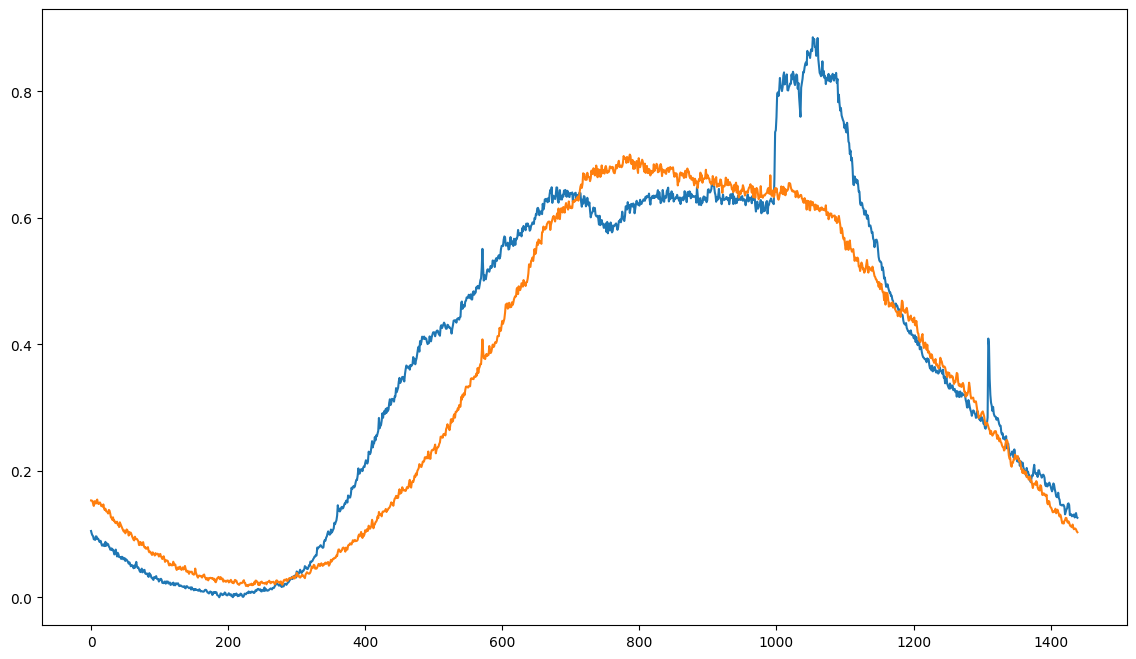

In [259]:
fig,axes = plt.subplots(1,1,figsize=(14,8))
axes.plot(np.arange(1440),data[['volumn']].values[-split:])
axes.plot(np.arange(1440),predictions)